# Phân đoạn ảnh y tế với U-Net (K-Fold & Ensemble)

## Import

In [1]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-1

In [2]:
import os
import cv2
import gc
import glob
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import albumentations as A
import segmentation_models_pytorch as smp
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Config

In [3]:
class CONFIG:
    N_SPLITS = 10
    RANDOM_STATE = 42
    LEARNING_RATE = 1e-4
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 16
    NUM_EPOCHS = 60
    IMAGE_SIZE = 128 # Sẽ giải thích ở phần Dataset
    EARLY_STOP_PATIENCE = 10
    BACKBONE_NAME = 'efficientnet-b1'
    PRETRAINED_ENCODER = 'imagenet'
    DECODER_DROPOUT = 0.4
    DECODER_ATTENTION = 'scse'
    LOSS_BCE_WEIGHT = 0.3
    LOSS_LOVASZ_WEIGHT = 0.4
    LOSS_DICE_WEIGHT =  0.3
    NUM_WORKERS = os.cpu_count() // 2 if os.cpu_count() is not None and os.cpu_count() > 1 else 2
    BASE_INPUT_DIR = "/kaggle/input/2425-ii-ait-3002-medical-image-segmentation/Dataset"
    # PREPROCESSED_IMG_PATH = "all_images_np.pkl" # Bỏ qua, đã load trực tiếp
    # PREPROCESSED_MASK_PATH = "all_masks_np.pkl" # Bỏ qua, đã load trực tiếp
    MODEL_SAVE_PATH_TEMPLATE = f"best_{BACKBONE_NAME}_fold_{{}}.pth"
    SUBMISSION_PATH = "submission.csv"
    PREDICTION_THRESHOLD = 0.5

In [4]:
def preprocess_image(image_np, kernel_size=11, inpaint_radius=5, threshold_val=10):
    gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    blackhat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, kernel)
    _, hair_mask = cv2.threshold(blackhat, threshold_val, 255, cv2.THRESH_BINARY)
    inpainted_image = cv2.inpaint(image_np, hair_mask, inpaint_radius, cv2.INPAINT_TELEA)
    return inpainted_image

class SegmentationDataset(Dataset):
    def __init__(self, images, masks, indices, transforms=None, is_validation=False):
        self.images = images
        self.masks = masks
        self.indices = indices
        self.transforms = transforms
        self.is_validation = is_validation

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        image = self.images[actual_idx].copy()
        mask = self.masks[actual_idx].copy()

        if self.transforms:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed['image']
            if not self.is_validation: # Chỉ áp dụng augmentation cho mask ở tập train
                mask = transformed['mask']

        if self.is_validation:
            # For validation, we return the original mask (resized but not augmented) for evaluation
            # Ensure mask is resized to IMAGE_SIZE if original mask is used for direct comparison later,
            # or use the original size mask and resize prediction. The current evaluate function resizes prediction.
            original_mask_tensor = (torch.from_numpy(self.masks[actual_idx]) / 255.0 > 0.5).long()
            return image, original_mask_tensor

        # For training, mask is augmented and converted
        mask_binary = (mask.float() / 255.0 > 0.5).long() if mask.max() > 1 else (mask > 0.5).long()
        return image, mask_binary.squeeze(0) if mask_binary.ndim == 3 else mask_binary

def get_transforms(image_size):
    train_transforms = A.Compose([
        A.Resize(height=image_size, width=image_size, interpolation=cv2.INTER_LINEAR),
        A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.06, scale_limit=0.1, rotate_limit=30, p=0.5, border_mode=cv2.BORDER_CONSTANT),
        A.RandomBrightnessContrast(p=0.3),
        A.OneOf([A.ElasticTransform(p=0.5, alpha=100, sigma=100 * 0.05, alpha_affine=100 * 0.03), A.GridDistortion(p=0.5)], p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), ToTensorV2(),
    ])
    val_transforms = A.Compose([
        A.Resize(height=image_size, width=image_size, interpolation=cv2.INTER_LINEAR),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), ToTensorV2(),
    ])
    return train_transforms, val_transforms

# Hàm collate_fn cho validation để xử lý mask có kích thước gốc
def val_collate_fn(batch):
    images, masks = zip(*[(item[0], item[1]) for item in batch if item[0] is not None])
    batched_images = torch.stack(images, 0)
    # Masks are already tensors of potentially different original sizes, so return as a list
    return batched_images, list(masks)

## Loss Function
#
### Hàm Loss Kết hợp (`CombinedLoss`)
- **Kết hợp nhiều loss?**: Kết hợp nhiều loại loss có thể giúp mô hình tối ưu hóa theo nhiều khía cạnh khác nhau của bài toán phân đoạn.
- **Các thành phần**:
    - `BCEWithLogitsLoss`: Binary Cross-Entropy. Đây là loss tiêu chuẩn cho các bài toán phân loại nhị phân ở từng pixel. Nó hoạt động tốt trên các vùng lớn, đồng nhất.
    - `LovaszLoss`: Tối ưu trực tiếp Jaccard index (IoU) ở mức độ tập hợp (set-level), thường hiệu quả hơn trong việc xử lý các đối tượng có hình dạng phức tạp và ranh giới không đều.
    - `DiceLoss`: Tương tự như LovaszLoss, DiceLoss cũng tối ưu một độ đo dựa trên sự trùng khớp (Dice coefficient). Nó đặc biệt hữu ích khi có sự mất cân bằng giữa foreground và background.
- **Trọng số (`LOSS_BCE_WEIGHT`, `LOSS_LOVASZ_WEIGHT`, `LOSS_DICE_WEIGHT`)**:
    - Các trọng số này (0.2, 0.4, 0.4) được chọn để cân bằng đóng góp của mỗi thành phần loss. Việc đặt trọng số cao hơn cho Lovasz và Dice (là các loss dựa trên IoU/Dice) thường mang lại kết quả tốt hơn cho các metric đánh giá phân đoạn. Các giá trị này có thể được tìm thấy qua thực nghiệm hoặc dựa trên các nghiên cứu trước đó.

In [5]:
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight, lovasz_weight, dice_weight):
        super().__init__()
        self.bce_weight = bce_weight
        self.lovasz_weight = lovasz_weight
        self.dice_weight = dice_weight
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.lovasz_loss = smp.losses.LovaszLoss(mode='binary', from_logits=True)
        self.dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True)

    def forward(self, logits, targets):
        loss = 0.0
        # Ensure targets are float for BCE and other losses
        targets_float = targets.float()
        if self.bce_weight > 1e-6: # Check if weight is significant
            loss += self.bce_weight * self.bce_loss(logits, targets_float)
        if self.lovasz_weight > 1e-6:
            loss += self.lovasz_weight * self.lovasz_loss(logits, targets_float)
        if self.dice_weight > 1e-6:
            loss += self.dice_weight * self.dice_loss(logits, targets_float)
        return loss

## Train and Evaluate
#
### Quy trình huấn luyện và đánh giá
- **`evaluate`**: Đánh giá mô hình trên tập validation.
    - **Dice Score làm metric**: Dice coefficient là một độ đo phổ biến cho bài toán phân đoạn, đo lường sự trùng khớp giữa mask dự đoán và mask thực tế.
    - **Resize dự đoán về kích thước gốc**: Để tính Dice score một cách chính xác, mask dự đoán (sau khi đi qua mô hình có kích thước `IMAGE_SIZE`) được resize về kích thước gốc của mask ground truth trước khi so sánh. Điều này quan trọng vì việc đánh giá trên ảnh đã resize có thể không phản ánh đúng hiệu suất trên ảnh gốc.
#
### Optimizer và Scheduler
- **Optimizer (`AdamW`)**: AdamW là một biến thể của Adam optimizer, cải thiện việc xử lý weight decay, thường cho kết quả tốt hơn trong nhiều bài toán deep learning.
- **Learning Rate Scheduler (`CosineAnnealingLR`)**: Giảm learning rate theo một hàm cosine từ giá trị ban đầu xuống một giá trị tối thiểu (`eta_min`) trong suốt quá trình huấn luyện. Điều này giúp mô hình hội tụ tốt hơn và tránh bị kẹt ở các điểm cực tiểu cục bộ không tốt.
#
### Early Stopping
- **Mục đích**: Ngăn chặn overfitting và tiết kiệm thời gian huấn luyện. Nếu hiệu suất trên tập validation (ví dụ: Dice score) không cải thiện sau một số epoch nhất định (`EARLY_STOP_PATIENCE`), quá trình huấn luyện sẽ dừng lại.

In [6]:
def train_one_epoch(loader, model, optimizer, loss_fn, scaler, device):
    model.train()
    running_loss = 0.0
    loop = tqdm(loader, desc="Training", leave=False)
    for data, targets in loop:
        data, targets = data.to(device), targets.unsqueeze(1).to(device) # targets need to be unsqueezed
        
        with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
            predictions = model(data)
            loss = loss_fn(predictions, targets) # targets are already float from dataset or here
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    return running_loss / len(loader)

def evaluate(loader, model, device):
    model.eval()
    dice_num, dice_den = 0, 0 # Numerator and Denominator for Dice score
    with torch.no_grad():
        for images, masks_list in tqdm(loader, desc="Validating", leave=False): # masks_list from val_collate_fn
            images = images.to(device)
            preds_logits = model(images)
            preds_probs = torch.sigmoid(preds_logits) # Apply sigmoid to get probabilities
            
            for i in range(preds_probs.shape[0]):
                pred_single_prob = preds_probs[i] # This is [C, H, W], e.g., [1, IMAGE_SIZE, IMAGE_SIZE]
                gt_mask = masks_list[i].to(device) # This is [H_orig, W_orig]
                
                # Get original H, W from the ground truth mask
                original_h, original_w = gt_mask.shape[-2], gt_mask.shape[-1]
                
                # Resize prediction to original mask size
                # TF.resize expects [..., H, W] so pred_single_prob is fine
                pred_resized_prob = TF.resize(pred_single_prob, size=[original_h, original_w], antialias=True)
                
                # Binarize the resized prediction
                pred_binary = (pred_resized_prob.squeeze(0) > CONFIG.PREDICTION_THRESHOLD).long() # Squeeze channel dim
                
                # Ensure gt_mask is also binary and long
                # gt_mask is already binary long from dataset
                
                intersection = (pred_binary * gt_mask).sum().float() # Use .float() for precision in division
                union_sum = pred_binary.sum().float() + gt_mask.sum().float()
                
                dice_num += (2 * intersection)
                dice_den += union_sum
                
    final_dice = (dice_num / (dice_den + 1e-8)).item() # Add epsilon to avoid division by zero
    return final_dice

In [7]:
def run_fold_training(fold, train_ids, val_ids, all_images, all_masks):
    print(f"\n=============== FOLD {fold+1}/{CONFIG.N_SPLITS} ===============")
    
    train_transforms, val_transforms = get_transforms(CONFIG.IMAGE_SIZE)
    train_dataset = SegmentationDataset(all_images, all_masks, train_ids, transforms=train_transforms)
    # For validation, original masks (only resized) are used to compare with model's output
    val_dataset = SegmentationDataset(all_images, all_masks, val_ids, transforms=val_transforms, is_validation=True)
    
    train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True, num_workers=CONFIG.NUM_WORKERS, pin_memory=True, drop_last=True)
    # Use val_collate_fn for validation loader
    val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False, num_workers=CONFIG.NUM_WORKERS, pin_memory=True, collate_fn=val_collate_fn)

    model = smp.Unet(
        encoder_name=CONFIG.BACKBONE_NAME, encoder_weights=CONFIG.PRETRAINED_ENCODER,
        in_channels=3, classes=1, decoder_dropout=CONFIG.DECODER_DROPOUT,
        decoder_attention_type=CONFIG.DECODER_ATTENTION
    ).to(CONFIG.DEVICE)

    loss_fn = CombinedLoss(CONFIG.LOSS_BCE_WEIGHT, CONFIG.LOSS_LOVASZ_WEIGHT, CONFIG.LOSS_DICE_WEIGHT)
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG.LEARNING_RATE, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=CONFIG.NUM_EPOCHS, eta_min=1e-6)
    scaler = torch.cuda.amp.GradScaler(enabled=(CONFIG.DEVICE.type == 'cuda'))

    best_val_dice, epochs_no_improve = -1.0, 0
    model_save_path = CONFIG.MODEL_SAVE_PATH_TEMPLATE.format(fold)

    for epoch in range(CONFIG.NUM_EPOCHS):
        train_loss = train_one_epoch(train_loader, model, optimizer, loss_fn, scaler, CONFIG.DEVICE)
        val_dice = evaluate(val_loader, model, CONFIG.DEVICE) # evaluate uses original mask size
        scheduler.step()

        print(f"Epoch {epoch+1}/{CONFIG.NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Dice: {val_dice:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            epochs_no_improve = 0
            if model_save_path:
                torch.save(model.state_dict(), model_save_path)
                print(f"==> New best model saved with Dice: {best_val_dice:.4f} to {model_save_path}")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= CONFIG.EARLY_STOP_PATIENCE:
            print(f"Early stopping triggered after {CONFIG.EARLY_STOP_PATIENCE} epochs with no improvement.")
            break
            
    del model, optimizer, scheduler, scaler, train_loader, val_loader
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    return best_val_dice

## Create Submit File
#
### K-Fold Cross-Validation và Ensemble
- **K-Fold Cross-Validation (`N_SPLITS = 10`)**:
    - **Đánh giá mô hình đáng tin cậy**: Thay vì chỉ chia dữ liệu thành một cặp train/validation duy nhất, K-Fold chia dữ liệu thành K "fold". Mô hình được huấn luyện K lần, mỗi lần sử dụng một fold khác nhau làm tập validation và K-1 fold còn lại làm tập huấn luyện. Điều này cho phép đánh giá hiệu suất của mô hình trên toàn bộ dữ liệu, giúp ước lượng tổng quát hóa tốt hơn và giảm sự phụ thuộc vào một cách chia dữ liệu cụ thể. `N_SPLITS = 10` là một lựa chọn phổ biến, cân bằng giữa thời gian tính toán và độ tin cậy của đánh giá.
- **Ensemble các mô hình từ K-Fold**:
    - **Cải thiện hiệu suất**: Sau khi huấn luyện K mô hình (mỗi mô hình cho một fold), thay vì chọn ra mô hình tốt nhất duy nhất, chúng ta có thể kết hợp (ensemble) dự đoán từ tất cả K mô hình. Trong trường hợp này, các dự đoán xác suất từ mỗi mô hình được lấy trung bình (`torch.mean`) trước khi áp dụng ngưỡng để tạo ra mask nhị phân cuối cùng.
    - **Tại sao ensemble hoạt động?**: Các mô hình được huấn luyện trên các tập con hơi khác nhau của dữ liệu (do K-Fold) có thể học được các khía cạnh hơi khác nhau của bài toán. Việc kết hợp chúng thường dẫn đến một dự đoán tổng thể mạnh mẽ và ổn định hơn so với bất kỳ mô hình đơn lẻ nào.
#
### Ngưỡng dự đoán (`PREDICTION_THRESHOLD = 0.55`)
- Sau khi mô hình đưa ra dự đoán xác suất cho mỗi pixel (từ 0 đến 1), chúng ta cần một ngưỡng để chuyển đổi các xác suất này thành một mask nhị phân (0 hoặc 1).
- `0.55` được chọn làm ngưỡng. Giá trị này thường được xác định thông qua thử nghiệm trên tập validation hoặc dựa trên kinh nghiệm. Một ngưỡng hơi cao hơn 0.5 có thể giúp giảm số lượng pixel dương tính giả (false positives) trong một số trường hợp, tùy thuộc vào đặc điểm của dữ liệu và yêu cầu của bài toán.

In [8]:
def mask_to_rle(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def generate_submission():
    print("\n--- Starting Prediction on Test Set using Ensembled K-Fold Models ---")
    
    def create_model():
        # Quan trọng: encoder_weights=None khi load state_dict đã được huấn luyện.
        # Nếu state_dict được lưu từ mô hình có encoder_weights='imagenet',
        # thì cấu trúc mô hình phải giống hệt.
        # Thông thường, chúng ta load state_dict vào một kiến trúc giống hệt.
        return smp.Unet(
            encoder_name=CONFIG.BACKBONE_NAME, encoder_weights=None, # None, vì ta sẽ load trọng số đã huấn luyện
            in_channels=3, classes=1,
            decoder_dropout=CONFIG.DECODER_DROPOUT, decoder_attention_type=CONFIG.DECODER_ATTENTION
        ).to(CONFIG.DEVICE)

    models = []
    for fold_idx in range(CONFIG.N_SPLITS): # Sửa lại để lặp từ 0 đến N_SPLITS-1
        model = create_model()
        model_path = CONFIG.MODEL_SAVE_PATH_TEMPLATE.format(fold_idx) # fold_idx là 0, 1, ..., N_SPLITS-1
        try:
            model.load_state_dict(torch.load(model_path, map_location=CONFIG.DEVICE))
            model.eval()
            models.append(model)
            print(f"Loaded model for fold {fold_idx+1} from {model_path}") # Hiển thị fold 1-based cho người dùng
        except FileNotFoundError:
            print(f"Warning: Model for fold {fold_idx+1} not found at {model_path}. This fold will not be included in ensemble.")
    
    if not models:
        print("Error: No models were loaded for prediction. Ensure training completed successfully or models were found.")
        # Tạo dummy submission nếu không có model
        sample_submission_df = pd.read_csv(os.path.join(CONFIG.BASE_INPUT_DIR, "../sample_submission.csv"))
        submission_data = [{'ID': row['ID'], 'Mask': ""} for _, row in sample_submission_df.iterrows()]
        submission_df = pd.DataFrame(submission_data)
        submission_df.to_csv(CONFIG.SUBMISSION_PATH, index=False)
        print(f"\nDummy submission file '{CONFIG.SUBMISSION_PATH}' created as no models were loaded.")
        return

    _, val_transforms = get_transforms(CONFIG.IMAGE_SIZE) # Chỉ cần transform cho validation/test
    submission_data = []
    test_img_dir = os.path.join(CONFIG.BASE_INPUT_DIR, "Test/Image") 
    if not os.path.exists(test_img_dir):
        print(f"Test image directory not found: {test_img_dir}")
        sample_submission_df = pd.read_csv(os.path.join(CONFIG.BASE_INPUT_DIR, "../sample_submission.csv"))
        for _, row in sample_submission_df.iterrows():
             submission_data.append({'ID': row['ID'], 'Mask': ""}) 
        submission_df = pd.DataFrame(submission_data)
        submission_df.to_csv(CONFIG.SUBMISSION_PATH, index=False)
        print(f"\nDummy submission file '{CONFIG.SUBMISSION_PATH}' created as test images were not found.")
        return

    test_image_files = sorted(glob.glob(os.path.join(test_img_dir, '*.jpg')))
    if not test_image_files:
        print(f"No JPG images found in {test_img_dir}")
        sample_submission_df = pd.read_csv(os.path.join(CONFIG.BASE_INPUT_DIR, "../sample_submission.csv"))
        for _, row in sample_submission_df.iterrows():
             submission_data.append({'ID': row['ID'], 'Mask': ""})
        submission_df = pd.DataFrame(submission_data)
        submission_df.to_csv(CONFIG.SUBMISSION_PATH, index=False)
        print(f"\nDummy submission file '{CONFIG.SUBMISSION_PATH}' created as no test JPGs were found.")
        return


    with torch.no_grad():
        for img_path in tqdm(test_image_files, desc="Generating predictions"):
            image_pil = Image.open(img_path).convert("RGB")
            original_h, original_w = image_pil.size[1], image_pil.size[0] # PIL Image size is (width, height)
            
            # Áp dụng tiền xử lý (ví dụ: loại bỏ lông) trước khi transform
            processed_np = preprocess_image(np.array(image_pil)) # preprocess_image trả về ảnh đã xử lý
            
            # Áp dụng transform (resize, normalize, ToTensor)
            input_tensor = val_transforms(image=processed_np)['image'].unsqueeze(0).to(CONFIG.DEVICE)

            fold_preds_probs = [torch.sigmoid(model(input_tensor)) for model in models]
            
            if not fold_preds_probs: # Nếu không có model nào được load
                # Tạo mask rỗng nếu không có model
                binary_mask = np.zeros((original_h, original_w), dtype=np.uint8)
            else:
                # Tính trung bình các xác suất dự đoán từ các model
                avg_pred_prob = torch.mean(torch.stack(fold_preds_probs, dim=0), dim=0) # Trung bình qua các fold
                
                # Resize xác suất trung bình về kích thước gốc của ảnh
                # avg_pred_prob is [1, C, H_model, W_model], TF.resize expects [..., H, W]
                pred_resized_prob = TF.resize(avg_pred_prob, size=[original_h, original_w], antialias=True)
                
                # Chuyển đổi sang mask nhị phân bằng ngưỡng
                binary_mask = (pred_resized_prob.squeeze().cpu().numpy() > CONFIG.PREDICTION_THRESHOLD).astype(np.uint8)

                fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # figsize=... để điều chỉnh kích thước cửa sổ
            
            rle = mask_to_rle(binary_mask) if binary_mask.sum() > 0 else ""
            image_id = os.path.basename(img_path).split('.')[0]
            submission_data.append({'ID': image_id, 'Mask': rle})

    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv(CONFIG.SUBMISSION_PATH, index=False)
    print(f"\nSubmission file '{CONFIG.SUBMISSION_PATH}' created successfully!")
    print(submission_df.head())

## Let's do it :v
#
Phần này sẽ thực thi toàn bộ quy trình:
1. Tải và tiền xử lý dữ liệu huấn luyện một lần duy nhất, lưu vào RAM để tăng tốc độ truy cập trong quá trình huấn luyện K-Fold.
2. Chạy huấn luyện K-Fold.
3. Tạo file submission bằng cách sử dụng ensemble các mô hình đã huấn luyện.

In [9]:
import pickle
with open("/kaggle/input/all-images/all_images_np.pkl", "rb") as f:
    all_images_np = pickle.load(f)
with open("/kaggle/input/all-masks/all_masks_np.pkl", "rb") as f:
    all_masks_np = pickle.load(f)

In [10]:
# print("--- Starting one-time data loading and preprocessing into RAM ---")
# TRAIN_IMG_DIR = os.path.join(CONFIG.BASE_INPUT_DIR, "Train/Image") # Sửa lại đường dẫn
# TRAIN_MASK_DIR = os.path.join(CONFIG.BASE_INPUT_DIR, "Train/Mask") # Sửa lại đường dẫn
# all_images_np, all_masks_np = [], []

# # Sắp xếp để đảm bảo tính nhất quán nếu cần debug
# image_files = sorted(glob.glob(os.path.join(TRAIN_IMG_DIR, '*.jpg'))) 

# for img_path in tqdm(image_files, desc="Initial Preprocessing (Loading into RAM)"):
#     mask_path = img_path.replace(TRAIN_IMG_DIR, TRAIN_MASK_DIR).replace('.jpg', '.png')
#     if not os.path.exists(mask_path): 
#         print(f"Warning: Mask not found for {img_path}")
#         continue
        
#     image_np = np.array(Image.open(img_path).convert("RGB"))
#     mask_np = np.array(Image.open(mask_path).convert("L")) # Mask là ảnh grayscale
    
#     # Áp dụng tiền xử lý loại bỏ lông ở đây, trước khi đưa vào Dataset
#     # Nếu không muốn áp dụng cho tất cả, có thể bỏ qua bước này và để augmentation xử lý
#     # Hoặc thêm một cờ trong CONFIG để bật/tắt
#     # if CONFIG.APPLY_HAIR_REMOVAL_PREPROCESSING: # Ví dụ
#     image_np = preprocess_image(image_np) # Áp dụng cho tất cả ảnh huấn luyện
        
#     all_images_np.append(image_np)
#     all_masks_np.append(mask_np) # Mask gốc, chưa qua resize hay augment

# # Chuyển đổi sang numpy array một lần để tiết kiệm bộ nhớ và tăng tốc độ truy cập
# # all_images_np = np.array(all_images_np, dtype=object) # Nếu ảnh có kích thước khác nhau ban đầu thì không nên
# # all_masks_np = np.array(all_masks_np, dtype=object)  # Tương tự
# # Giữ chúng dưới dạng list các numpy array sẽ linh hoạt hơn.

# print(f"Finished. {len(all_images_np)} image/mask pairs loaded into RAM.\n")


--- Starting K-Fold Cross-Validation Training (10 folds) ---

=============== FOLD 1/10 ===============


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_19/1946806971.py:48: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.OneOf([A.ElasticTransform(p=0.5, alpha=100, sigma=100 * 0.05, alpha_affine=100 * 0.03), A.GridDistortion(p=0.5)], p=0.2),


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

/tmp/ipykernel_19/758548390.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(CONFIG.DEVICE.type == 'cuda'))
Training:   0%|          | 0/61 [00:00<?, ?it/s]/tmp/ipykernel_19/436337463.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):


Epoch 1/60 | Train Loss: 0.8357 | Val Dice: 0.6017 | LR: 9.99e-05
==> New best model saved with Dice: 0.6017 to best_efficientnet-b1_fold_0.pth


Epoch 2/60 | Train Loss: 0.5048 | Val Dice: 0.7615 | LR: 9.97e-05
==> New best model saved with Dice: 0.7615 to best_efficientnet-b1_fold_0.pth


Epoch 3/60 | Train Loss: 0.3634 | Val Dice: 0.8756 | LR: 9.94e-05
==> New best model saved with Dice: 0.8756 to best_efficientnet-b1_fold_0.pth


Epoch 4/60 | Train Loss: 0.3231 | Val Dice: 0.8976 | LR: 9.89e-05
==> New best model saved with Dice: 0.8976 to best_efficientnet-b1_fold_0.pth


Epoch 5/60 | Train Loss: 0.2765 | Val Dice: 0.9113 | LR: 9.83e-05
==> New best model saved with Dice: 0.9113 to best_efficientnet-b1_fold_0.pth


Epoch 6/60 | Train Loss: 0.2689 | Val Dice: 0.8950 | LR: 9.76e-05


Epoch 7/60 | Train Loss: 0.2498 | Val Dice: 0.9117 | LR: 9.67e-05
==> New best model saved with Dice: 0.9117 to best_efficientnet-b1_fold_0.pth


Epoch 8/60 | Train Loss: 0.2354 | Val Dice: 0.9158 | LR: 9.57e-05
==> New best model saved with Dice: 0.9158 to best_efficientnet-b1_fold_0.pth


Epoch 9/60 | Train Loss: 0.2326 | Val Dice: 0.9147 | LR: 9.46e-05


Epoch 10/60 | Train Loss: 0.2215 | Val Dice: 0.9157 | LR: 9.34e-05


Epoch 11/60 | Train Loss: 0.2136 | Val Dice: 0.9165 | LR: 9.20e-05
==> New best model saved with Dice: 0.9165 to best_efficientnet-b1_fold_0.pth


Epoch 12/60 | Train Loss: 0.2002 | Val Dice: 0.9155 | LR: 9.05e-05


Epoch 13/60 | Train Loss: 0.2101 | Val Dice: 0.9126 | LR: 8.90e-05


Epoch 14/60 | Train Loss: 0.2012 | Val Dice: 0.9123 | LR: 8.73e-05


Epoch 15/60 | Train Loss: 0.1935 | Val Dice: 0.9173 | LR: 8.55e-05
==> New best model saved with Dice: 0.9173 to best_efficientnet-b1_fold_0.pth


Epoch 16/60 | Train Loss: 0.1942 | Val Dice: 0.9165 | LR: 8.36e-05


Epoch 17/60 | Train Loss: 0.1847 | Val Dice: 0.9160 | LR: 8.17e-05


Epoch 18/60 | Train Loss: 0.1774 | Val Dice: 0.9120 | LR: 7.96e-05


Epoch 19/60 | Train Loss: 0.1815 | Val Dice: 0.9154 | LR: 7.75e-05


Epoch 20/60 | Train Loss: 0.1793 | Val Dice: 0.9137 | LR: 7.52e-05


Epoch 21/60 | Train Loss: 0.1683 | Val Dice: 0.9148 | LR: 7.30e-05


Epoch 22/60 | Train Loss: 0.1670 | Val Dice: 0.9165 | LR: 7.06e-05


Epoch 23/60 | Train Loss: 0.1613 | Val Dice: 0.9144 | LR: 6.82e-05


Epoch 24/60 | Train Loss: 0.1659 | Val Dice: 0.9111 | LR: 6.58e-05


Epoch 25/60 | Train Loss: 0.1595 | Val Dice: 0.9119 | LR: 6.33e-05
Early stopping triggered after 10 epochs with no improvement.

=============== FOLD 2/10 ===============


Epoch 1/60 | Train Loss: 0.8677 | Val Dice: 0.3509 | LR: 9.99e-05
==> New best model saved with Dice: 0.3509 to best_efficientnet-b1_fold_1.pth


Epoch 2/60 | Train Loss: 0.5686 | Val Dice: 0.8576 | LR: 9.97e-05
==> New best model saved with Dice: 0.8576 to best_efficientnet-b1_fold_1.pth


Epoch 3/60 | Train Loss: 0.3680 | Val Dice: 0.9122 | LR: 9.94e-05
==> New best model saved with Dice: 0.9122 to best_efficientnet-b1_fold_1.pth


Epoch 4/60 | Train Loss: 0.3049 | Val Dice: 0.9282 | LR: 9.89e-05
==> New best model saved with Dice: 0.9282 to best_efficientnet-b1_fold_1.pth


Epoch 5/60 | Train Loss: 0.2736 | Val Dice: 0.9282 | LR: 9.83e-05


Epoch 6/60 | Train Loss: 0.2759 | Val Dice: 0.9279 | LR: 9.76e-05


Epoch 7/60 | Train Loss: 0.2400 | Val Dice: 0.9309 | LR: 9.67e-05
==> New best model saved with Dice: 0.9309 to best_efficientnet-b1_fold_1.pth


Epoch 8/60 | Train Loss: 0.2357 | Val Dice: 0.9296 | LR: 9.57e-05


Epoch 9/60 | Train Loss: 0.2176 | Val Dice: 0.9344 | LR: 9.46e-05
==> New best model saved with Dice: 0.9344 to best_efficientnet-b1_fold_1.pth


Epoch 10/60 | Train Loss: 0.2204 | Val Dice: 0.9337 | LR: 9.34e-05


Epoch 11/60 | Train Loss: 0.2143 | Val Dice: 0.9340 | LR: 9.20e-05


Epoch 12/60 | Train Loss: 0.2206 | Val Dice: 0.9300 | LR: 9.05e-05


Epoch 13/60 | Train Loss: 0.2167 | Val Dice: 0.9343 | LR: 8.90e-05


Epoch 14/60 | Train Loss: 0.2046 | Val Dice: 0.9336 | LR: 8.73e-05


Epoch 15/60 | Train Loss: 0.1965 | Val Dice: 0.9338 | LR: 8.55e-05


Epoch 16/60 | Train Loss: 0.1926 | Val Dice: 0.9345 | LR: 8.36e-05
==> New best model saved with Dice: 0.9345 to best_efficientnet-b1_fold_1.pth


Epoch 17/60 | Train Loss: 0.1824 | Val Dice: 0.9328 | LR: 8.17e-05


Epoch 18/60 | Train Loss: 0.1884 | Val Dice: 0.9352 | LR: 7.96e-05
==> New best model saved with Dice: 0.9352 to best_efficientnet-b1_fold_1.pth


Epoch 19/60 | Train Loss: 0.1817 | Val Dice: 0.9347 | LR: 7.75e-05


Epoch 20/60 | Train Loss: 0.1715 | Val Dice: 0.9333 | LR: 7.52e-05


Epoch 21/60 | Train Loss: 0.1720 | Val Dice: 0.9365 | LR: 7.30e-05
==> New best model saved with Dice: 0.9365 to best_efficientnet-b1_fold_1.pth


Epoch 22/60 | Train Loss: 0.1688 | Val Dice: 0.9372 | LR: 7.06e-05
==> New best model saved with Dice: 0.9372 to best_efficientnet-b1_fold_1.pth


Epoch 23/60 | Train Loss: 0.1748 | Val Dice: 0.9365 | LR: 6.82e-05


Epoch 24/60 | Train Loss: 0.1636 | Val Dice: 0.9354 | LR: 6.58e-05


Epoch 25/60 | Train Loss: 0.1661 | Val Dice: 0.9349 | LR: 6.33e-05


Epoch 26/60 | Train Loss: 0.1681 | Val Dice: 0.9342 | LR: 6.08e-05


Epoch 27/60 | Train Loss: 0.1560 | Val Dice: 0.9318 | LR: 5.82e-05


Epoch 28/60 | Train Loss: 0.1580 | Val Dice: 0.9318 | LR: 5.57e-05


Epoch 29/60 | Train Loss: 0.1552 | Val Dice: 0.9355 | LR: 5.31e-05


Epoch 30/60 | Train Loss: 0.1520 | Val Dice: 0.9350 | LR: 5.05e-05


Epoch 31/60 | Train Loss: 0.1493 | Val Dice: 0.9349 | LR: 4.79e-05


Epoch 32/60 | Train Loss: 0.1467 | Val Dice: 0.9359 | LR: 4.53e-05
Early stopping triggered after 10 epochs with no improvement.

=============== FOLD 3/10 ===============


Epoch 1/60 | Train Loss: 0.7399 | Val Dice: 0.8082 | LR: 9.99e-05
==> New best model saved with Dice: 0.8082 to best_efficientnet-b1_fold_2.pth


Epoch 2/60 | Train Loss: 0.5135 | Val Dice: 0.8815 | LR: 9.97e-05
==> New best model saved with Dice: 0.8815 to best_efficientnet-b1_fold_2.pth


Epoch 3/60 | Train Loss: 0.3911 | Val Dice: 0.8898 | LR: 9.94e-05
==> New best model saved with Dice: 0.8898 to best_efficientnet-b1_fold_2.pth


Epoch 4/60 | Train Loss: 0.3226 | Val Dice: 0.9043 | LR: 9.89e-05
==> New best model saved with Dice: 0.9043 to best_efficientnet-b1_fold_2.pth


Epoch 5/60 | Train Loss: 0.3034 | Val Dice: 0.9061 | LR: 9.83e-05
==> New best model saved with Dice: 0.9061 to best_efficientnet-b1_fold_2.pth


Epoch 6/60 | Train Loss: 0.2807 | Val Dice: 0.9143 | LR: 9.76e-05
==> New best model saved with Dice: 0.9143 to best_efficientnet-b1_fold_2.pth


Epoch 7/60 | Train Loss: 0.2616 | Val Dice: 0.9197 | LR: 9.67e-05
==> New best model saved with Dice: 0.9197 to best_efficientnet-b1_fold_2.pth


Epoch 8/60 | Train Loss: 0.2563 | Val Dice: 0.9133 | LR: 9.57e-05


Epoch 9/60 | Train Loss: 0.2448 | Val Dice: 0.9179 | LR: 9.46e-05


Epoch 10/60 | Train Loss: 0.2335 | Val Dice: 0.9219 | LR: 9.34e-05
==> New best model saved with Dice: 0.9219 to best_efficientnet-b1_fold_2.pth


Epoch 11/60 | Train Loss: 0.2221 | Val Dice: 0.9208 | LR: 9.20e-05


Epoch 12/60 | Train Loss: 0.2148 | Val Dice: 0.9232 | LR: 9.05e-05
==> New best model saved with Dice: 0.9232 to best_efficientnet-b1_fold_2.pth


Epoch 13/60 | Train Loss: 0.2145 | Val Dice: 0.9221 | LR: 8.90e-05


Epoch 14/60 | Train Loss: 0.2098 | Val Dice: 0.9200 | LR: 8.73e-05


Epoch 15/60 | Train Loss: 0.1987 | Val Dice: 0.9201 | LR: 8.55e-05


Epoch 16/60 | Train Loss: 0.1903 | Val Dice: 0.9245 | LR: 8.36e-05
==> New best model saved with Dice: 0.9245 to best_efficientnet-b1_fold_2.pth


Epoch 17/60 | Train Loss: 0.1828 | Val Dice: 0.9217 | LR: 8.17e-05


Epoch 18/60 | Train Loss: 0.1798 | Val Dice: 0.9286 | LR: 7.96e-05
==> New best model saved with Dice: 0.9286 to best_efficientnet-b1_fold_2.pth


Epoch 19/60 | Train Loss: 0.1760 | Val Dice: 0.9285 | LR: 7.75e-05


Epoch 20/60 | Train Loss: 0.1750 | Val Dice: 0.9253 | LR: 7.52e-05


Epoch 21/60 | Train Loss: 0.1739 | Val Dice: 0.9280 | LR: 7.30e-05


Epoch 22/60 | Train Loss: 0.1661 | Val Dice: 0.9253 | LR: 7.06e-05


Epoch 23/60 | Train Loss: 0.1622 | Val Dice: 0.9287 | LR: 6.82e-05
==> New best model saved with Dice: 0.9287 to best_efficientnet-b1_fold_2.pth


Epoch 24/60 | Train Loss: 0.1638 | Val Dice: 0.9244 | LR: 6.58e-05


Epoch 25/60 | Train Loss: 0.1581 | Val Dice: 0.9242 | LR: 6.33e-05


Epoch 26/60 | Train Loss: 0.1590 | Val Dice: 0.9245 | LR: 6.08e-05


Epoch 27/60 | Train Loss: 0.1624 | Val Dice: 0.9212 | LR: 5.82e-05


Epoch 28/60 | Train Loss: 0.1543 | Val Dice: 0.9226 | LR: 5.57e-05


Epoch 29/60 | Train Loss: 0.1586 | Val Dice: 0.9213 | LR: 5.31e-05


Epoch 30/60 | Train Loss: 0.1512 | Val Dice: 0.9152 | LR: 5.05e-05


Epoch 31/60 | Train Loss: 0.1501 | Val Dice: 0.9234 | LR: 4.79e-05


Epoch 32/60 | Train Loss: 0.1486 | Val Dice: 0.9235 | LR: 4.53e-05


Epoch 33/60 | Train Loss: 0.1536 | Val Dice: 0.9221 | LR: 4.28e-05
Early stopping triggered after 10 epochs with no improvement.

=============== FOLD 4/10 ===============


Epoch 1/60 | Train Loss: 0.7455 | Val Dice: 0.7464 | LR: 9.99e-05
==> New best model saved with Dice: 0.7464 to best_efficientnet-b1_fold_3.pth


Epoch 2/60 | Train Loss: 0.4419 | Val Dice: 0.8892 | LR: 9.97e-05
==> New best model saved with Dice: 0.8892 to best_efficientnet-b1_fold_3.pth


Epoch 3/60 | Train Loss: 0.3410 | Val Dice: 0.9190 | LR: 9.94e-05
==> New best model saved with Dice: 0.9190 to best_efficientnet-b1_fold_3.pth


Epoch 4/60 | Train Loss: 0.3051 | Val Dice: 0.9169 | LR: 9.89e-05


Epoch 5/60 | Train Loss: 0.2896 | Val Dice: 0.9238 | LR: 9.83e-05
==> New best model saved with Dice: 0.9238 to best_efficientnet-b1_fold_3.pth


Epoch 6/60 | Train Loss: 0.2777 | Val Dice: 0.9305 | LR: 9.76e-05
==> New best model saved with Dice: 0.9305 to best_efficientnet-b1_fold_3.pth


Epoch 7/60 | Train Loss: 0.2802 | Val Dice: 0.9341 | LR: 9.67e-05
==> New best model saved with Dice: 0.9341 to best_efficientnet-b1_fold_3.pth


Epoch 8/60 | Train Loss: 0.2503 | Val Dice: 0.9417 | LR: 9.57e-05
==> New best model saved with Dice: 0.9417 to best_efficientnet-b1_fold_3.pth


Epoch 9/60 | Train Loss: 0.2413 | Val Dice: 0.9393 | LR: 9.46e-05


Epoch 10/60 | Train Loss: 0.2261 | Val Dice: 0.9379 | LR: 9.34e-05


Epoch 11/60 | Train Loss: 0.2275 | Val Dice: 0.9438 | LR: 9.20e-05
==> New best model saved with Dice: 0.9438 to best_efficientnet-b1_fold_3.pth


Epoch 12/60 | Train Loss: 0.2216 | Val Dice: 0.9448 | LR: 9.05e-05
==> New best model saved with Dice: 0.9448 to best_efficientnet-b1_fold_3.pth


Epoch 13/60 | Train Loss: 0.2078 | Val Dice: 0.9463 | LR: 8.90e-05
==> New best model saved with Dice: 0.9463 to best_efficientnet-b1_fold_3.pth


Epoch 14/60 | Train Loss: 0.2071 | Val Dice: 0.9456 | LR: 8.73e-05


Epoch 15/60 | Train Loss: 0.1985 | Val Dice: 0.9463 | LR: 8.55e-05
==> New best model saved with Dice: 0.9463 to best_efficientnet-b1_fold_3.pth


Epoch 16/60 | Train Loss: 0.1911 | Val Dice: 0.9436 | LR: 8.36e-05


Epoch 17/60 | Train Loss: 0.1984 | Val Dice: 0.9470 | LR: 8.17e-05
==> New best model saved with Dice: 0.9470 to best_efficientnet-b1_fold_3.pth


Epoch 18/60 | Train Loss: 0.1843 | Val Dice: 0.9462 | LR: 7.96e-05


Epoch 19/60 | Train Loss: 0.1775 | Val Dice: 0.9479 | LR: 7.75e-05
==> New best model saved with Dice: 0.9479 to best_efficientnet-b1_fold_3.pth


Epoch 20/60 | Train Loss: 0.1814 | Val Dice: 0.9445 | LR: 7.52e-05


Epoch 21/60 | Train Loss: 0.1839 | Val Dice: 0.9472 | LR: 7.30e-05


Epoch 22/60 | Train Loss: 0.1776 | Val Dice: 0.9458 | LR: 7.06e-05


Epoch 23/60 | Train Loss: 0.1725 | Val Dice: 0.9460 | LR: 6.82e-05


Epoch 24/60 | Train Loss: 0.1758 | Val Dice: 0.9441 | LR: 6.58e-05


Epoch 25/60 | Train Loss: 0.1619 | Val Dice: 0.9478 | LR: 6.33e-05


Epoch 26/60 | Train Loss: 0.1637 | Val Dice: 0.9450 | LR: 6.08e-05


Epoch 27/60 | Train Loss: 0.1611 | Val Dice: 0.9459 | LR: 5.82e-05


Epoch 28/60 | Train Loss: 0.1584 | Val Dice: 0.9467 | LR: 5.57e-05


Epoch 29/60 | Train Loss: 0.1592 | Val Dice: 0.9456 | LR: 5.31e-05
Early stopping triggered after 10 epochs with no improvement.

=============== FOLD 5/10 ===============


Epoch 1/60 | Train Loss: 0.8578 | Val Dice: 0.4104 | LR: 9.99e-05
==> New best model saved with Dice: 0.4104 to best_efficientnet-b1_fold_4.pth


Epoch 2/60 | Train Loss: 0.5713 | Val Dice: 0.8726 | LR: 9.97e-05
==> New best model saved with Dice: 0.8726 to best_efficientnet-b1_fold_4.pth


Epoch 3/60 | Train Loss: 0.4449 | Val Dice: 0.9089 | LR: 9.94e-05
==> New best model saved with Dice: 0.9089 to best_efficientnet-b1_fold_4.pth


Epoch 4/60 | Train Loss: 0.3650 | Val Dice: 0.9183 | LR: 9.89e-05
==> New best model saved with Dice: 0.9183 to best_efficientnet-b1_fold_4.pth


Epoch 5/60 | Train Loss: 0.3279 | Val Dice: 0.9234 | LR: 9.83e-05
==> New best model saved with Dice: 0.9234 to best_efficientnet-b1_fold_4.pth


Epoch 6/60 | Train Loss: 0.3103 | Val Dice: 0.9298 | LR: 9.76e-05
==> New best model saved with Dice: 0.9298 to best_efficientnet-b1_fold_4.pth


Epoch 7/60 | Train Loss: 0.2910 | Val Dice: 0.9329 | LR: 9.67e-05
==> New best model saved with Dice: 0.9329 to best_efficientnet-b1_fold_4.pth


Epoch 8/60 | Train Loss: 0.2674 | Val Dice: 0.9334 | LR: 9.57e-05
==> New best model saved with Dice: 0.9334 to best_efficientnet-b1_fold_4.pth


Epoch 9/60 | Train Loss: 0.2566 | Val Dice: 0.9351 | LR: 9.46e-05
==> New best model saved with Dice: 0.9351 to best_efficientnet-b1_fold_4.pth


Epoch 10/60 | Train Loss: 0.2447 | Val Dice: 0.9374 | LR: 9.34e-05
==> New best model saved with Dice: 0.9374 to best_efficientnet-b1_fold_4.pth


Epoch 11/60 | Train Loss: 0.2294 | Val Dice: 0.9386 | LR: 9.20e-05
==> New best model saved with Dice: 0.9386 to best_efficientnet-b1_fold_4.pth


Epoch 12/60 | Train Loss: 0.2293 | Val Dice: 0.9343 | LR: 9.05e-05


Epoch 13/60 | Train Loss: 0.2239 | Val Dice: 0.9378 | LR: 8.90e-05


Epoch 14/60 | Train Loss: 0.2162 | Val Dice: 0.9358 | LR: 8.73e-05


Epoch 15/60 | Train Loss: 0.2043 | Val Dice: 0.9380 | LR: 8.55e-05


Epoch 16/60 | Train Loss: 0.2051 | Val Dice: 0.9377 | LR: 8.36e-05


Epoch 17/60 | Train Loss: 0.1983 | Val Dice: 0.9380 | LR: 8.17e-05


Epoch 18/60 | Train Loss: 0.1949 | Val Dice: 0.9405 | LR: 7.96e-05
==> New best model saved with Dice: 0.9405 to best_efficientnet-b1_fold_4.pth


Epoch 19/60 | Train Loss: 0.1848 | Val Dice: 0.9378 | LR: 7.75e-05


Epoch 20/60 | Train Loss: 0.1881 | Val Dice: 0.9391 | LR: 7.52e-05


Epoch 21/60 | Train Loss: 0.1800 | Val Dice: 0.9395 | LR: 7.30e-05


Epoch 22/60 | Train Loss: 0.1798 | Val Dice: 0.9378 | LR: 7.06e-05


Epoch 23/60 | Train Loss: 0.1795 | Val Dice: 0.9402 | LR: 6.82e-05


Epoch 24/60 | Train Loss: 0.1711 | Val Dice: 0.9398 | LR: 6.58e-05


Epoch 25/60 | Train Loss: 0.1714 | Val Dice: 0.9379 | LR: 6.33e-05


Epoch 26/60 | Train Loss: 0.1729 | Val Dice: 0.9391 | LR: 6.08e-05


Epoch 27/60 | Train Loss: 0.1681 | Val Dice: 0.9397 | LR: 5.82e-05


Epoch 28/60 | Train Loss: 0.1696 | Val Dice: 0.9395 | LR: 5.57e-05
Early stopping triggered after 10 epochs with no improvement.

=============== FOLD 6/10 ===============


Epoch 1/60 | Train Loss: 0.8450 | Val Dice: 0.6800 | LR: 9.99e-05
==> New best model saved with Dice: 0.6800 to best_efficientnet-b1_fold_5.pth


Epoch 2/60 | Train Loss: 0.5542 | Val Dice: 0.8601 | LR: 9.97e-05
==> New best model saved with Dice: 0.8601 to best_efficientnet-b1_fold_5.pth


Epoch 3/60 | Train Loss: 0.3961 | Val Dice: 0.8754 | LR: 9.94e-05
==> New best model saved with Dice: 0.8754 to best_efficientnet-b1_fold_5.pth


Epoch 4/60 | Train Loss: 0.3380 | Val Dice: 0.9072 | LR: 9.89e-05
==> New best model saved with Dice: 0.9072 to best_efficientnet-b1_fold_5.pth


Epoch 5/60 | Train Loss: 0.3019 | Val Dice: 0.9080 | LR: 9.83e-05
==> New best model saved with Dice: 0.9080 to best_efficientnet-b1_fold_5.pth


Epoch 6/60 | Train Loss: 0.2687 | Val Dice: 0.9180 | LR: 9.76e-05
==> New best model saved with Dice: 0.9180 to best_efficientnet-b1_fold_5.pth


Epoch 7/60 | Train Loss: 0.2663 | Val Dice: 0.9102 | LR: 9.67e-05


Epoch 8/60 | Train Loss: 0.2357 | Val Dice: 0.9160 | LR: 9.57e-05


Epoch 9/60 | Train Loss: 0.2311 | Val Dice: 0.9176 | LR: 9.46e-05


Epoch 10/60 | Train Loss: 0.2316 | Val Dice: 0.9189 | LR: 9.34e-05
==> New best model saved with Dice: 0.9189 to best_efficientnet-b1_fold_5.pth


Epoch 11/60 | Train Loss: 0.2209 | Val Dice: 0.9172 | LR: 9.20e-05


Epoch 12/60 | Train Loss: 0.2139 | Val Dice: 0.9142 | LR: 9.05e-05


Epoch 13/60 | Train Loss: 0.2090 | Val Dice: 0.9241 | LR: 8.90e-05
==> New best model saved with Dice: 0.9241 to best_efficientnet-b1_fold_5.pth


Epoch 14/60 | Train Loss: 0.2039 | Val Dice: 0.9161 | LR: 8.73e-05


Epoch 15/60 | Train Loss: 0.1909 | Val Dice: 0.9181 | LR: 8.55e-05


Epoch 16/60 | Train Loss: 0.1975 | Val Dice: 0.9217 | LR: 8.36e-05


Epoch 17/60 | Train Loss: 0.1910 | Val Dice: 0.9212 | LR: 8.17e-05


Epoch 18/60 | Train Loss: 0.1877 | Val Dice: 0.9209 | LR: 7.96e-05


Epoch 19/60 | Train Loss: 0.1817 | Val Dice: 0.9237 | LR: 7.75e-05


Epoch 20/60 | Train Loss: 0.1772 | Val Dice: 0.9215 | LR: 7.52e-05


Epoch 21/60 | Train Loss: 0.1691 | Val Dice: 0.9194 | LR: 7.30e-05


Epoch 22/60 | Train Loss: 0.1724 | Val Dice: 0.9182 | LR: 7.06e-05


Epoch 23/60 | Train Loss: 0.1681 | Val Dice: 0.9243 | LR: 6.82e-05
==> New best model saved with Dice: 0.9243 to best_efficientnet-b1_fold_5.pth


Epoch 24/60 | Train Loss: 0.1624 | Val Dice: 0.9219 | LR: 6.58e-05


Epoch 25/60 | Train Loss: 0.1624 | Val Dice: 0.9257 | LR: 6.33e-05
==> New best model saved with Dice: 0.9257 to best_efficientnet-b1_fold_5.pth


Epoch 26/60 | Train Loss: 0.1569 | Val Dice: 0.9254 | LR: 6.08e-05


Epoch 27/60 | Train Loss: 0.1573 | Val Dice: 0.9262 | LR: 5.82e-05
==> New best model saved with Dice: 0.9262 to best_efficientnet-b1_fold_5.pth


Epoch 28/60 | Train Loss: 0.1562 | Val Dice: 0.9269 | LR: 5.57e-05
==> New best model saved with Dice: 0.9269 to best_efficientnet-b1_fold_5.pth


Epoch 29/60 | Train Loss: 0.1590 | Val Dice: 0.9243 | LR: 5.31e-05


Epoch 30/60 | Train Loss: 0.1508 | Val Dice: 0.9216 | LR: 5.05e-05


Epoch 31/60 | Train Loss: 0.1503 | Val Dice: 0.9229 | LR: 4.79e-05


Epoch 32/60 | Train Loss: 0.1516 | Val Dice: 0.9248 | LR: 4.53e-05


Epoch 33/60 | Train Loss: 0.1447 | Val Dice: 0.9265 | LR: 4.28e-05


Epoch 34/60 | Train Loss: 0.1429 | Val Dice: 0.9276 | LR: 4.02e-05
==> New best model saved with Dice: 0.9276 to best_efficientnet-b1_fold_5.pth


Epoch 35/60 | Train Loss: 0.1425 | Val Dice: 0.9249 | LR: 3.77e-05


Epoch 36/60 | Train Loss: 0.1419 | Val Dice: 0.9276 | LR: 3.52e-05
==> New best model saved with Dice: 0.9276 to best_efficientnet-b1_fold_5.pth


Epoch 37/60 | Train Loss: 0.1426 | Val Dice: 0.9257 | LR: 3.28e-05


Epoch 38/60 | Train Loss: 0.1402 | Val Dice: 0.9255 | LR: 3.04e-05


Epoch 39/60 | Train Loss: 0.1370 | Val Dice: 0.9273 | LR: 2.80e-05


Epoch 40/60 | Train Loss: 0.1376 | Val Dice: 0.9259 | LR: 2.58e-05


Epoch 41/60 | Train Loss: 0.1372 | Val Dice: 0.9273 | LR: 2.35e-05


Epoch 42/60 | Train Loss: 0.1367 | Val Dice: 0.9266 | LR: 2.14e-05


Epoch 43/60 | Train Loss: 0.1368 | Val Dice: 0.9271 | LR: 1.93e-05


Epoch 44/60 | Train Loss: 0.1340 | Val Dice: 0.9267 | LR: 1.74e-05


Epoch 45/60 | Train Loss: 0.1340 | Val Dice: 0.9271 | LR: 1.55e-05


Epoch 46/60 | Train Loss: 0.1317 | Val Dice: 0.9280 | LR: 1.37e-05
==> New best model saved with Dice: 0.9280 to best_efficientnet-b1_fold_5.pth


Epoch 47/60 | Train Loss: 0.1365 | Val Dice: 0.9279 | LR: 1.20e-05


Epoch 48/60 | Train Loss: 0.1338 | Val Dice: 0.9271 | LR: 1.05e-05


Epoch 49/60 | Train Loss: 0.1320 | Val Dice: 0.9277 | LR: 8.99e-06


Epoch 50/60 | Train Loss: 0.1292 | Val Dice: 0.9280 | LR: 7.63e-06
==> New best model saved with Dice: 0.9280 to best_efficientnet-b1_fold_5.pth


Epoch 51/60 | Train Loss: 0.1328 | Val Dice: 0.9265 | LR: 6.40e-06


Epoch 52/60 | Train Loss: 0.1316 | Val Dice: 0.9271 | LR: 5.28e-06


Epoch 53/60 | Train Loss: 0.1306 | Val Dice: 0.9275 | LR: 4.29e-06


Epoch 54/60 | Train Loss: 0.1291 | Val Dice: 0.9274 | LR: 3.42e-06


Epoch 55/60 | Train Loss: 0.1308 | Val Dice: 0.9272 | LR: 2.69e-06


Epoch 56/60 | Train Loss: 0.1300 | Val Dice: 0.9269 | LR: 2.08e-06


Epoch 57/60 | Train Loss: 0.1310 | Val Dice: 0.9272 | LR: 1.61e-06


Epoch 58/60 | Train Loss: 0.1286 | Val Dice: 0.9272 | LR: 1.27e-06


Epoch 59/60 | Train Loss: 0.1280 | Val Dice: 0.9273 | LR: 1.07e-06


Epoch 60/60 | Train Loss: 0.1293 | Val Dice: 0.9272 | LR: 1.00e-06
Early stopping triggered after 10 epochs with no improvement.

=============== FOLD 7/10 ===============


Epoch 1/60 | Train Loss: 0.8294 | Val Dice: 0.7032 | LR: 9.99e-05
==> New best model saved with Dice: 0.7032 to best_efficientnet-b1_fold_6.pth


Epoch 2/60 | Train Loss: 0.5389 | Val Dice: 0.8673 | LR: 9.97e-05
==> New best model saved with Dice: 0.8673 to best_efficientnet-b1_fold_6.pth


Epoch 3/60 | Train Loss: 0.3828 | Val Dice: 0.8968 | LR: 9.94e-05
==> New best model saved with Dice: 0.8968 to best_efficientnet-b1_fold_6.pth


Epoch 4/60 | Train Loss: 0.3267 | Val Dice: 0.9116 | LR: 9.89e-05
==> New best model saved with Dice: 0.9116 to best_efficientnet-b1_fold_6.pth


Epoch 5/60 | Train Loss: 0.3027 | Val Dice: 0.9181 | LR: 9.83e-05
==> New best model saved with Dice: 0.9181 to best_efficientnet-b1_fold_6.pth


Epoch 6/60 | Train Loss: 0.2827 | Val Dice: 0.9191 | LR: 9.76e-05
==> New best model saved with Dice: 0.9191 to best_efficientnet-b1_fold_6.pth


Epoch 7/60 | Train Loss: 0.2657 | Val Dice: 0.9205 | LR: 9.67e-05
==> New best model saved with Dice: 0.9205 to best_efficientnet-b1_fold_6.pth


Epoch 8/60 | Train Loss: 0.2502 | Val Dice: 0.9189 | LR: 9.57e-05


Epoch 9/60 | Train Loss: 0.2447 | Val Dice: 0.9174 | LR: 9.46e-05


Epoch 10/60 | Train Loss: 0.2324 | Val Dice: 0.9110 | LR: 9.34e-05


Epoch 11/60 | Train Loss: 0.2218 | Val Dice: 0.9216 | LR: 9.20e-05
==> New best model saved with Dice: 0.9216 to best_efficientnet-b1_fold_6.pth


Epoch 12/60 | Train Loss: 0.2132 | Val Dice: 0.9206 | LR: 9.05e-05


Epoch 13/60 | Train Loss: 0.2160 | Val Dice: 0.9198 | LR: 8.90e-05


Epoch 14/60 | Train Loss: 0.2049 | Val Dice: 0.9161 | LR: 8.73e-05


Epoch 15/60 | Train Loss: 0.2050 | Val Dice: 0.9202 | LR: 8.55e-05


Epoch 16/60 | Train Loss: 0.1920 | Val Dice: 0.9112 | LR: 8.36e-05


Epoch 17/60 | Train Loss: 0.1903 | Val Dice: 0.9192 | LR: 8.17e-05


Epoch 18/60 | Train Loss: 0.1886 | Val Dice: 0.9162 | LR: 7.96e-05


Epoch 19/60 | Train Loss: 0.1819 | Val Dice: 0.9202 | LR: 7.75e-05


Epoch 20/60 | Train Loss: 0.1833 | Val Dice: 0.9181 | LR: 7.52e-05


Epoch 21/60 | Train Loss: 0.1757 | Val Dice: 0.9218 | LR: 7.30e-05
==> New best model saved with Dice: 0.9218 to best_efficientnet-b1_fold_6.pth


Epoch 22/60 | Train Loss: 0.1736 | Val Dice: 0.9193 | LR: 7.06e-05


Epoch 23/60 | Train Loss: 0.1692 | Val Dice: 0.9137 | LR: 6.82e-05


Epoch 24/60 | Train Loss: 0.1698 | Val Dice: 0.9135 | LR: 6.58e-05


Epoch 25/60 | Train Loss: 0.1678 | Val Dice: 0.9147 | LR: 6.33e-05


Epoch 26/60 | Train Loss: 0.1595 | Val Dice: 0.9108 | LR: 6.08e-05


Epoch 27/60 | Train Loss: 0.1564 | Val Dice: 0.9146 | LR: 5.82e-05


Epoch 28/60 | Train Loss: 0.1535 | Val Dice: 0.9188 | LR: 5.57e-05


Epoch 29/60 | Train Loss: 0.1515 | Val Dice: 0.9205 | LR: 5.31e-05


Epoch 30/60 | Train Loss: 0.1557 | Val Dice: 0.9179 | LR: 5.05e-05


Epoch 31/60 | Train Loss: 0.1478 | Val Dice: 0.9189 | LR: 4.79e-05
Early stopping triggered after 10 epochs with no improvement.

=============== FOLD 8/10 ===============


Epoch 1/60 | Train Loss: 0.6811 | Val Dice: 0.7553 | LR: 9.99e-05
==> New best model saved with Dice: 0.7553 to best_efficientnet-b1_fold_7.pth


Epoch 2/60 | Train Loss: 0.4139 | Val Dice: 0.8510 | LR: 9.97e-05
==> New best model saved with Dice: 0.8510 to best_efficientnet-b1_fold_7.pth


Epoch 3/60 | Train Loss: 0.3226 | Val Dice: 0.9034 | LR: 9.94e-05
==> New best model saved with Dice: 0.9034 to best_efficientnet-b1_fold_7.pth


Epoch 4/60 | Train Loss: 0.2903 | Val Dice: 0.9073 | LR: 9.89e-05
==> New best model saved with Dice: 0.9073 to best_efficientnet-b1_fold_7.pth


Epoch 5/60 | Train Loss: 0.2900 | Val Dice: 0.9109 | LR: 9.83e-05
==> New best model saved with Dice: 0.9109 to best_efficientnet-b1_fold_7.pth


Epoch 6/60 | Train Loss: 0.2566 | Val Dice: 0.9132 | LR: 9.76e-05
==> New best model saved with Dice: 0.9132 to best_efficientnet-b1_fold_7.pth


Epoch 7/60 | Train Loss: 0.2366 | Val Dice: 0.9187 | LR: 9.67e-05
==> New best model saved with Dice: 0.9187 to best_efficientnet-b1_fold_7.pth


Epoch 8/60 | Train Loss: 0.2322 | Val Dice: 0.9202 | LR: 9.57e-05
==> New best model saved with Dice: 0.9202 to best_efficientnet-b1_fold_7.pth


Epoch 9/60 | Train Loss: 0.2249 | Val Dice: 0.9254 | LR: 9.46e-05
==> New best model saved with Dice: 0.9254 to best_efficientnet-b1_fold_7.pth


Epoch 10/60 | Train Loss: 0.2233 | Val Dice: 0.9249 | LR: 9.34e-05


Epoch 11/60 | Train Loss: 0.2089 | Val Dice: 0.9063 | LR: 9.20e-05


Epoch 12/60 | Train Loss: 0.2033 | Val Dice: 0.9170 | LR: 9.05e-05


Epoch 13/60 | Train Loss: 0.1997 | Val Dice: 0.9142 | LR: 8.90e-05


Epoch 14/60 | Train Loss: 0.1967 | Val Dice: 0.9157 | LR: 8.73e-05


Epoch 15/60 | Train Loss: 0.1964 | Val Dice: 0.9196 | LR: 8.55e-05


Epoch 16/60 | Train Loss: 0.1921 | Val Dice: 0.9156 | LR: 8.36e-05


Epoch 17/60 | Train Loss: 0.1798 | Val Dice: 0.9201 | LR: 8.17e-05


Epoch 18/60 | Train Loss: 0.1800 | Val Dice: 0.9196 | LR: 7.96e-05


Epoch 19/60 | Train Loss: 0.1767 | Val Dice: 0.9203 | LR: 7.75e-05
Early stopping triggered after 10 epochs with no improvement.

=============== FOLD 9/10 ===============


Epoch 1/60 | Train Loss: 0.7266 | Val Dice: 0.7385 | LR: 9.99e-05
==> New best model saved with Dice: 0.7385 to best_efficientnet-b1_fold_8.pth


Epoch 2/60 | Train Loss: 0.4167 | Val Dice: 0.8903 | LR: 9.97e-05
==> New best model saved with Dice: 0.8903 to best_efficientnet-b1_fold_8.pth


Epoch 3/60 | Train Loss: 0.3373 | Val Dice: 0.9063 | LR: 9.94e-05
==> New best model saved with Dice: 0.9063 to best_efficientnet-b1_fold_8.pth


Epoch 4/60 | Train Loss: 0.3032 | Val Dice: 0.9176 | LR: 9.89e-05
==> New best model saved with Dice: 0.9176 to best_efficientnet-b1_fold_8.pth


Epoch 5/60 | Train Loss: 0.2805 | Val Dice: 0.9240 | LR: 9.83e-05
==> New best model saved with Dice: 0.9240 to best_efficientnet-b1_fold_8.pth


Epoch 6/60 | Train Loss: 0.2570 | Val Dice: 0.9273 | LR: 9.76e-05
==> New best model saved with Dice: 0.9273 to best_efficientnet-b1_fold_8.pth


Epoch 7/60 | Train Loss: 0.2470 | Val Dice: 0.9296 | LR: 9.67e-05
==> New best model saved with Dice: 0.9296 to best_efficientnet-b1_fold_8.pth


Epoch 8/60 | Train Loss: 0.2390 | Val Dice: 0.9317 | LR: 9.57e-05
==> New best model saved with Dice: 0.9317 to best_efficientnet-b1_fold_8.pth


Epoch 9/60 | Train Loss: 0.2296 | Val Dice: 0.9313 | LR: 9.46e-05


Epoch 10/60 | Train Loss: 0.2241 | Val Dice: 0.9304 | LR: 9.34e-05


Epoch 11/60 | Train Loss: 0.2092 | Val Dice: 0.9272 | LR: 9.20e-05


Epoch 12/60 | Train Loss: 0.2125 | Val Dice: 0.9322 | LR: 9.05e-05
==> New best model saved with Dice: 0.9322 to best_efficientnet-b1_fold_8.pth


Epoch 13/60 | Train Loss: 0.2099 | Val Dice: 0.9310 | LR: 8.90e-05


Epoch 14/60 | Train Loss: 0.1990 | Val Dice: 0.9331 | LR: 8.73e-05
==> New best model saved with Dice: 0.9331 to best_efficientnet-b1_fold_8.pth


Epoch 15/60 | Train Loss: 0.1933 | Val Dice: 0.9313 | LR: 8.55e-05


Epoch 16/60 | Train Loss: 0.1878 | Val Dice: 0.9342 | LR: 8.36e-05
==> New best model saved with Dice: 0.9342 to best_efficientnet-b1_fold_8.pth


Epoch 17/60 | Train Loss: 0.1859 | Val Dice: 0.9321 | LR: 8.17e-05


Epoch 18/60 | Train Loss: 0.1812 | Val Dice: 0.9315 | LR: 7.96e-05


Epoch 19/60 | Train Loss: 0.1749 | Val Dice: 0.9310 | LR: 7.75e-05


Epoch 20/60 | Train Loss: 0.1788 | Val Dice: 0.9254 | LR: 7.52e-05


Epoch 21/60 | Train Loss: 0.1662 | Val Dice: 0.9279 | LR: 7.30e-05


Epoch 22/60 | Train Loss: 0.1717 | Val Dice: 0.9297 | LR: 7.06e-05


Epoch 23/60 | Train Loss: 0.1724 | Val Dice: 0.9302 | LR: 6.82e-05


Epoch 24/60 | Train Loss: 0.1668 | Val Dice: 0.9320 | LR: 6.58e-05


Epoch 25/60 | Train Loss: 0.1605 | Val Dice: 0.9303 | LR: 6.33e-05


Epoch 26/60 | Train Loss: 0.1597 | Val Dice: 0.9271 | LR: 6.08e-05
Early stopping triggered after 10 epochs with no improvement.

=============== FOLD 10/10 ===============


Epoch 1/60 | Train Loss: 0.7140 | Val Dice: 0.7678 | LR: 9.99e-05
==> New best model saved with Dice: 0.7678 to best_efficientnet-b1_fold_9.pth


Epoch 2/60 | Train Loss: 0.4281 | Val Dice: 0.8564 | LR: 9.97e-05
==> New best model saved with Dice: 0.8564 to best_efficientnet-b1_fold_9.pth


Epoch 3/60 | Train Loss: 0.3419 | Val Dice: 0.9051 | LR: 9.94e-05
==> New best model saved with Dice: 0.9051 to best_efficientnet-b1_fold_9.pth


Epoch 4/60 | Train Loss: 0.3119 | Val Dice: 0.9091 | LR: 9.89e-05
==> New best model saved with Dice: 0.9091 to best_efficientnet-b1_fold_9.pth


Epoch 5/60 | Train Loss: 0.2886 | Val Dice: 0.9187 | LR: 9.83e-05
==> New best model saved with Dice: 0.9187 to best_efficientnet-b1_fold_9.pth


Epoch 6/60 | Train Loss: 0.2672 | Val Dice: 0.9153 | LR: 9.76e-05


Epoch 7/60 | Train Loss: 0.2656 | Val Dice: 0.9201 | LR: 9.67e-05
==> New best model saved with Dice: 0.9201 to best_efficientnet-b1_fold_9.pth


Epoch 8/60 | Train Loss: 0.2451 | Val Dice: 0.9189 | LR: 9.57e-05


Epoch 9/60 | Train Loss: 0.2410 | Val Dice: 0.9179 | LR: 9.46e-05


Epoch 10/60 | Train Loss: 0.2182 | Val Dice: 0.9172 | LR: 9.34e-05


Epoch 11/60 | Train Loss: 0.2236 | Val Dice: 0.9160 | LR: 9.20e-05


Epoch 12/60 | Train Loss: 0.2124 | Val Dice: 0.9224 | LR: 9.05e-05
==> New best model saved with Dice: 0.9224 to best_efficientnet-b1_fold_9.pth


Epoch 13/60 | Train Loss: 0.2133 | Val Dice: 0.9182 | LR: 8.90e-05


Epoch 14/60 | Train Loss: 0.1998 | Val Dice: 0.9202 | LR: 8.73e-05


Epoch 15/60 | Train Loss: 0.1935 | Val Dice: 0.9181 | LR: 8.55e-05


Epoch 16/60 | Train Loss: 0.1889 | Val Dice: 0.9129 | LR: 8.36e-05


Epoch 17/60 | Train Loss: 0.1880 | Val Dice: 0.9214 | LR: 8.17e-05


Epoch 18/60 | Train Loss: 0.1846 | Val Dice: 0.9176 | LR: 7.96e-05


Epoch 19/60 | Train Loss: 0.1832 | Val Dice: 0.9164 | LR: 7.75e-05


Epoch 20/60 | Train Loss: 0.1765 | Val Dice: 0.9198 | LR: 7.52e-05


Epoch 21/60 | Train Loss: 0.1719 | Val Dice: 0.9157 | LR: 7.30e-05


Epoch 22/60 | Train Loss: 0.1659 | Val Dice: 0.9201 | LR: 7.06e-05
Early stopping triggered after 10 epochs with no improvement.

=============== K-FOLD TRAINING SUMMARY ===============
Fold 1 Best Dice Score: 0.9173
Fold 2 Best Dice Score: 0.9372
Fold 3 Best Dice Score: 0.9287
Fold 4 Best Dice Score: 0.9479
Fold 5 Best Dice Score: 0.9405
Fold 6 Best Dice Score: 0.9280
Fold 7 Best Dice Score: 0.9218
Fold 8 Best Dice Score: 0.9254
Fold 9 Best Dice Score: 0.9342
Fold 10 Best Dice Score: 0.9224

Average Best Dice Score over 10 folds: 0.9304 | Std Dev: 0.0090

--- Starting Prediction on Test Set using Ensembled K-Fold Models ---
Loaded model for fold 1 from best_efficientnet-b1_fold_0.pth
Loaded model for fold 2 from best_efficientnet-b1_fold_1.pth
Loaded model for fold 3 from best_efficientnet-b1_fold_2.pth
Loaded model for fold 4 from best_efficientnet-b1_fold_3.pth
Loaded model for fold 5 from best_efficientnet-b1_fold_4.pth
Loaded model for fold 6 from best_efficientnet-b1_fold_5.pth
L

Generating predictions:  10%|█         | 20/192 [00:13<02:20,  1.22it/s]/tmp/ipykernel_19/2223074240.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # figsize=... để điều chỉnh kích thước cửa sổ
Generating predictions: 100%|██████████| 192/192 [02:41<00:00,  1.19it/s]



Submission file 'submission.csv' created successfully!
        ID                                               Mask
0  0001087  97746 26 98764 40 99785 48 100806 54 101825 63...
1  0001088  151972 26 152980 56 153993 83 155012 100 15603...
2  0001089  87621 14 88640 24 89659 33 90678 40 91698 46 9...
3  0001090  276893 30 277913 40 278933 48 279954 54 280975...
4  0001091  107146 19 108157 1 108167 25 109179 39 110202 ...

--- Workflow Completed ---


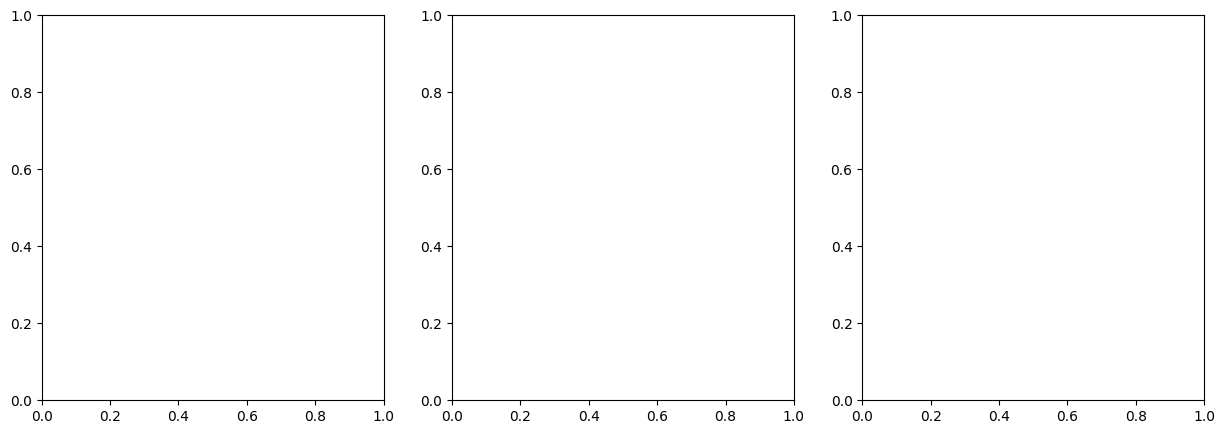

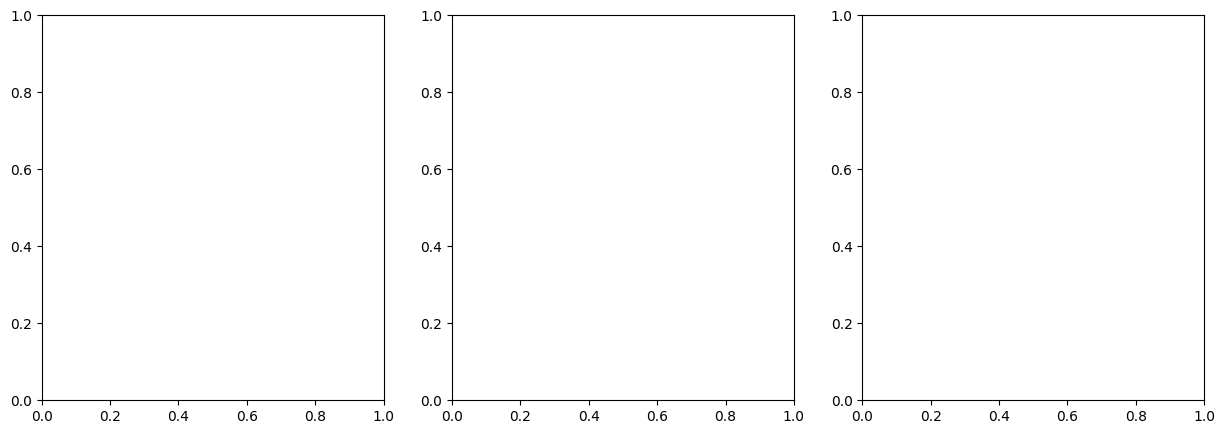

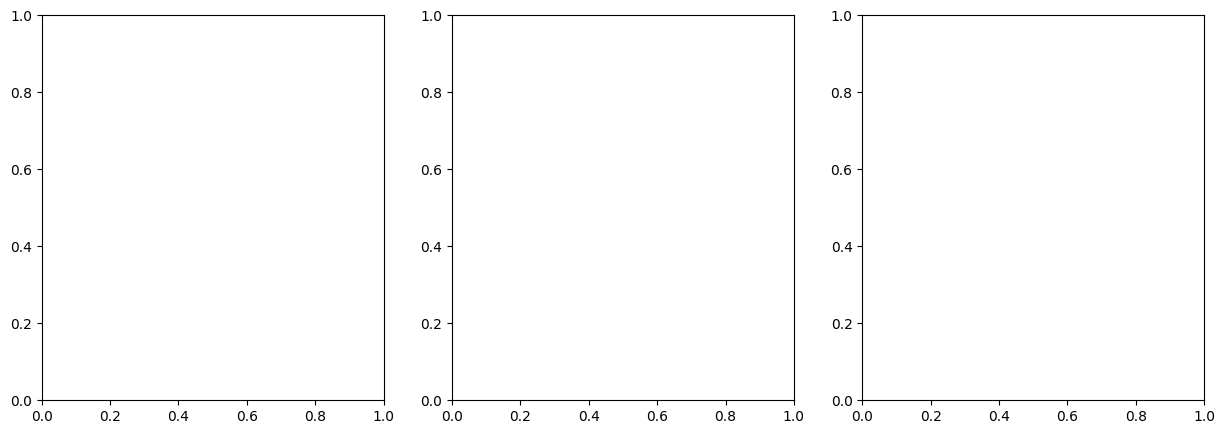

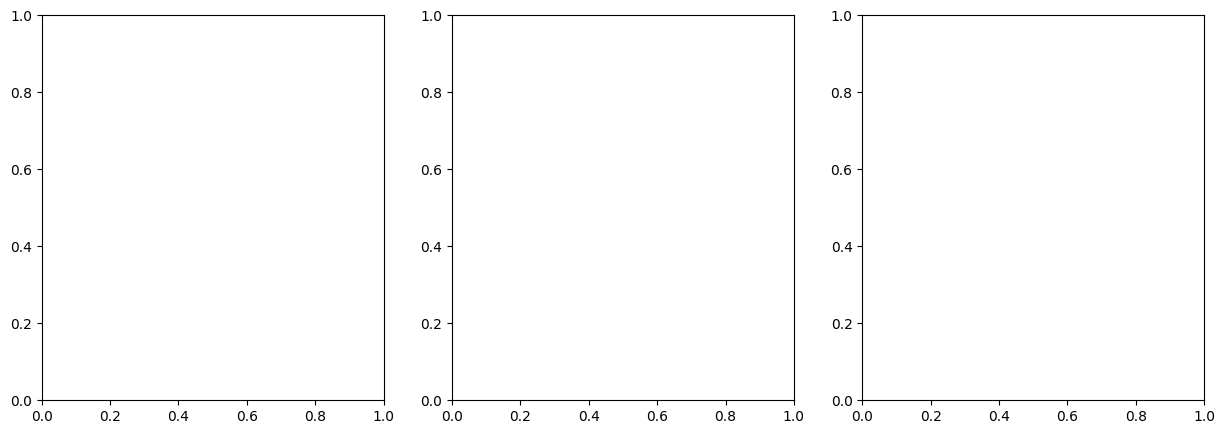

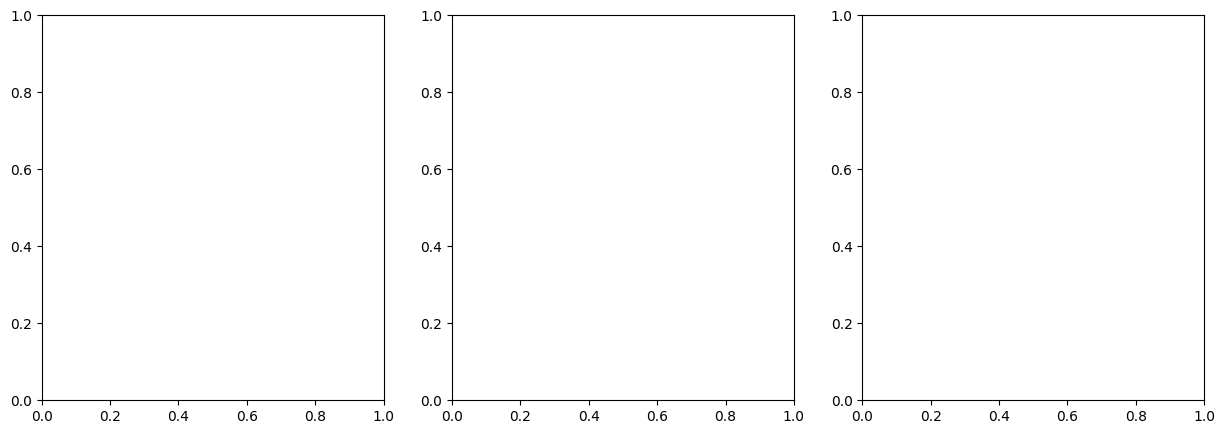

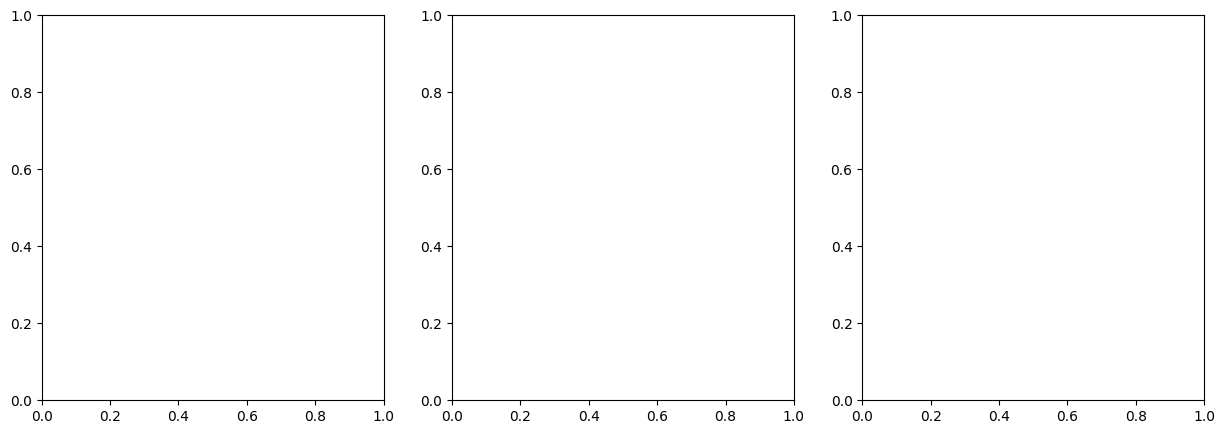

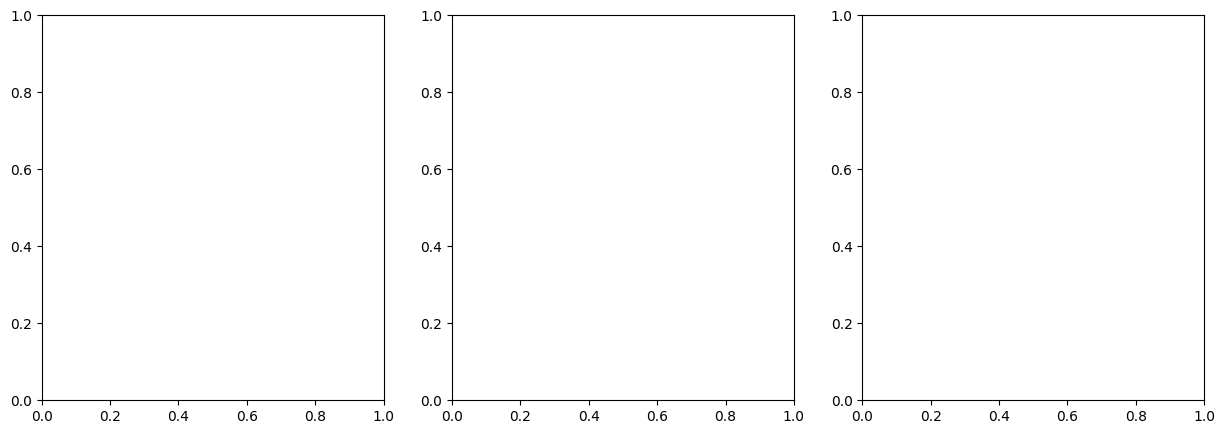

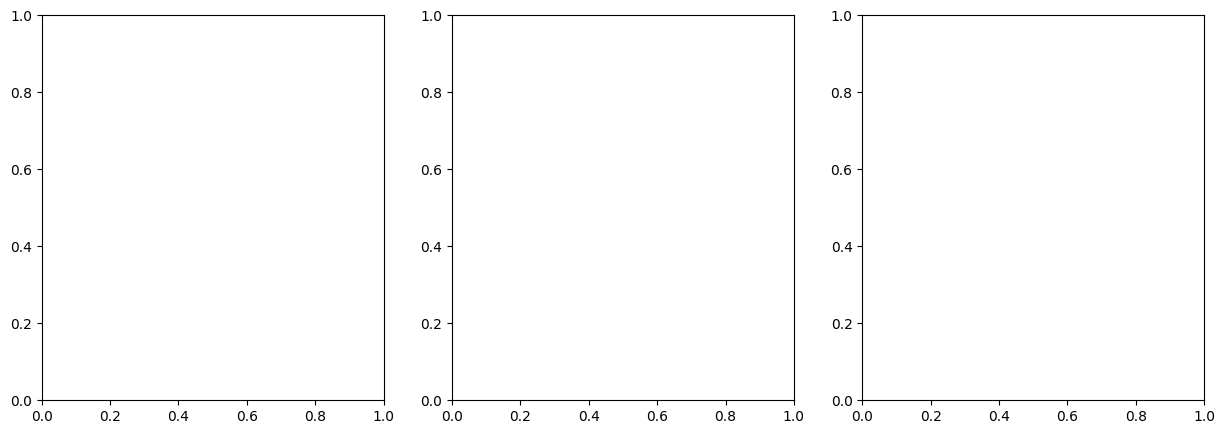

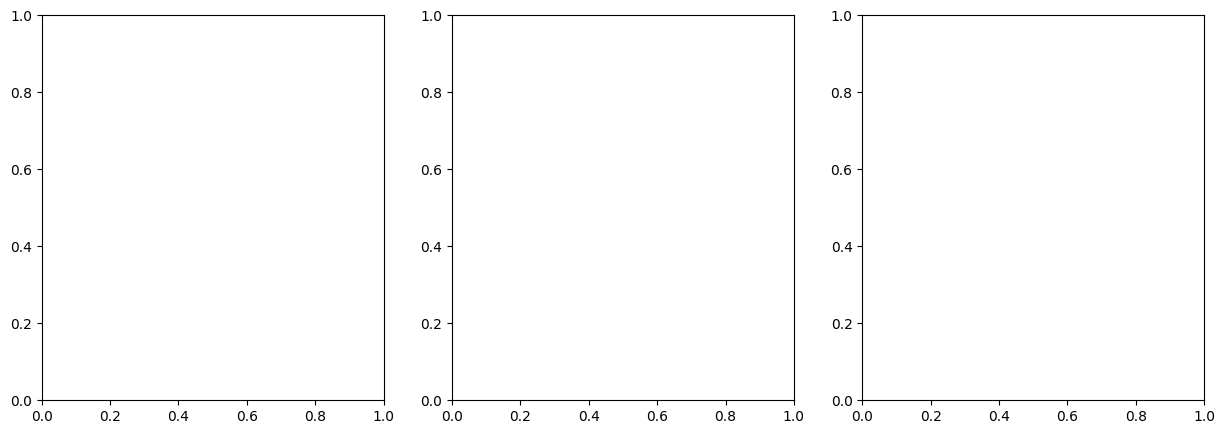

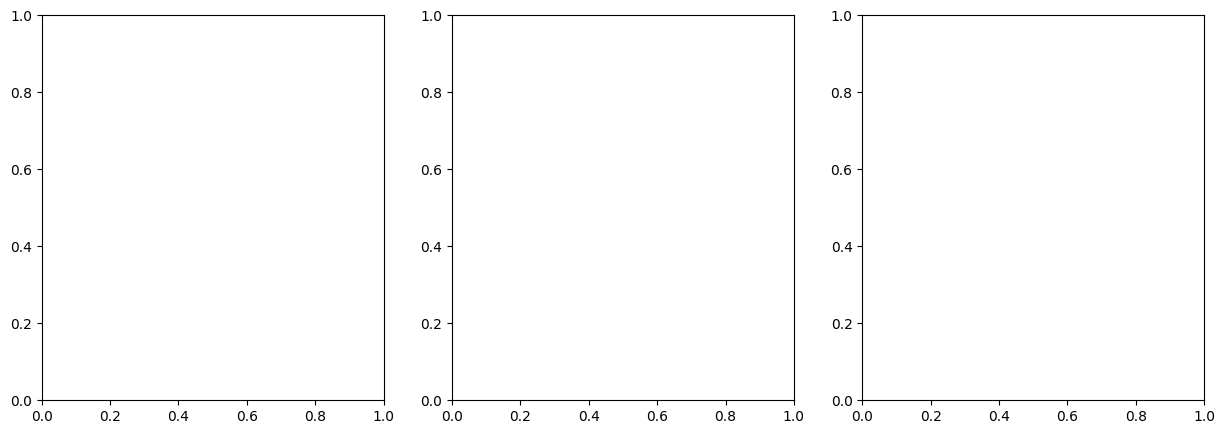

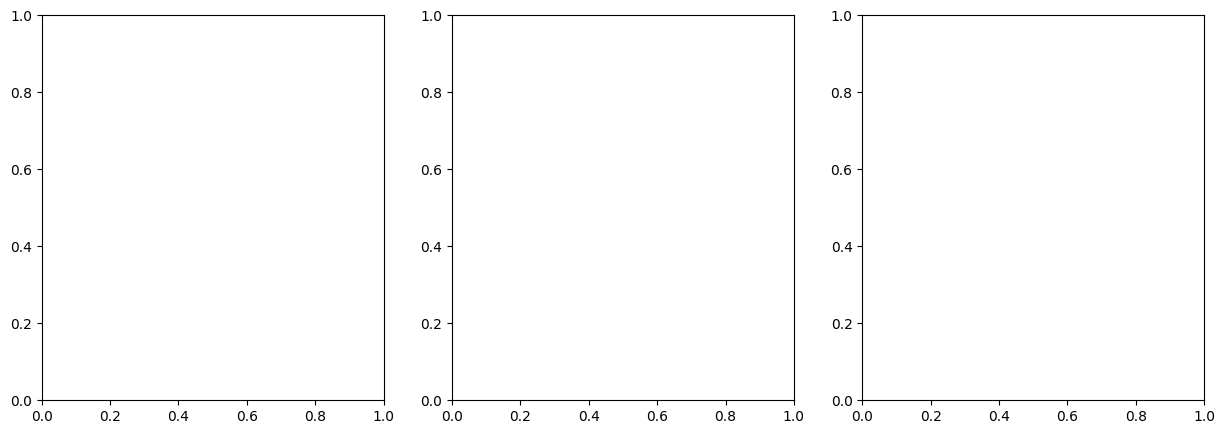

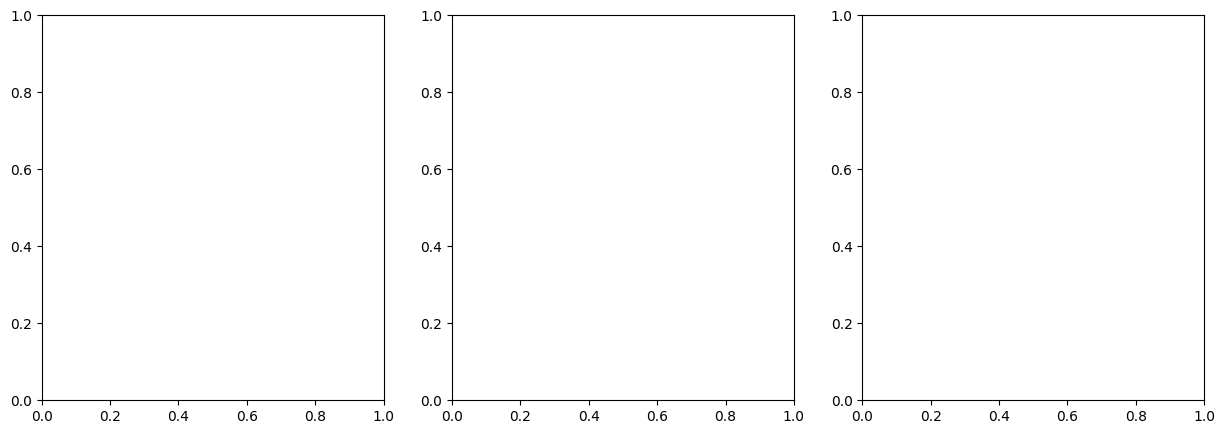

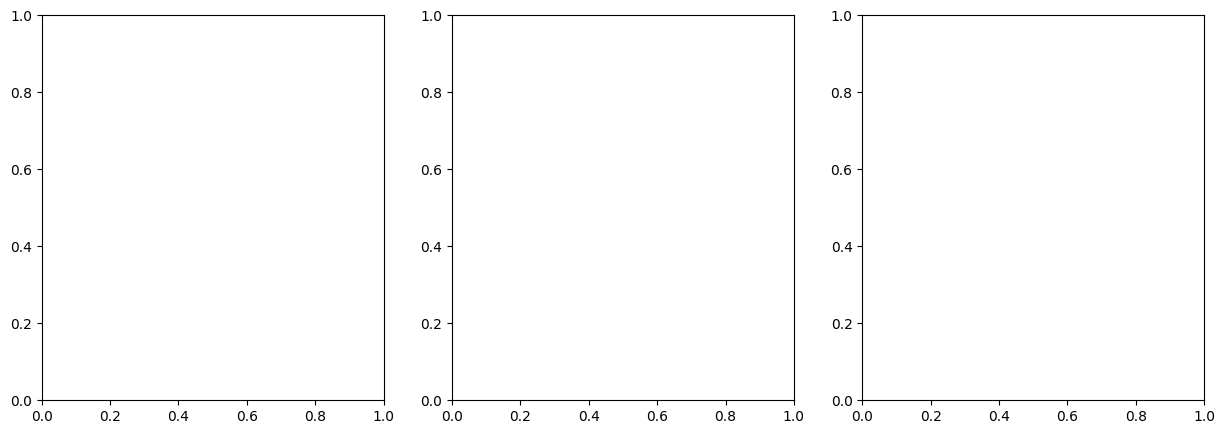

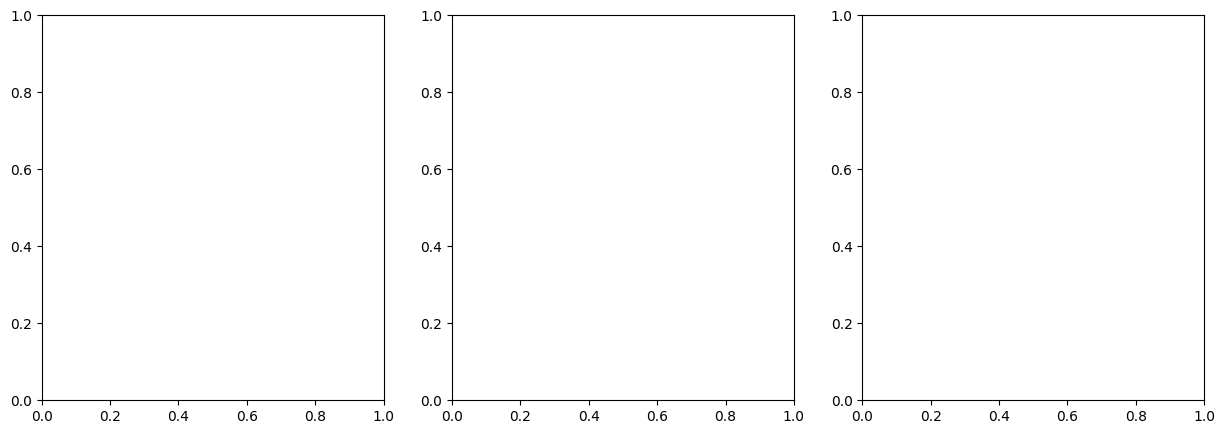

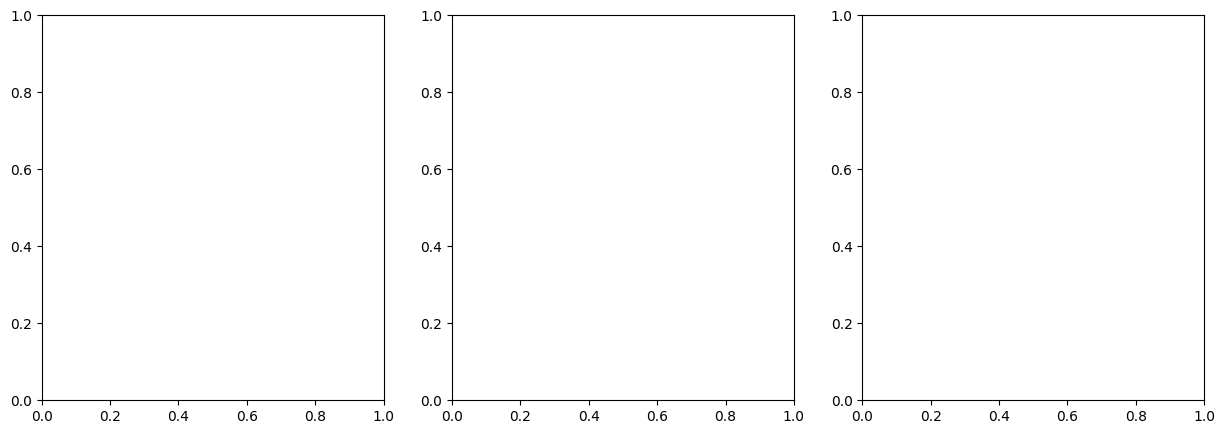

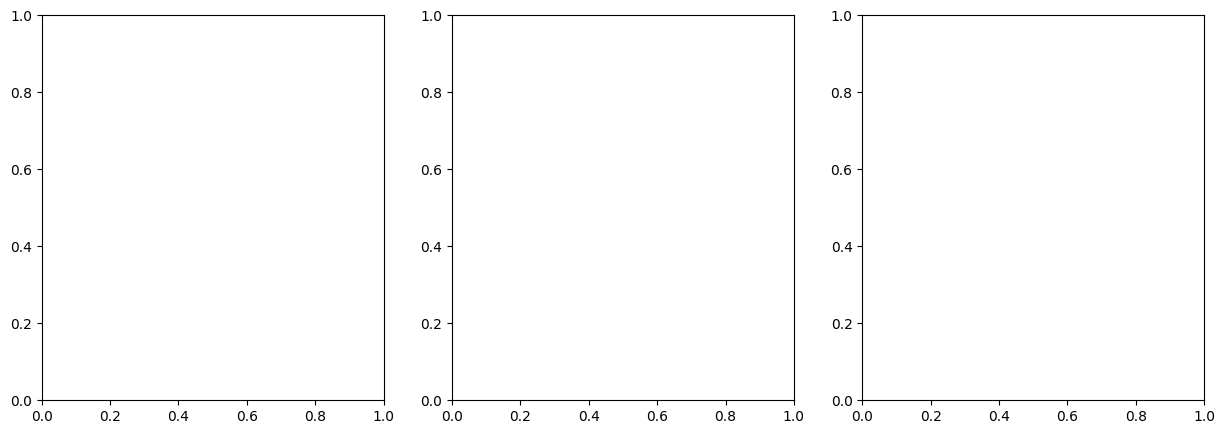

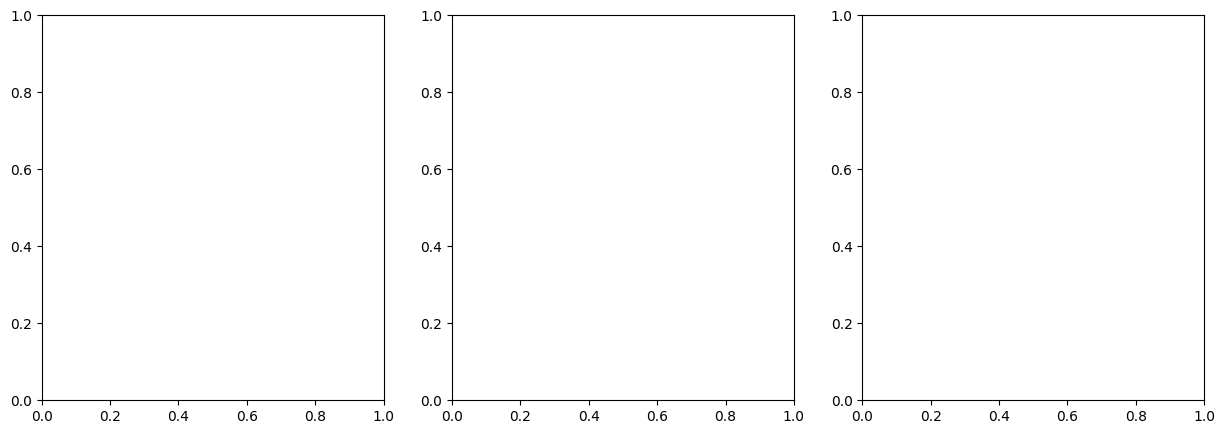

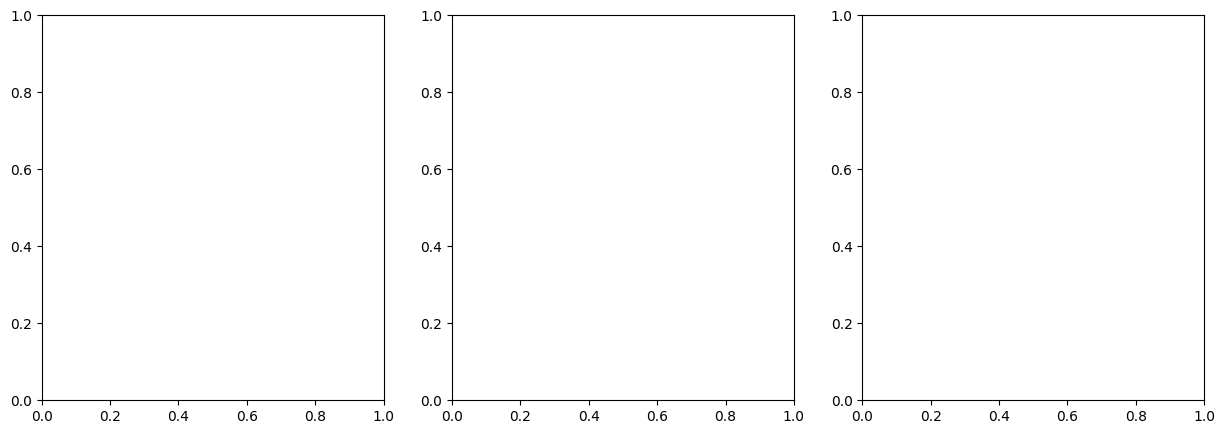

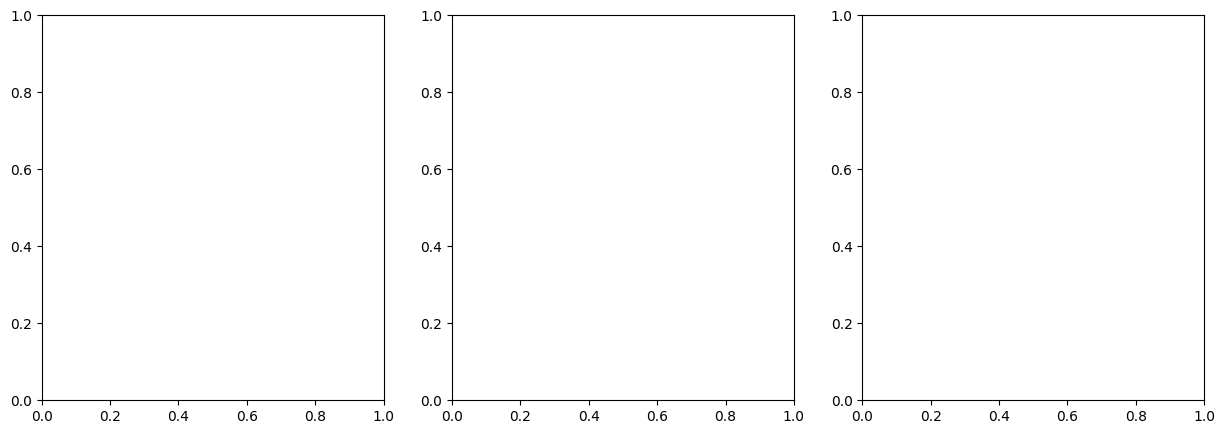

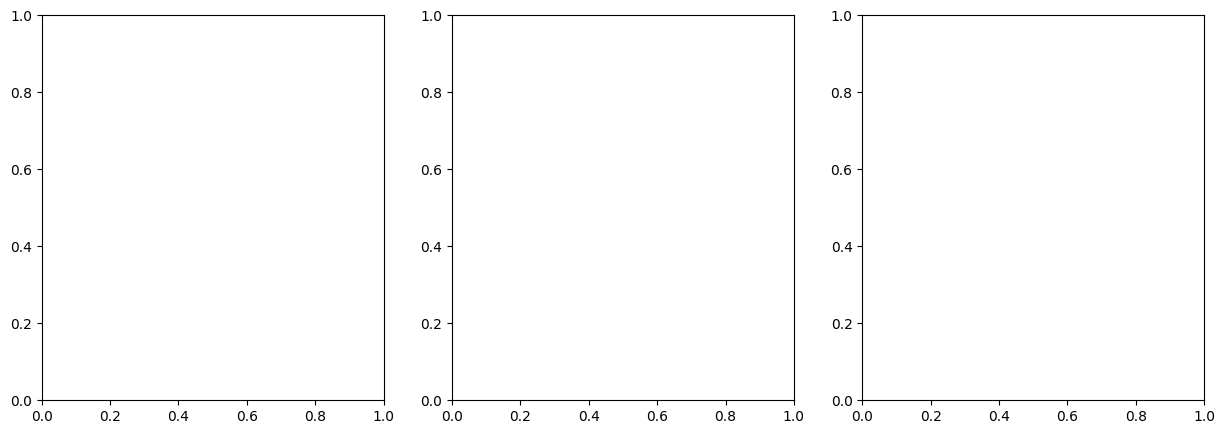

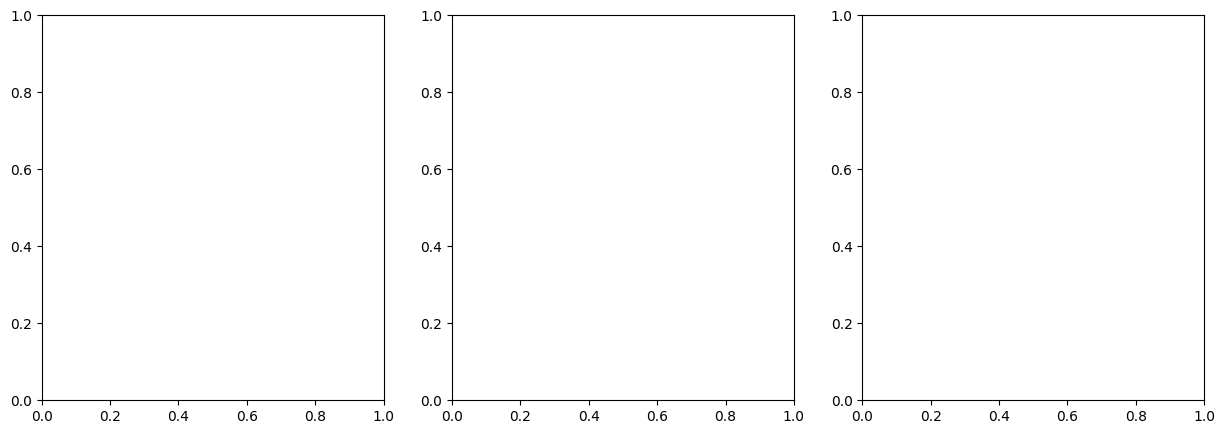

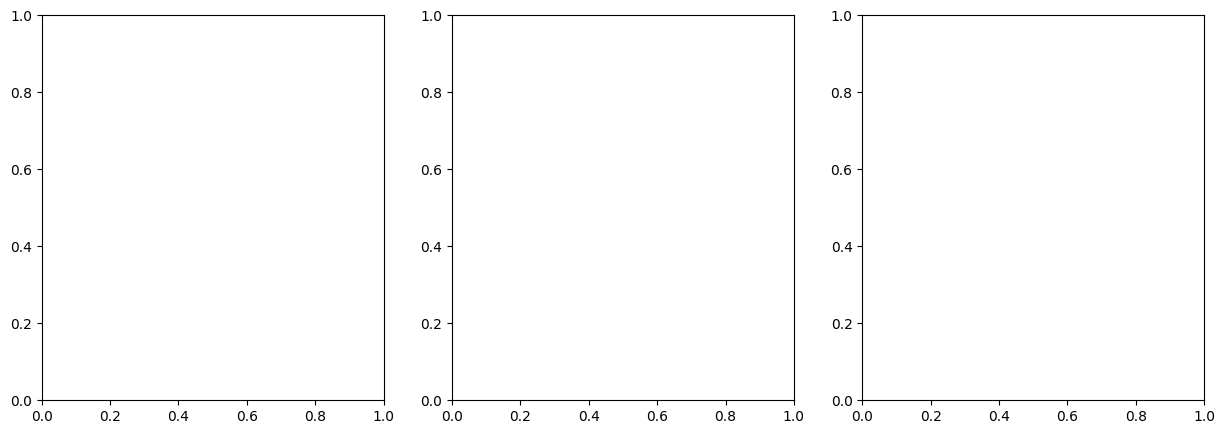

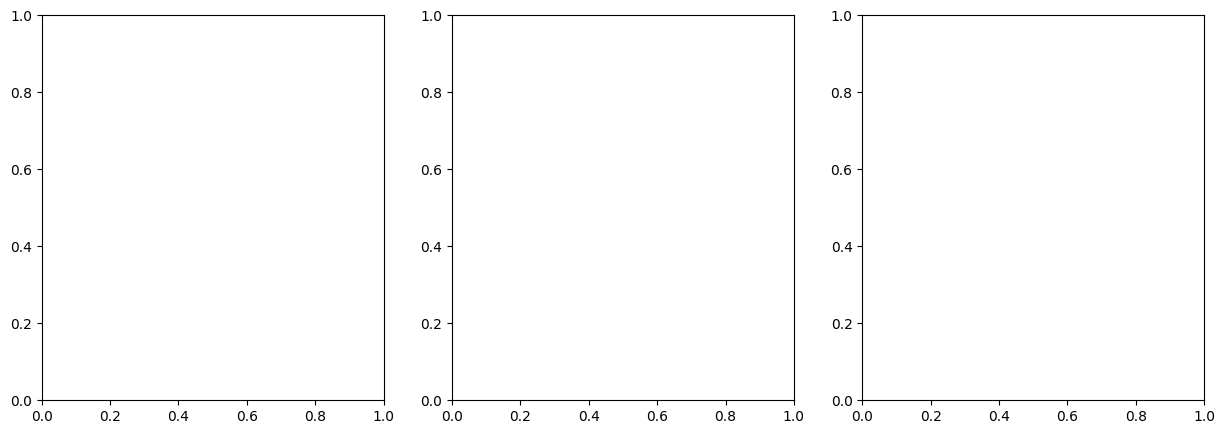

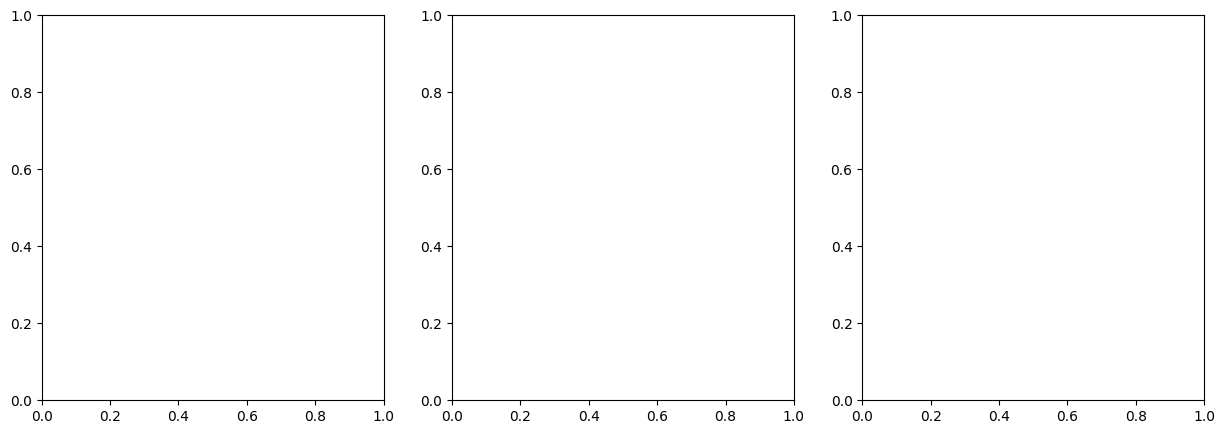

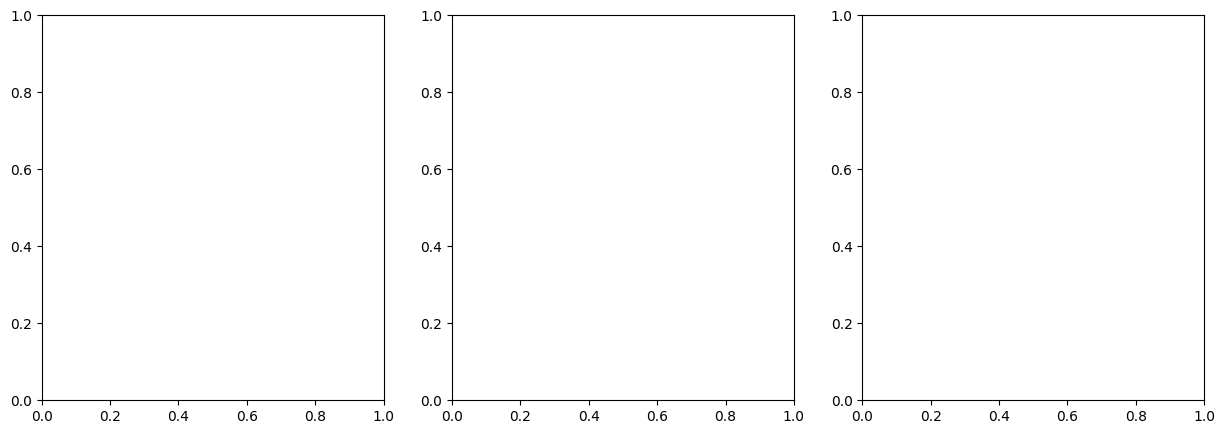

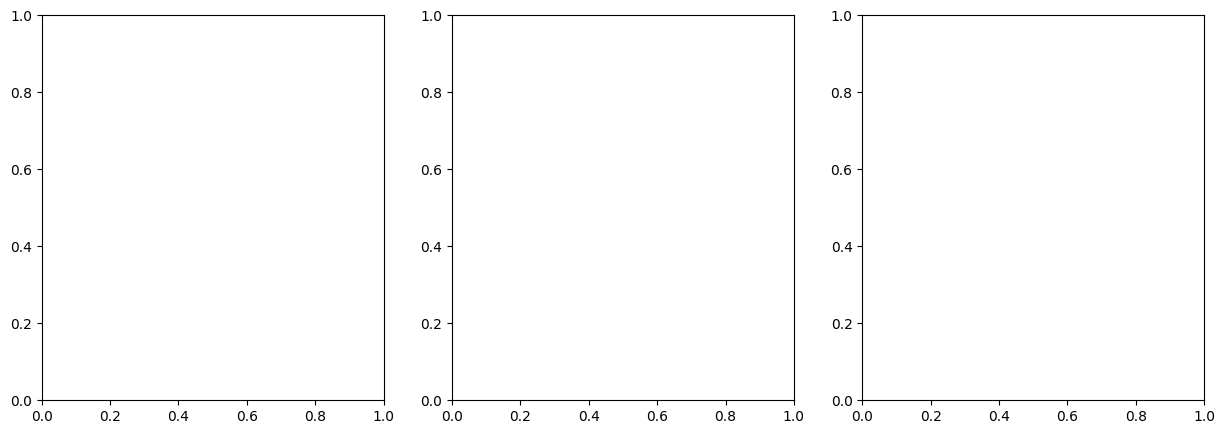

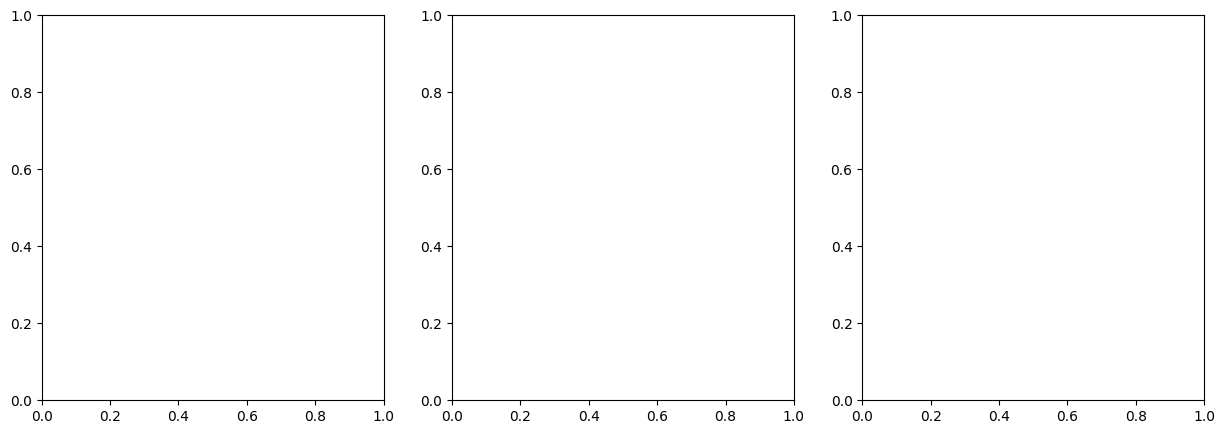

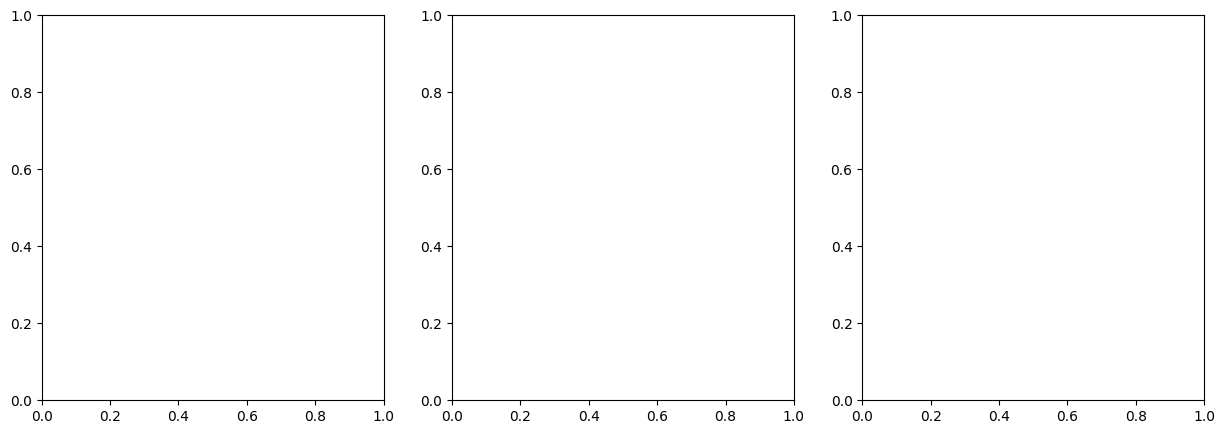

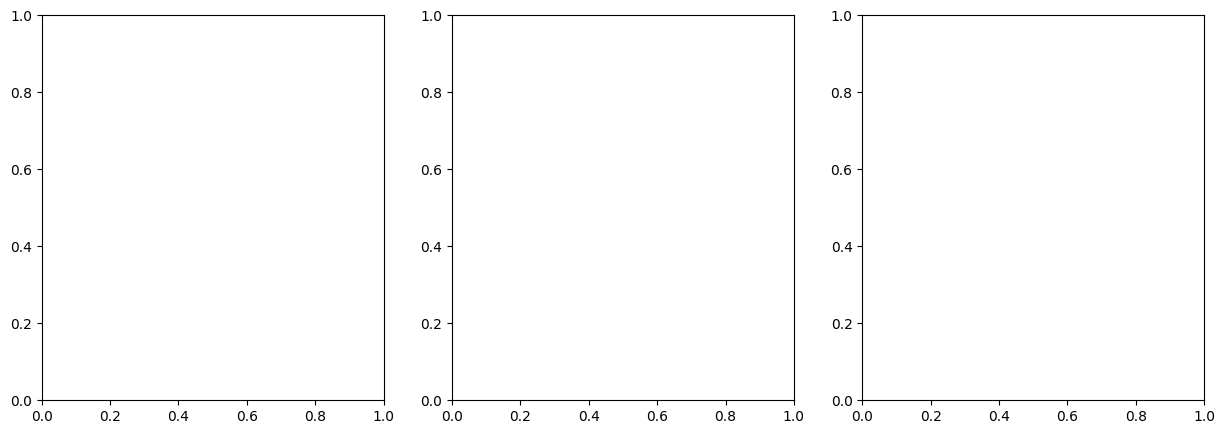

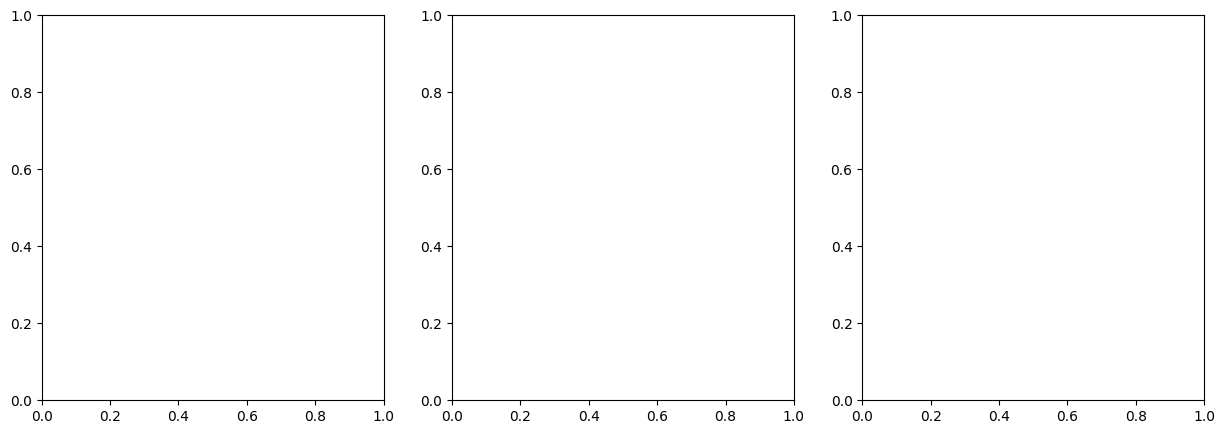

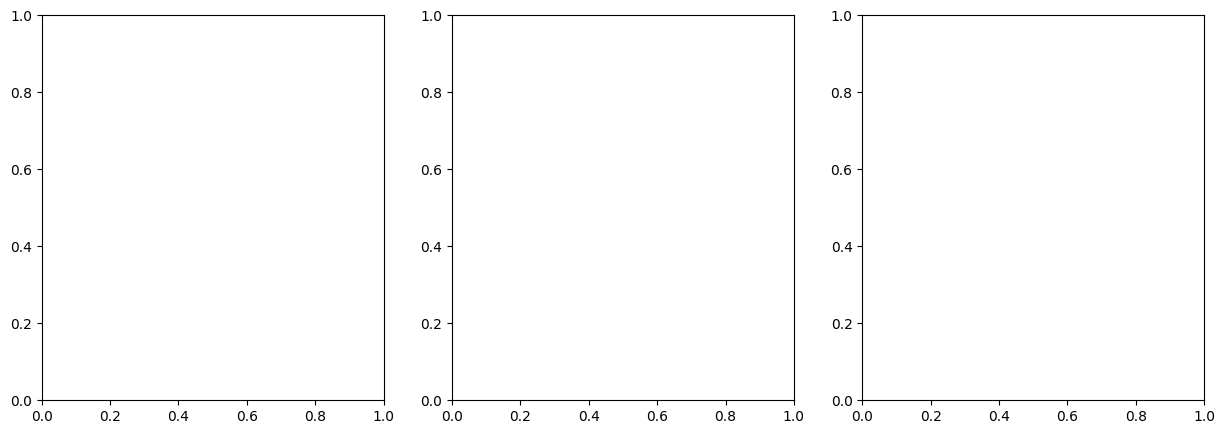

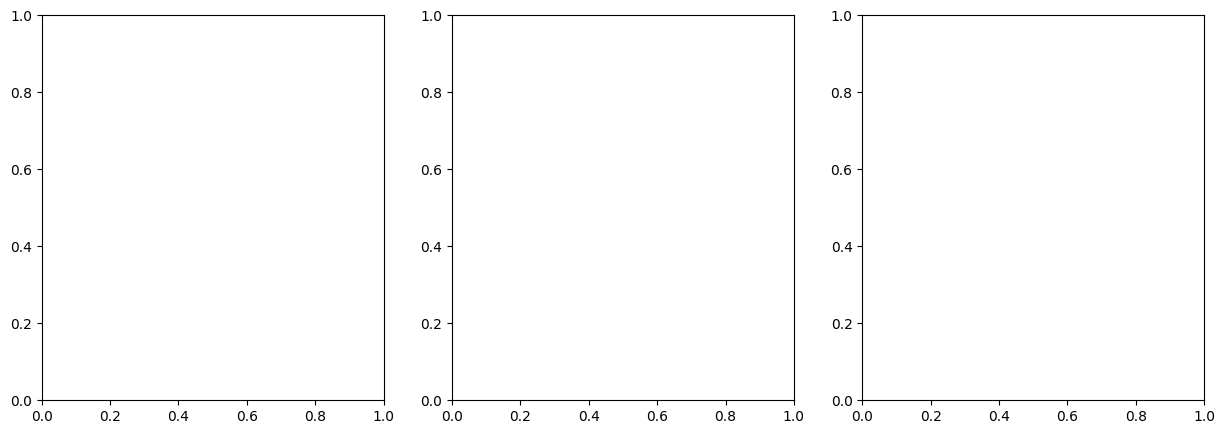

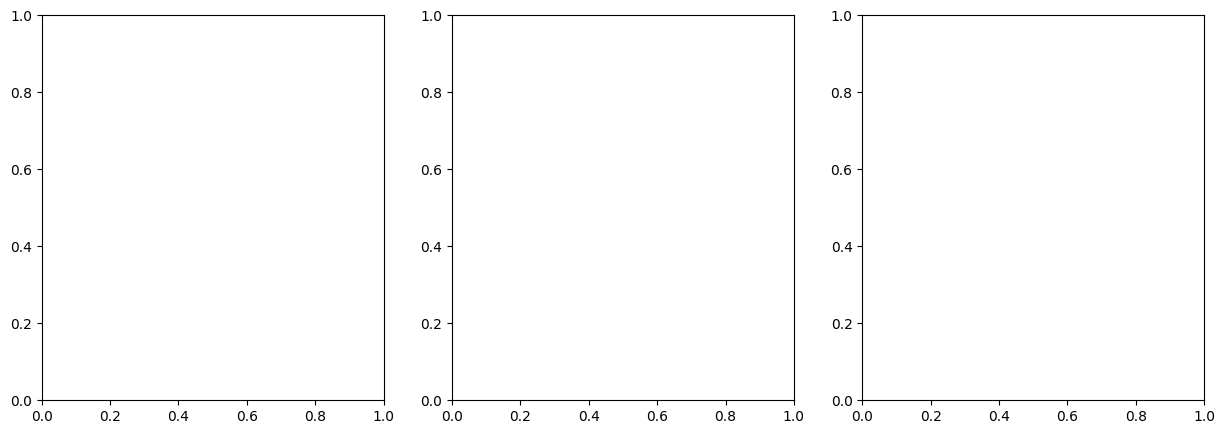

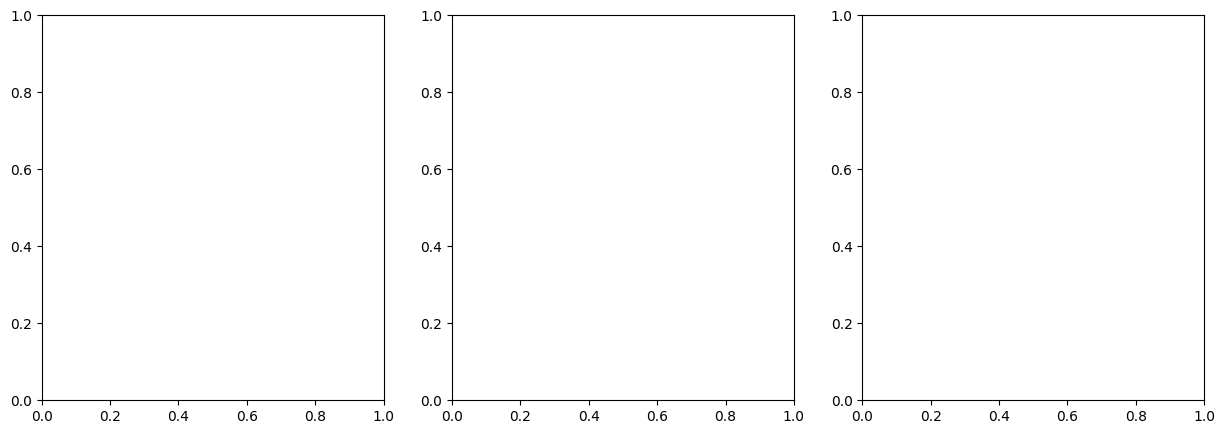

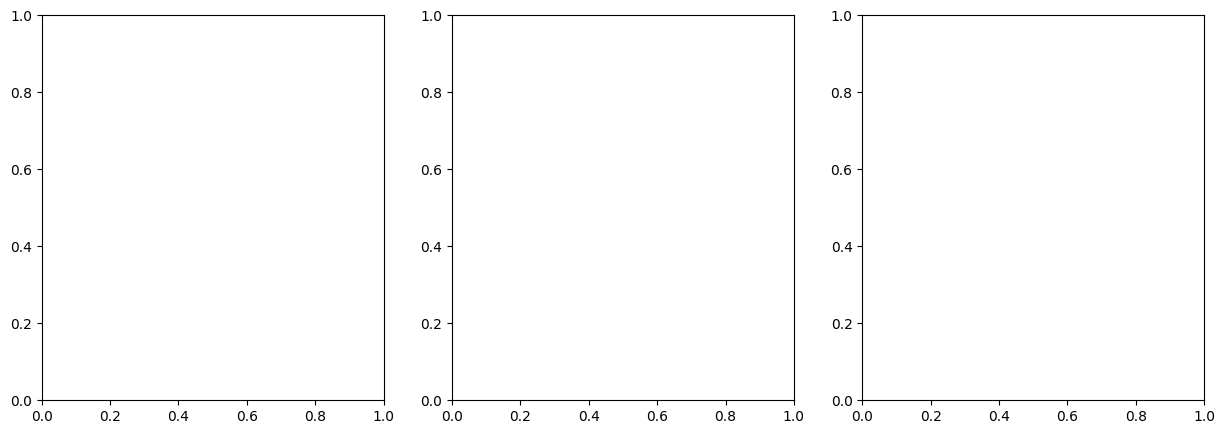

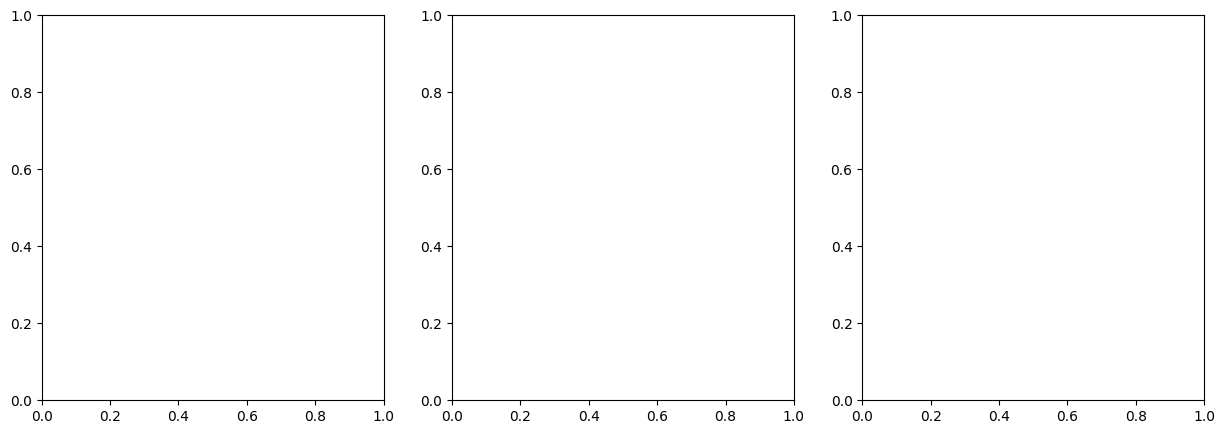

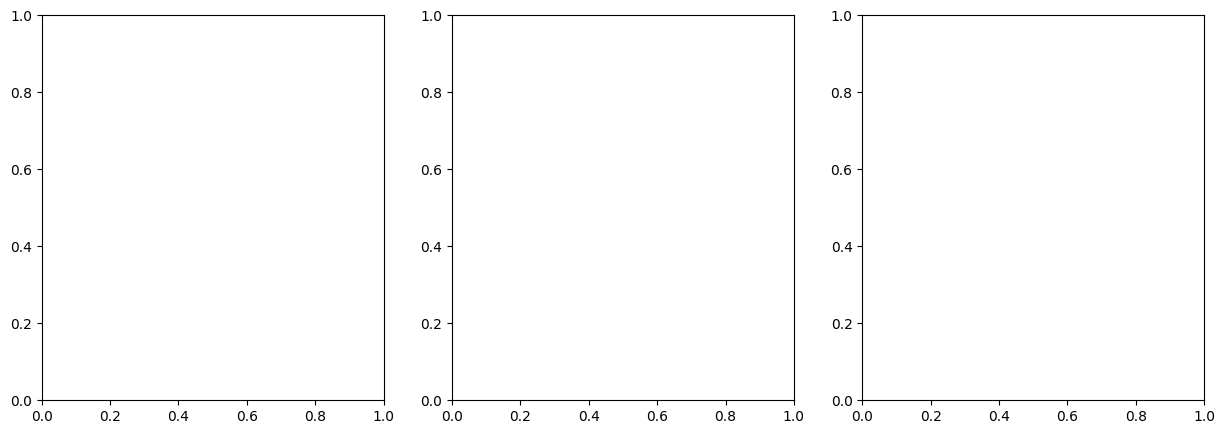

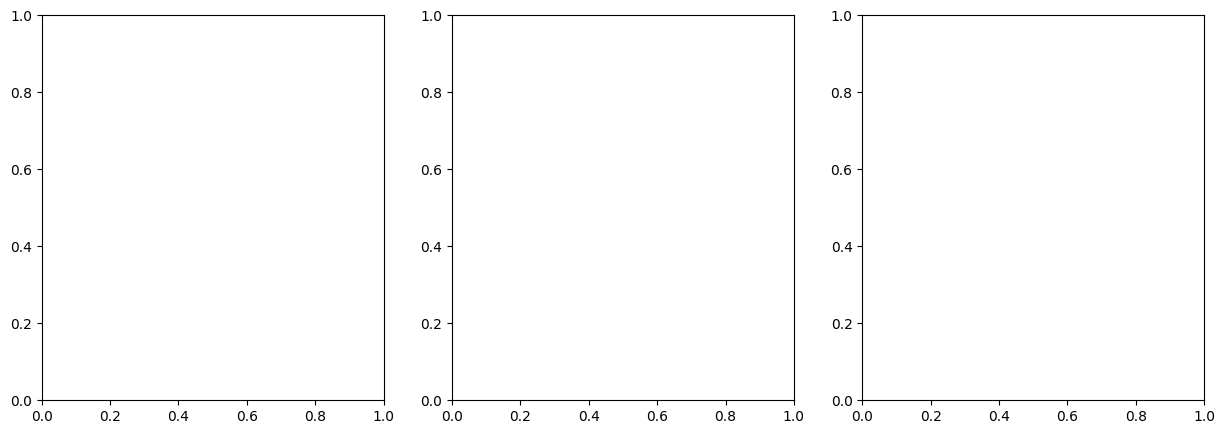

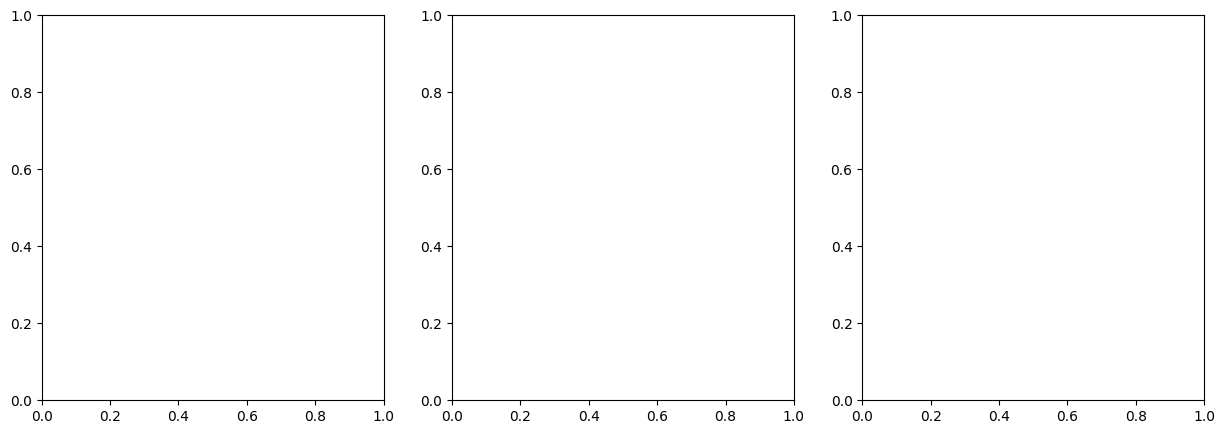

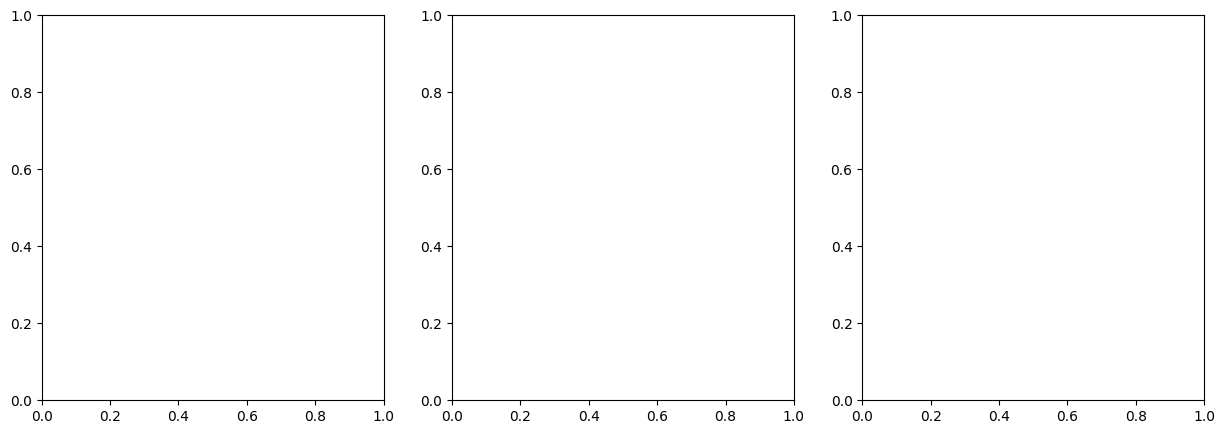

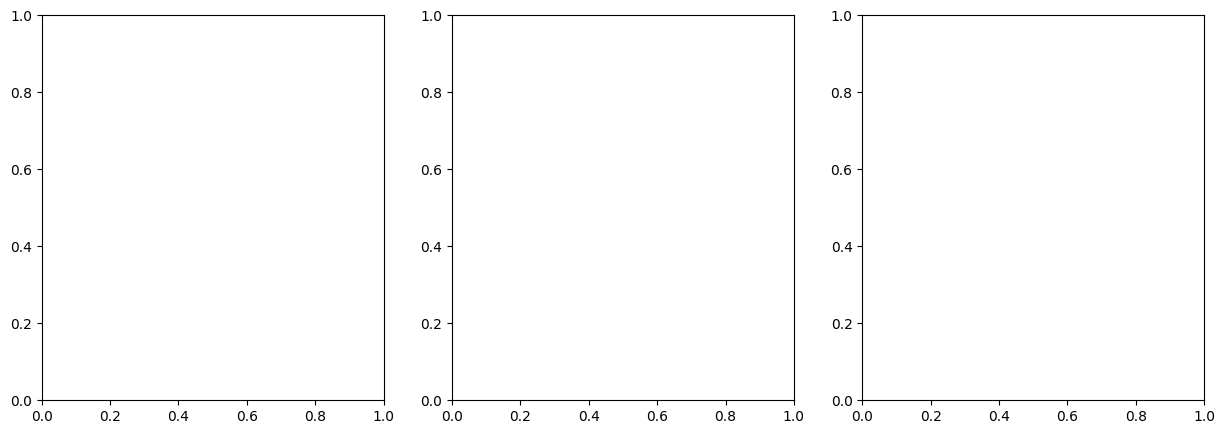

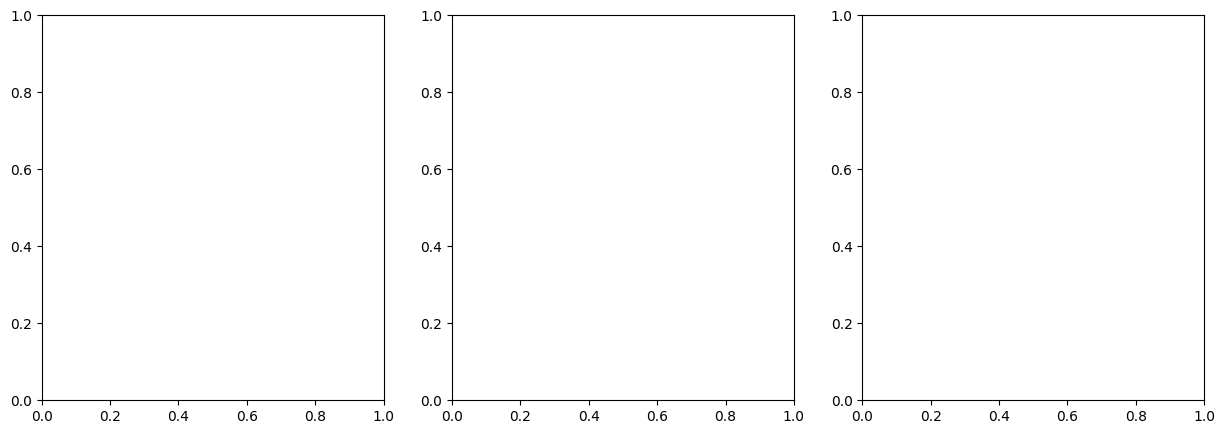

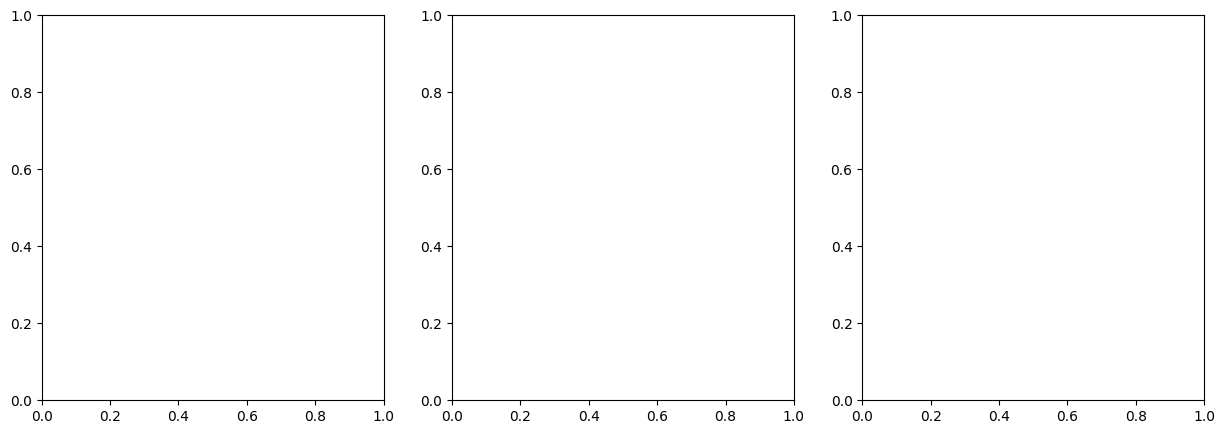

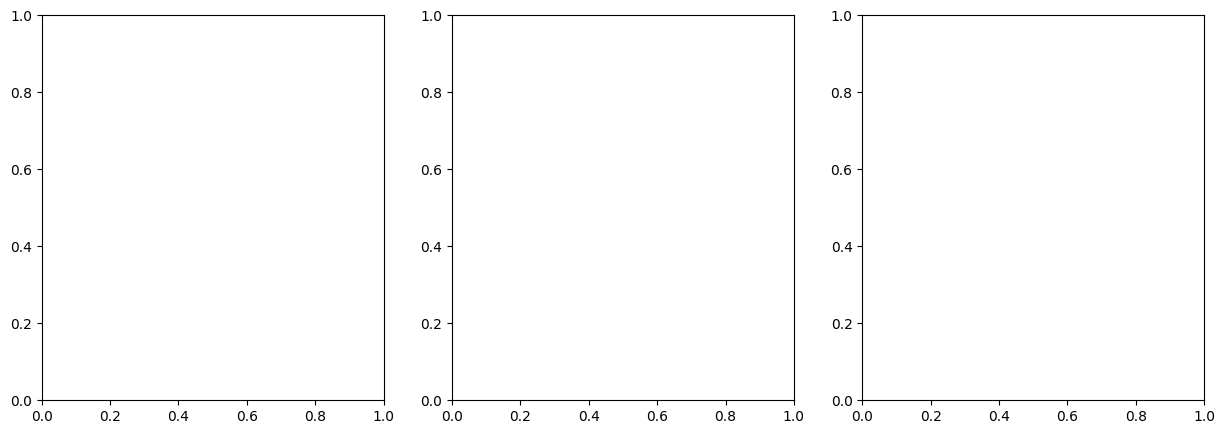

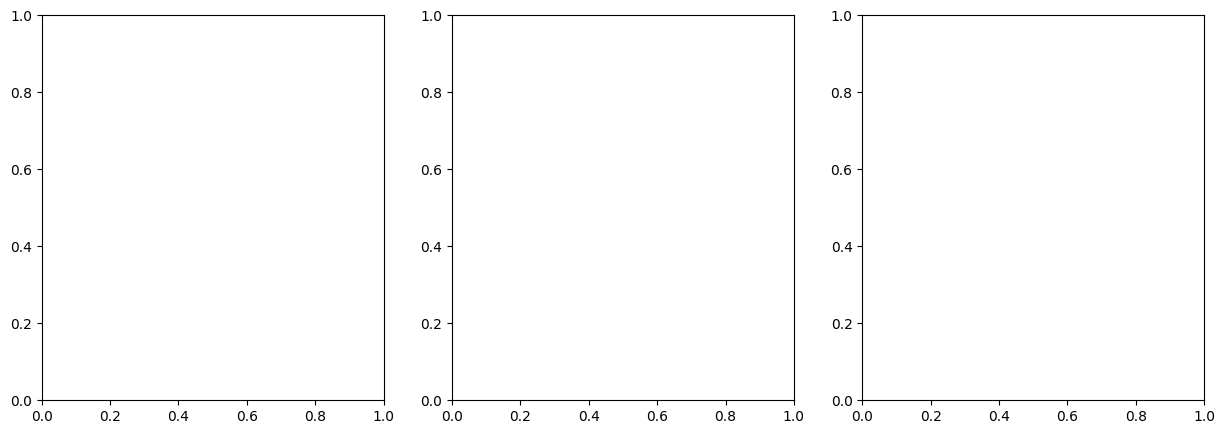

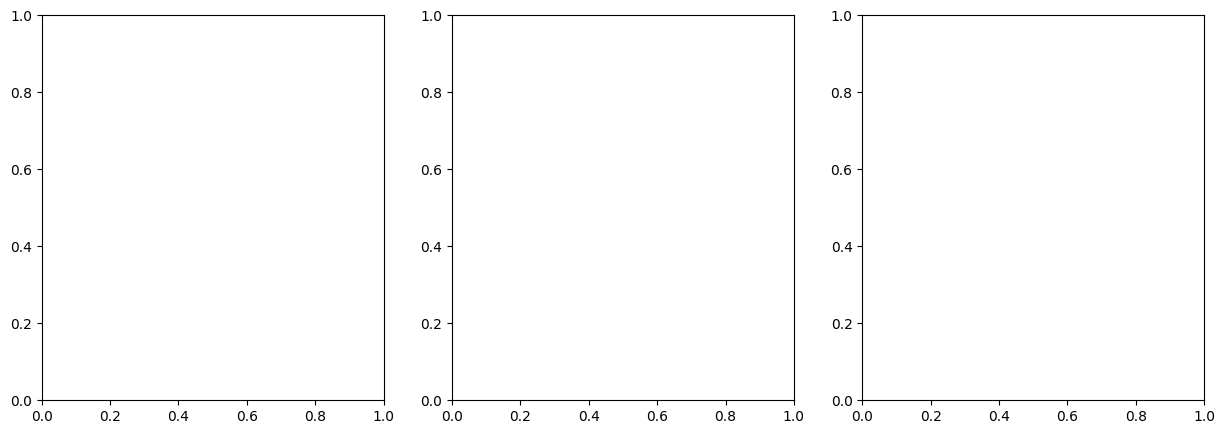

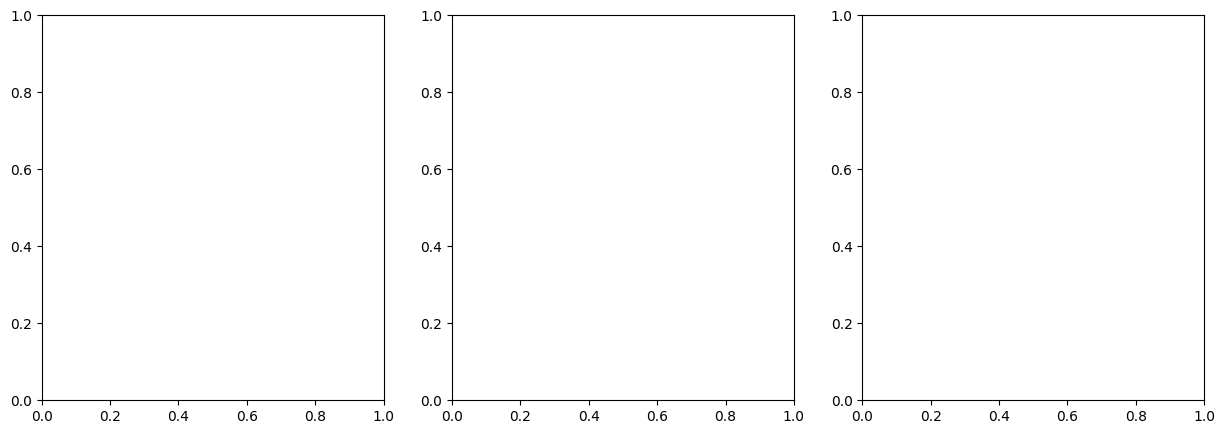

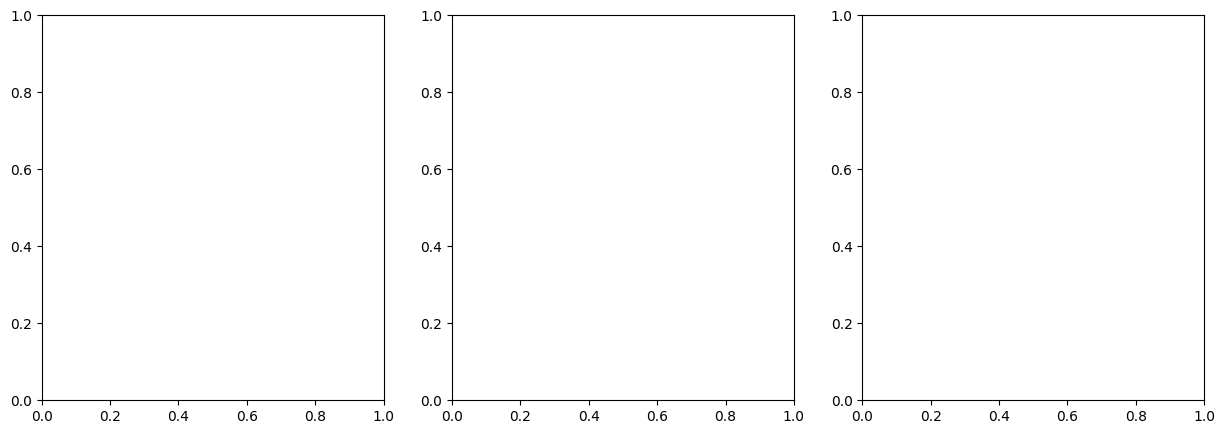

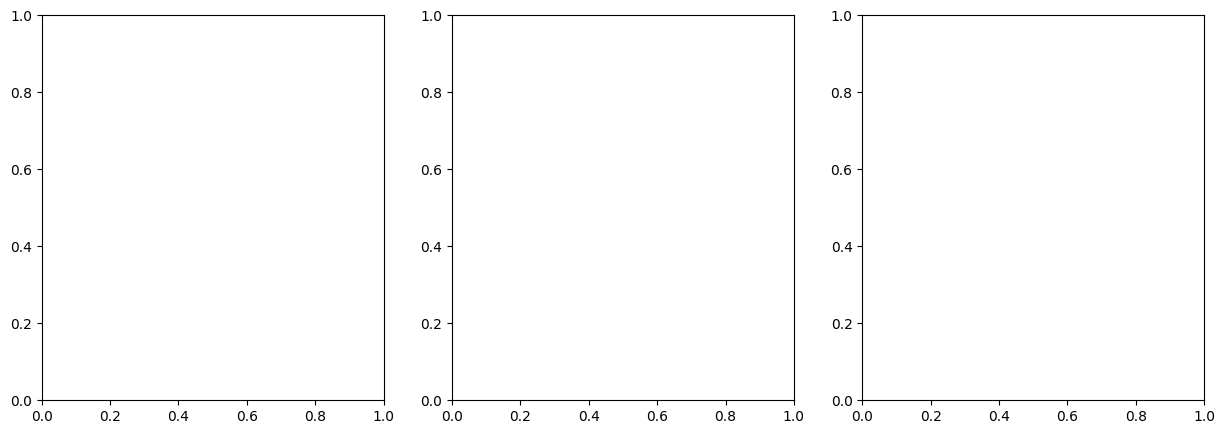

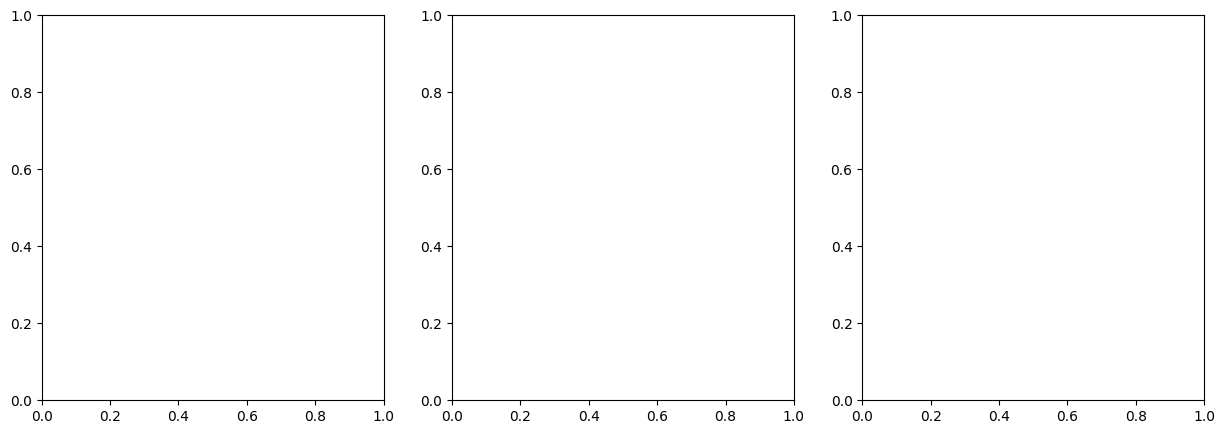

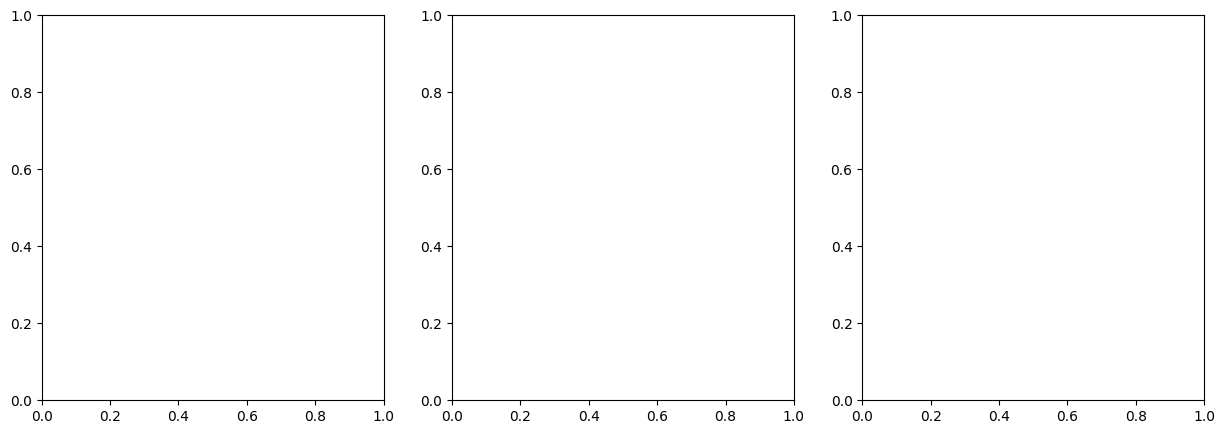

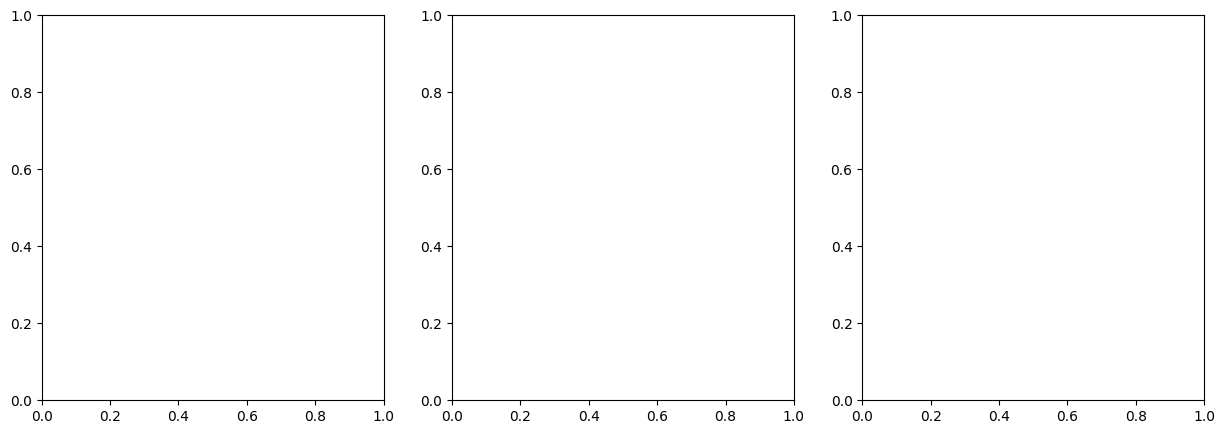

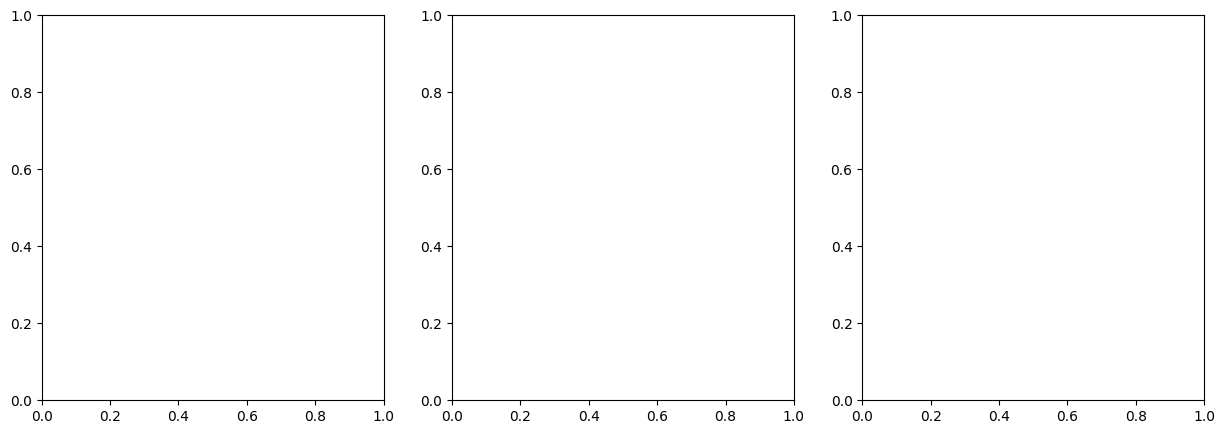

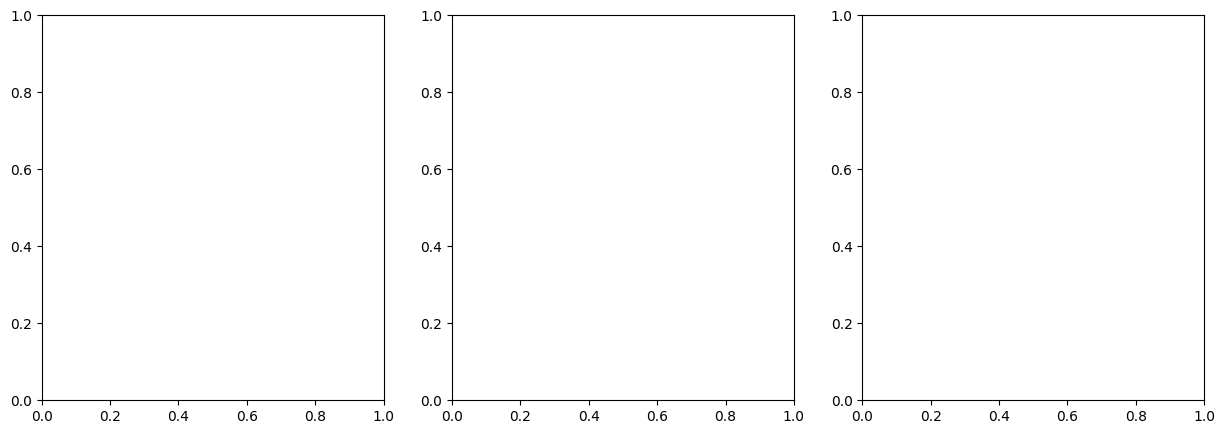

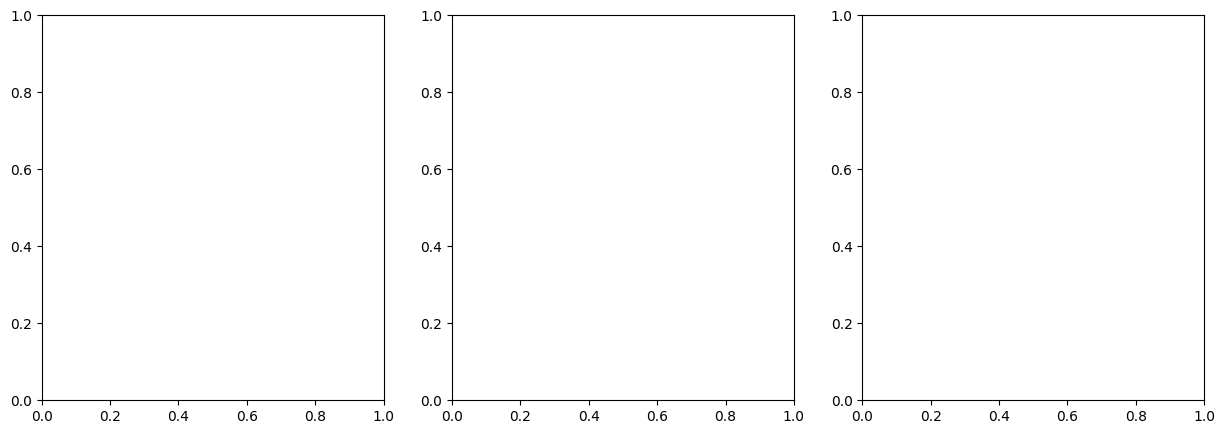

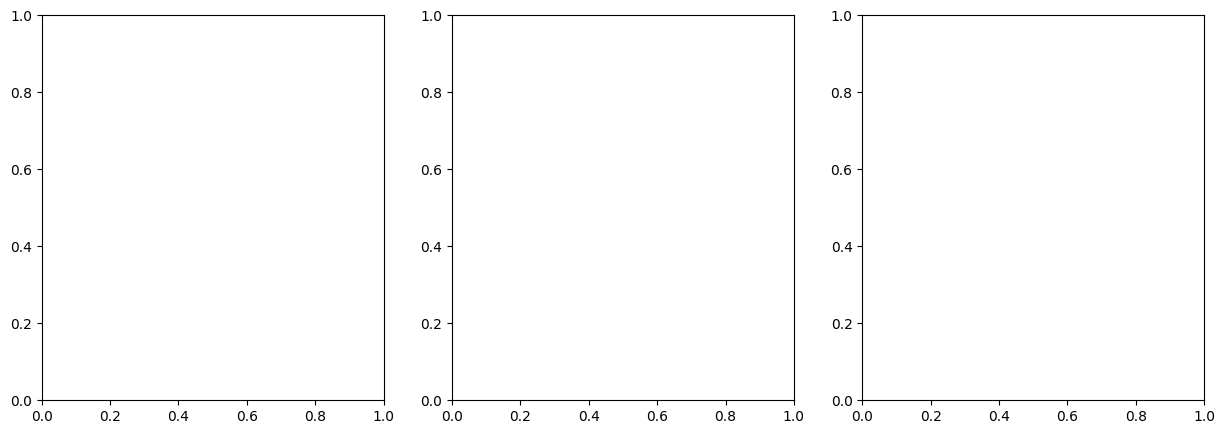

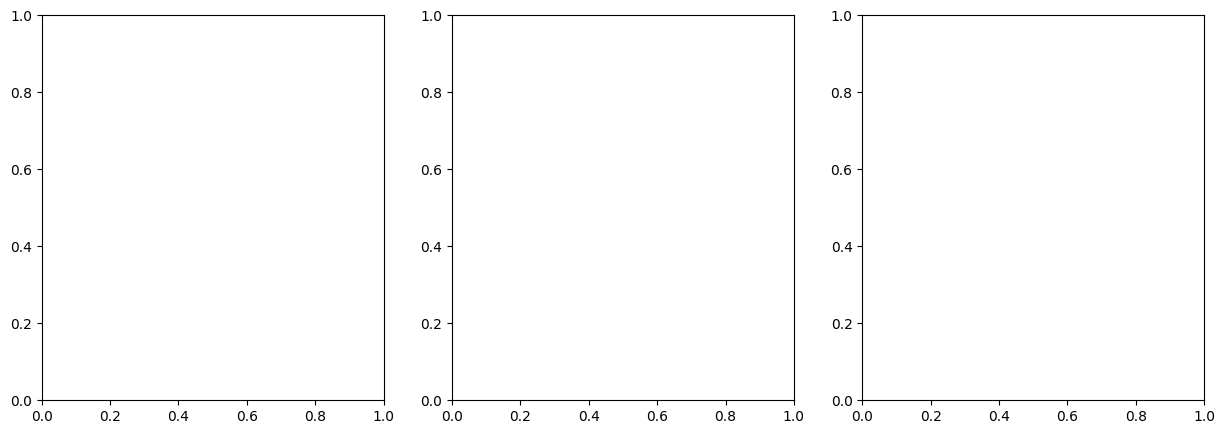

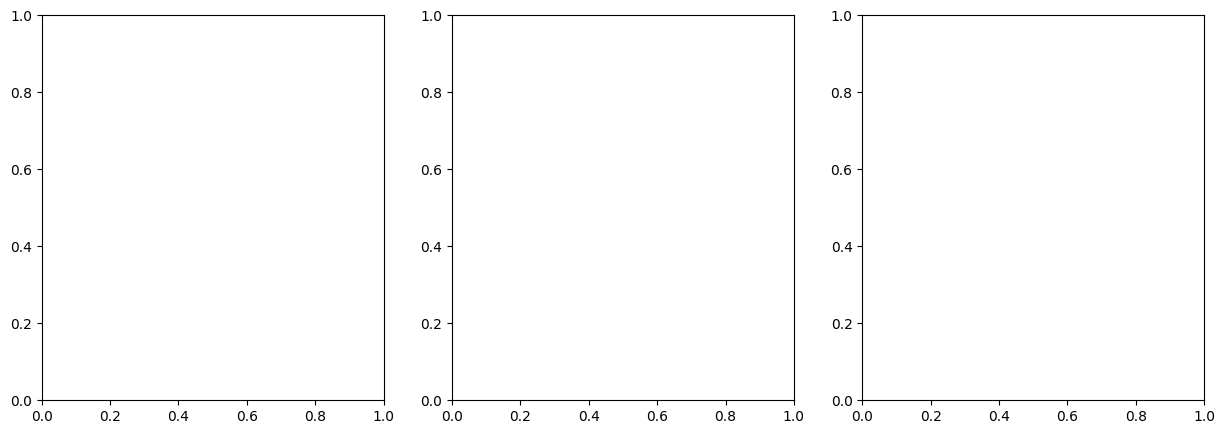

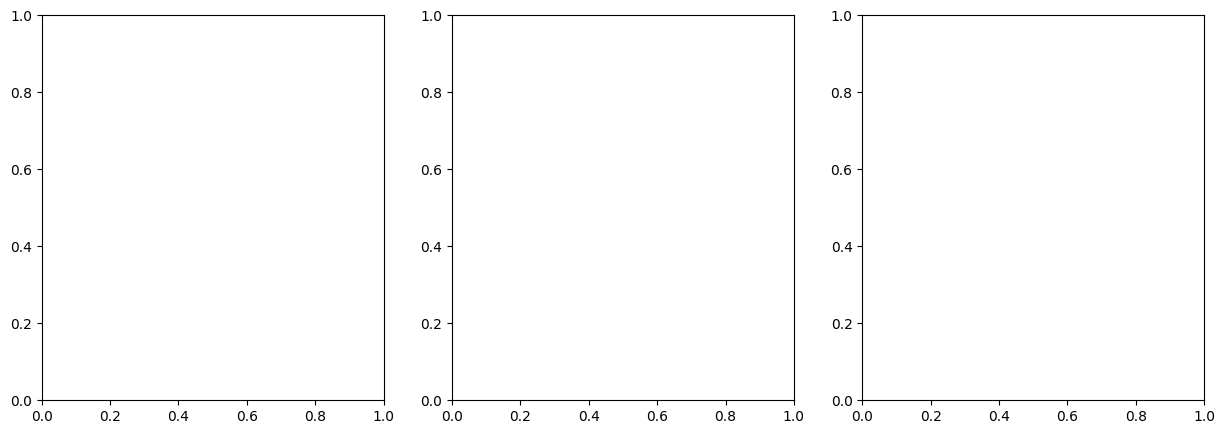

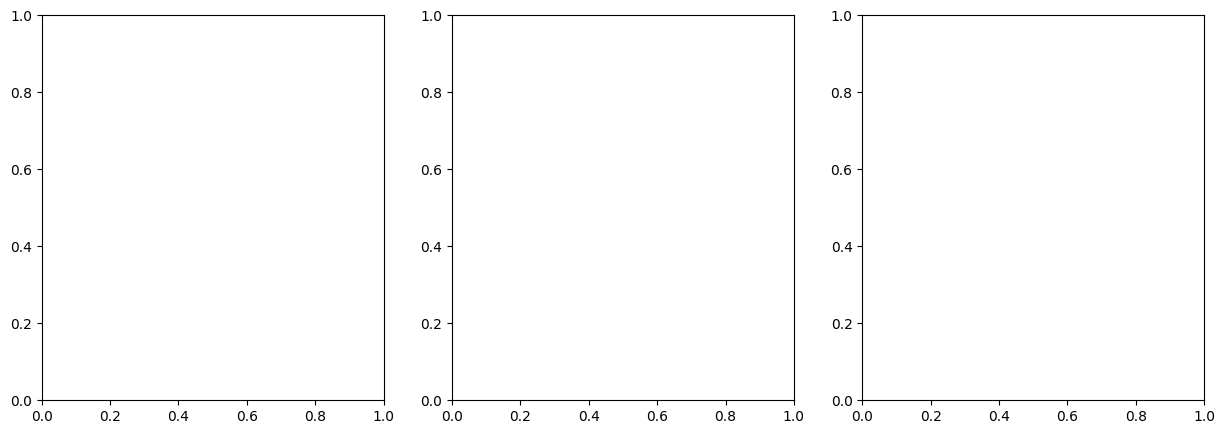

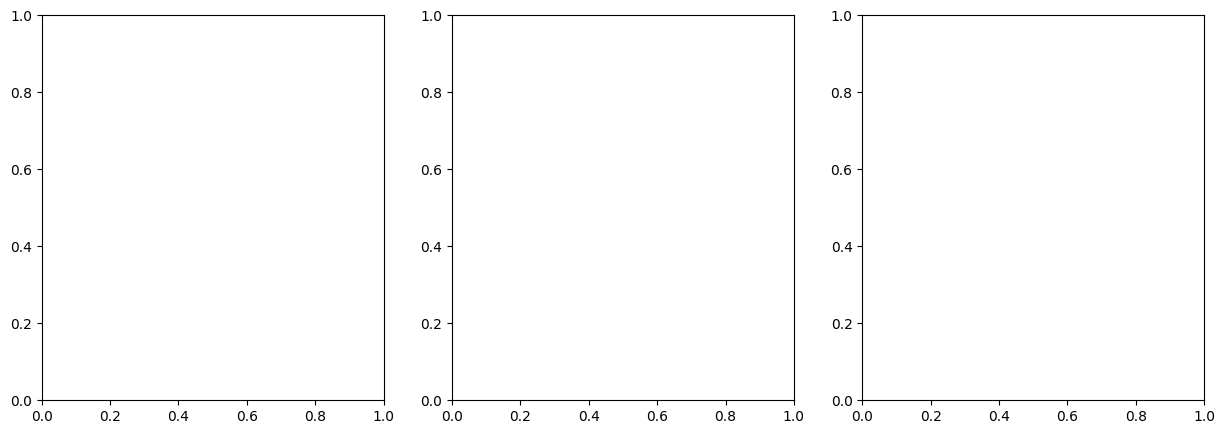

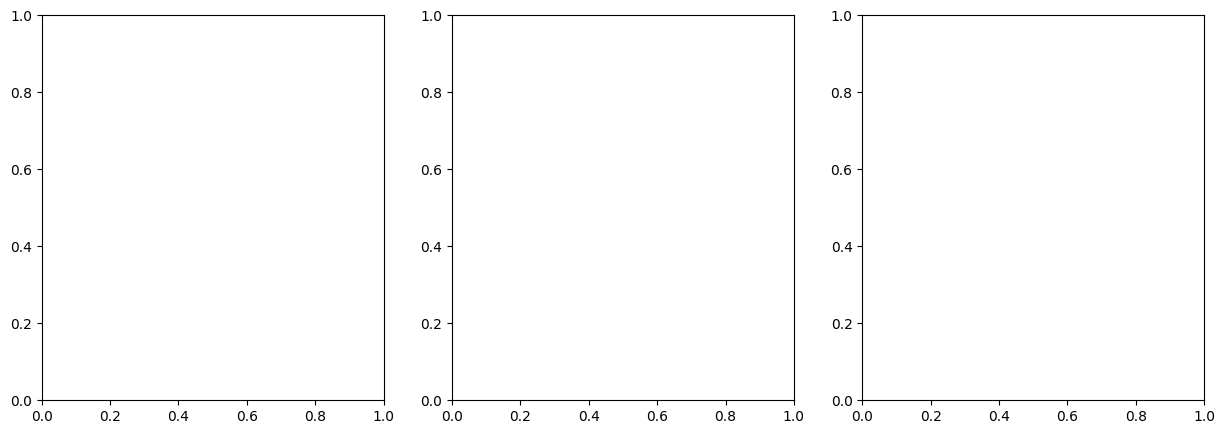

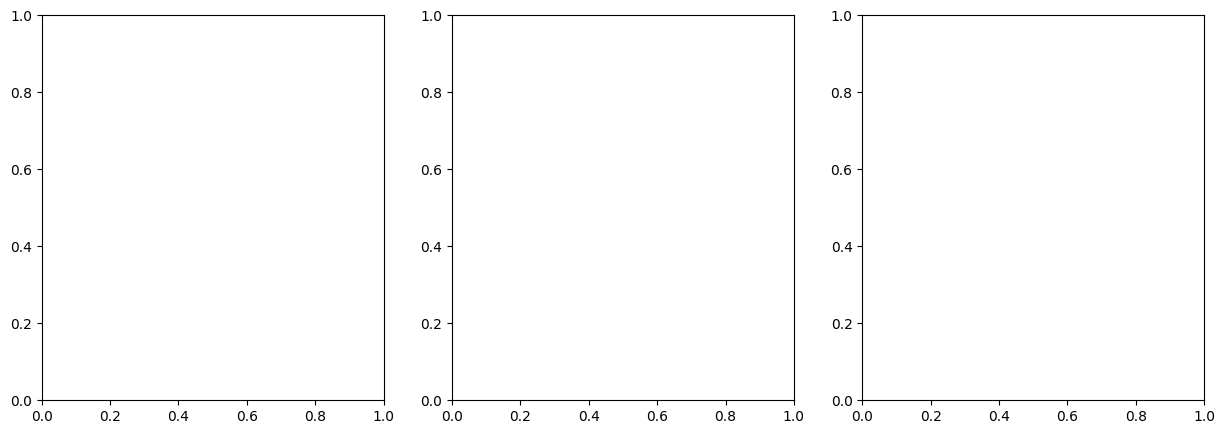

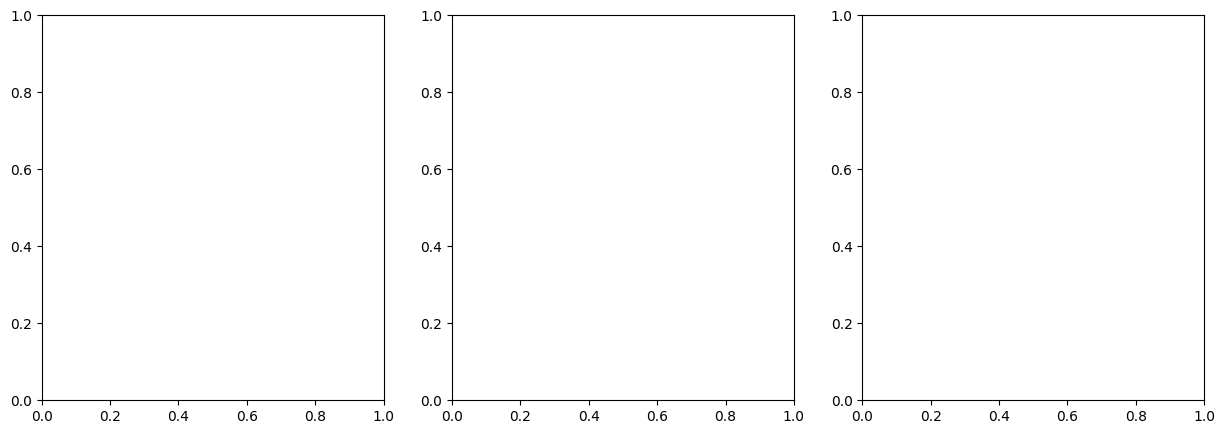

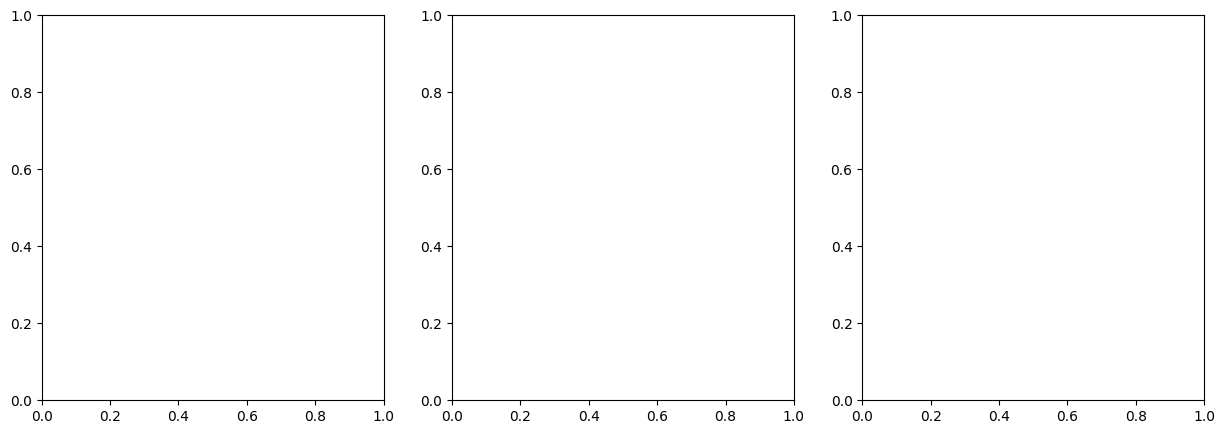

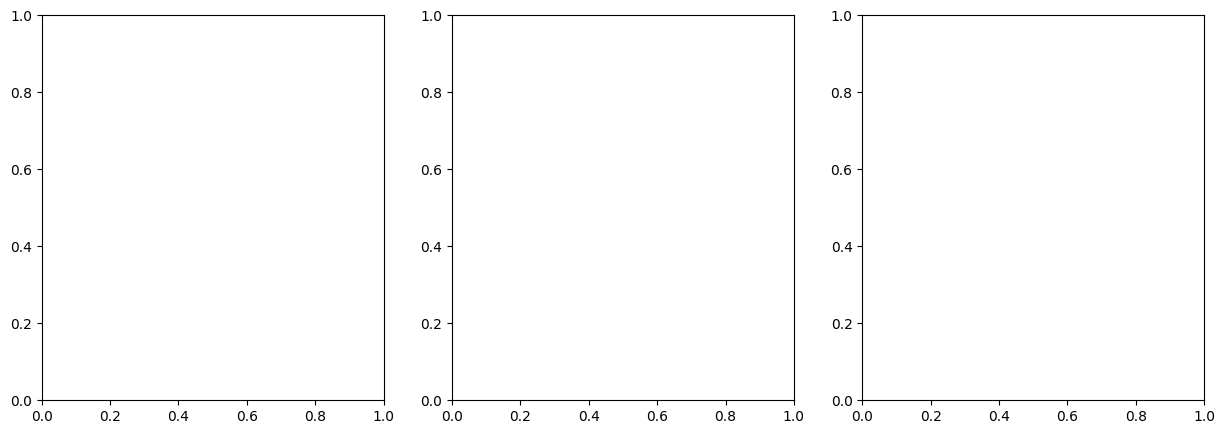

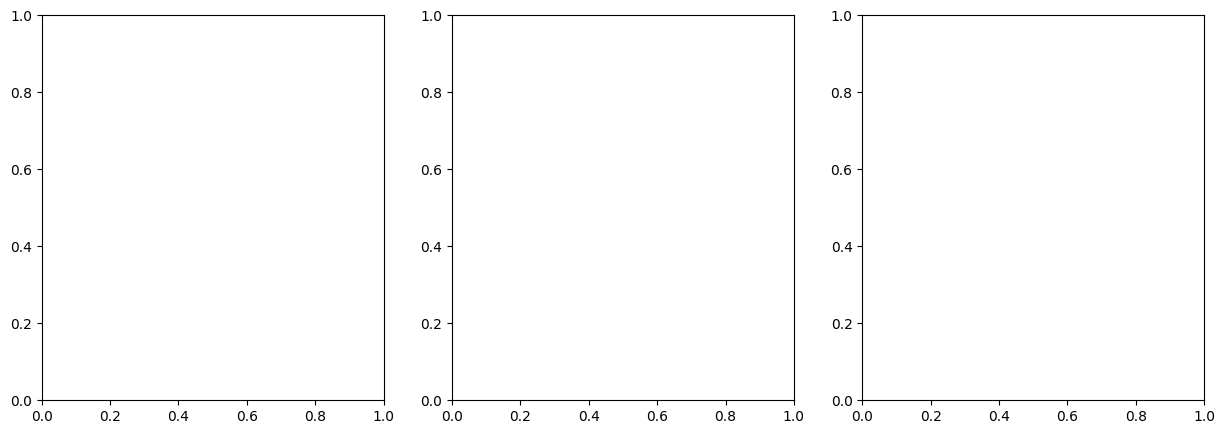

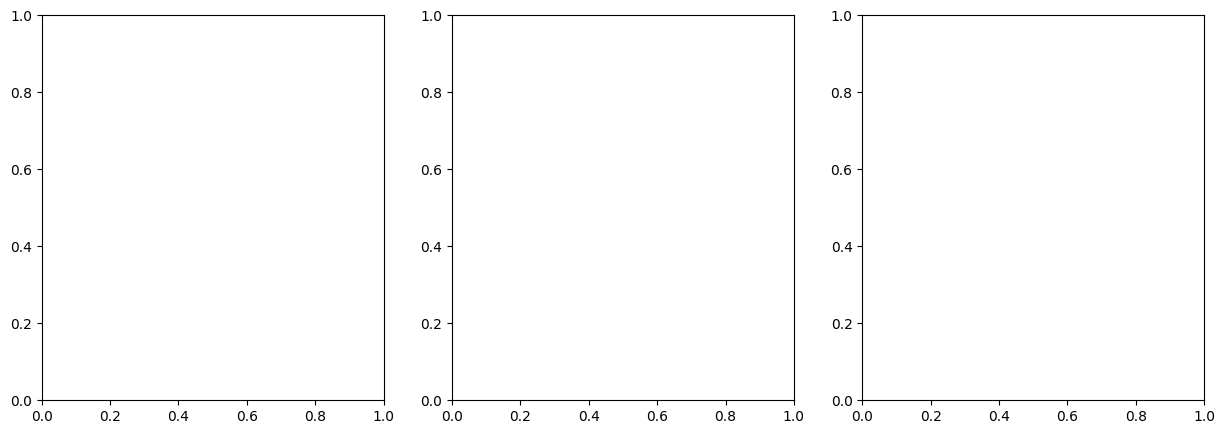

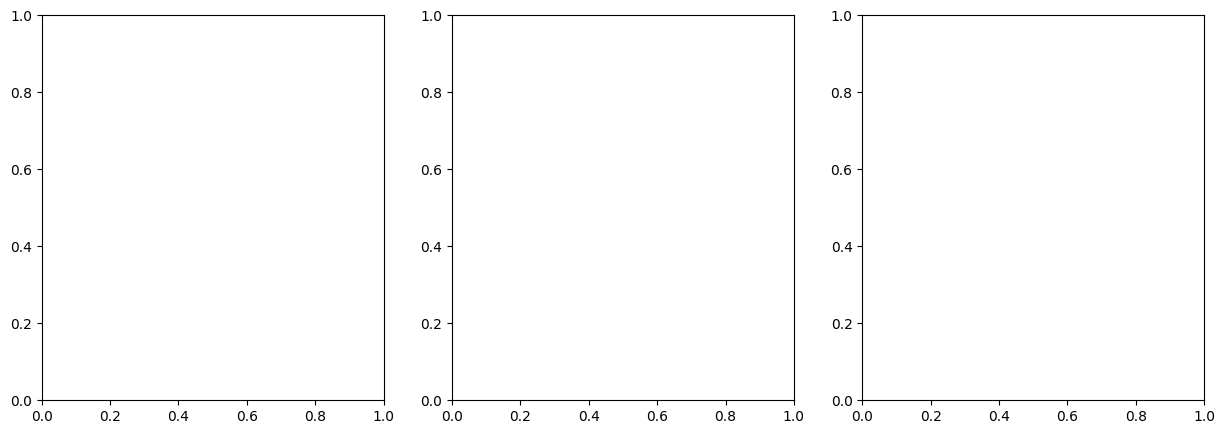

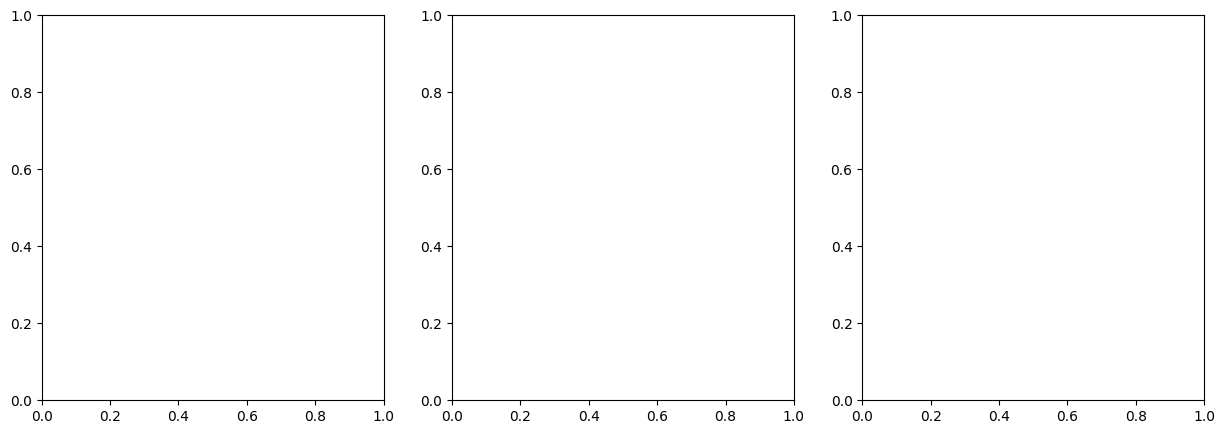

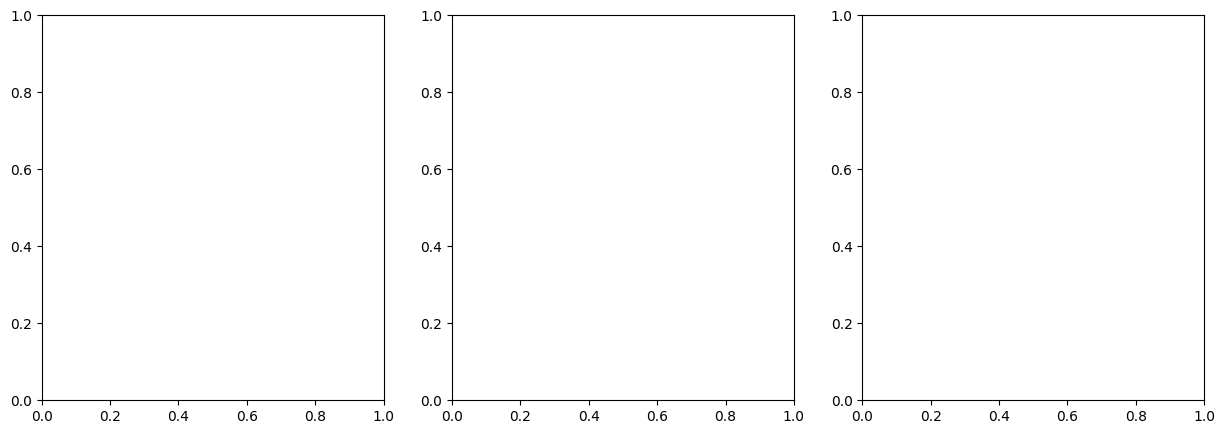

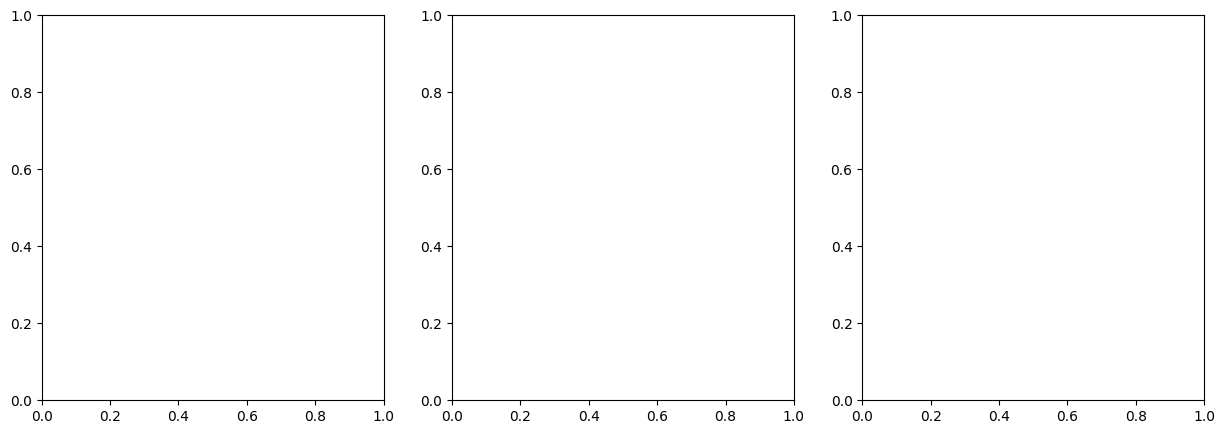

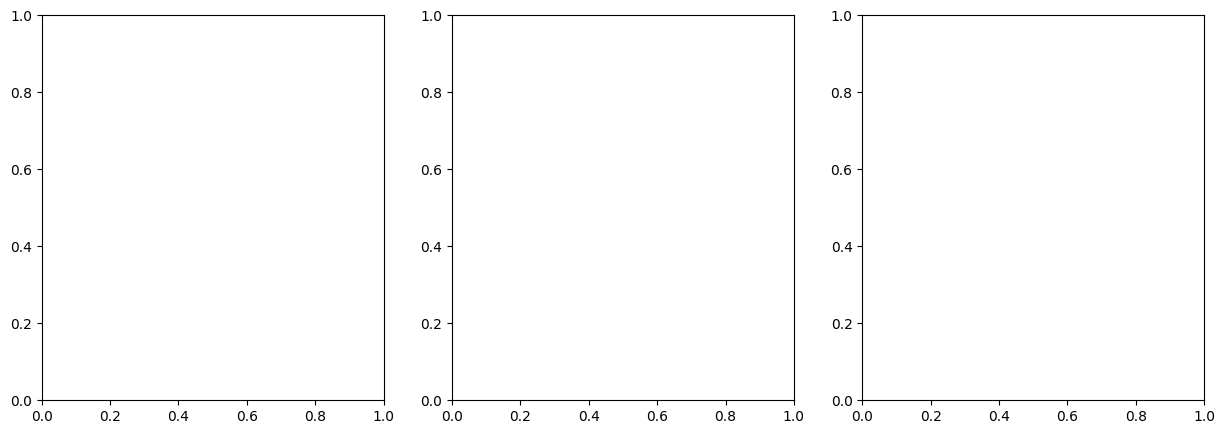

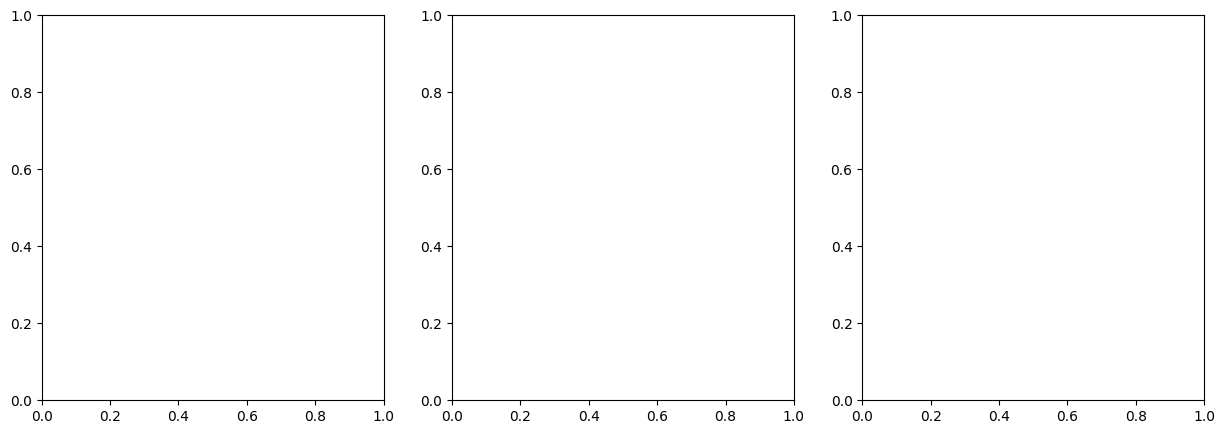

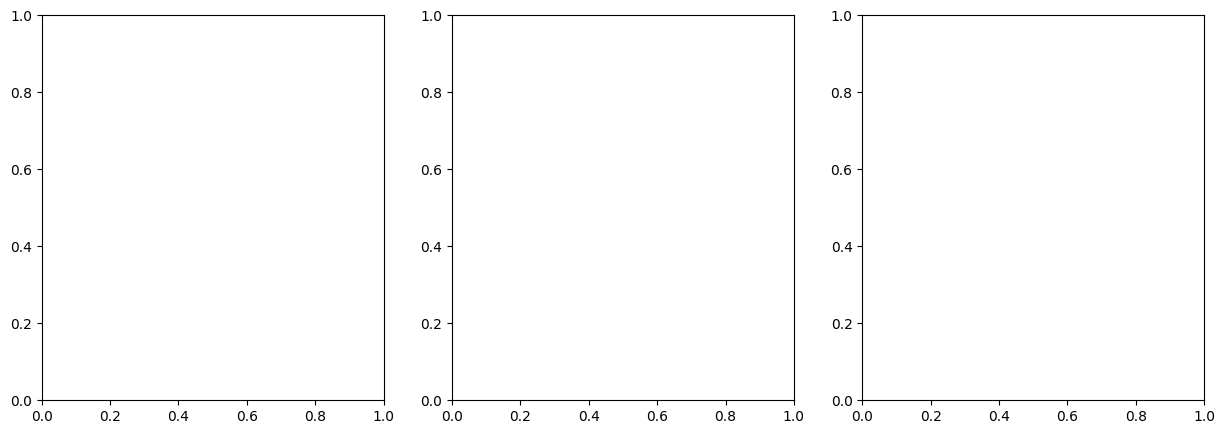

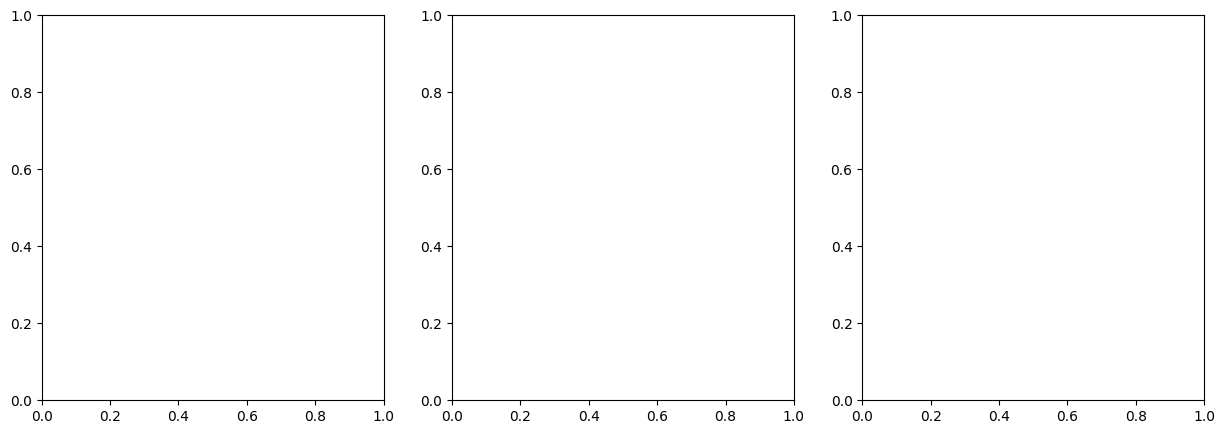

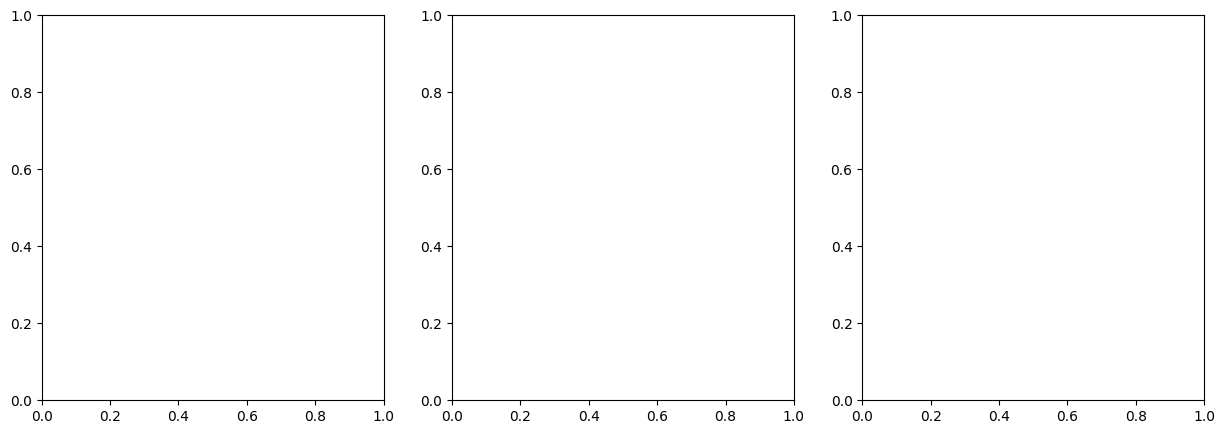

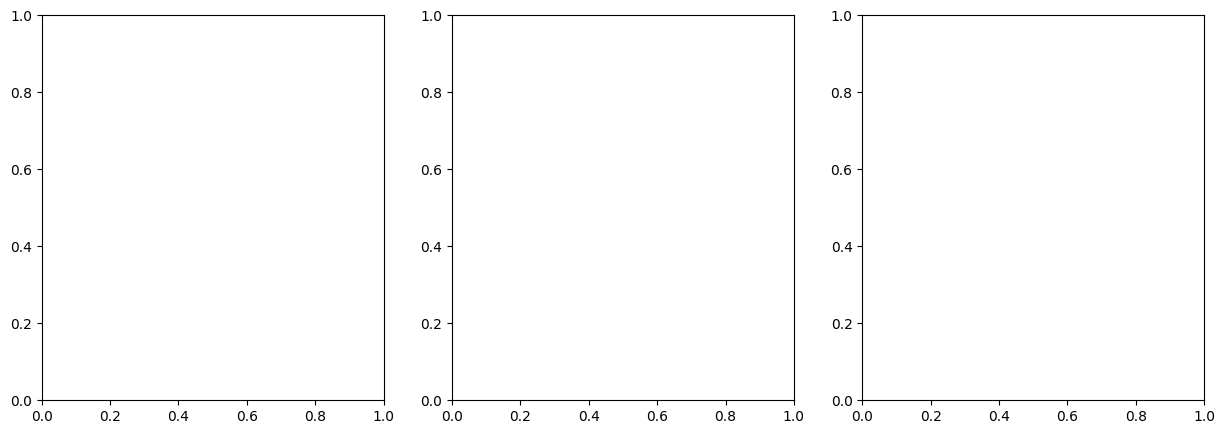

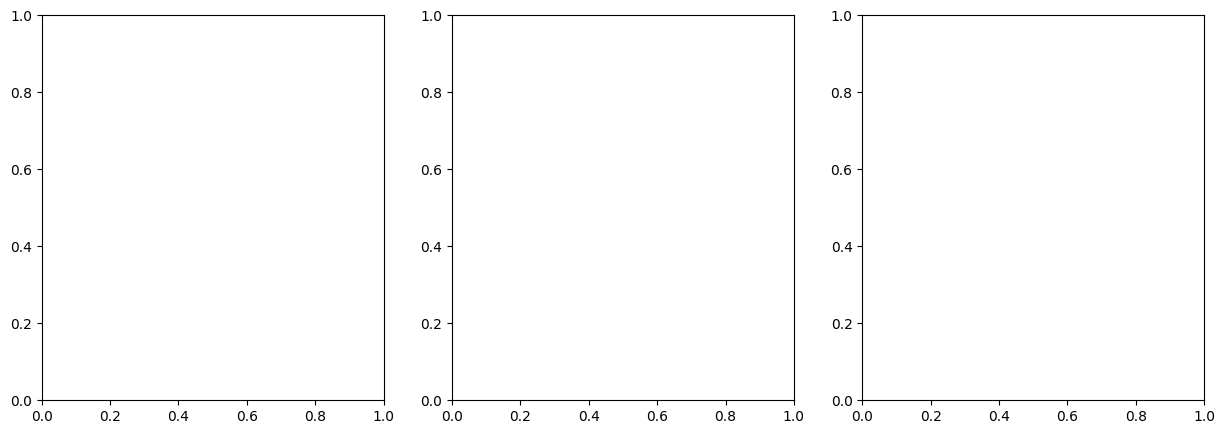

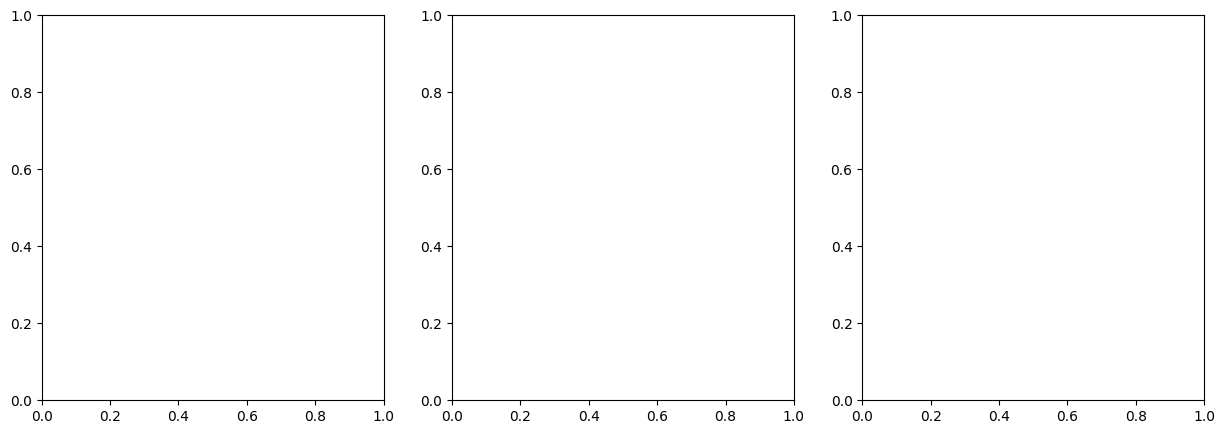

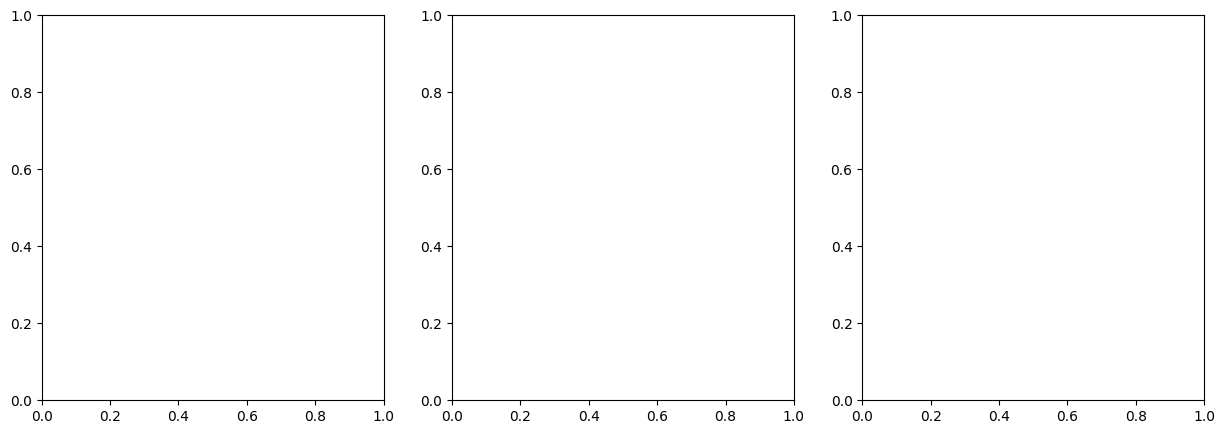

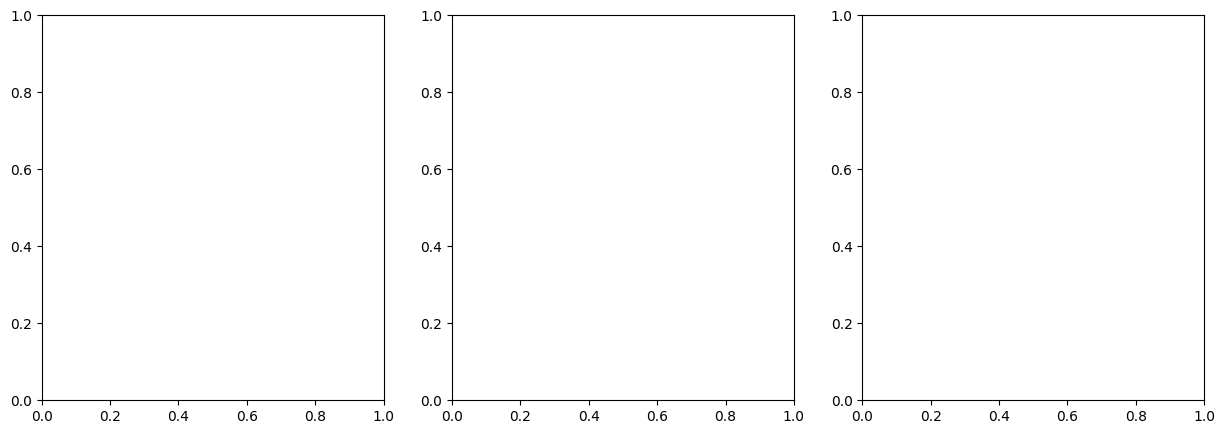

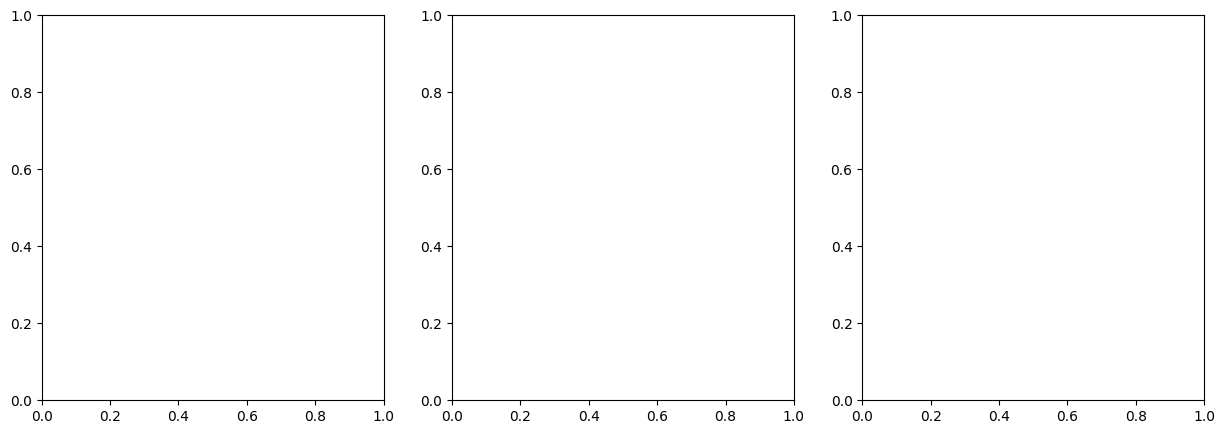

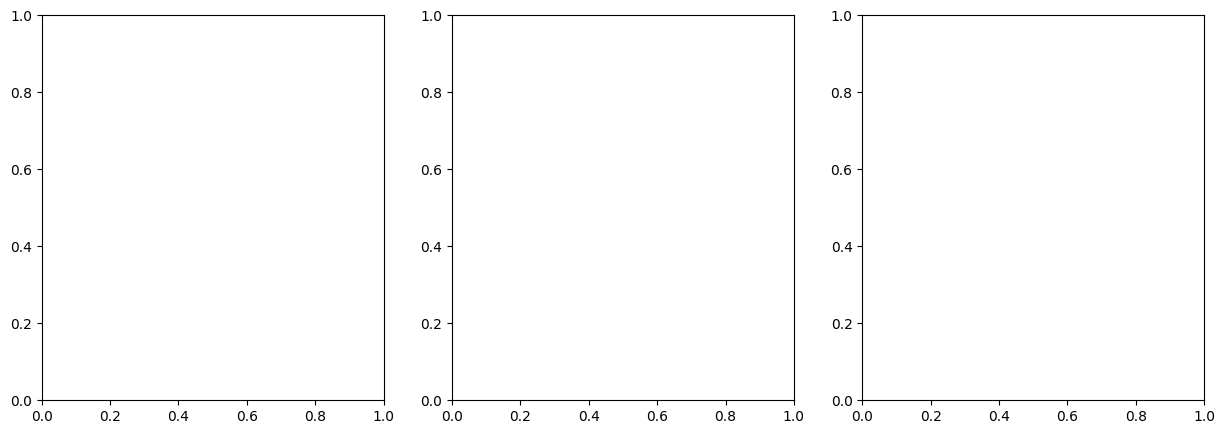

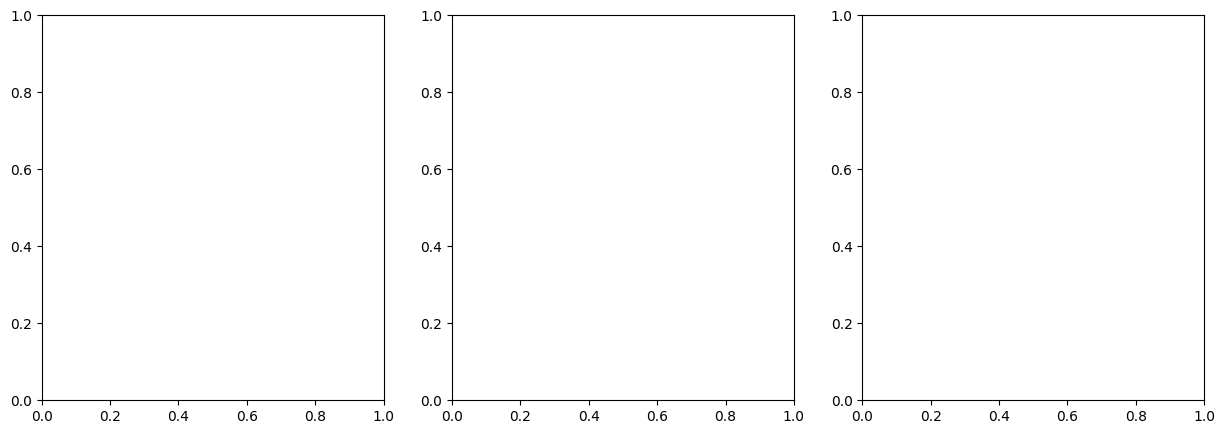

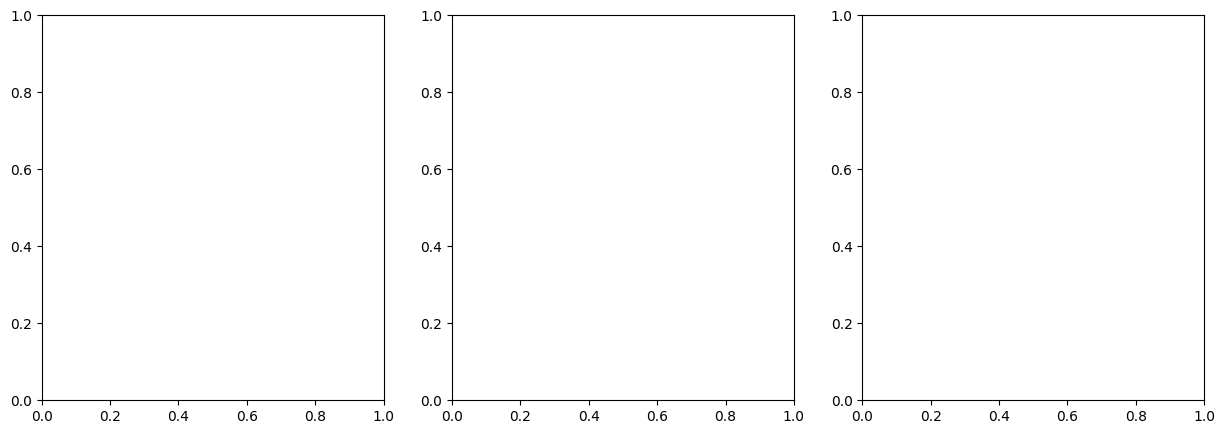

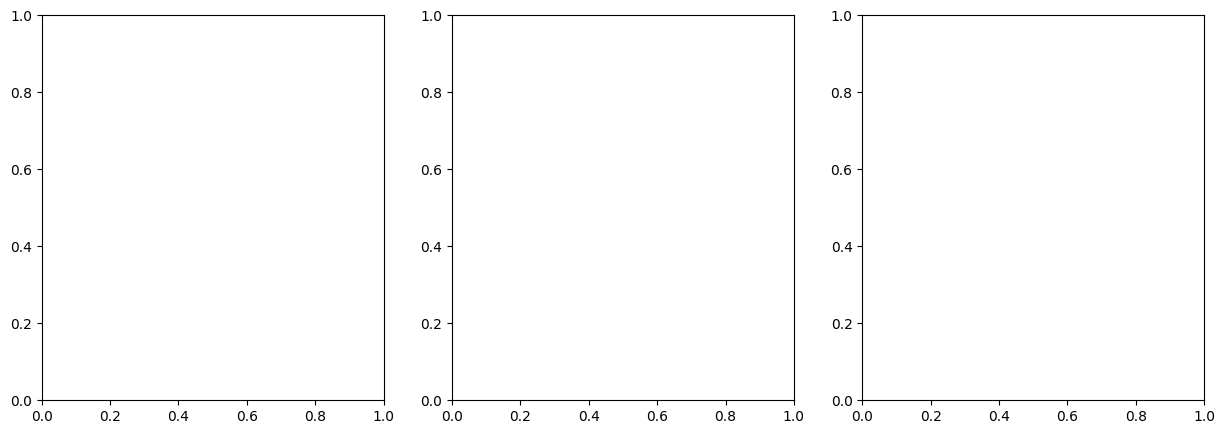

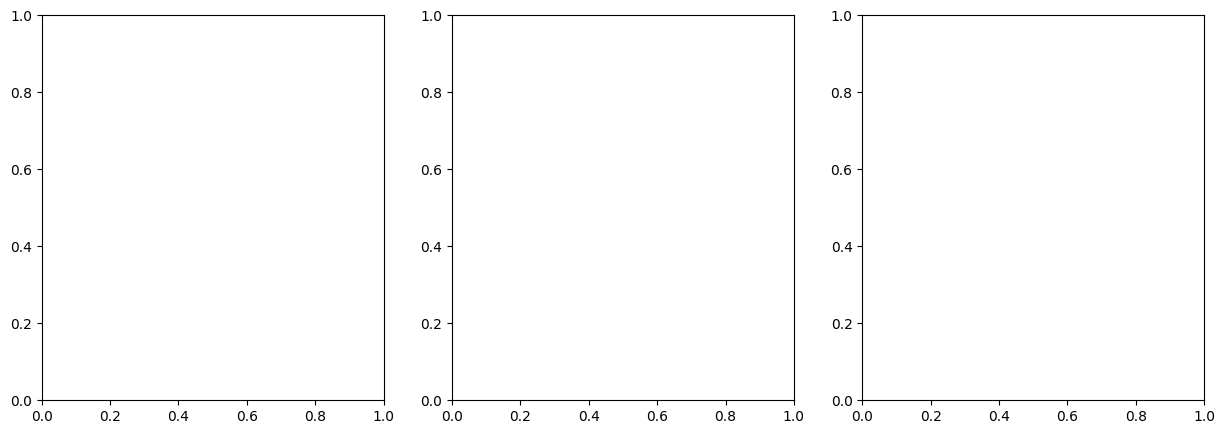

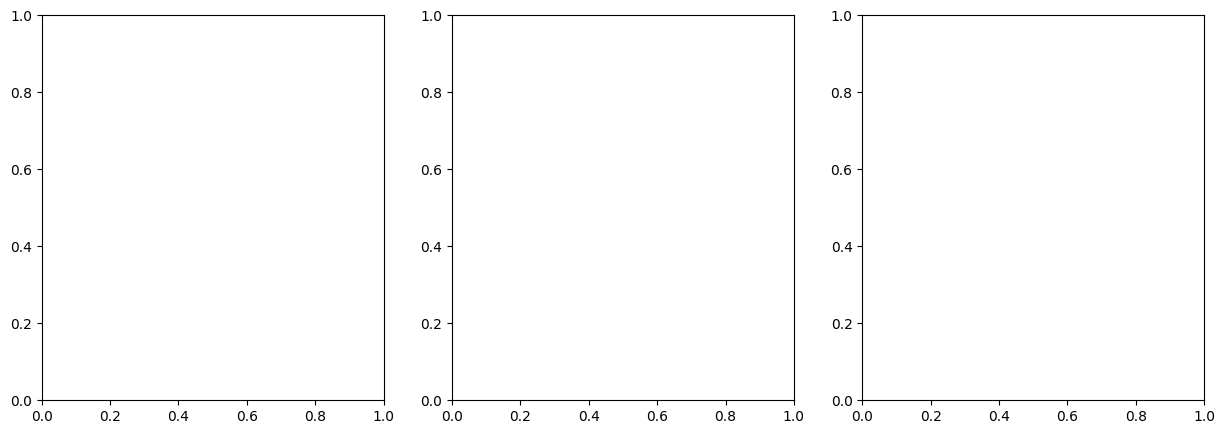

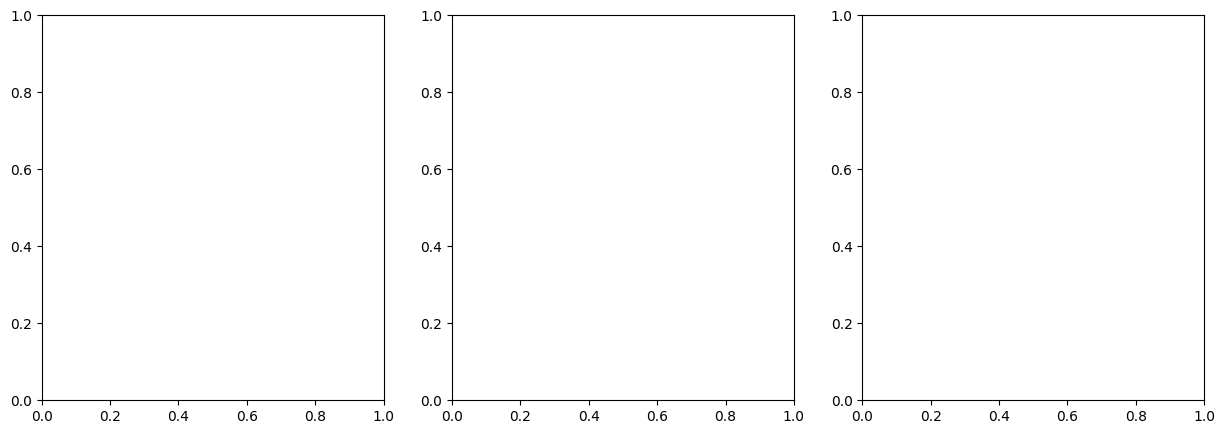

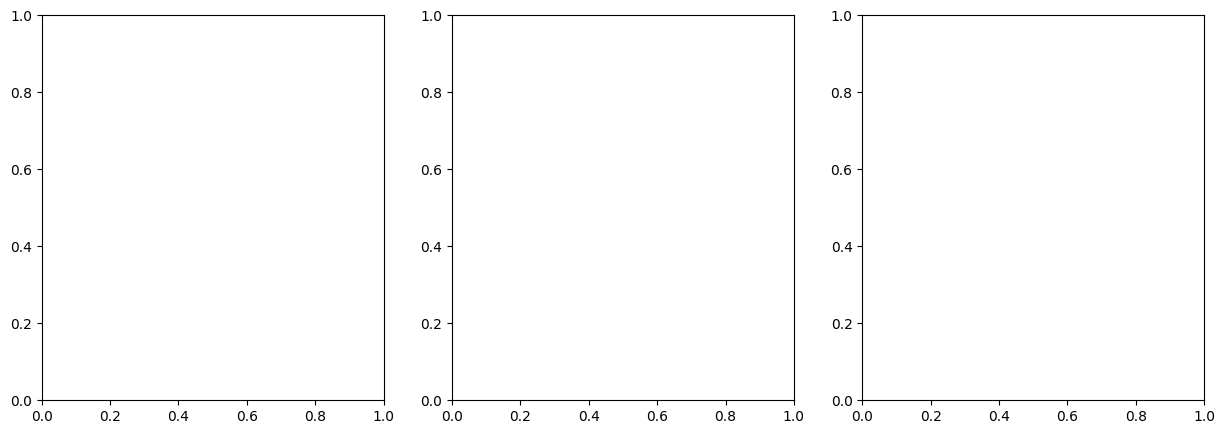

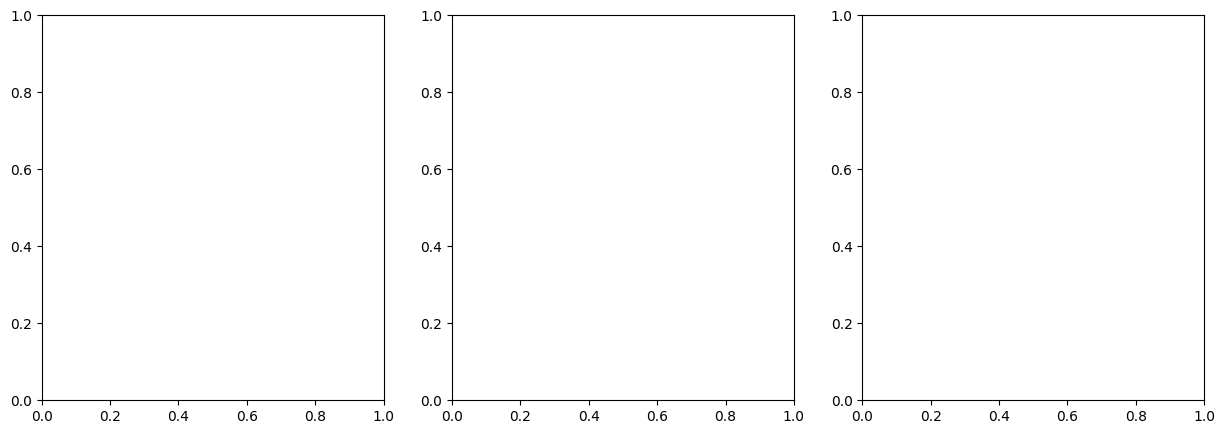

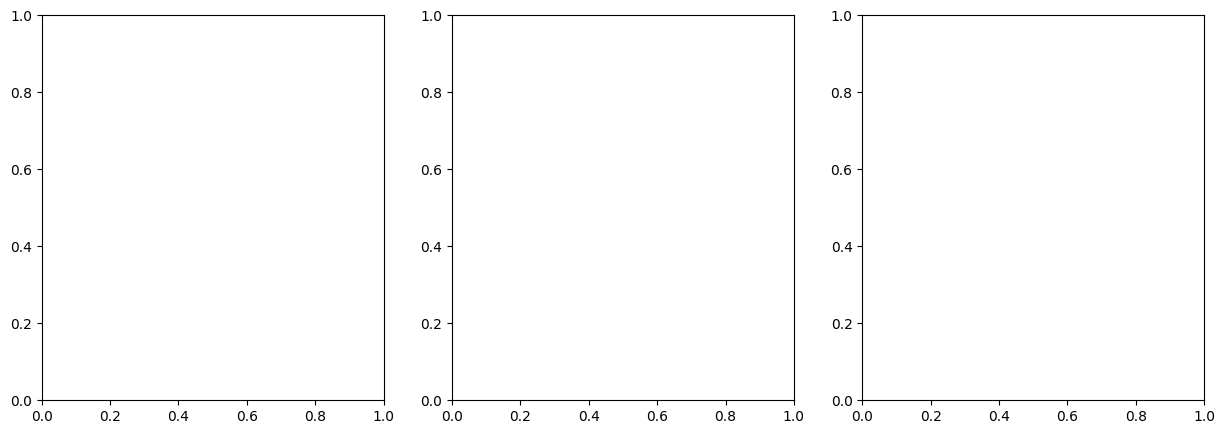

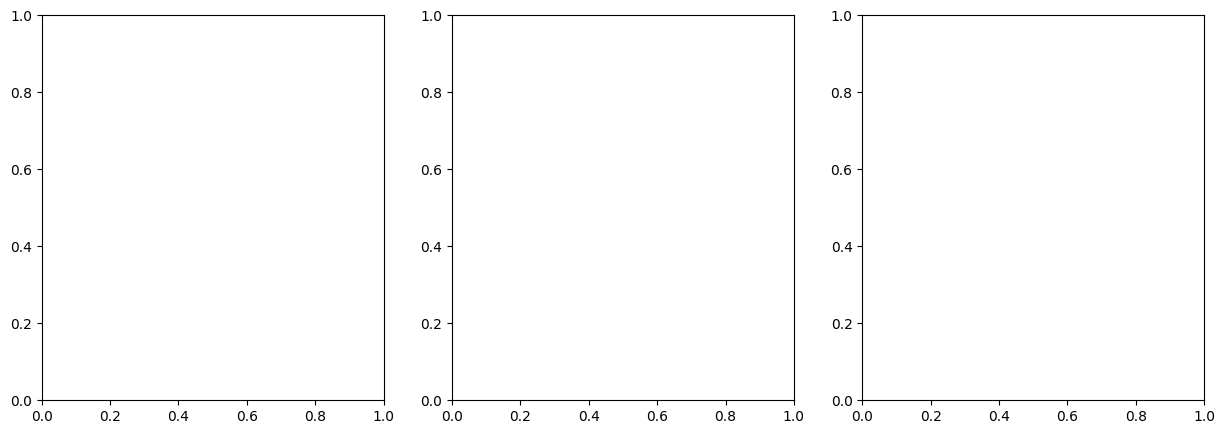

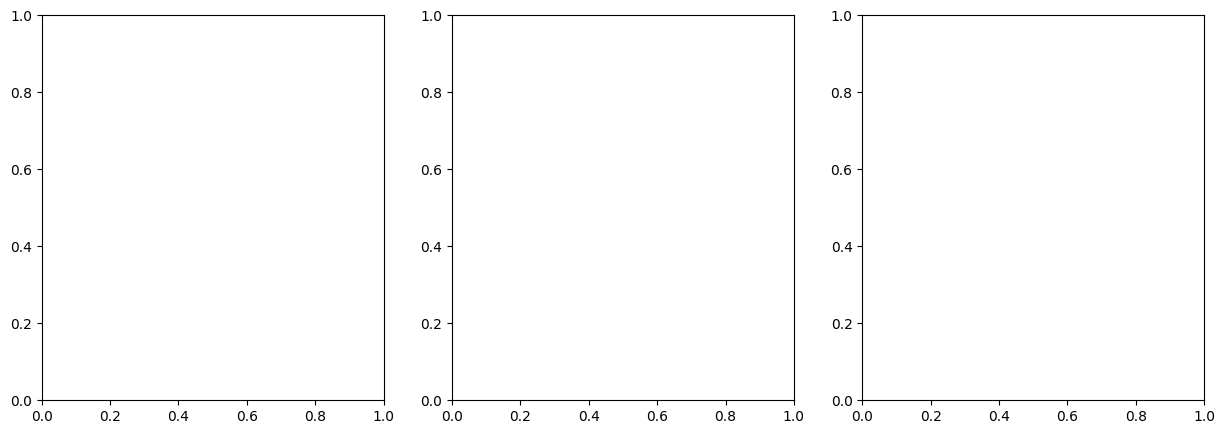

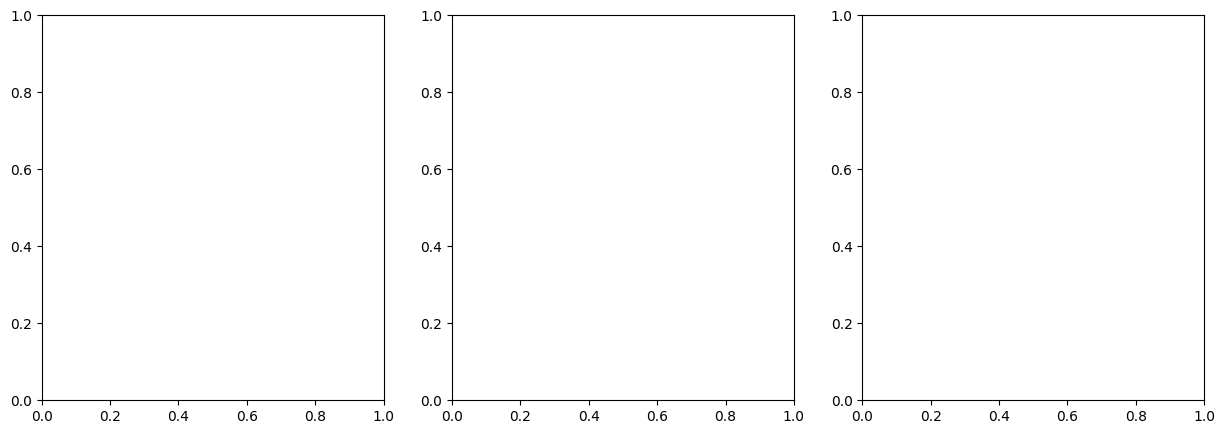

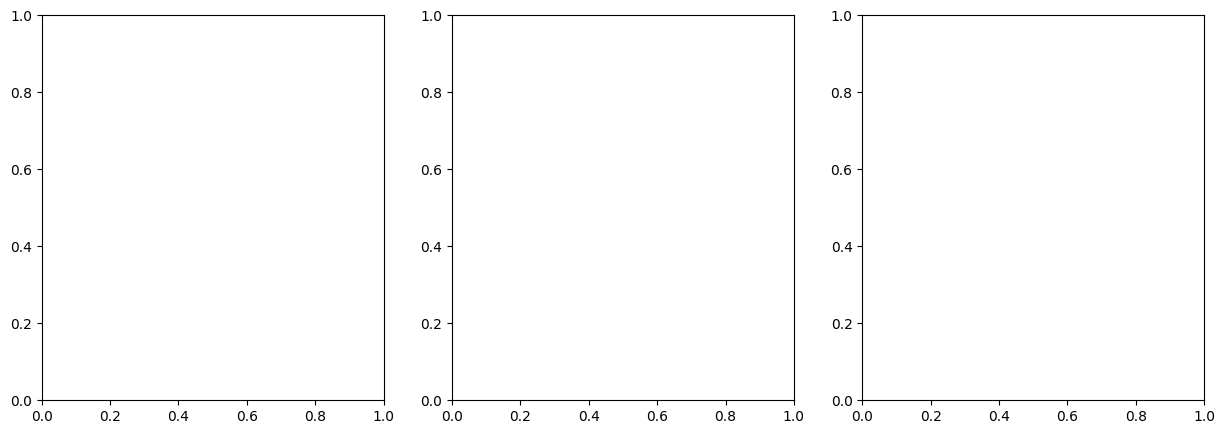

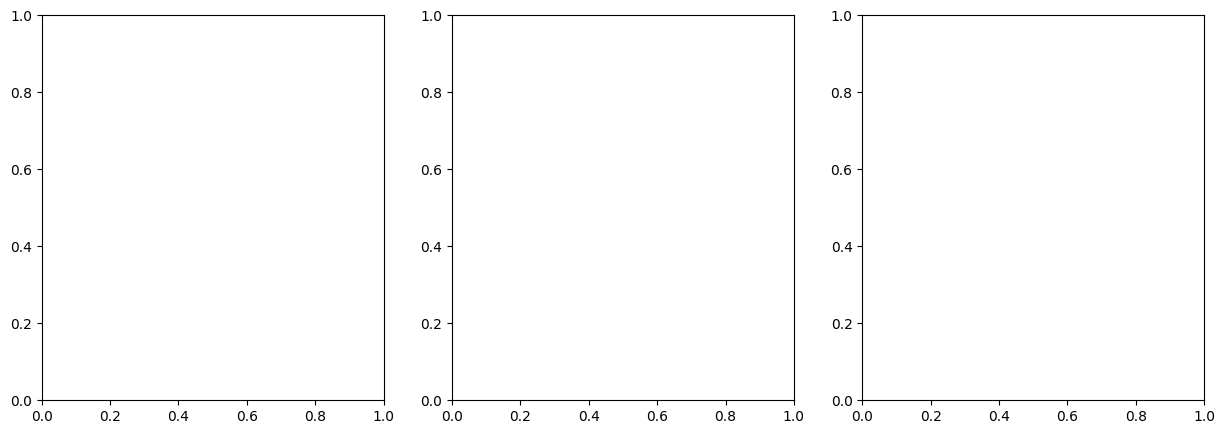

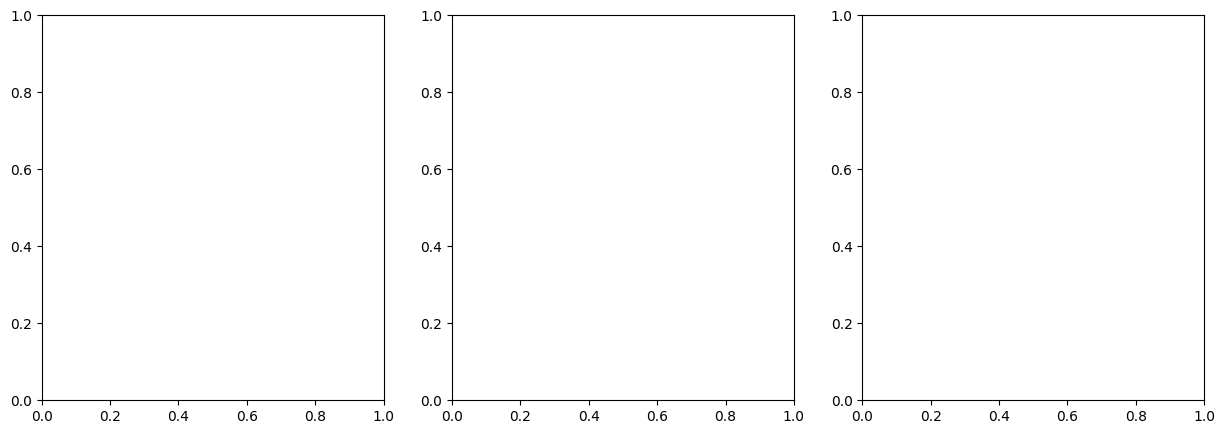

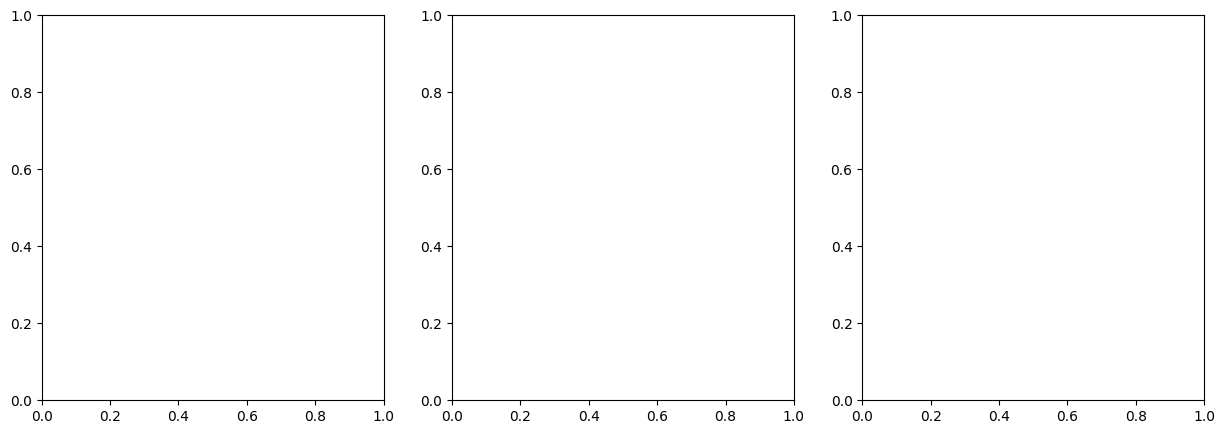

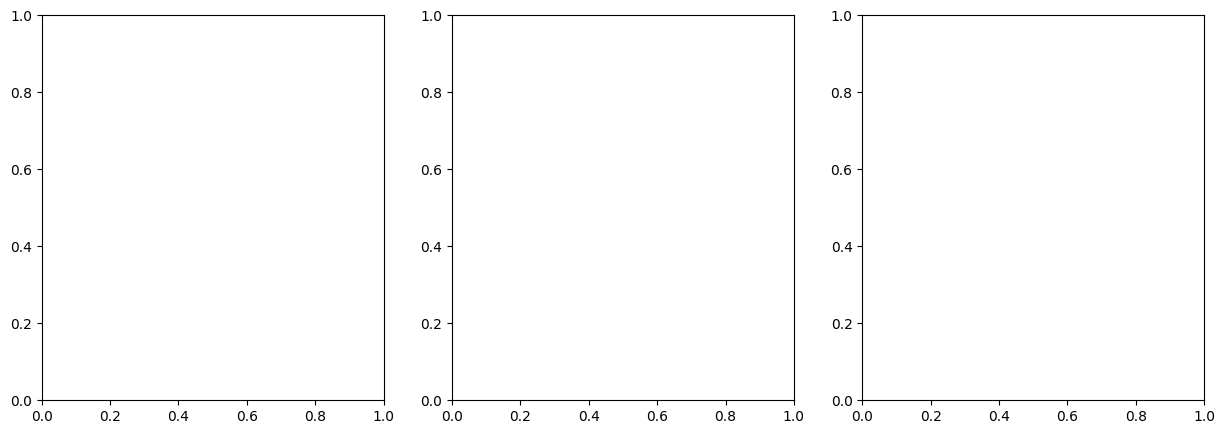

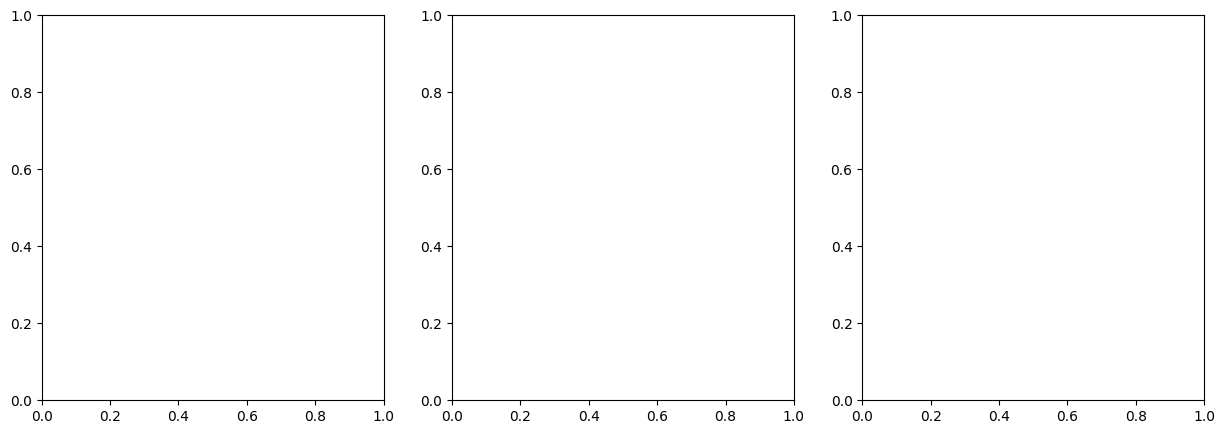

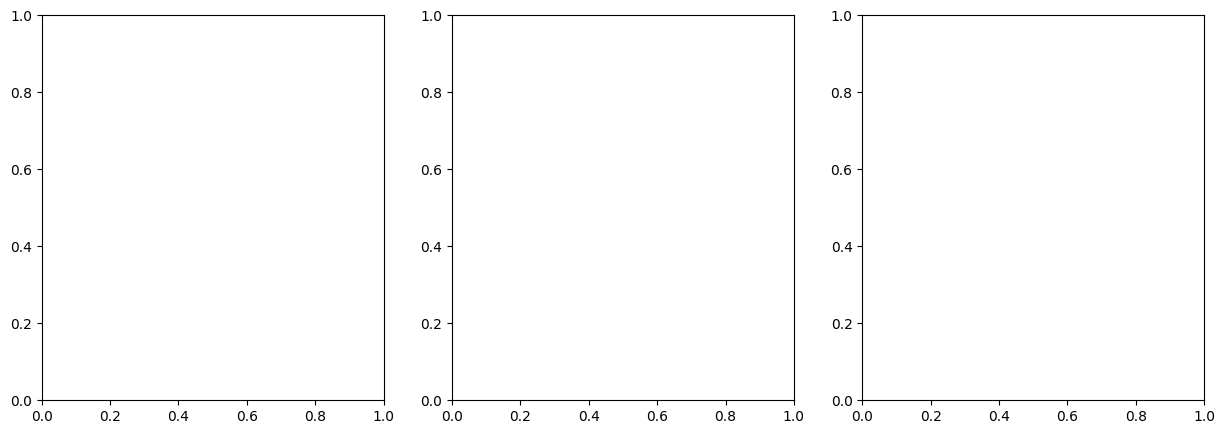

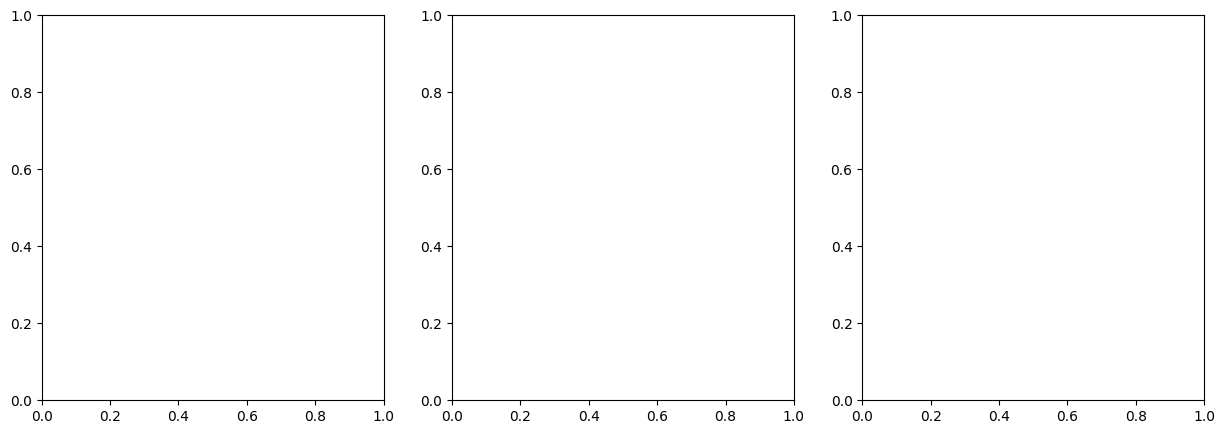

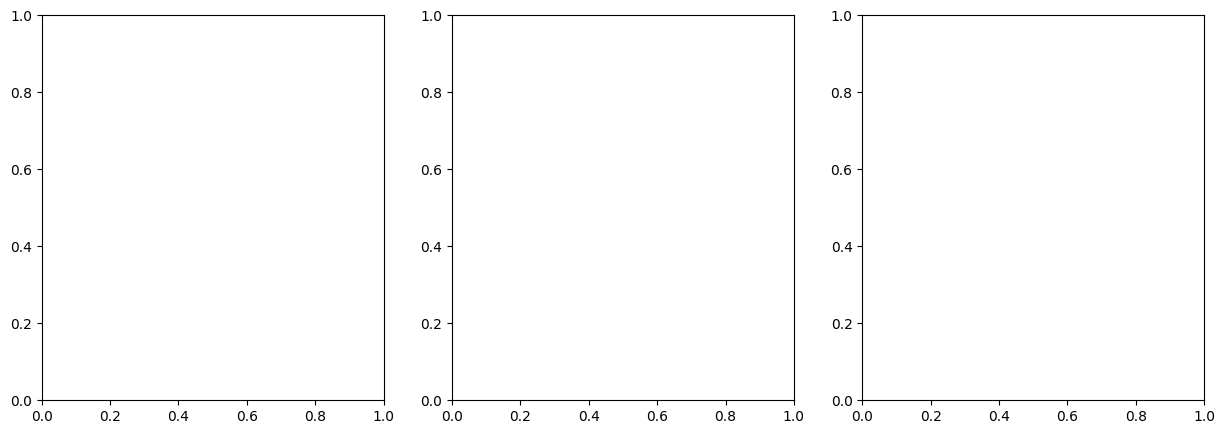

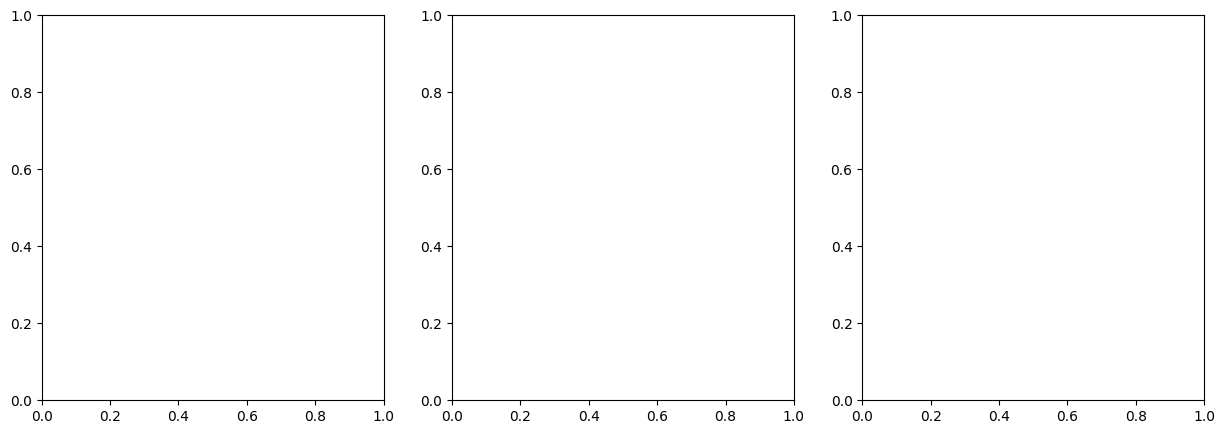

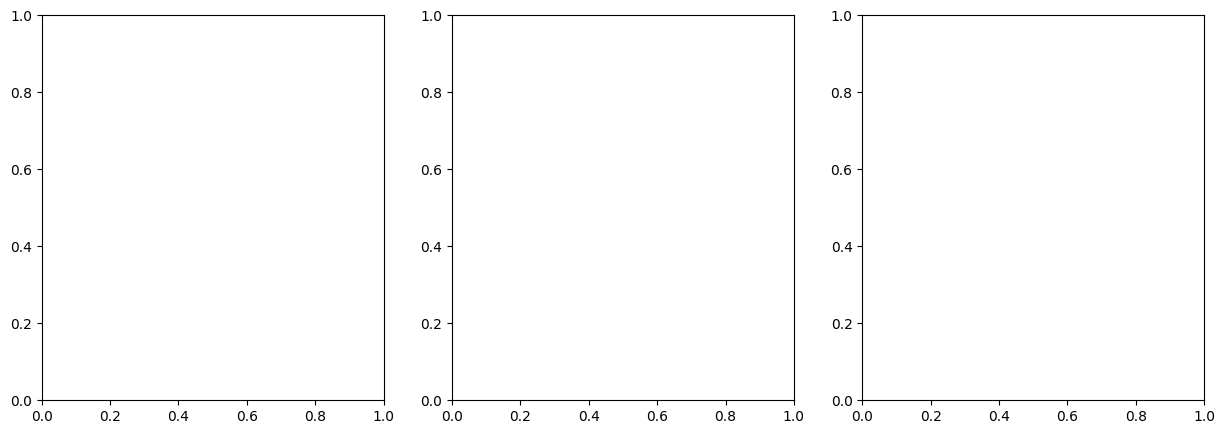

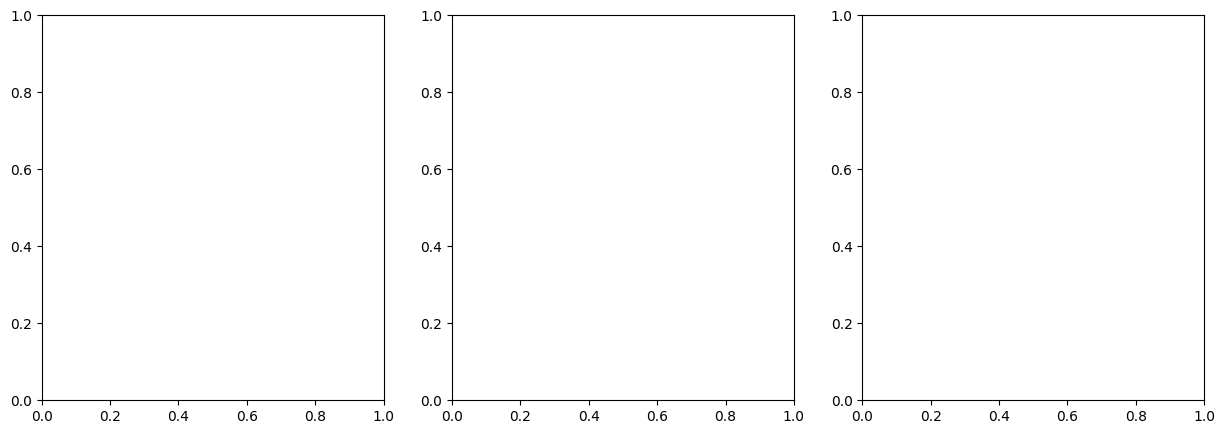

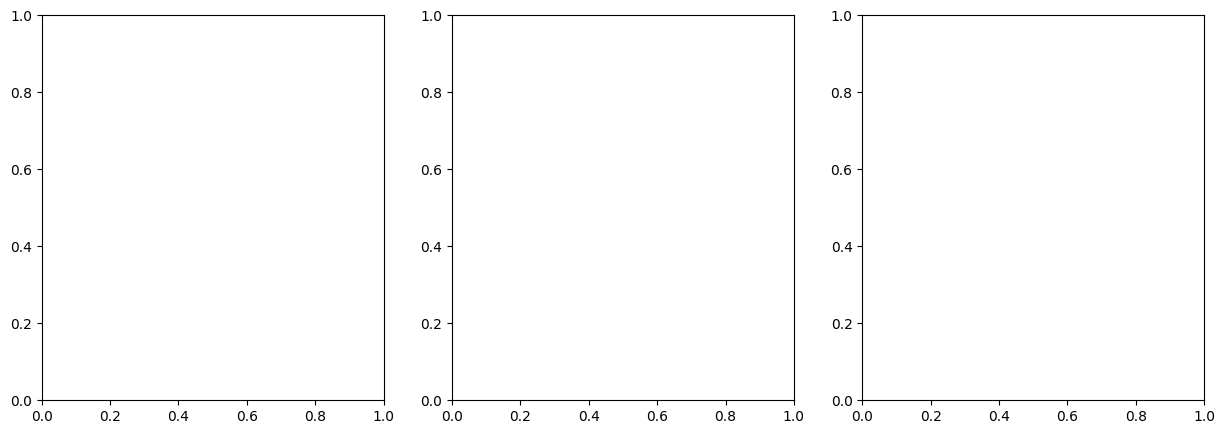

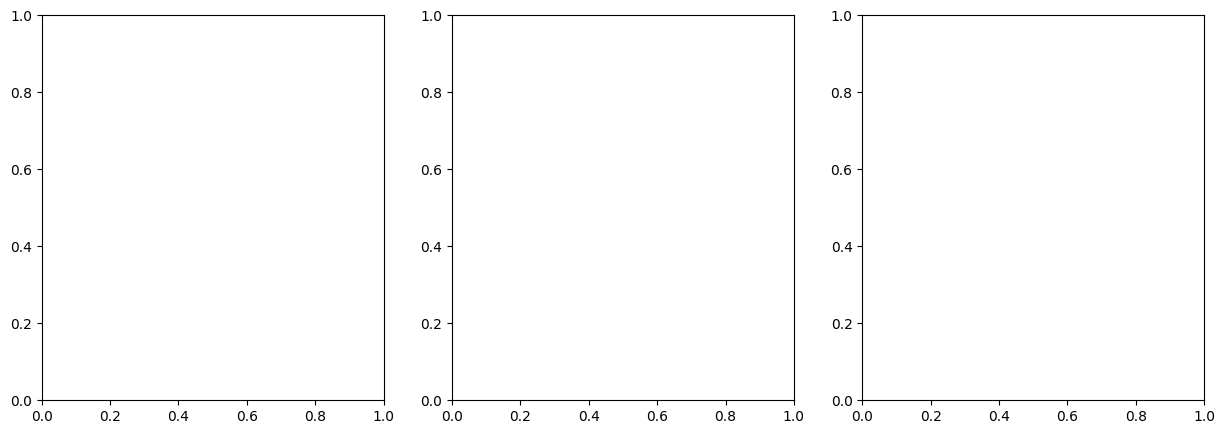

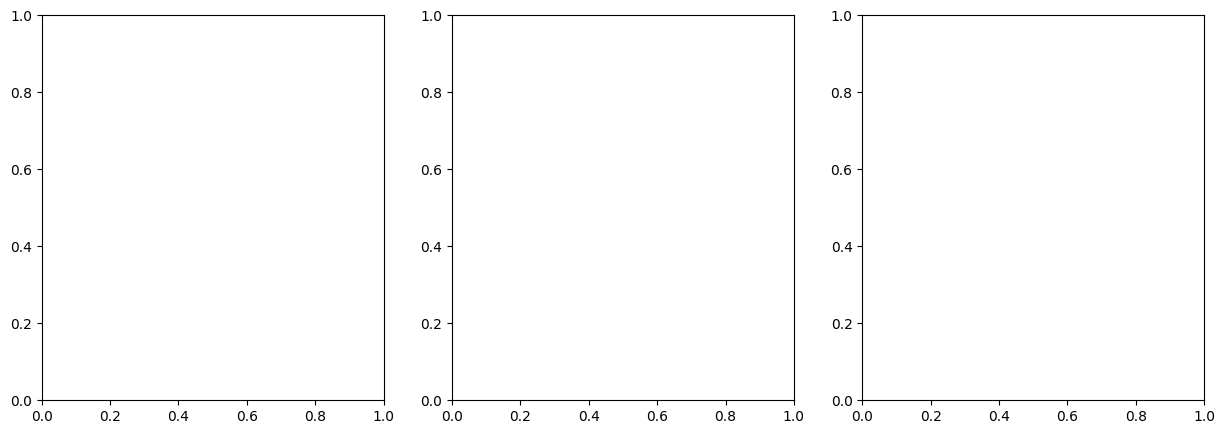

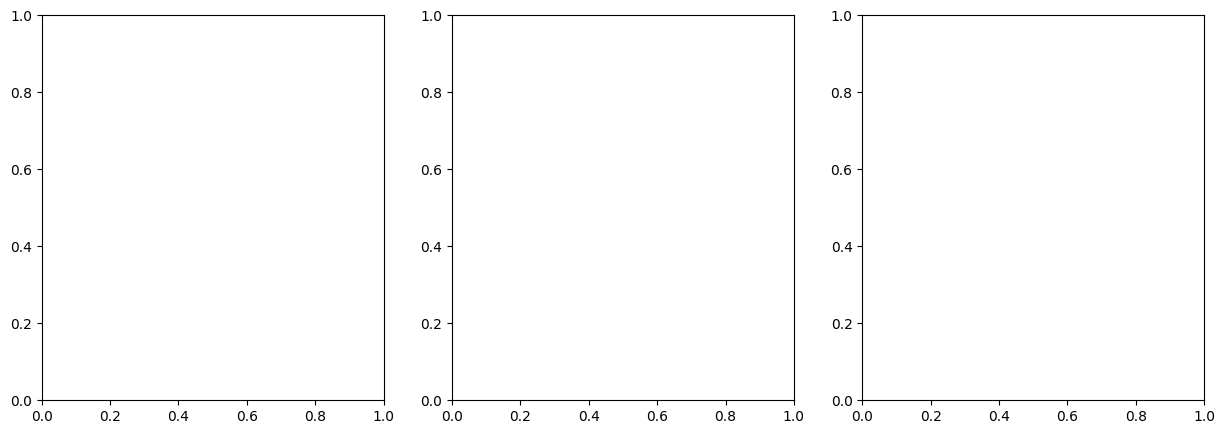

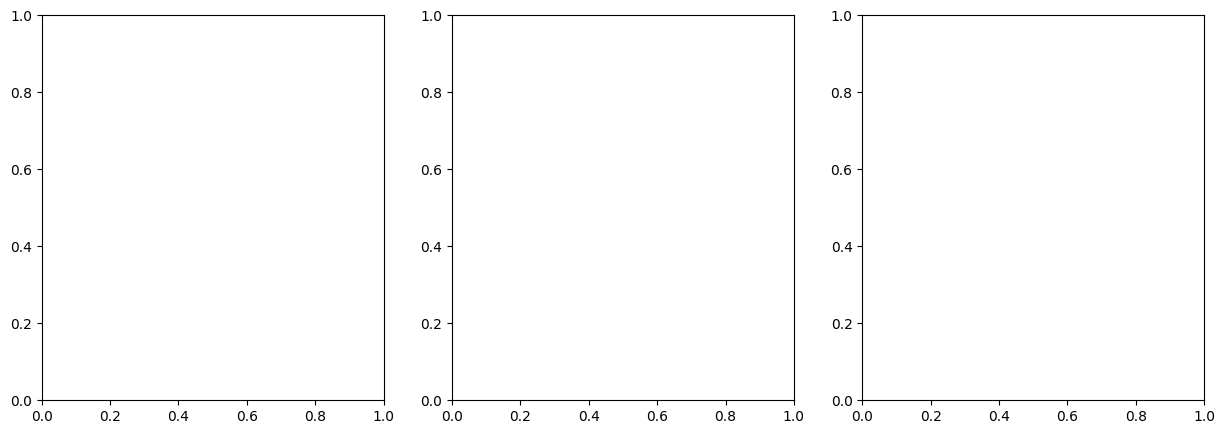

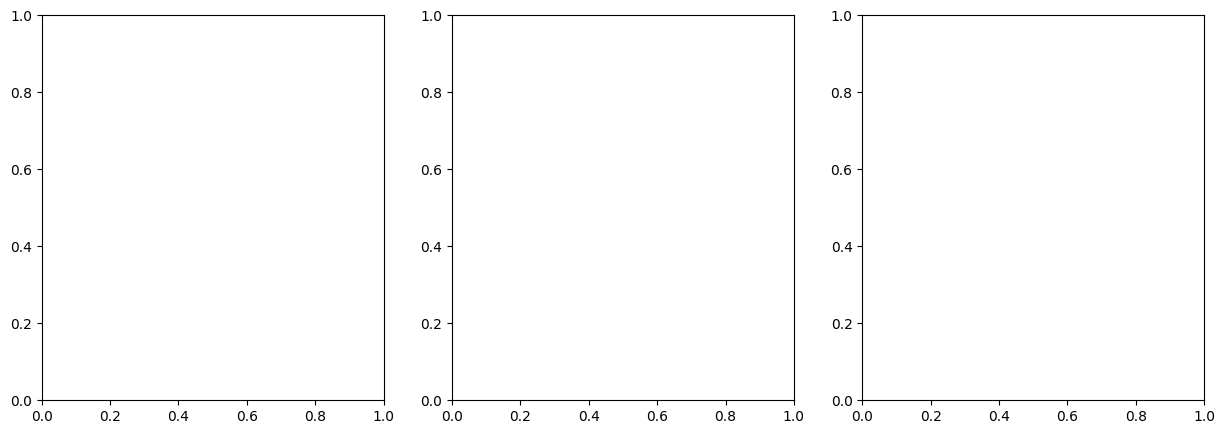

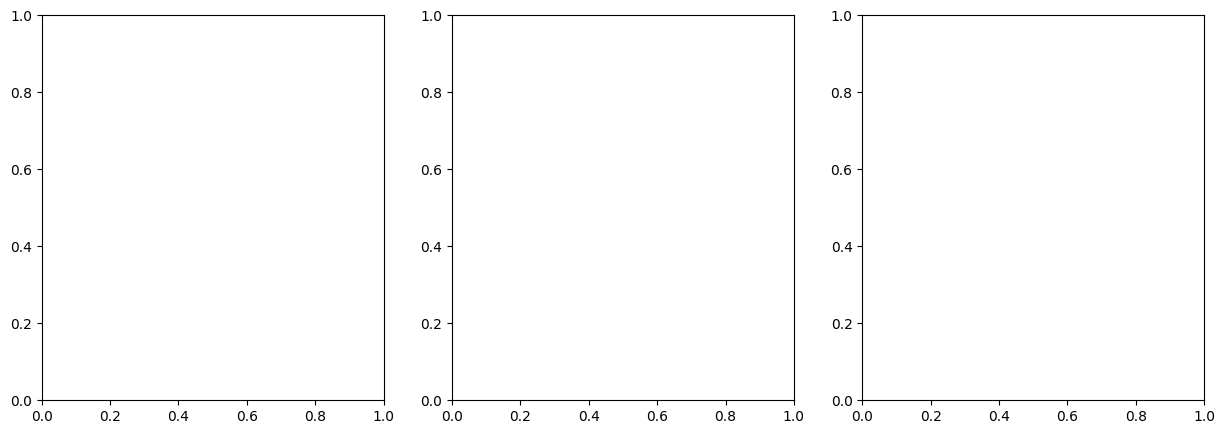

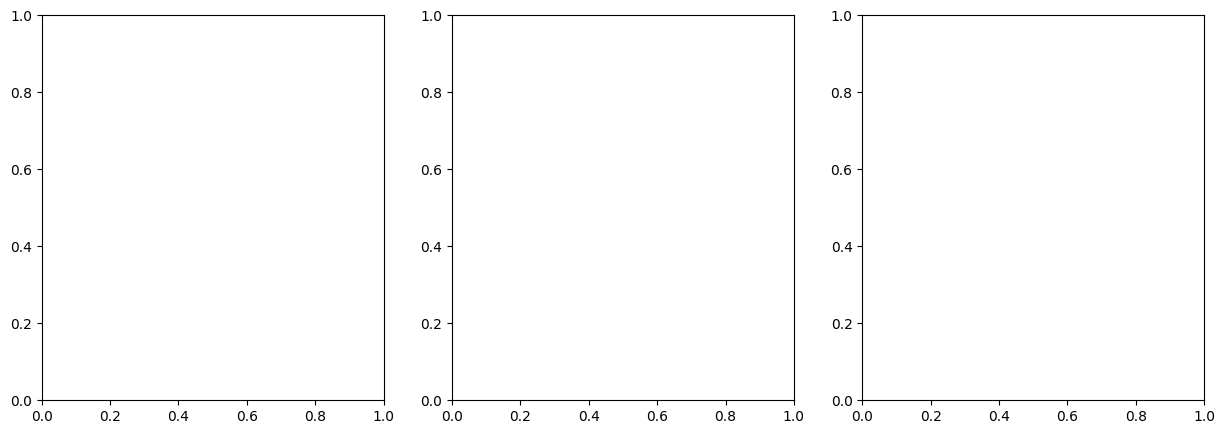

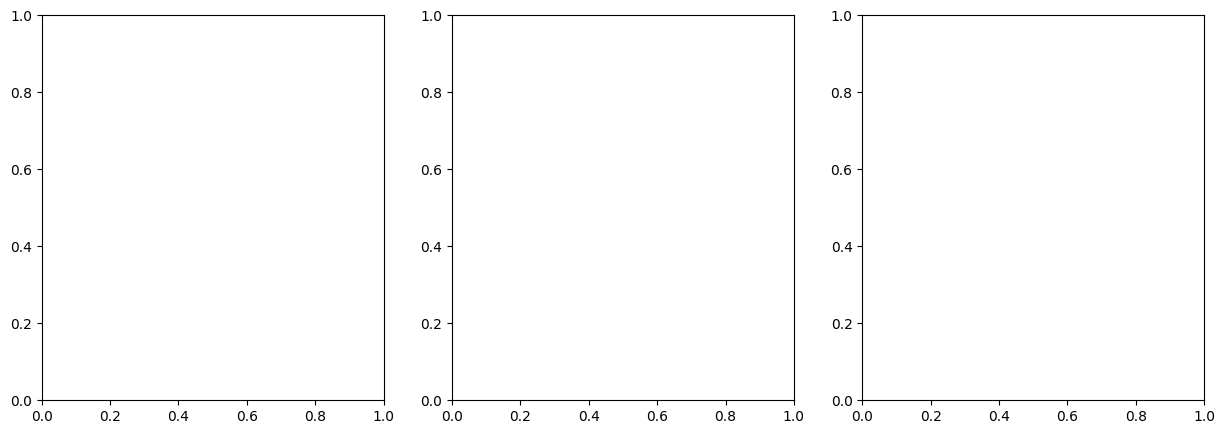

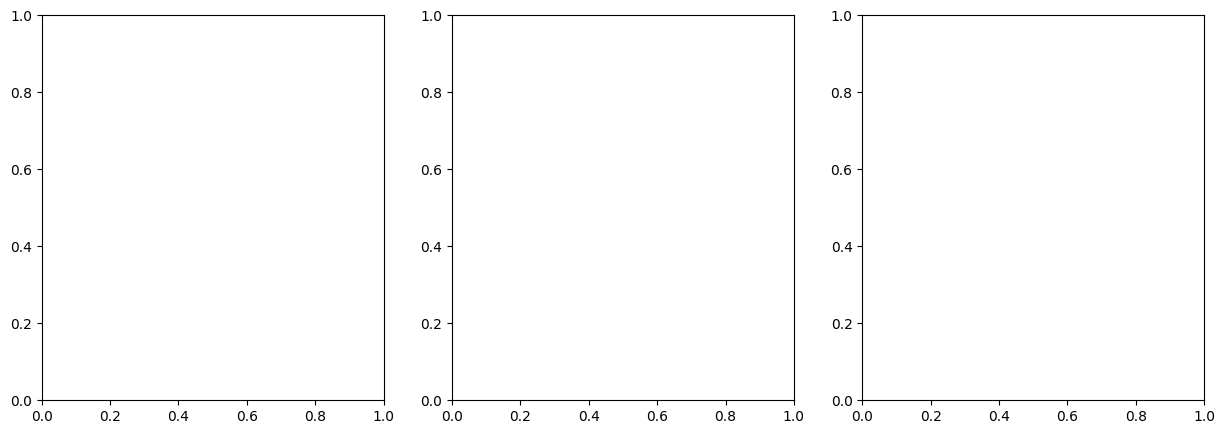

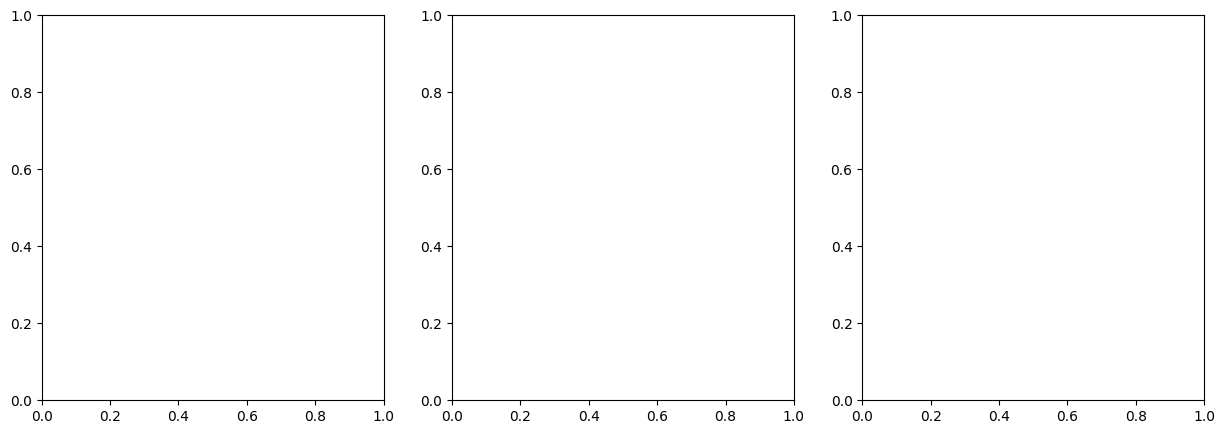

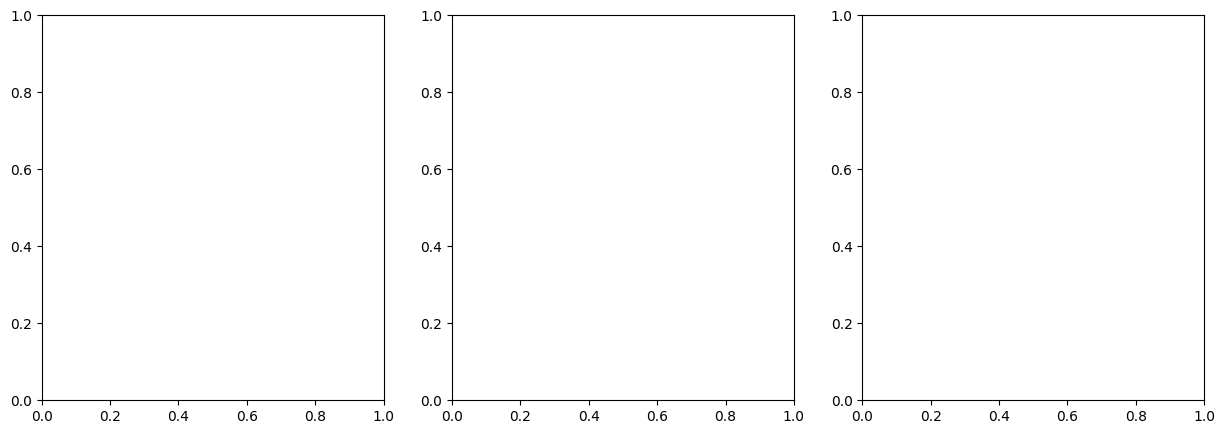

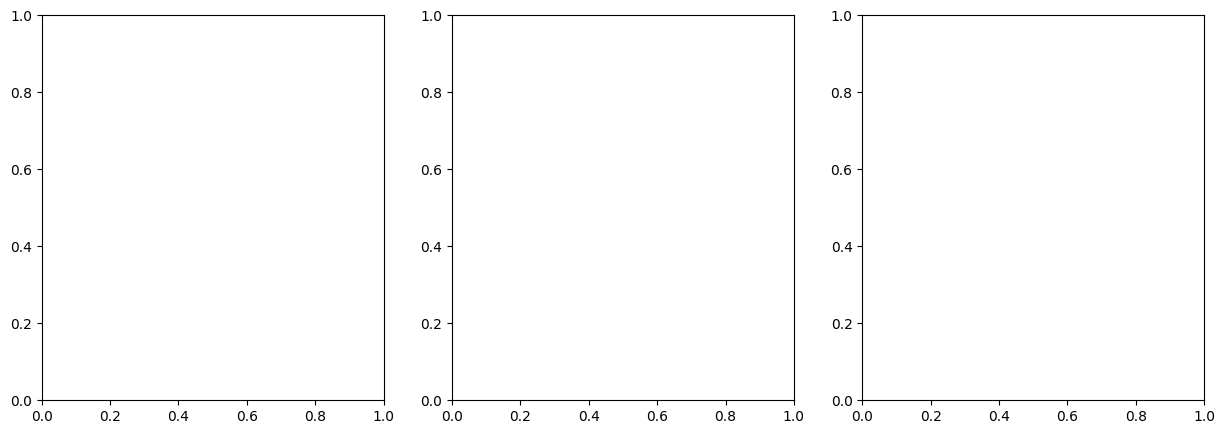

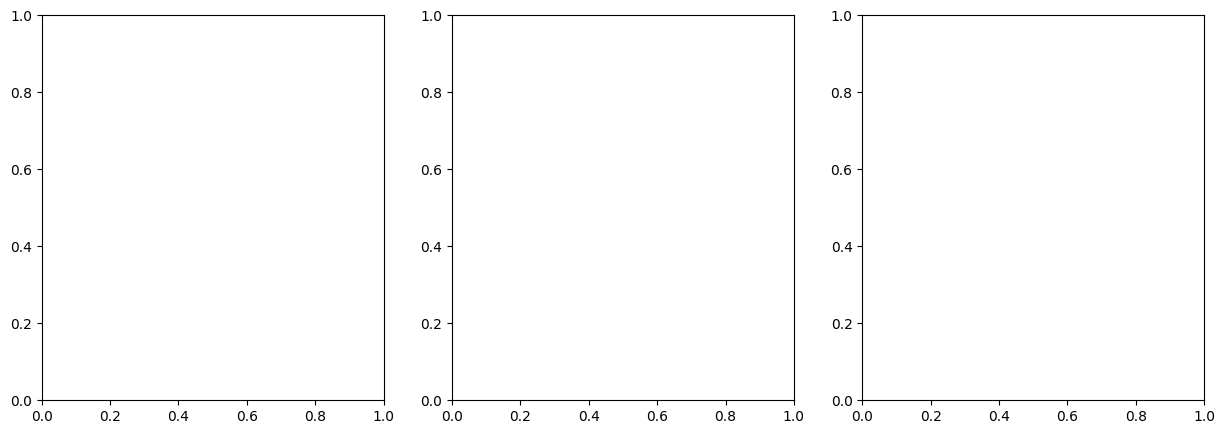

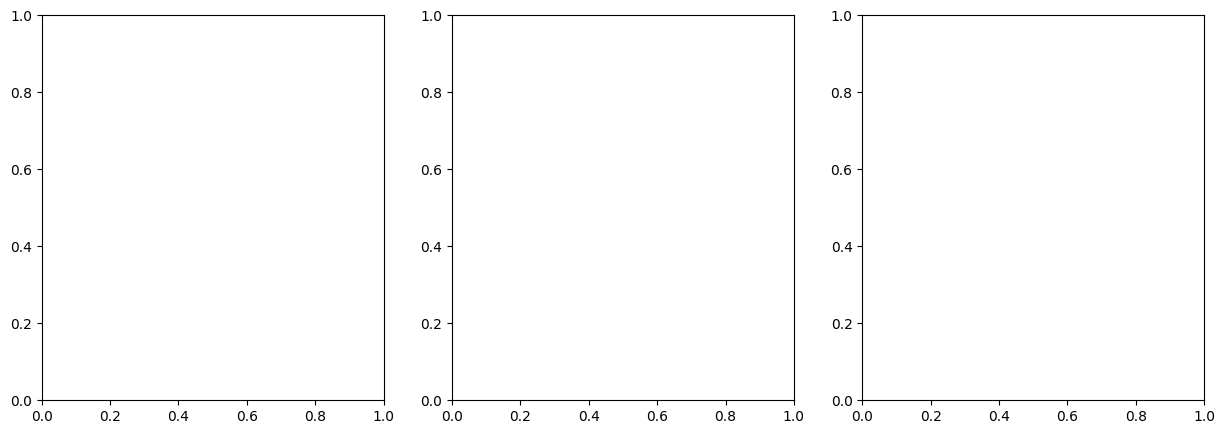

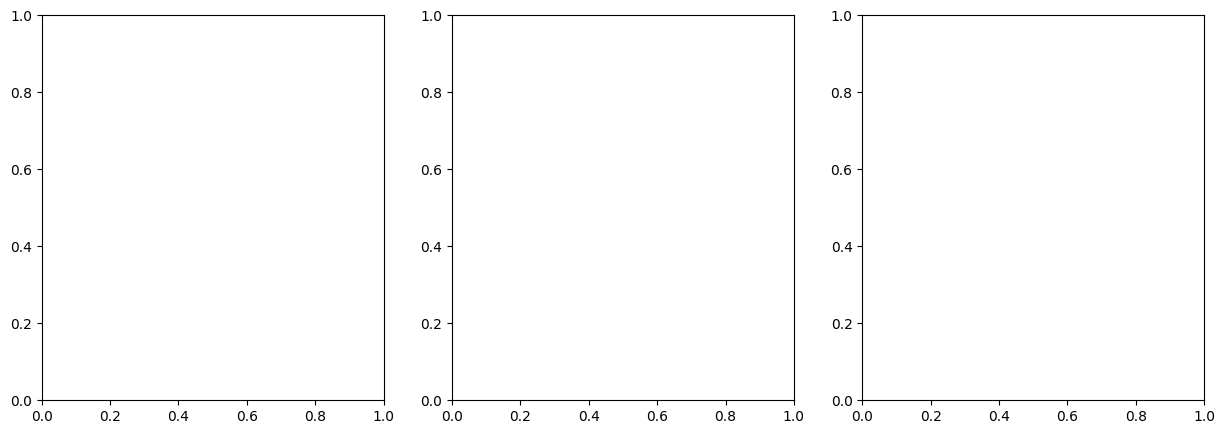

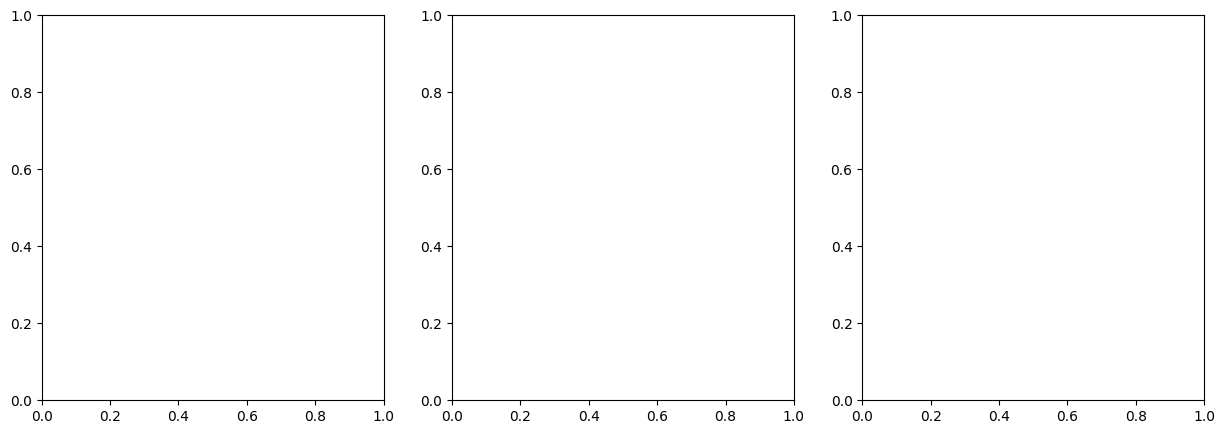

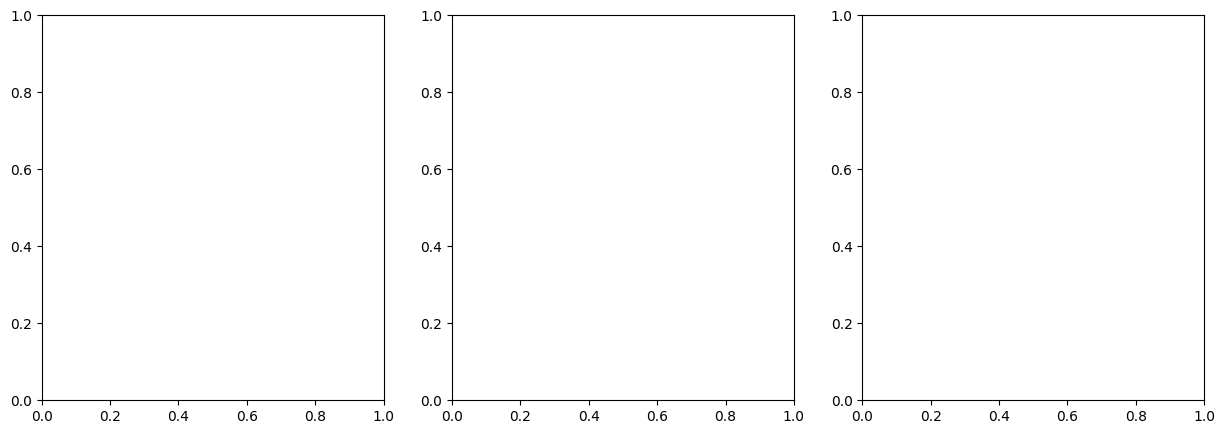

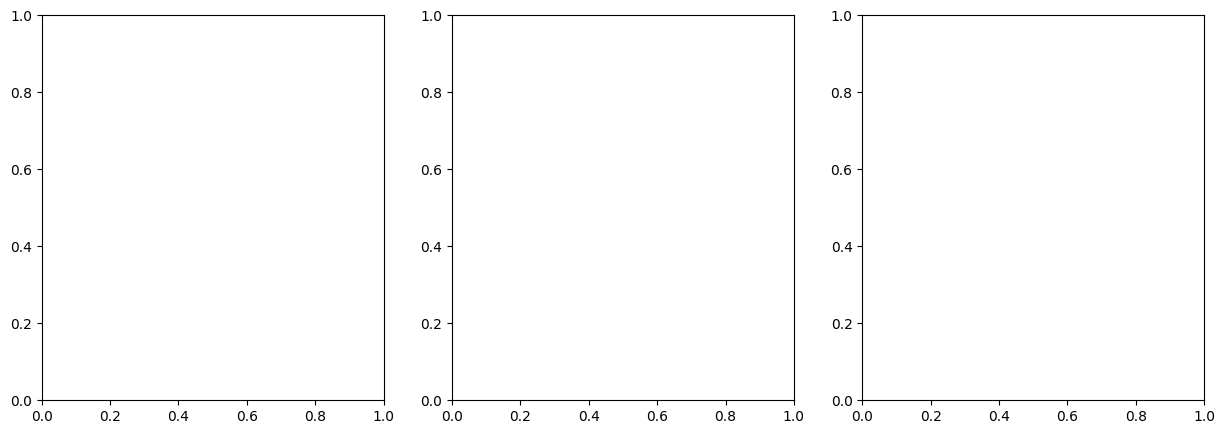

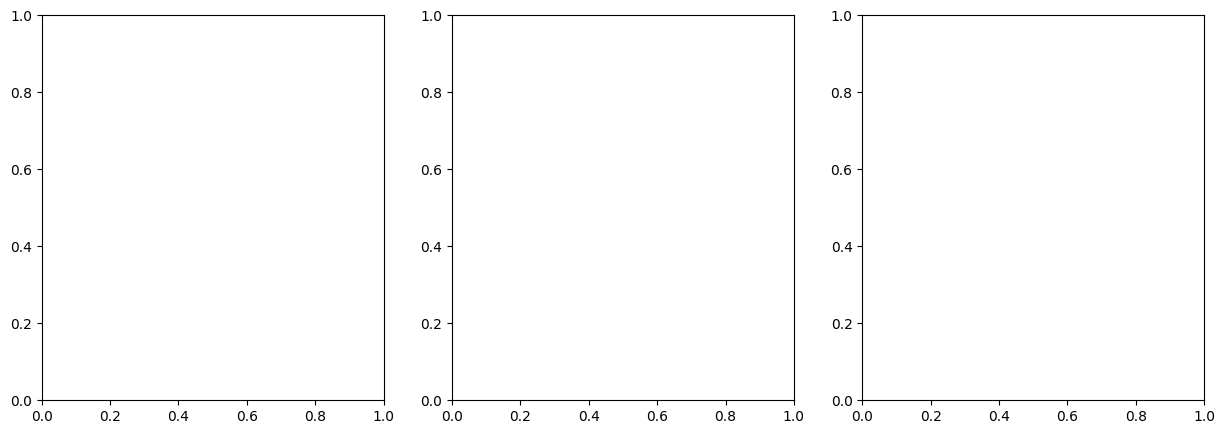

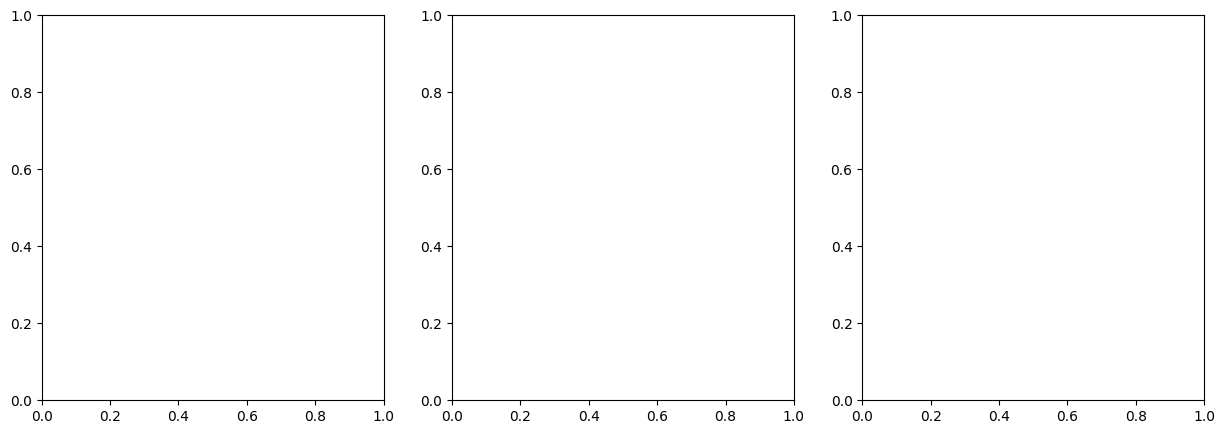

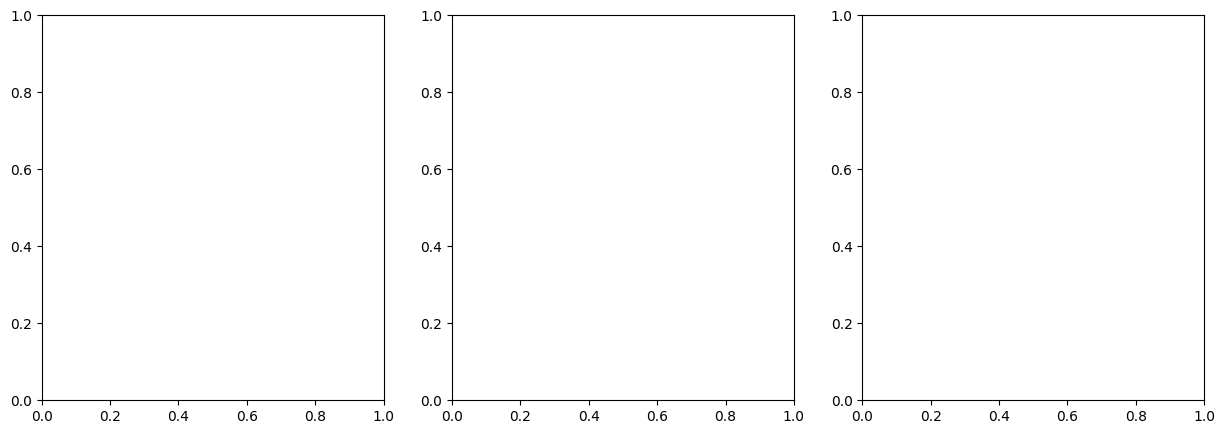

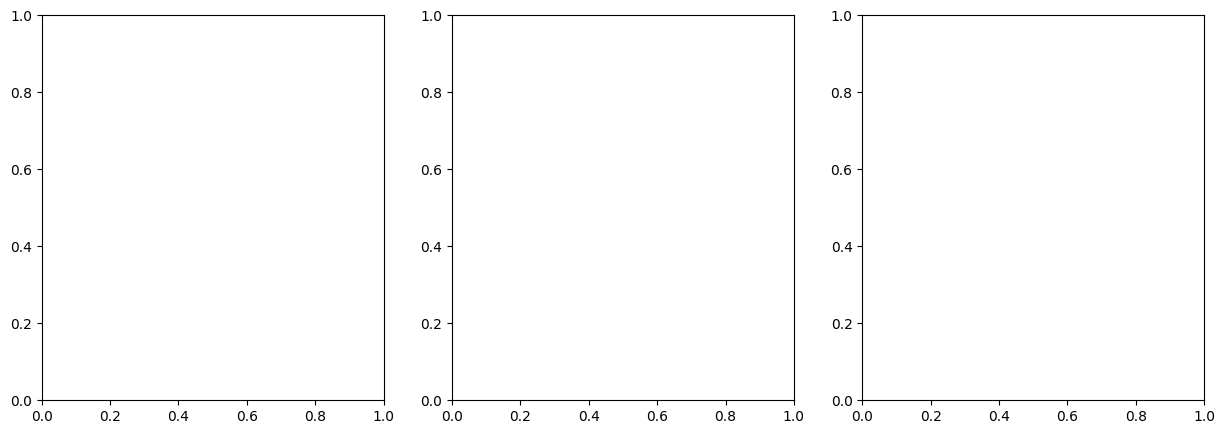

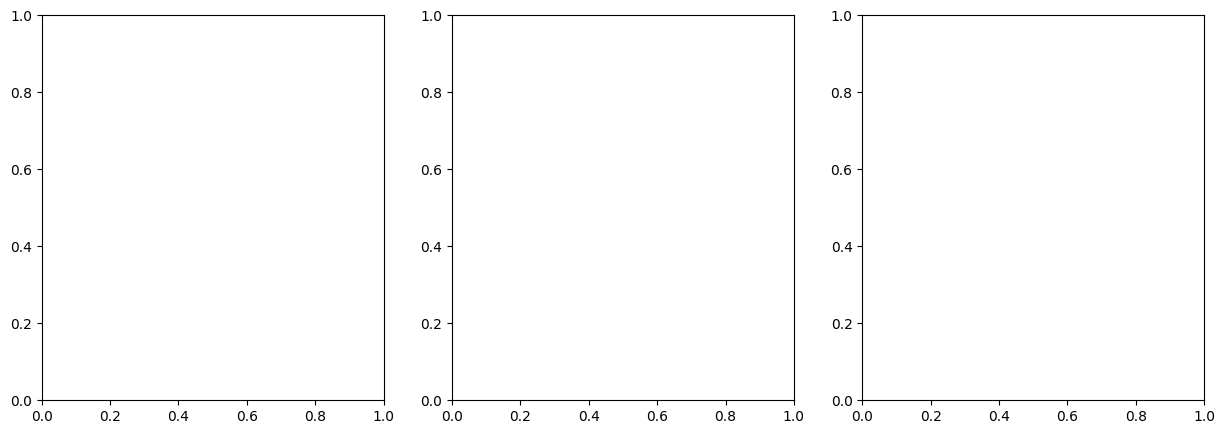

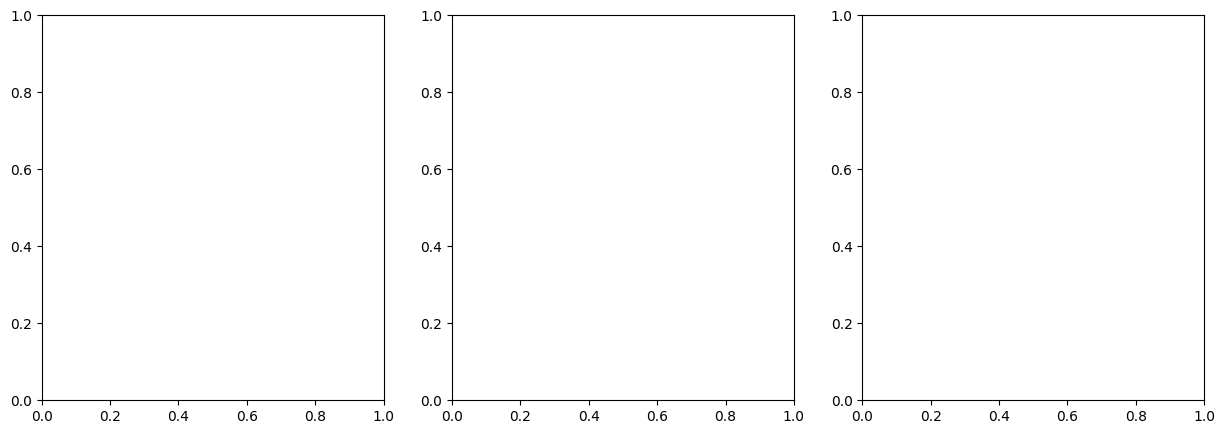

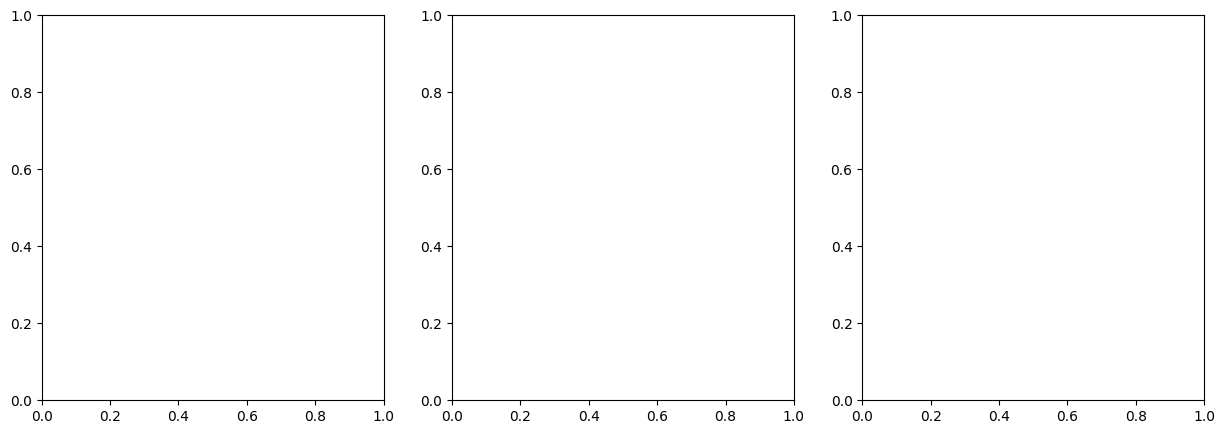

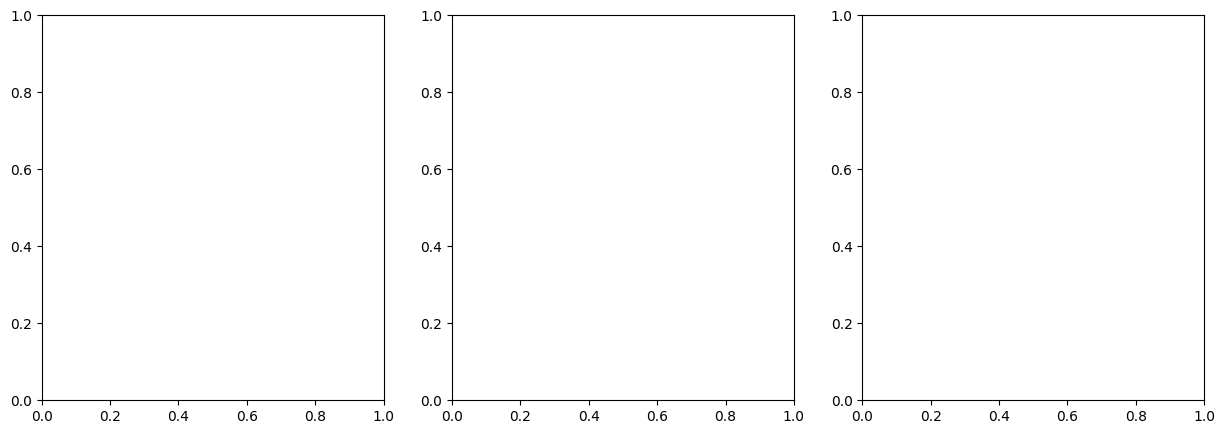

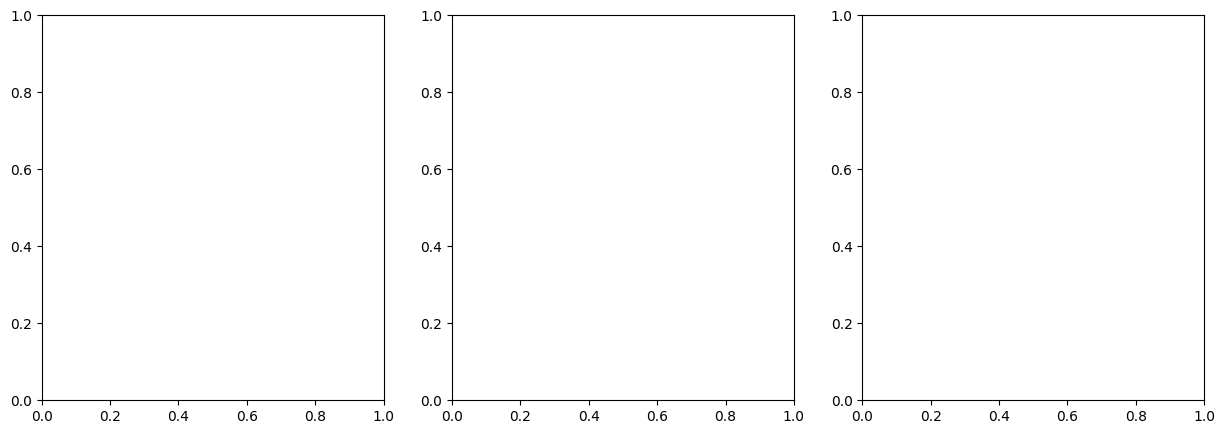

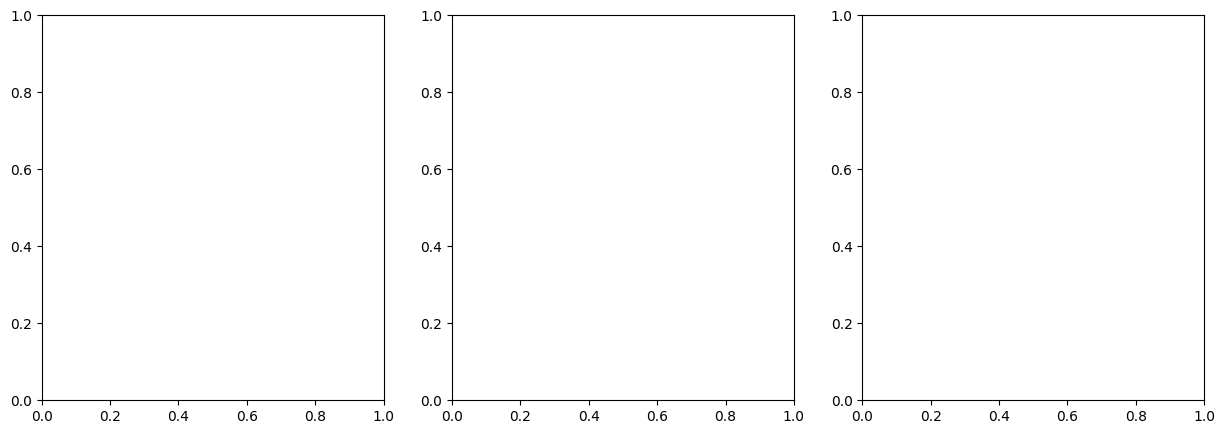

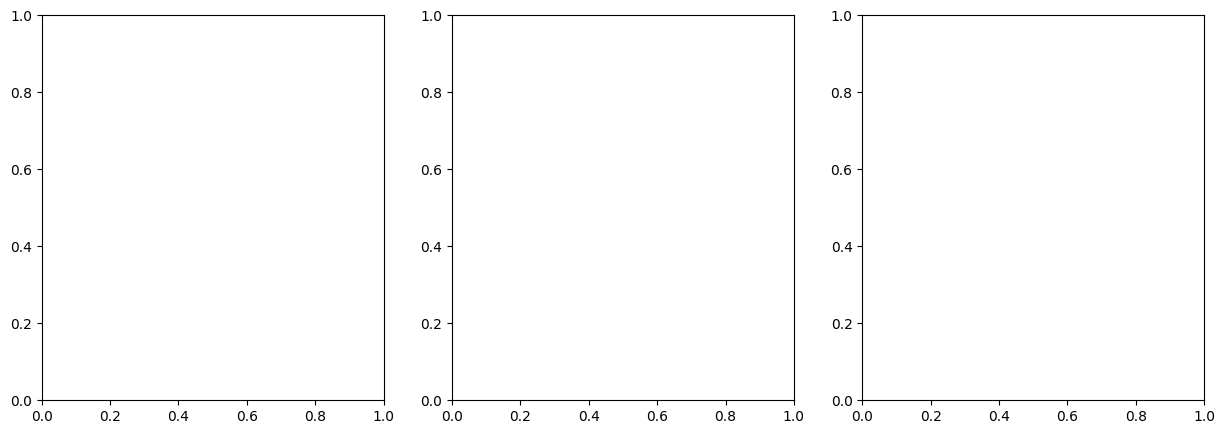

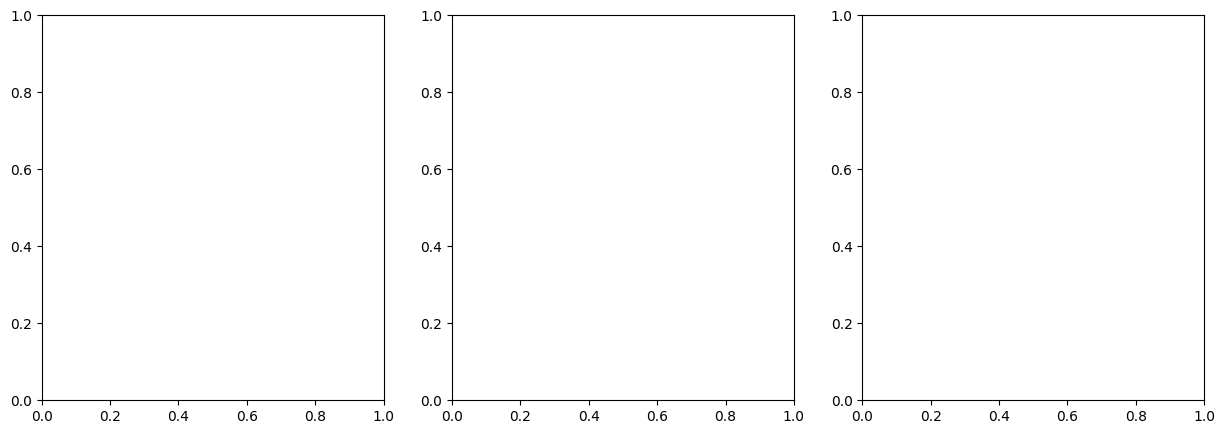

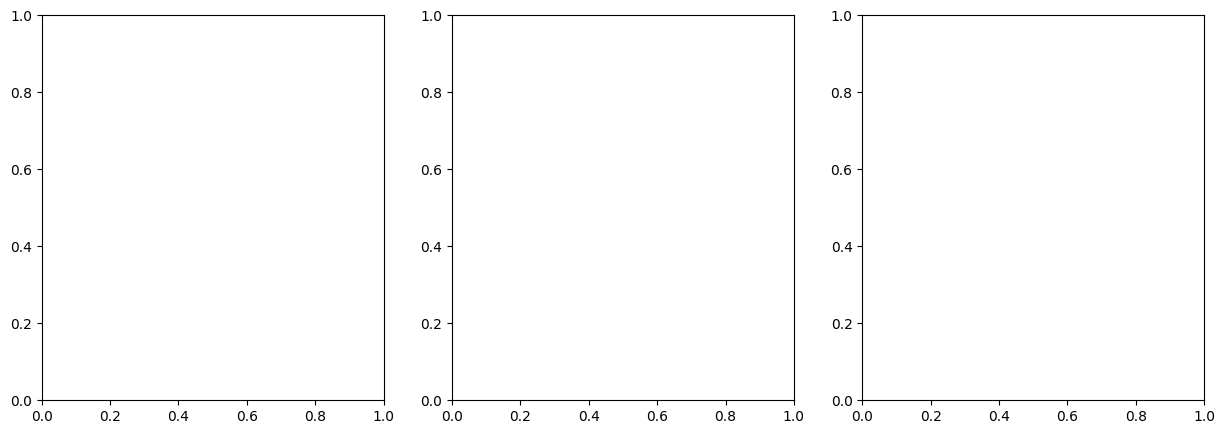

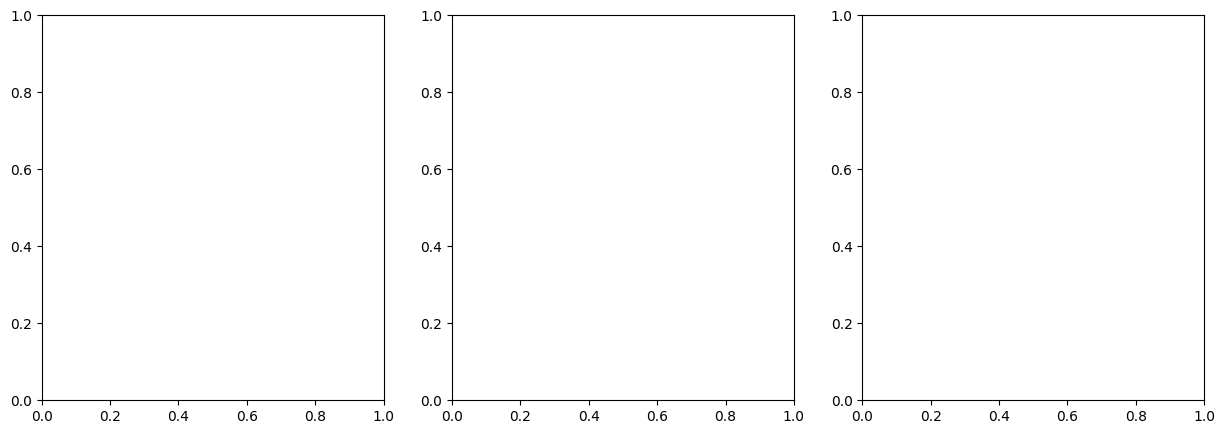

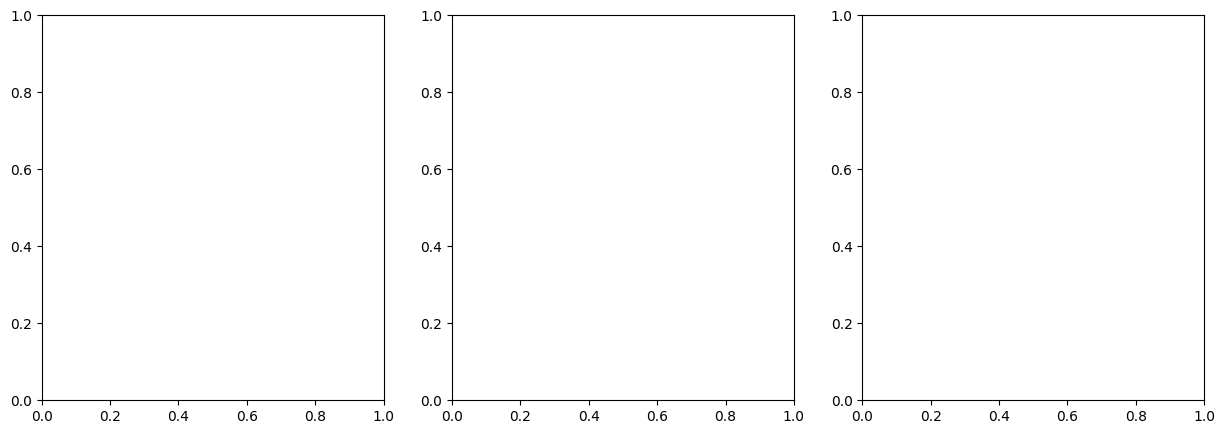

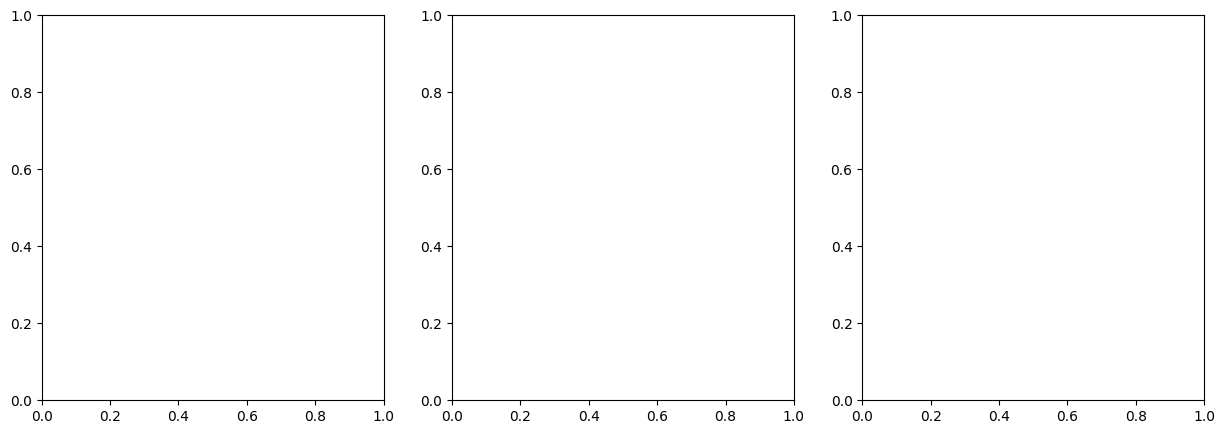

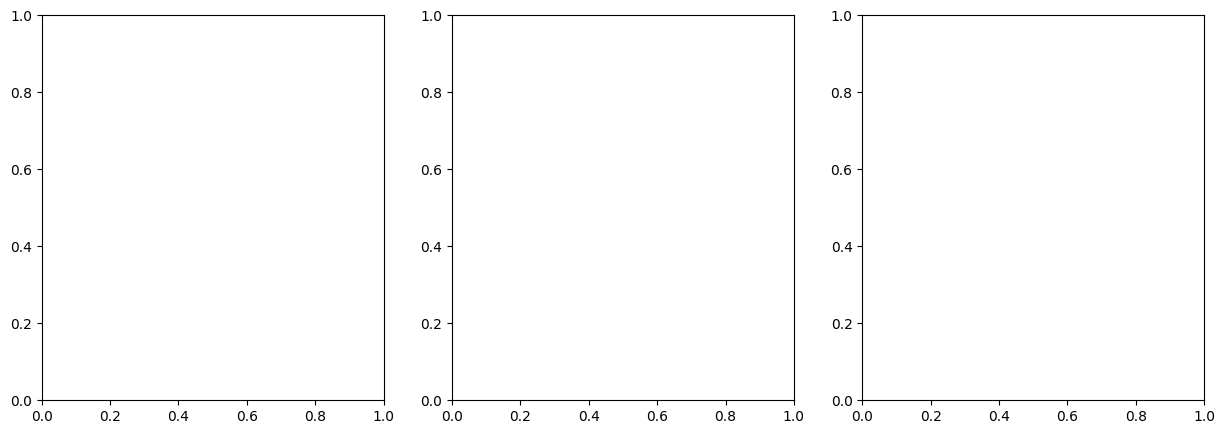

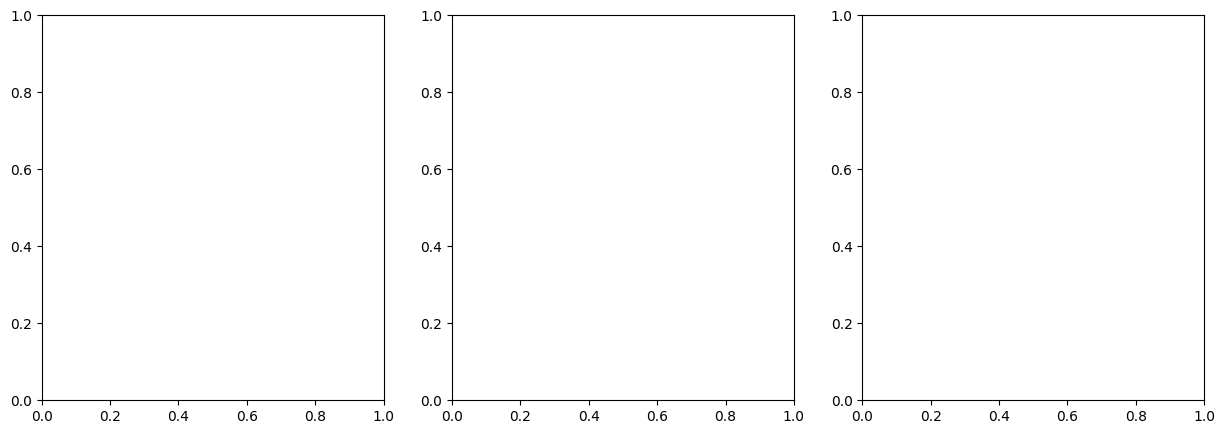

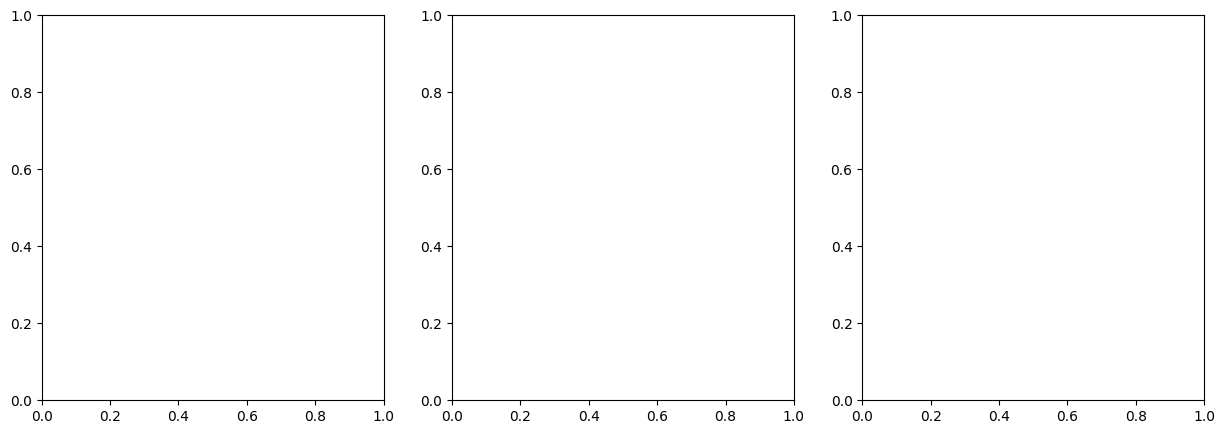

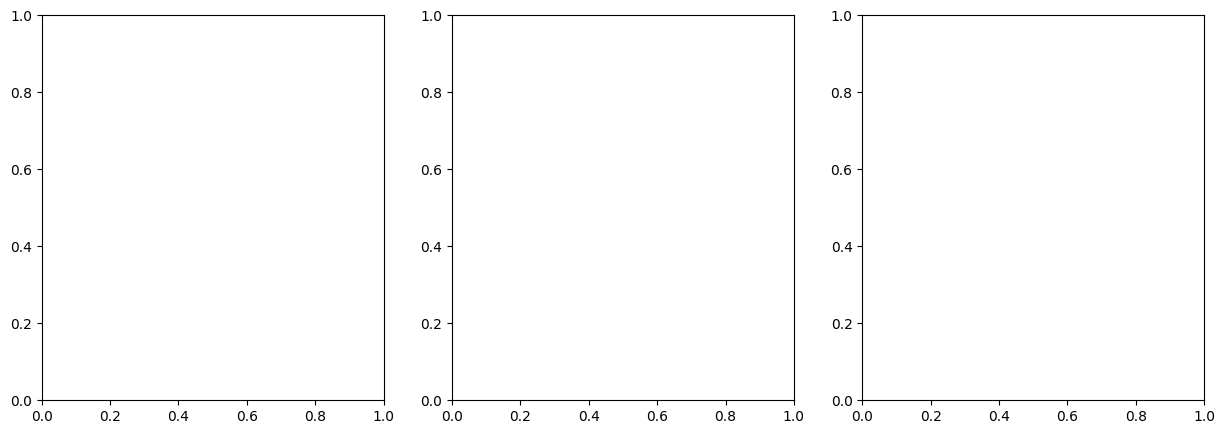

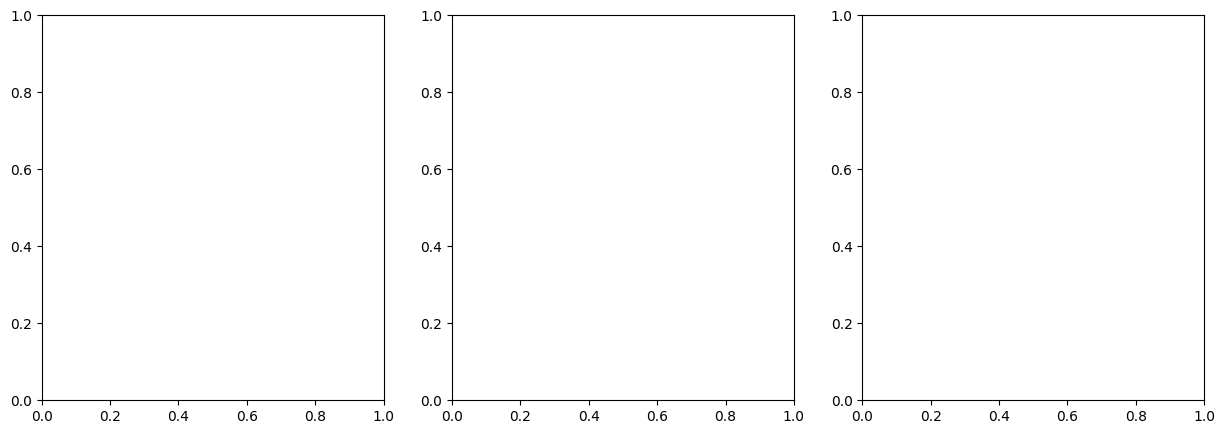

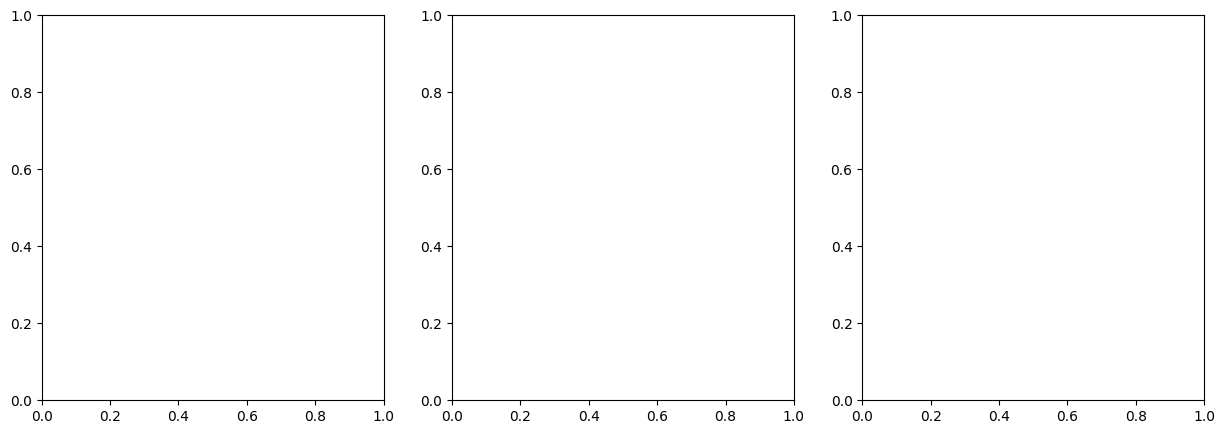

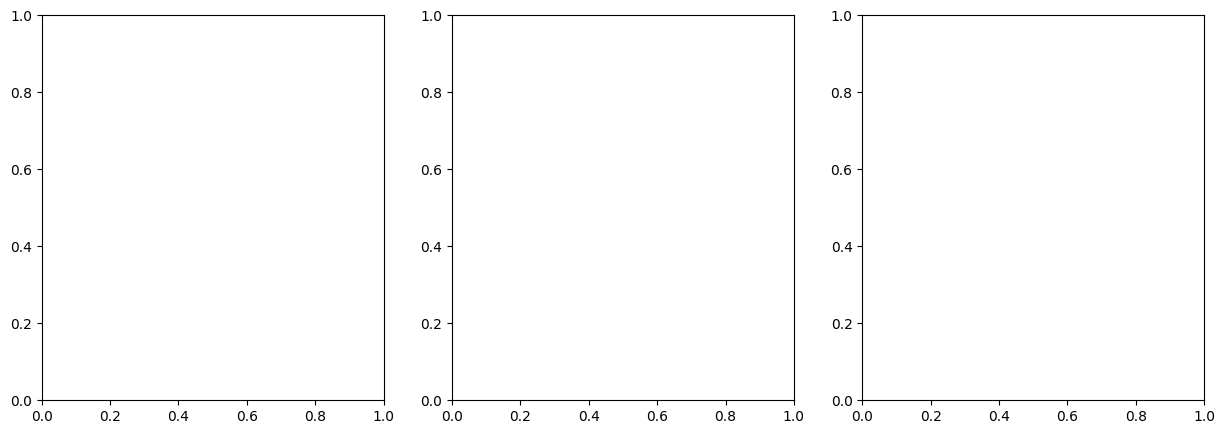

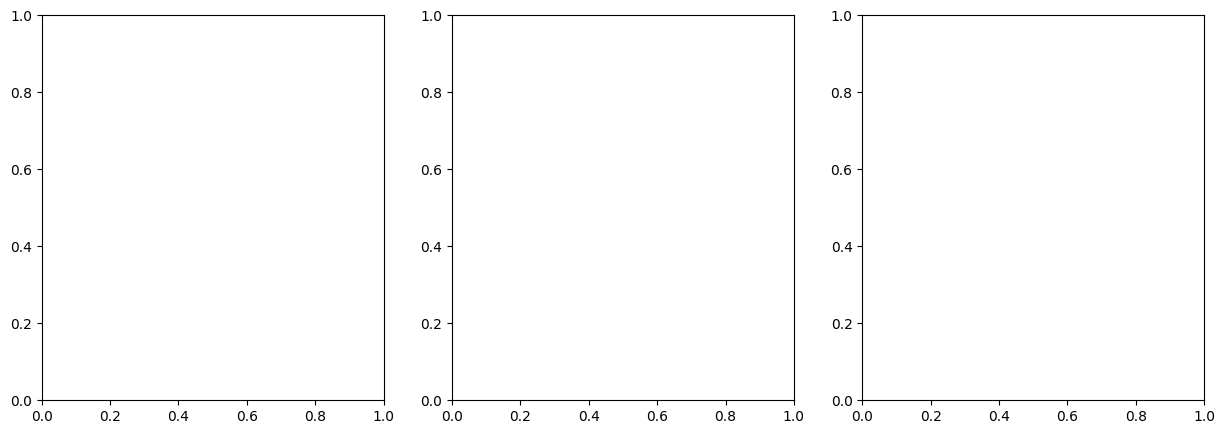

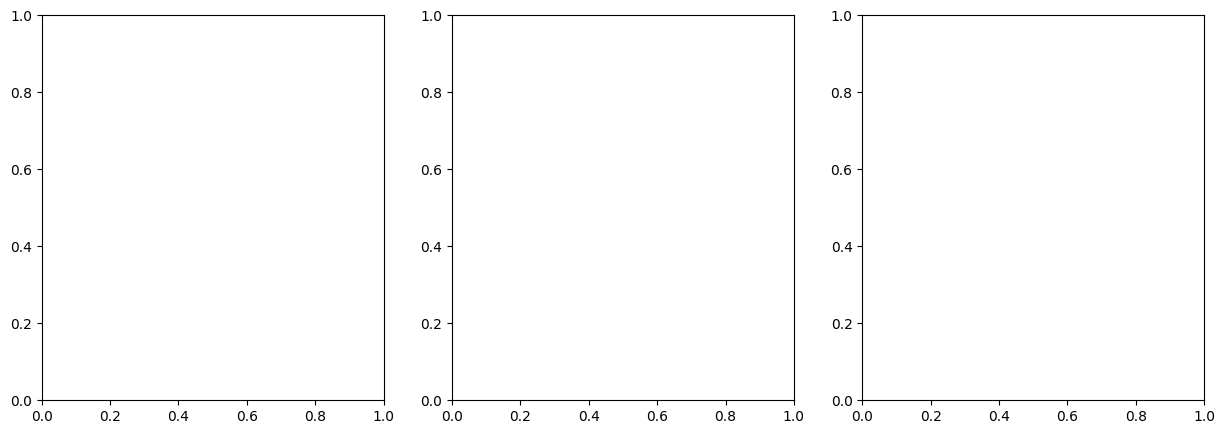

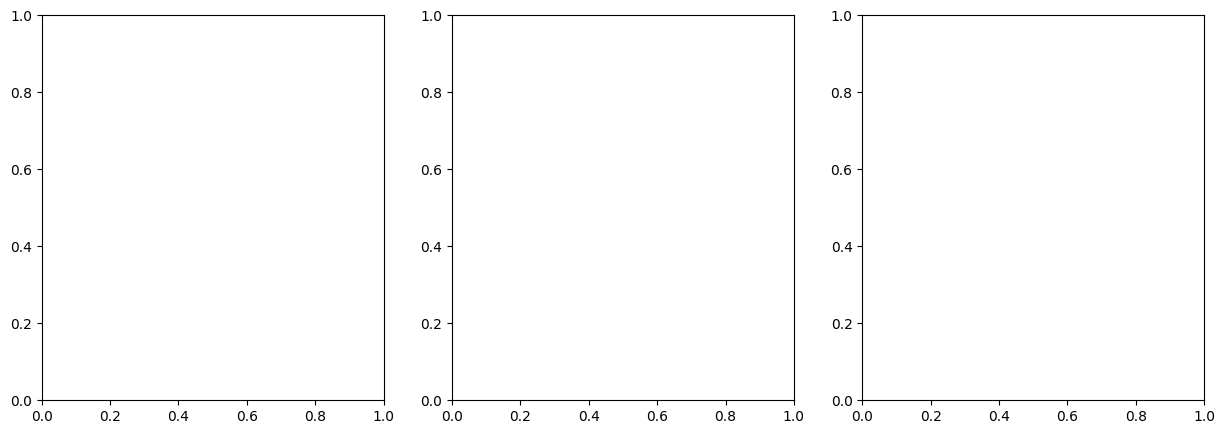

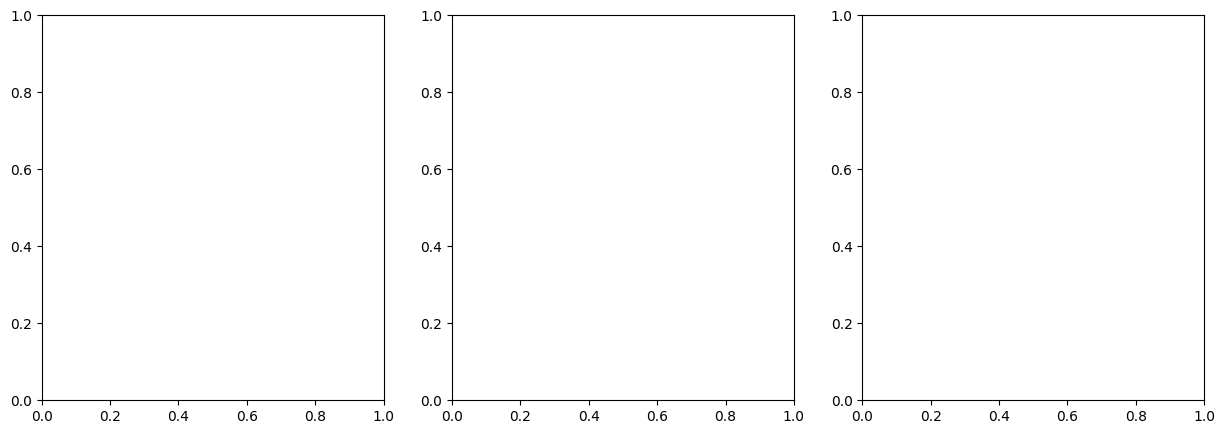

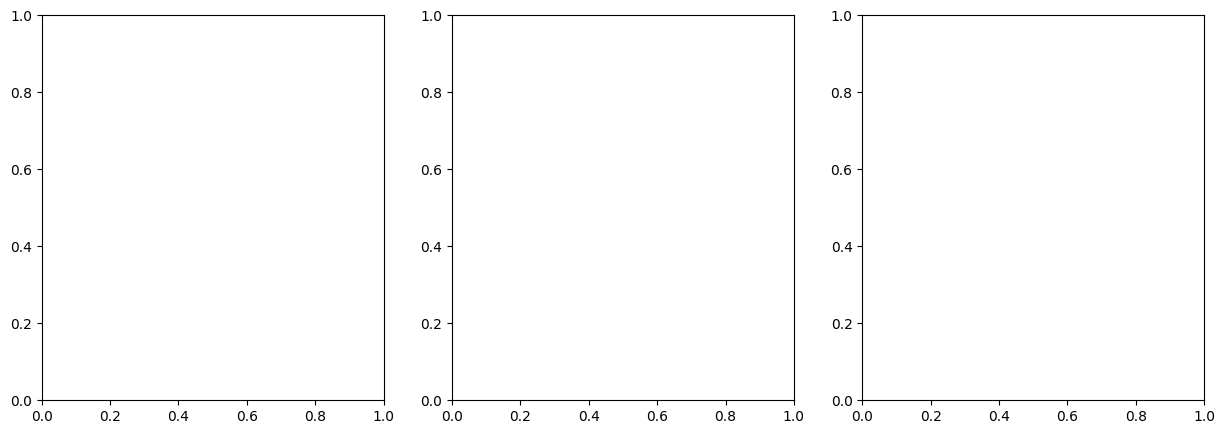

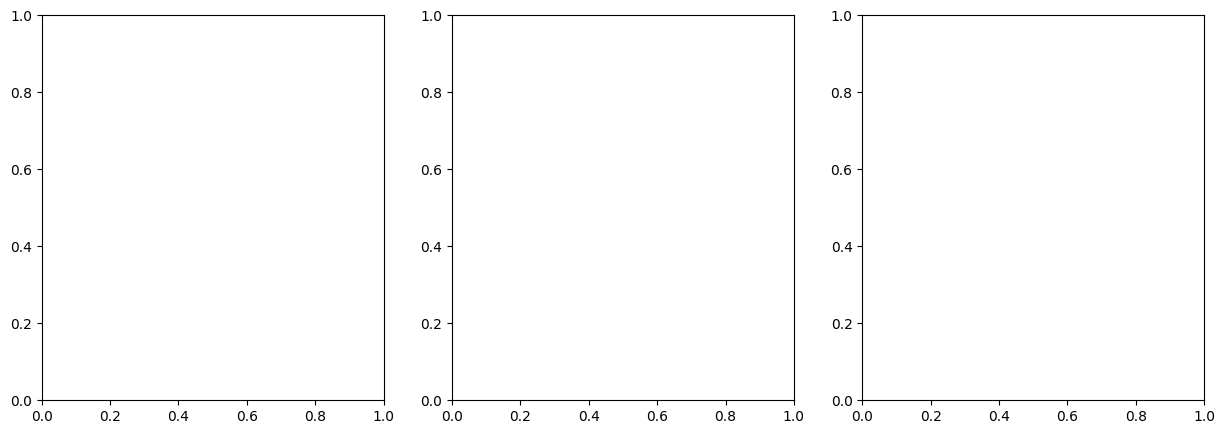

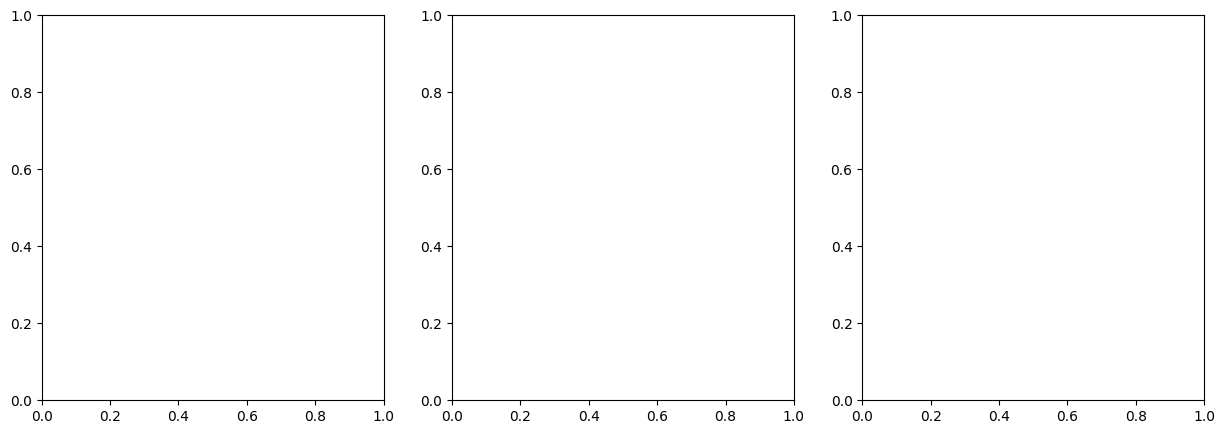

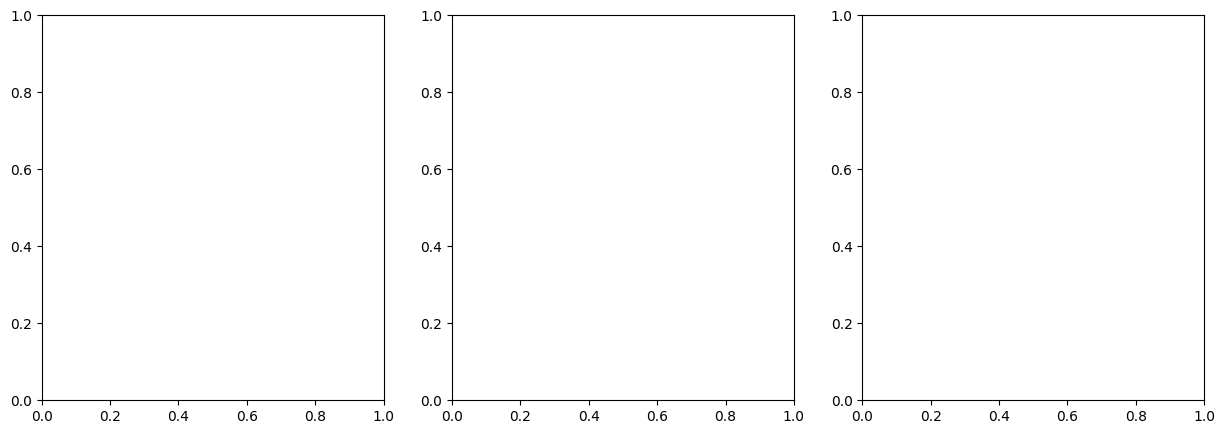

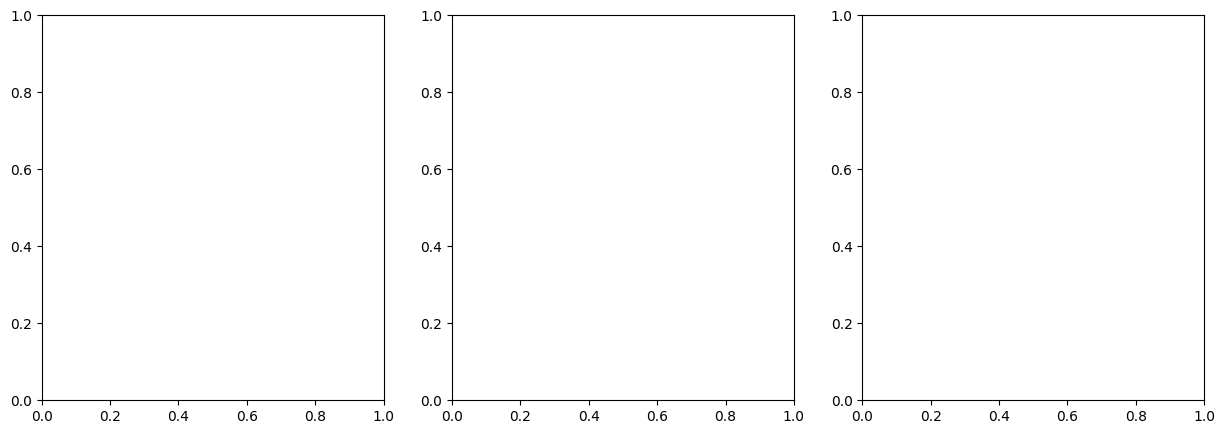

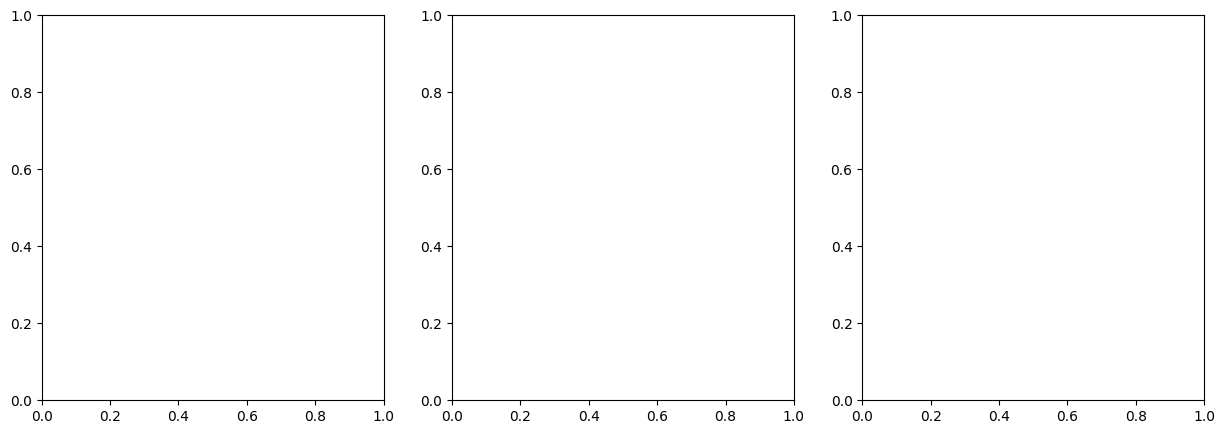

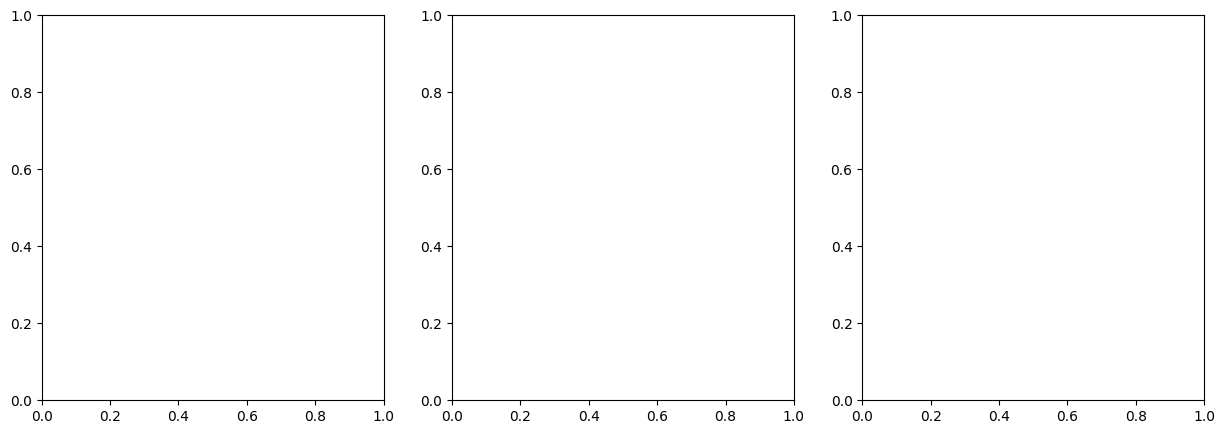

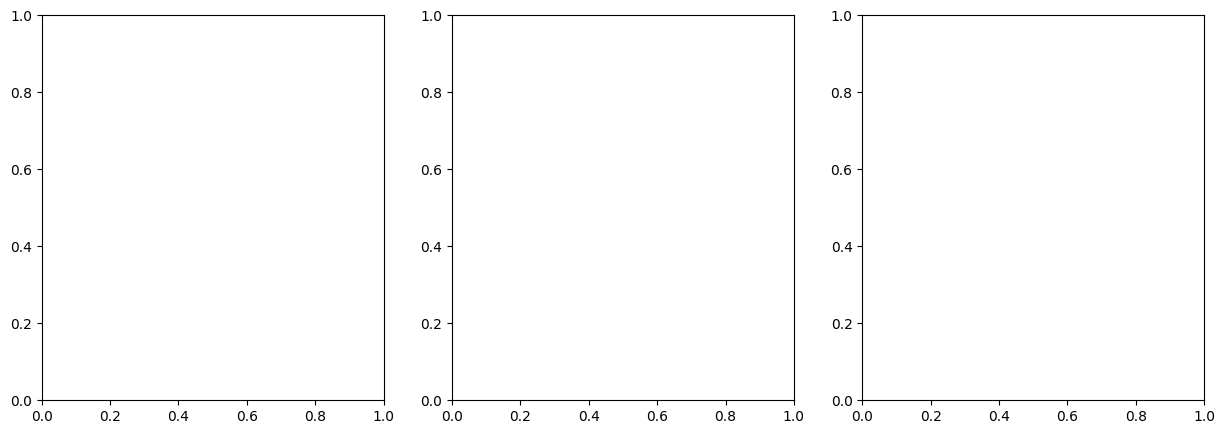

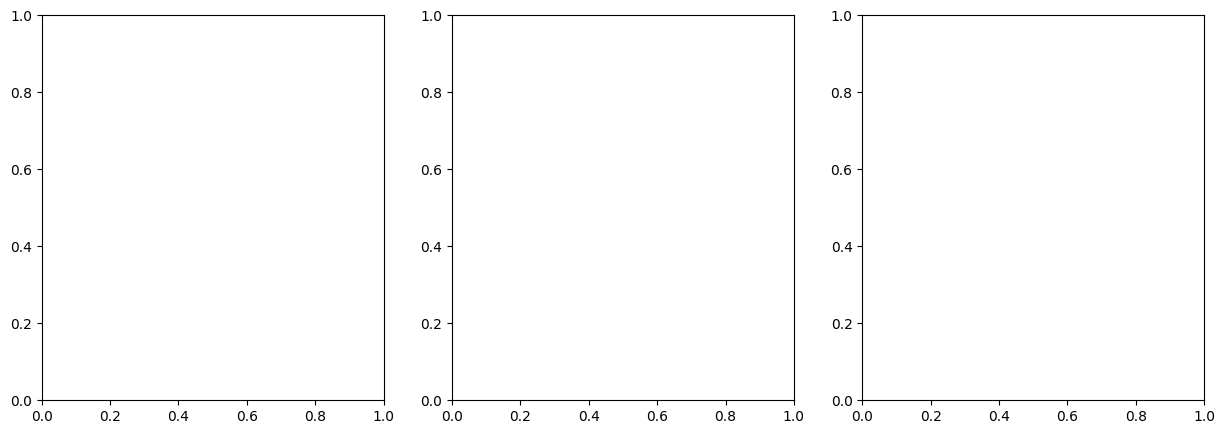

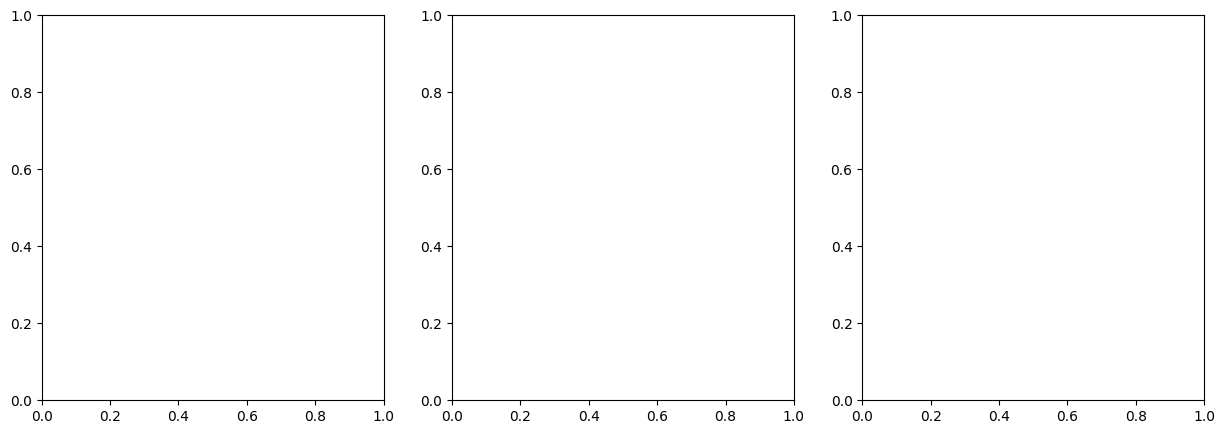

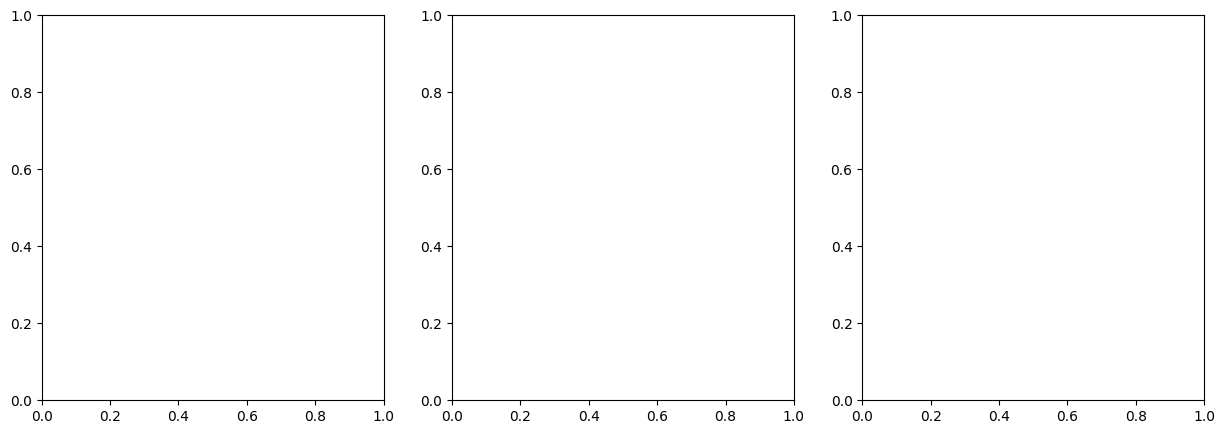

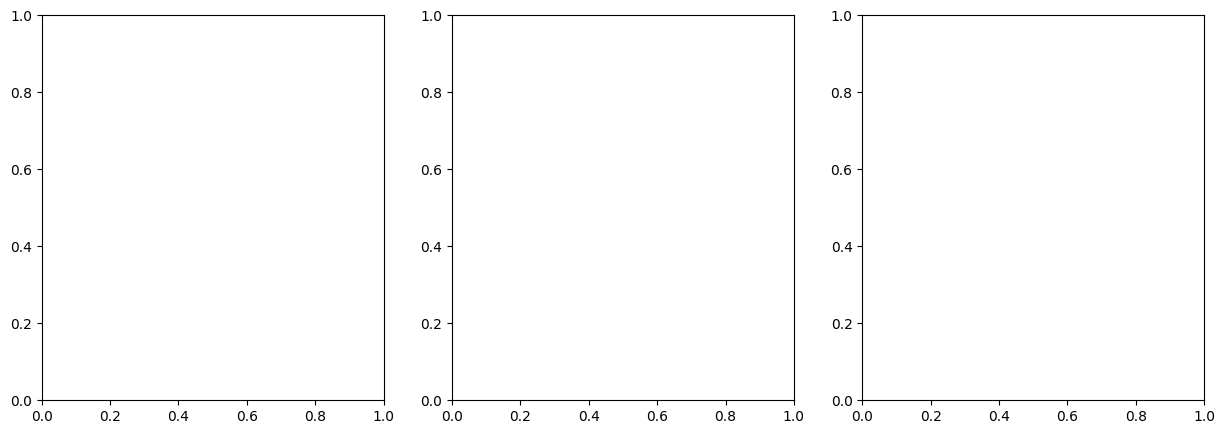

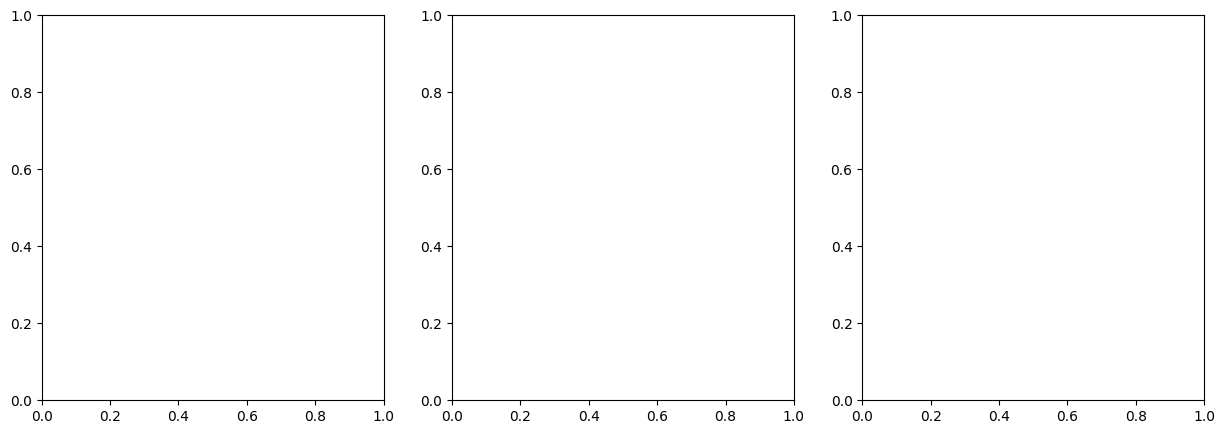

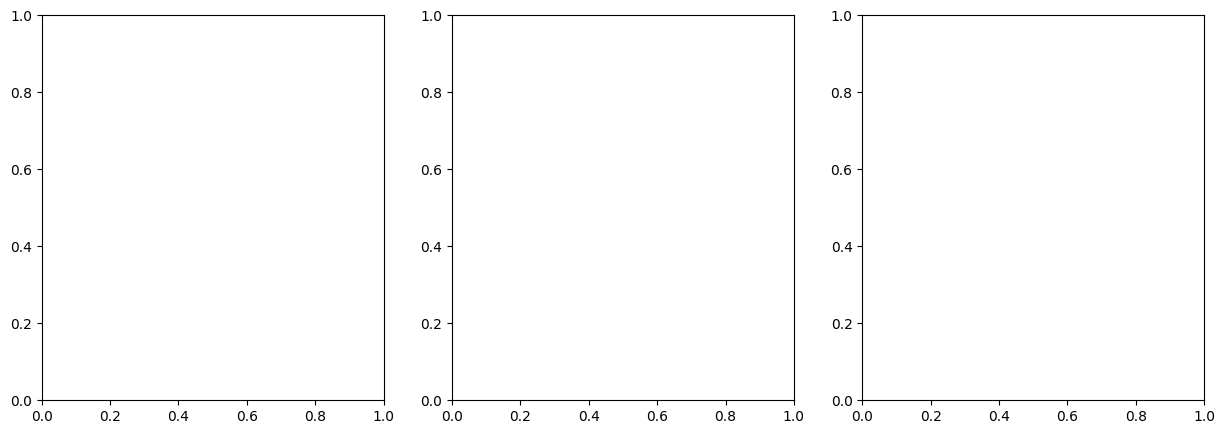

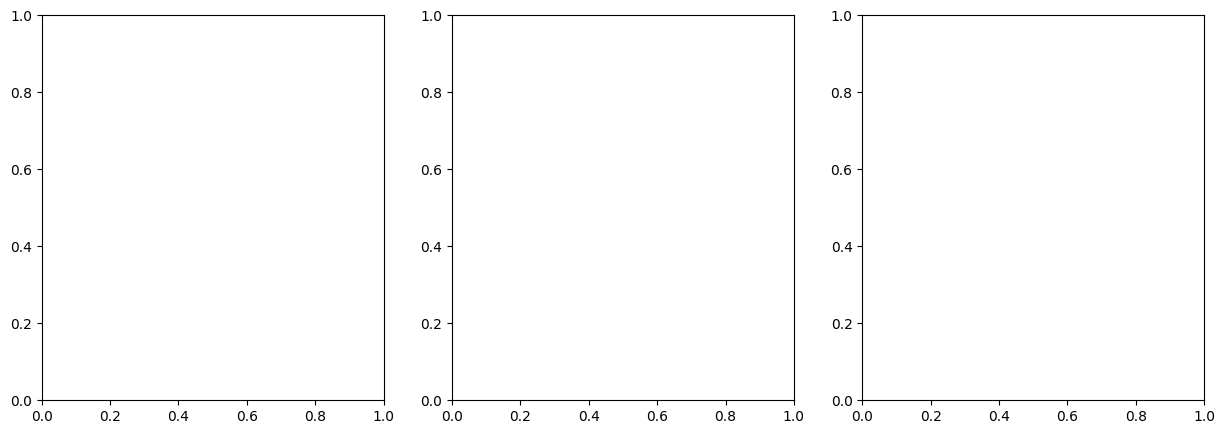

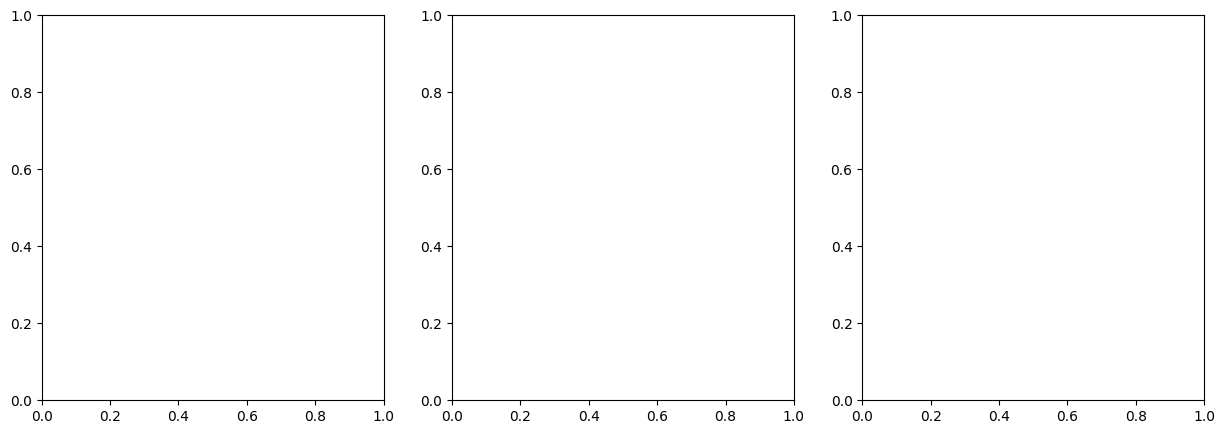

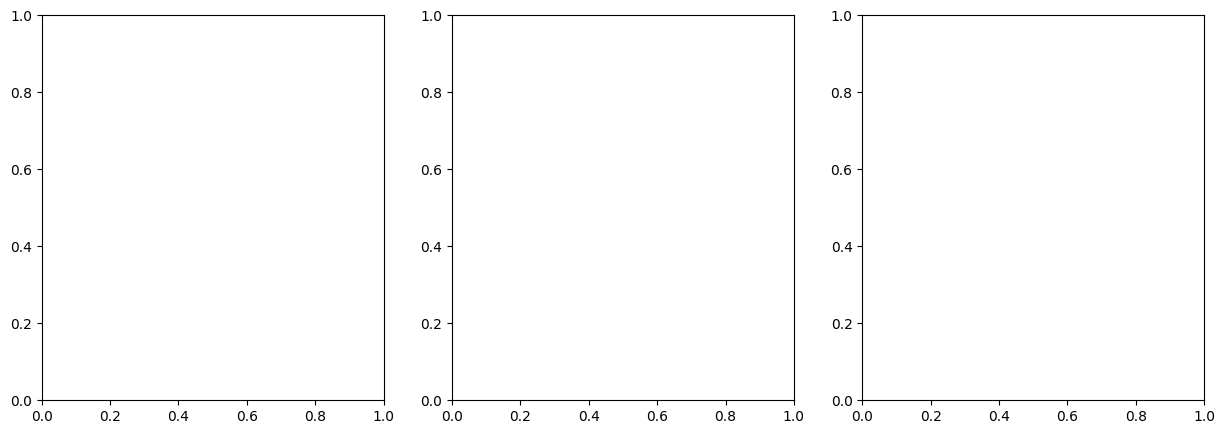

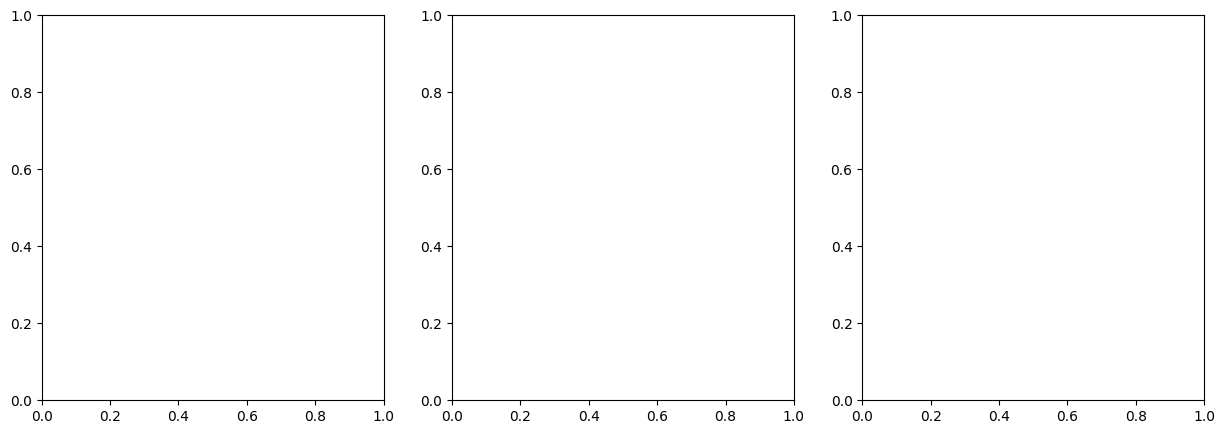

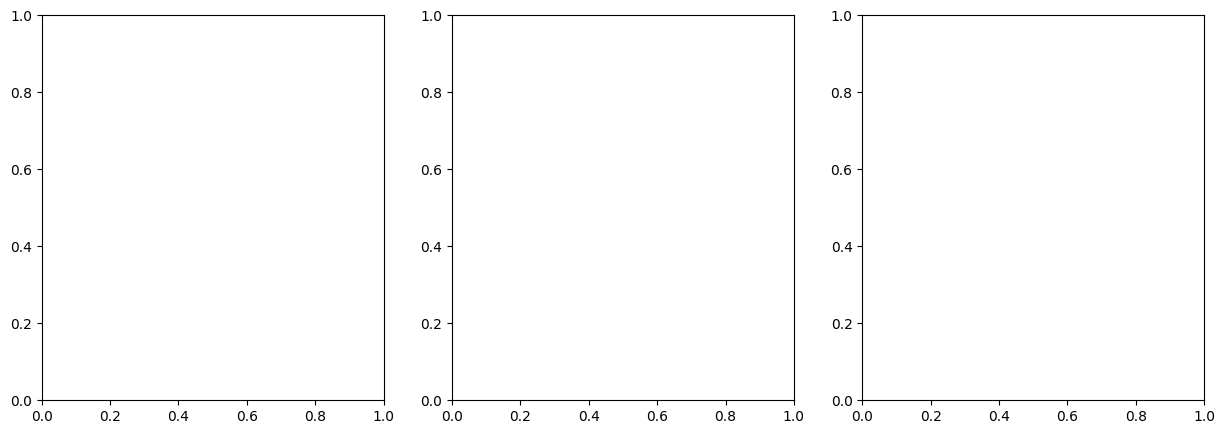

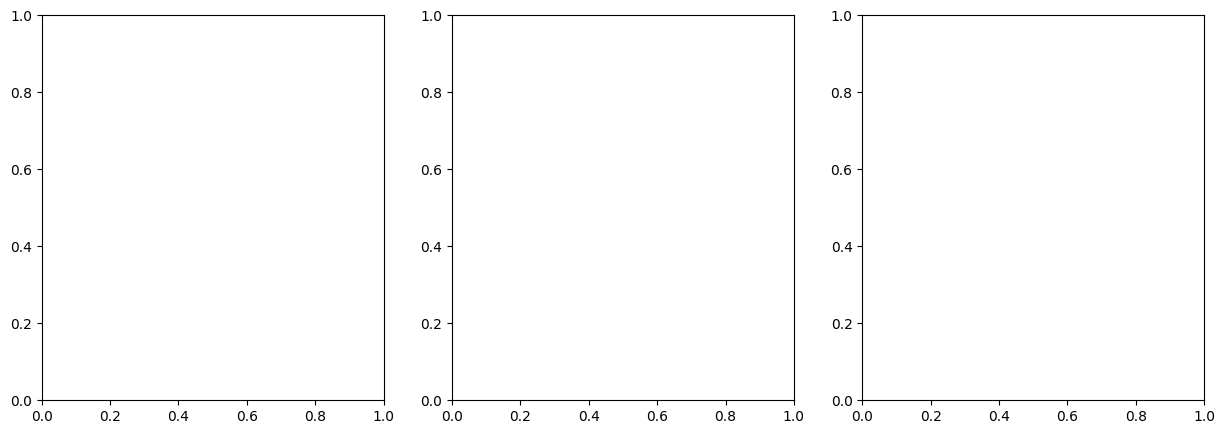

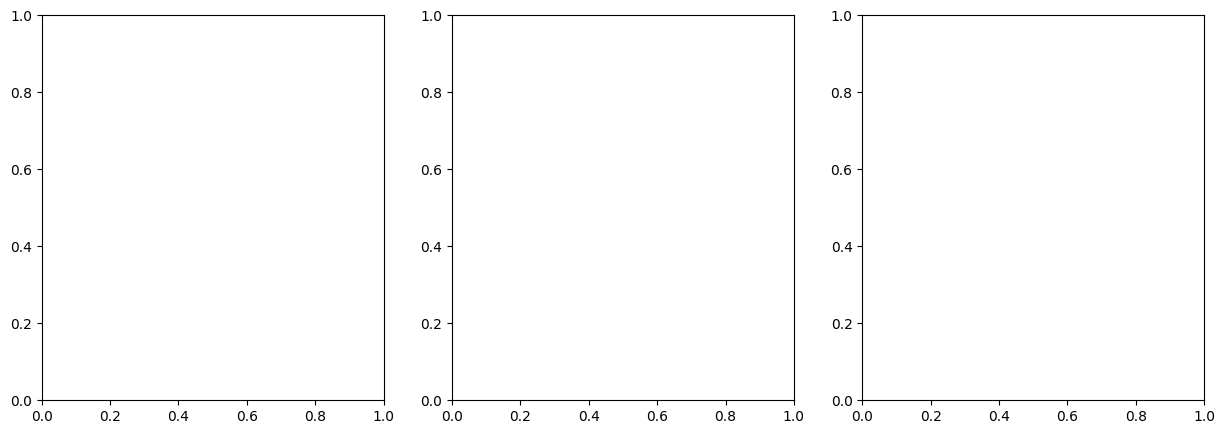

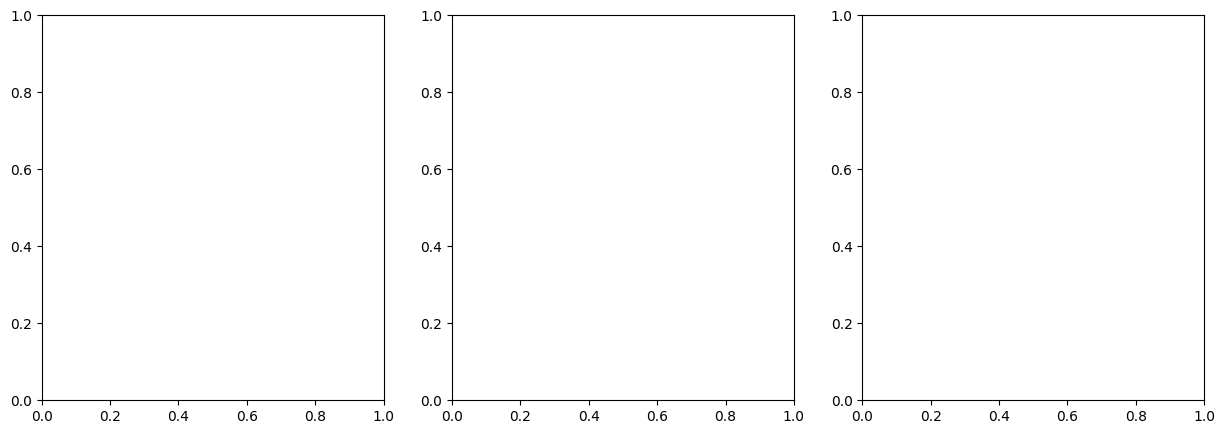

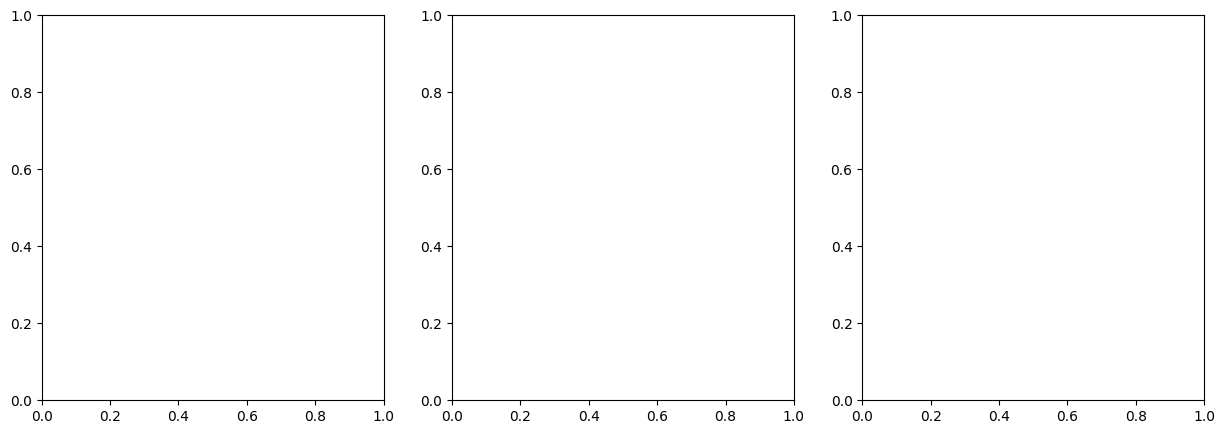

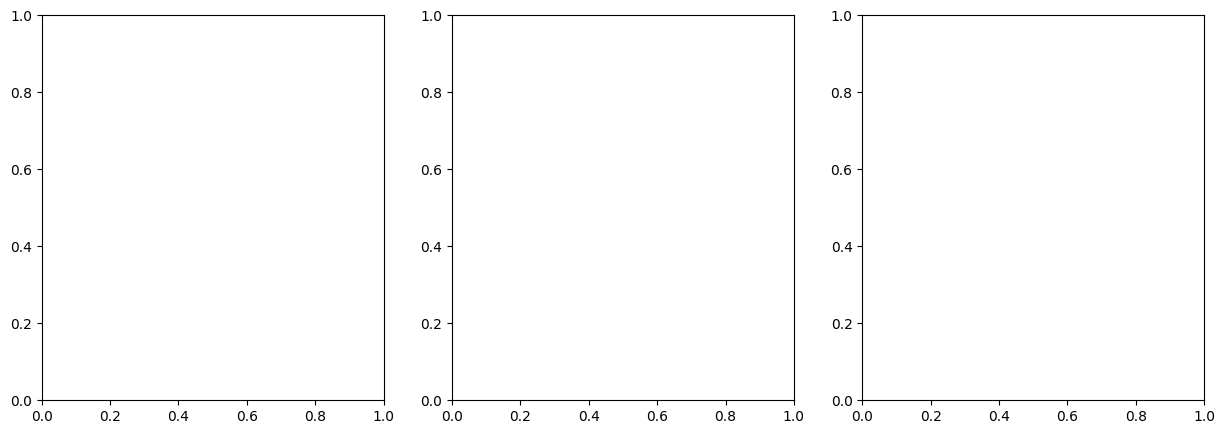

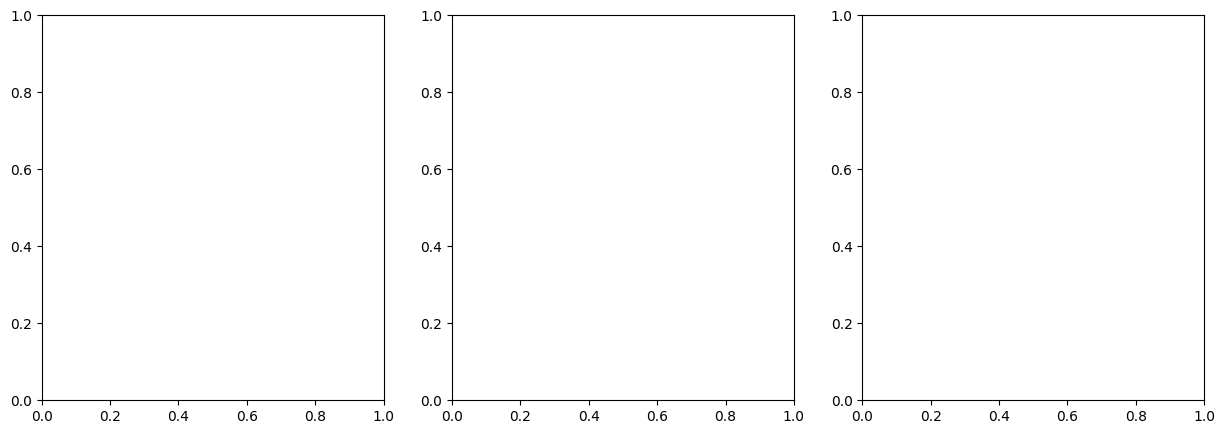

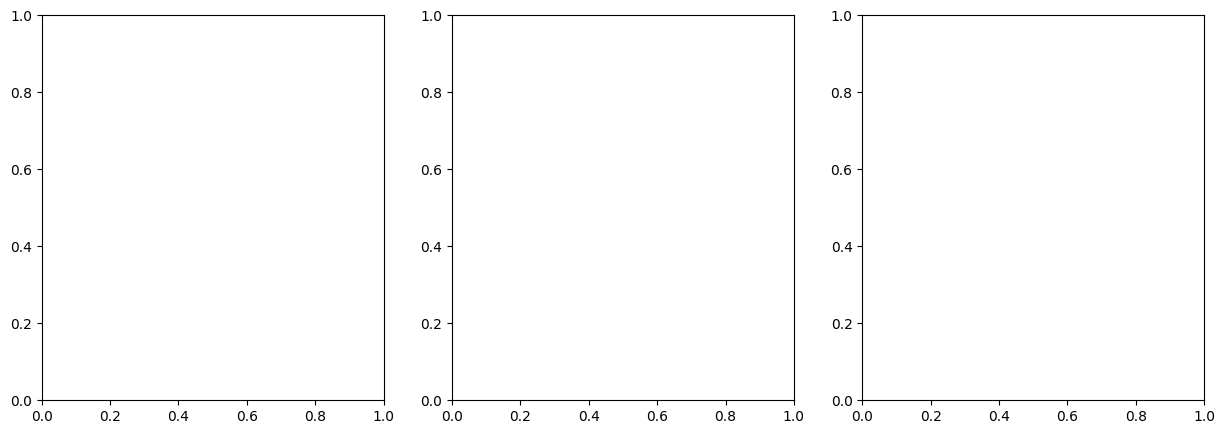

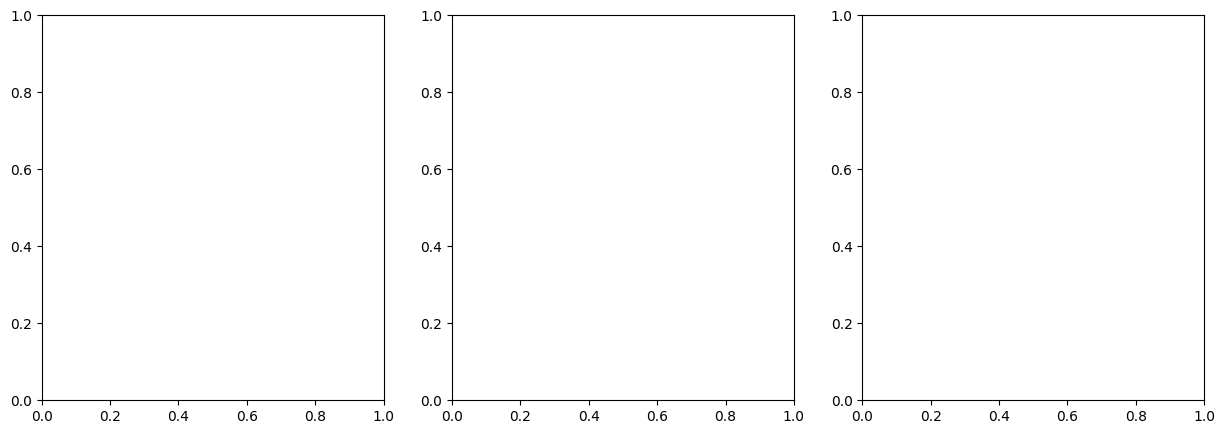

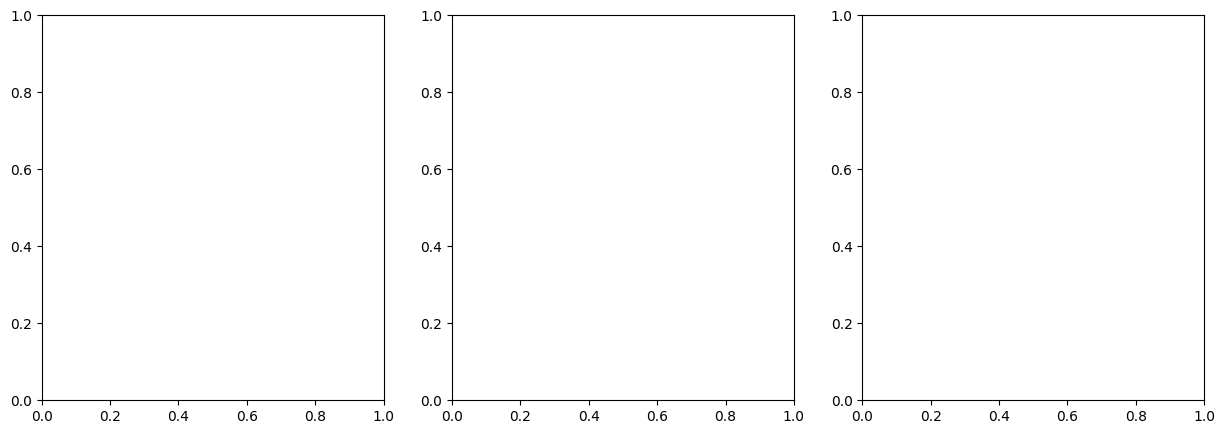

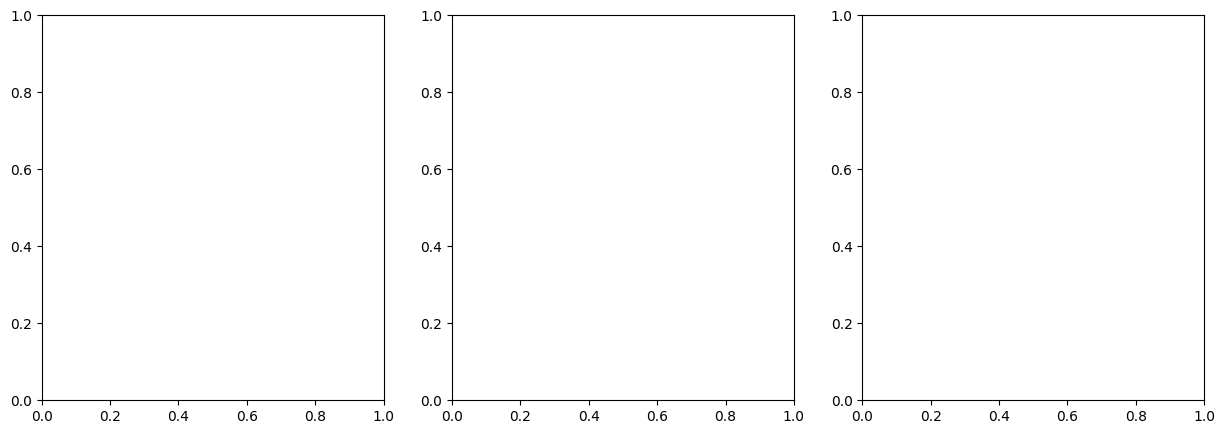

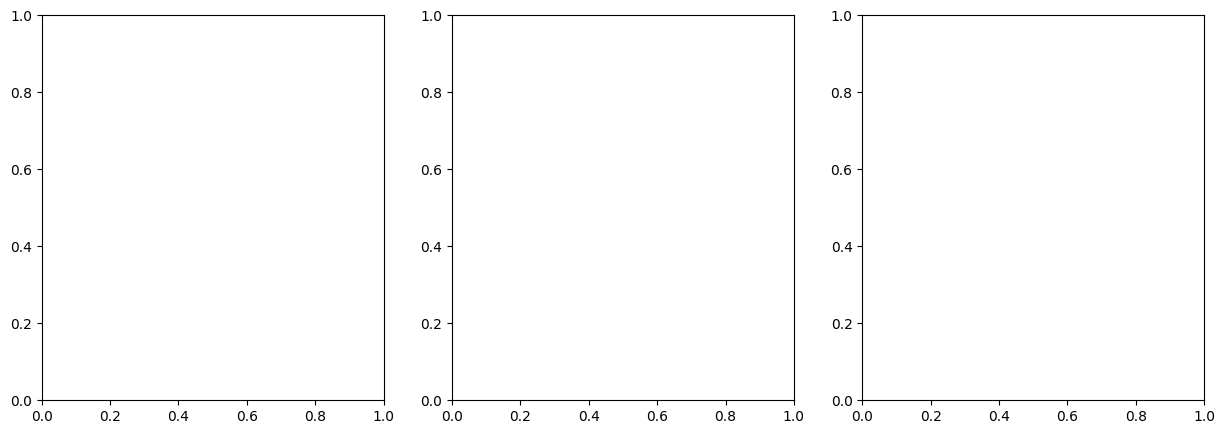

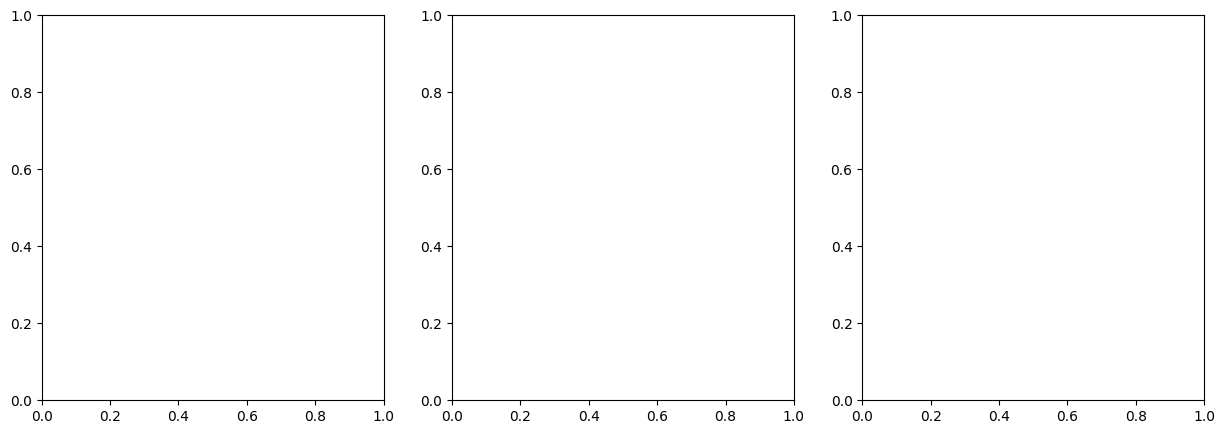

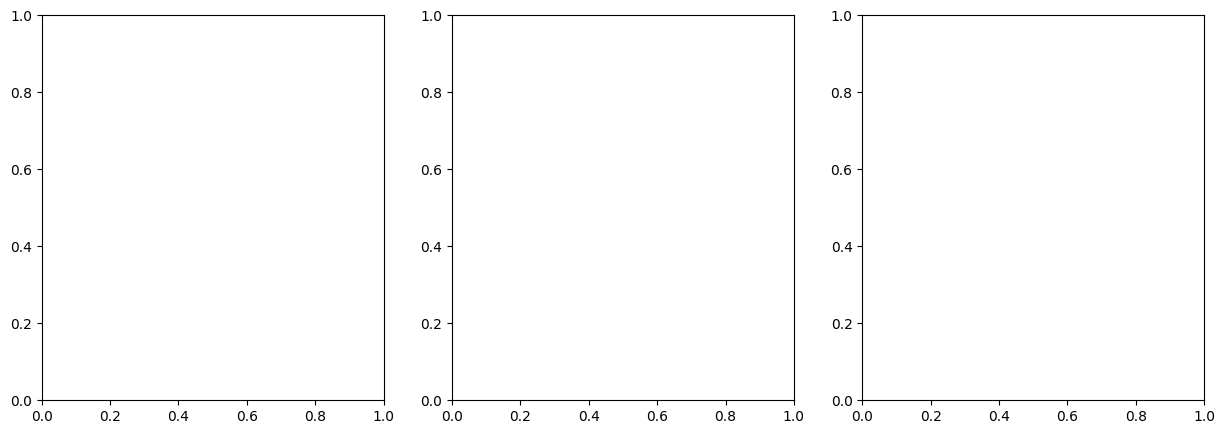

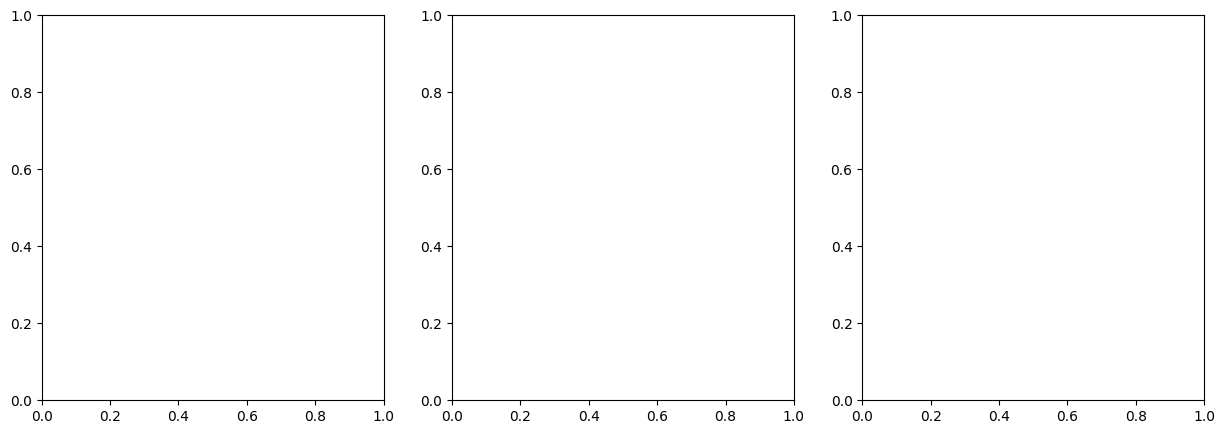

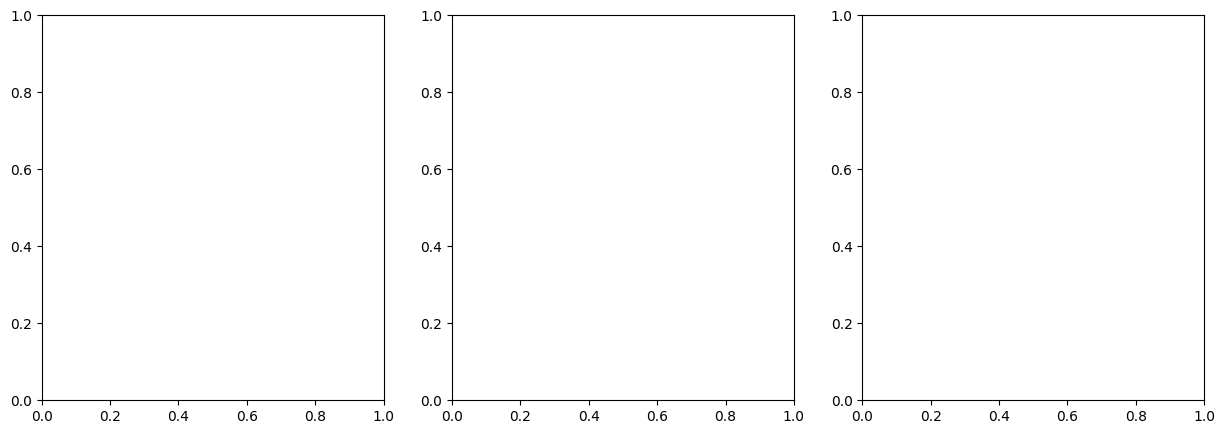

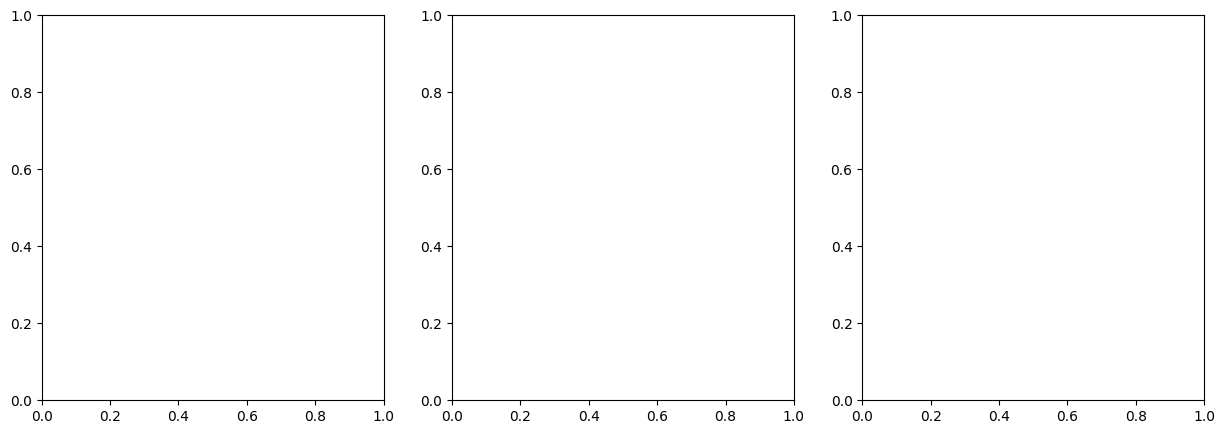

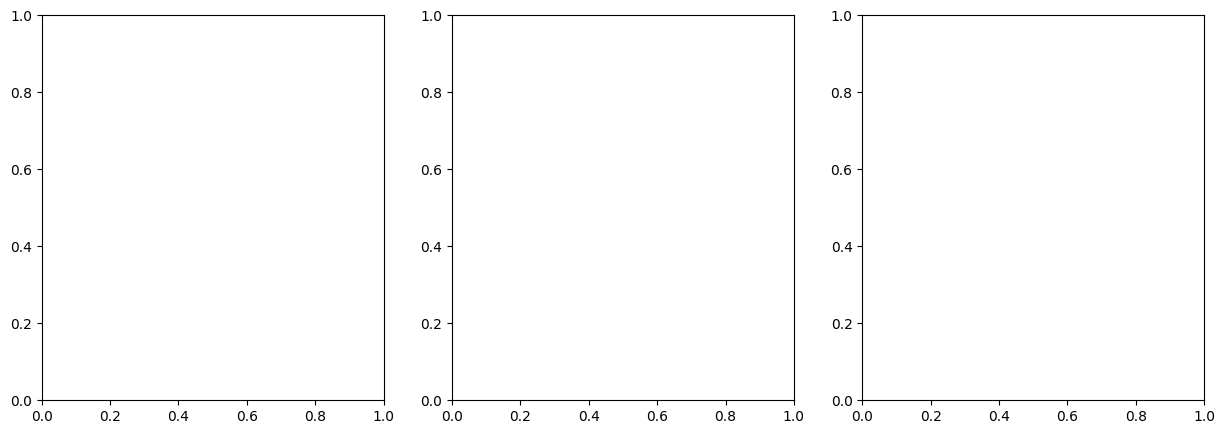

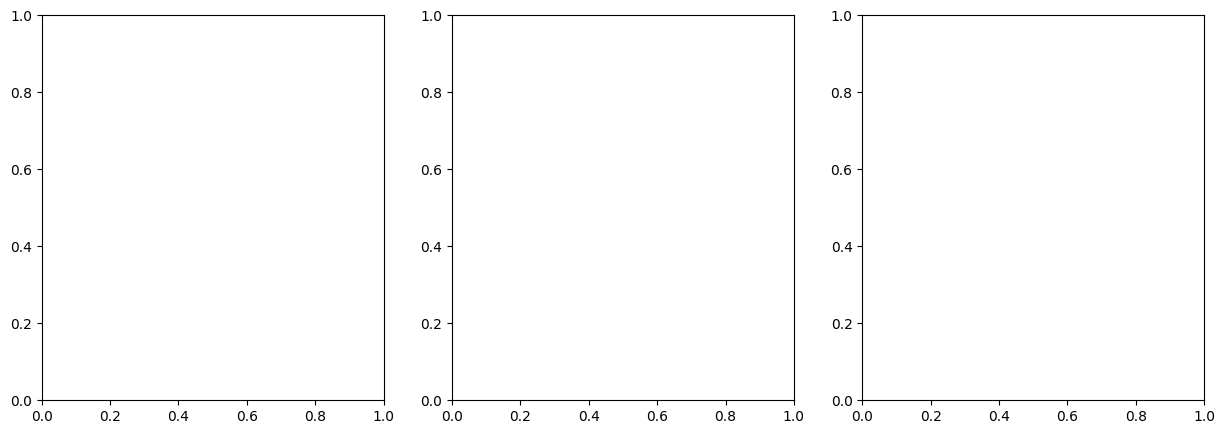

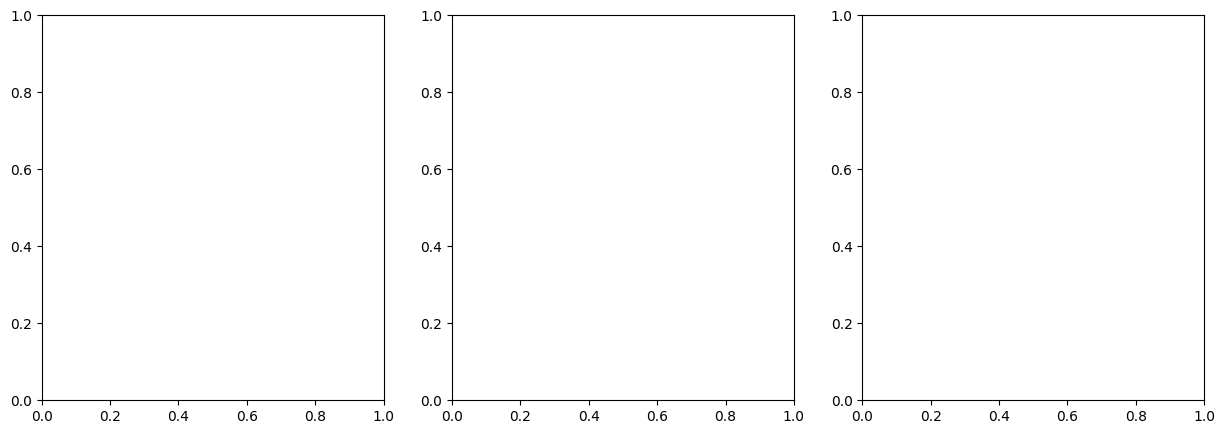

In [11]:
print(f"\n--- Starting K-Fold Cross-Validation Training ({CONFIG.N_SPLITS} folds) ---")
kfold = KFold(n_splits=CONFIG.N_SPLITS, shuffle=True, random_state=CONFIG.RANDOM_STATE)
all_fold_best_scores = []

# Chỉ số để truyền vào Dataset là vị trí trong list all_images_np và all_masks_np
dataset_indices = np.arange(len(all_images_np))

for fold, (train_idx_positions, val_idx_positions) in enumerate(kfold.split(dataset_indices)):
    # train_idx_positions và val_idx_positions là các chỉ số vị trí trong all_images_np
    best_score_for_fold = run_fold_training(fold, train_idx_positions, val_idx_positions, all_images_np, all_masks_np)
    all_fold_best_scores.append(best_score_for_fold)

print("\n=============== K-FOLD TRAINING SUMMARY ===============")
for i, score in enumerate(all_fold_best_scores):
    print(f"Fold {i+1} Best Dice Score: {score:.4f}")

if all_fold_best_scores: # Kiểm tra xem list có rỗng không
    print(f"\nAverage Best Dice Score over {CONFIG.N_SPLITS} folds: {np.mean(all_fold_best_scores):.4f} "
          f"| Std Dev: {np.std(all_fold_best_scores):.4f}")
else:
    print("No fold scores recorded (e.g., training was skipped or N_SPLITS was 0).")


# Gọi hàm generate_submission sau khi hoàn tất training
generate_submission()
print("\n--- Workflow Completed ---")


--- Starting Prediction on Test Set using Ensembled K-Fold Models ---
Loaded model for fold 1 from best_efficientnet-b1_fold_0.pth
Loaded model for fold 2 from best_efficientnet-b1_fold_1.pth
Loaded model for fold 3 from best_efficientnet-b1_fold_2.pth
Loaded model for fold 4 from best_efficientnet-b1_fold_3.pth
Loaded model for fold 5 from best_efficientnet-b1_fold_4.pth
Loaded model for fold 6 from best_efficientnet-b1_fold_5.pth
Loaded model for fold 7 from best_efficientnet-b1_fold_6.pth
Loaded model for fold 8 from best_efficientnet-b1_fold_7.pth
Loaded model for fold 9 from best_efficientnet-b1_fold_8.pth


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_19/1946806971.py:48: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.OneOf([A.ElasticTransform(p=0.5, alpha=100, sigma=100 * 0.05, alpha_affine=100 * 0.03), A.GridDistortion(p=0.5)], p=0.2),


Loaded model for fold 10 from best_efficientnet-b1_fold_9.pth


Generating predictions:  10%|█         | 20/192 [00:12<02:11,  1.31it/s]/tmp/ipykernel_19/2223074240.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # figsize=... để điều chỉnh kích thước cửa sổ
Generating predictions: 100%|██████████| 192/192 [02:36<00:00,  1.23it/s]



Submission file 'submission.csv' created successfully!
        ID                                               Mask
0  0001087  97746 26 98764 40 99785 48 100806 54 101825 63...
1  0001088  151972 26 152980 56 153993 83 155012 100 15603...
2  0001089  87621 14 88640 24 89659 33 90678 40 91698 46 9...
3  0001090  276893 30 277913 40 278933 48 279954 54 280975...
4  0001091  107146 19 108157 1 108167 25 109179 39 110202 ...

--- Workflow Completed (Submission Only Rerun) ---


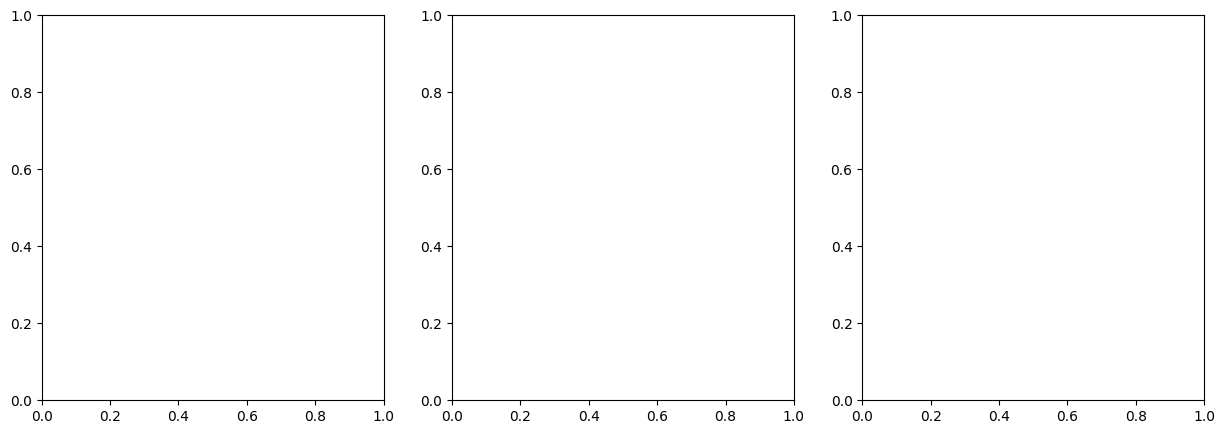

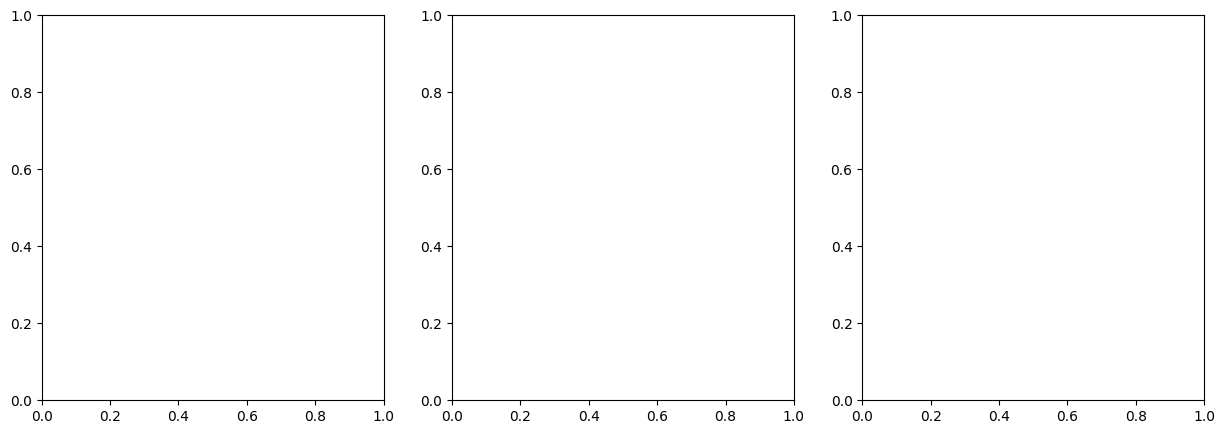

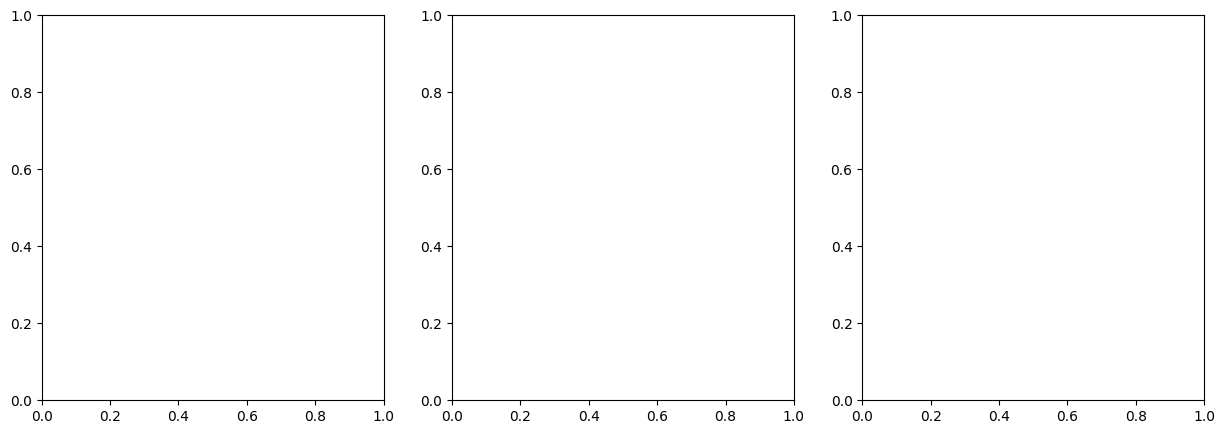

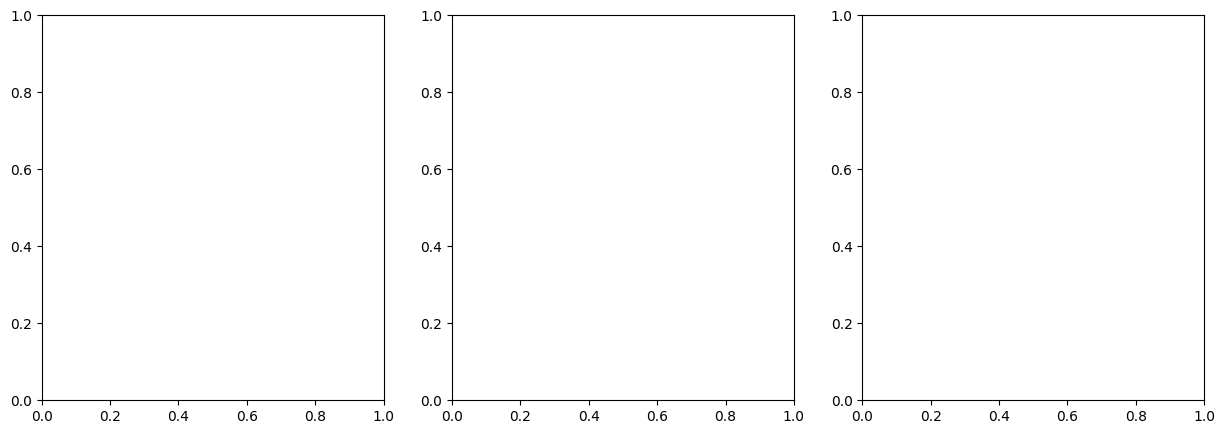

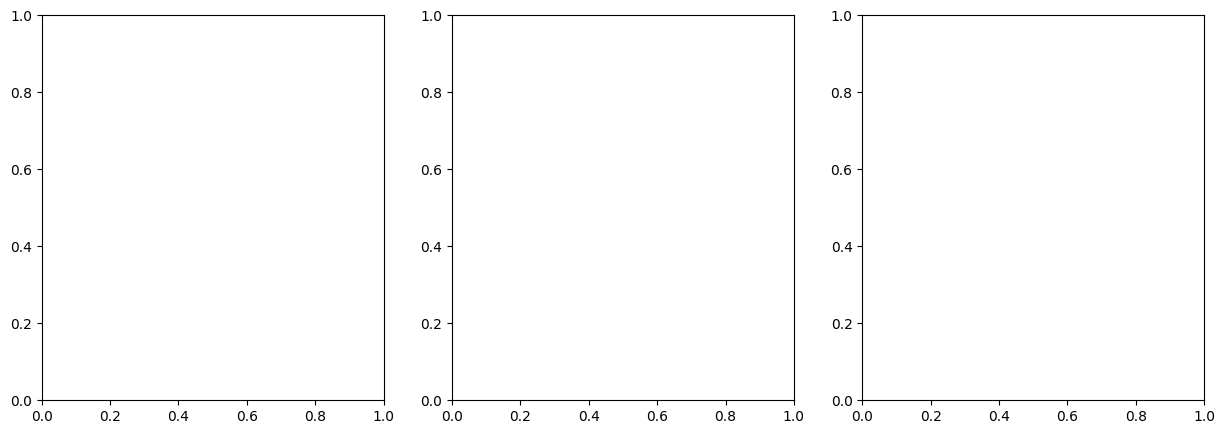

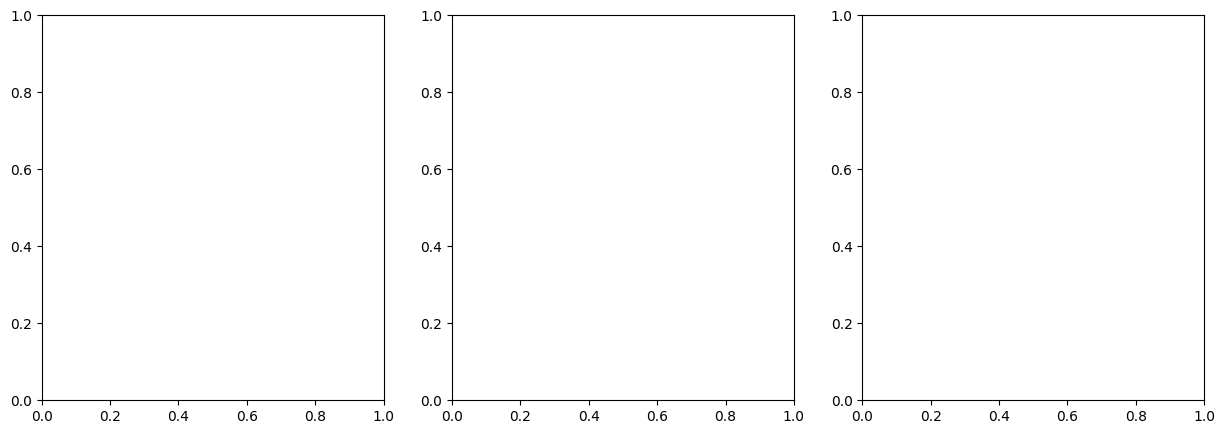

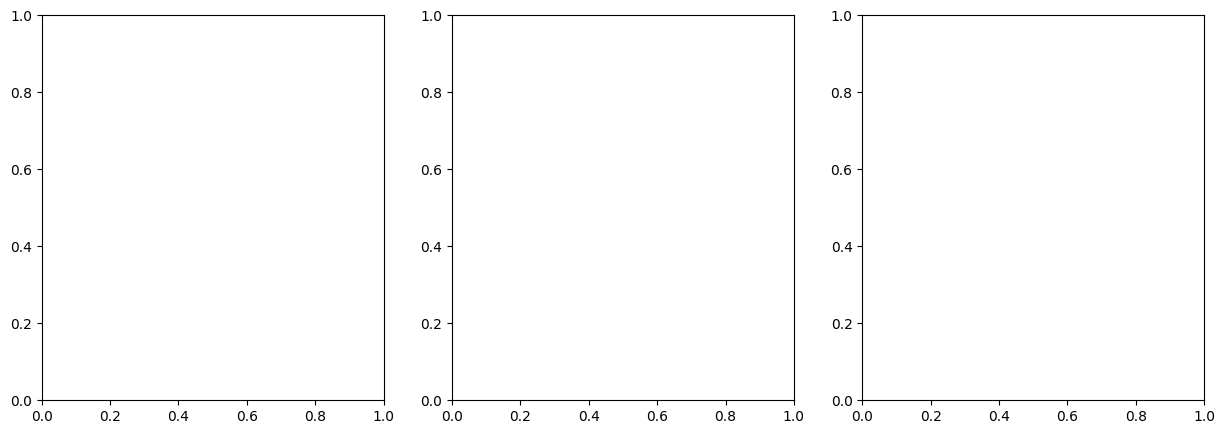

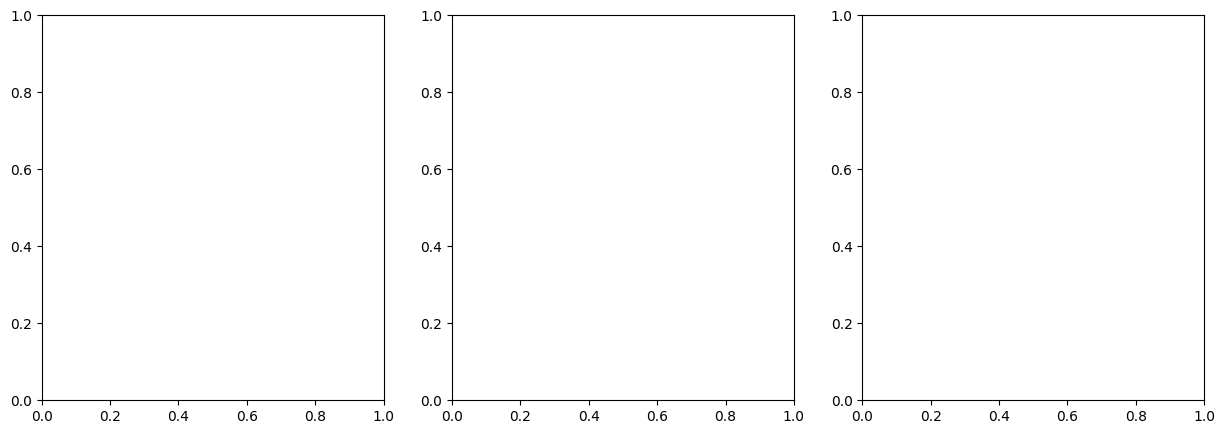

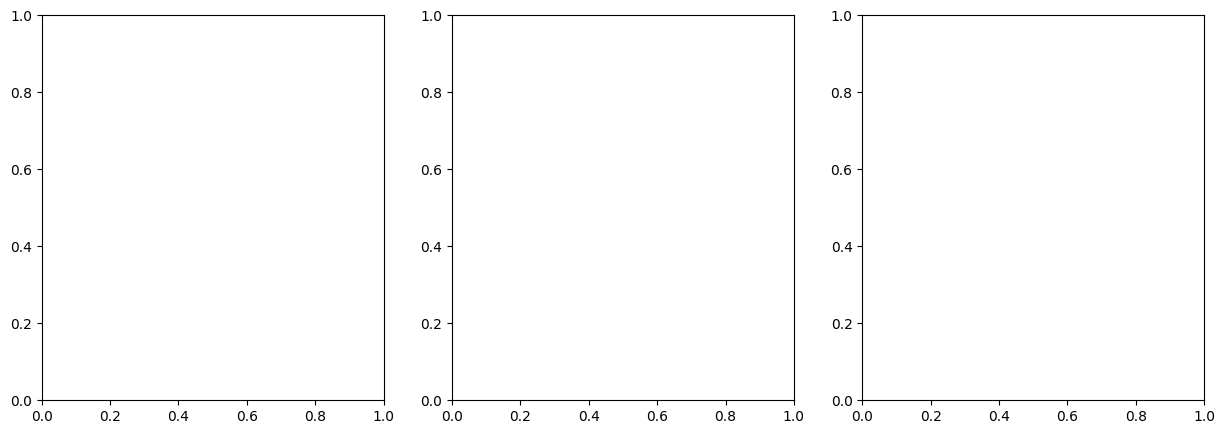

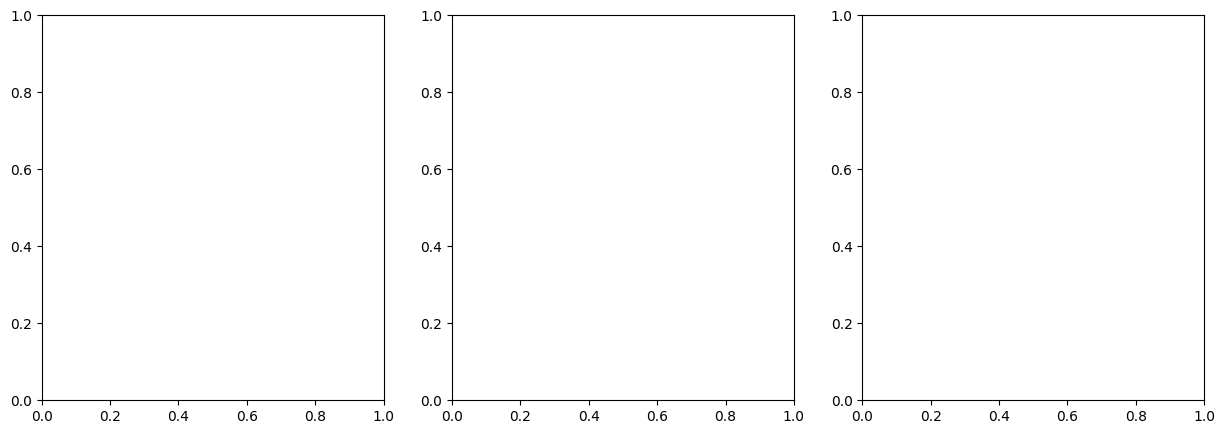

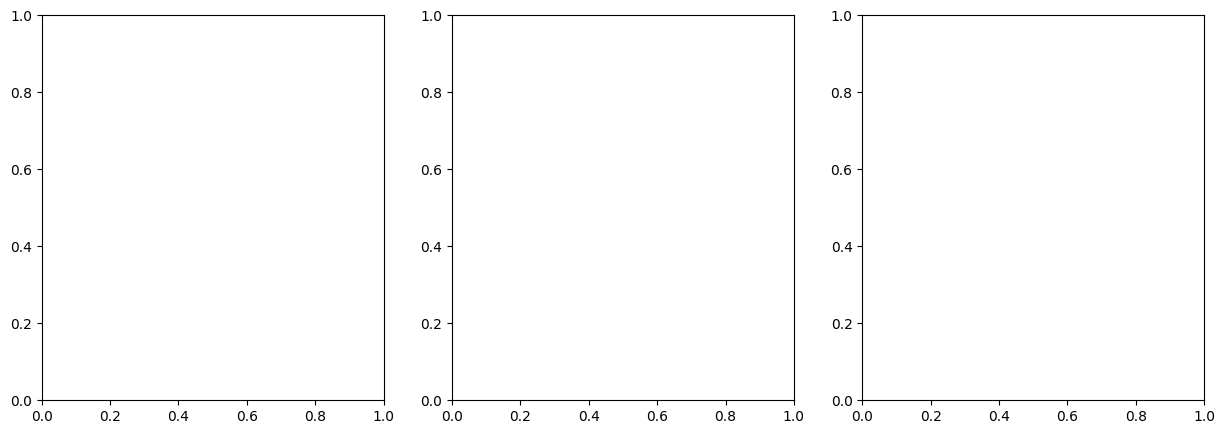

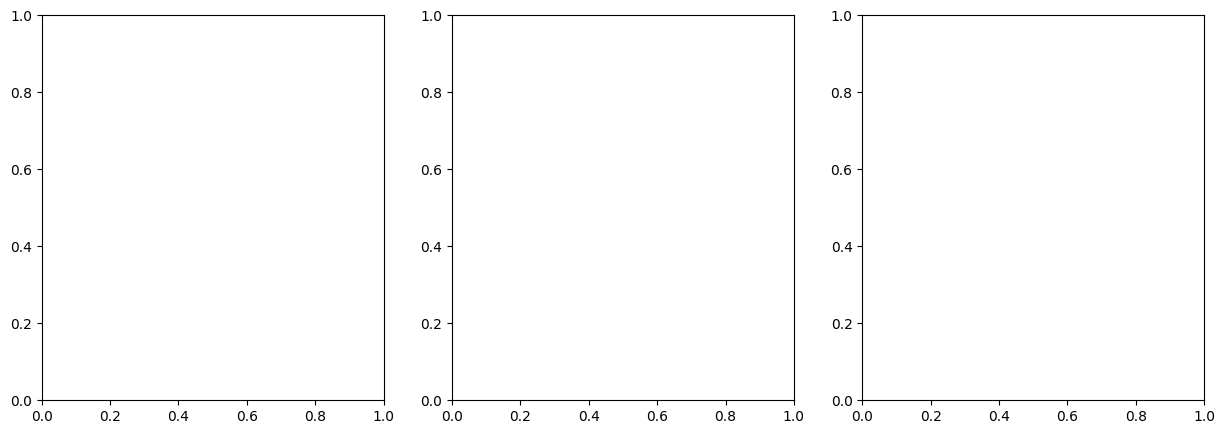

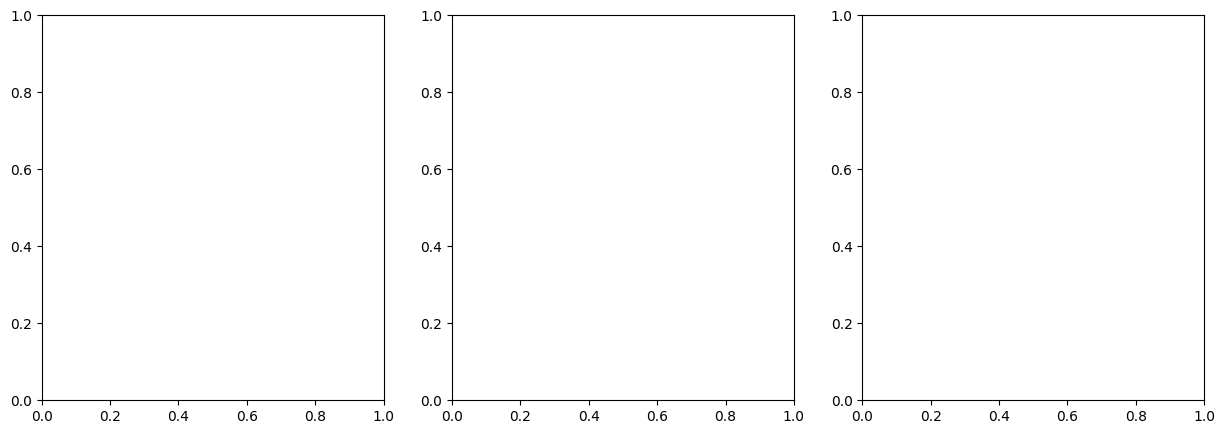

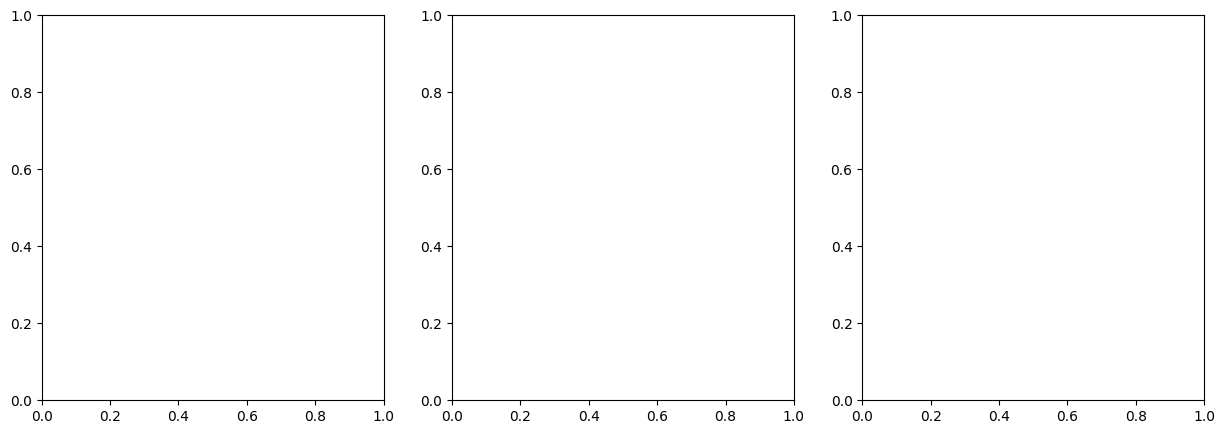

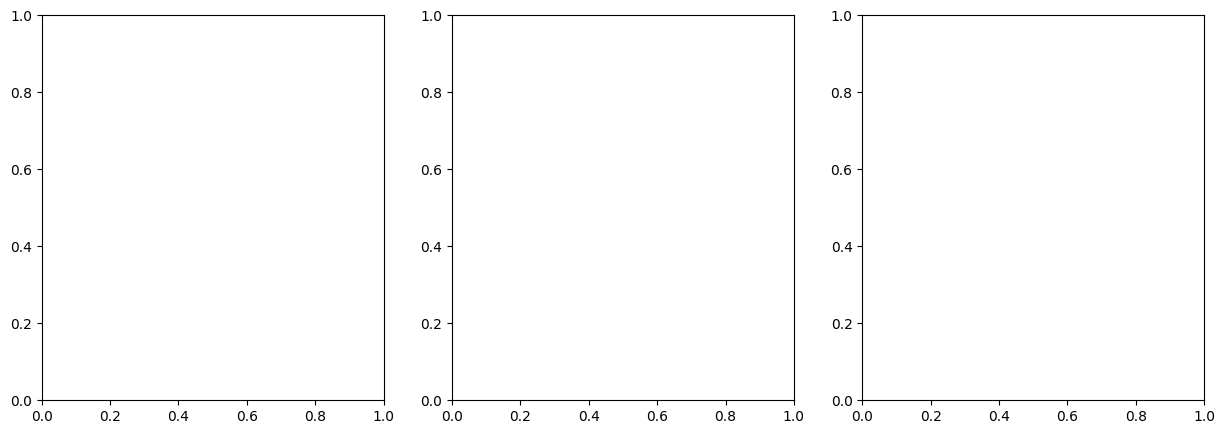

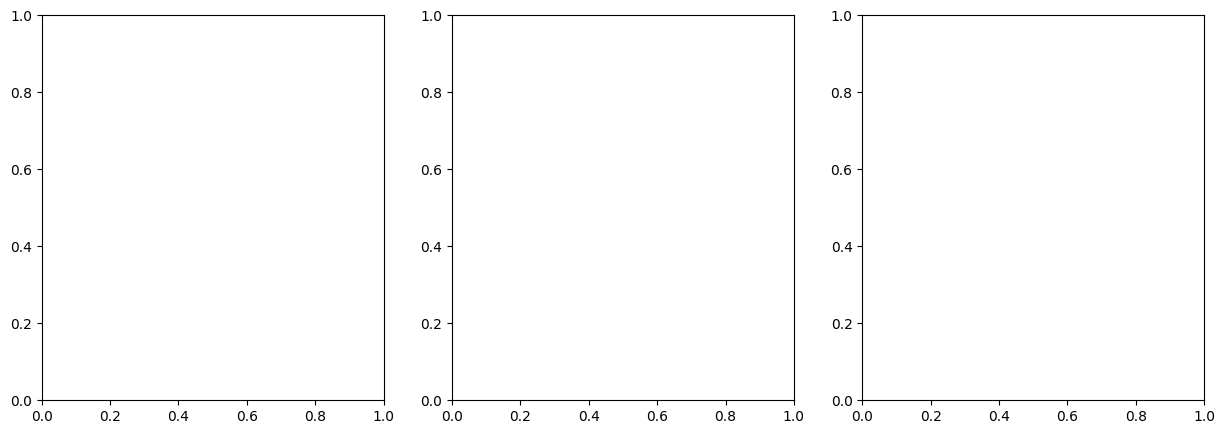

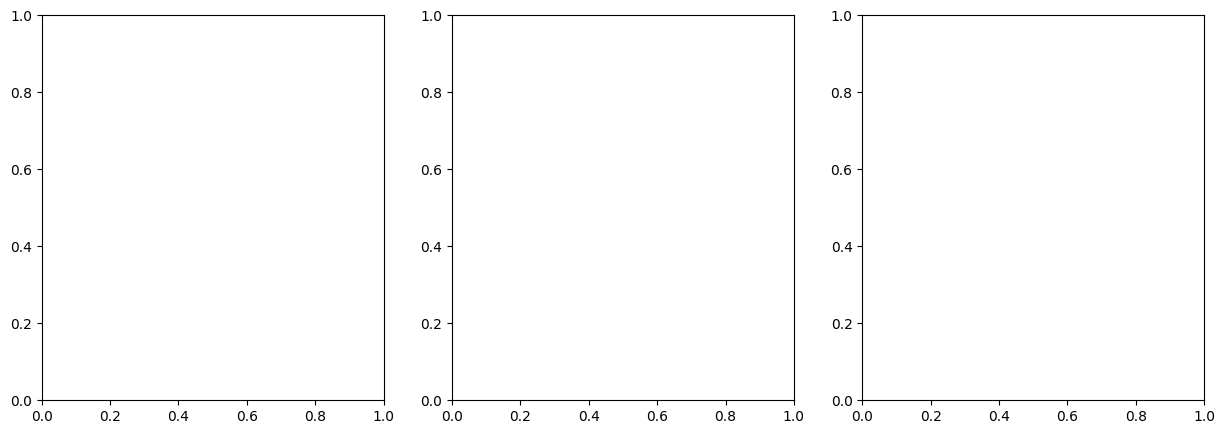

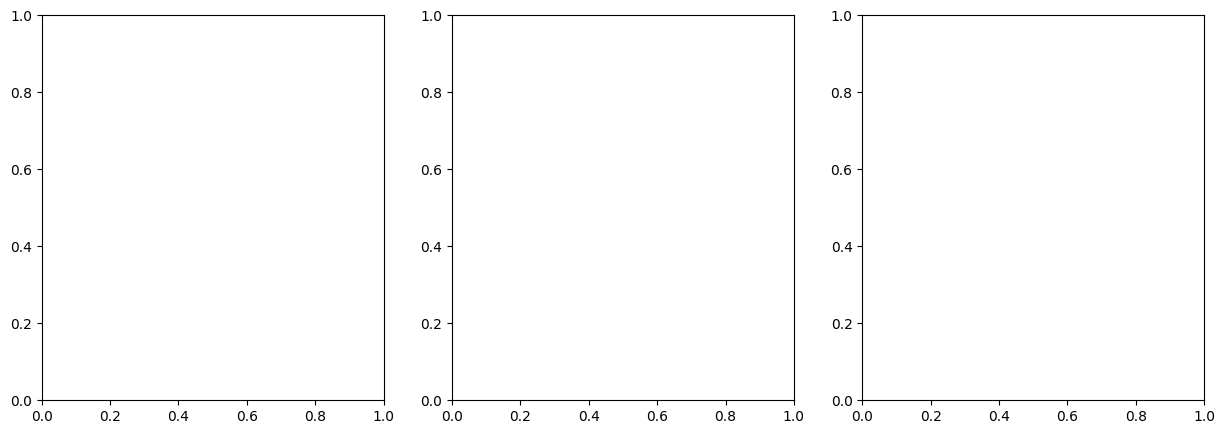

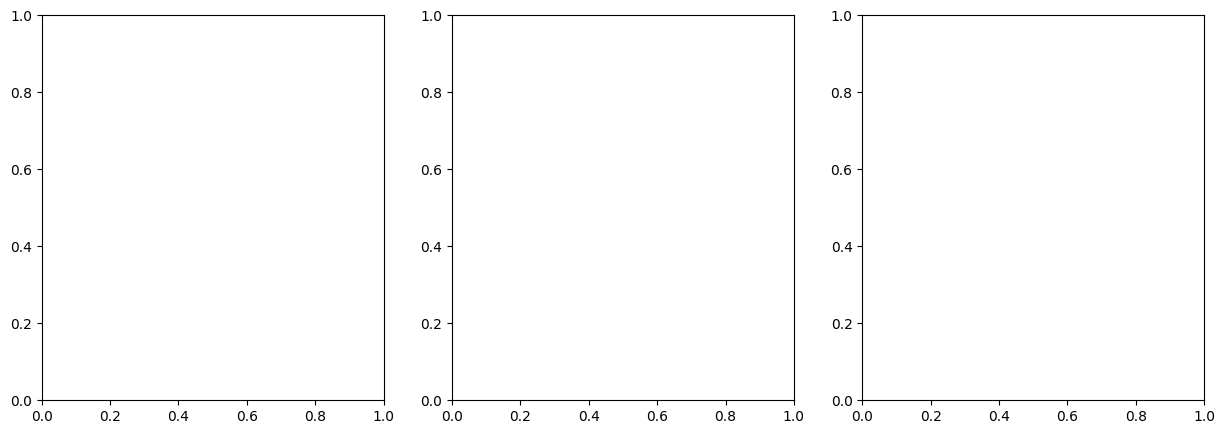

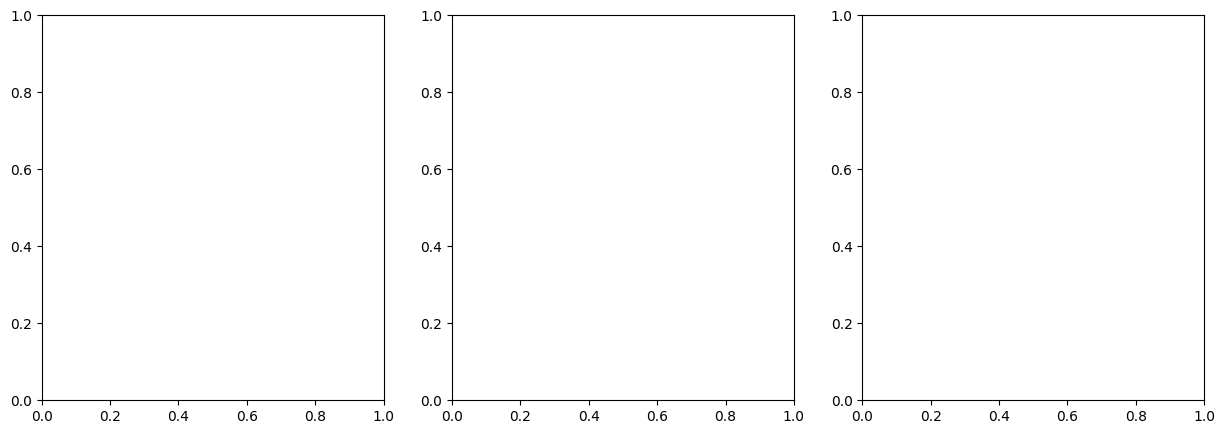

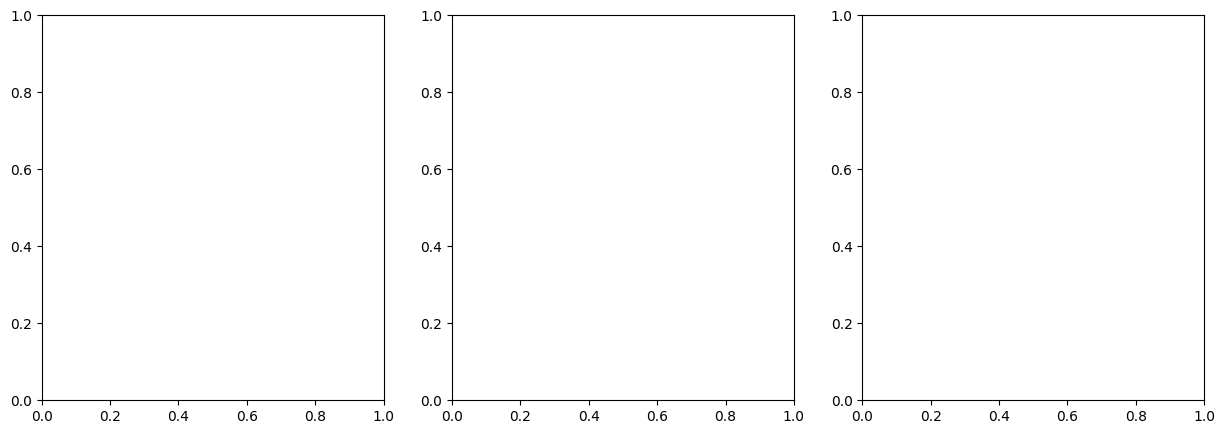

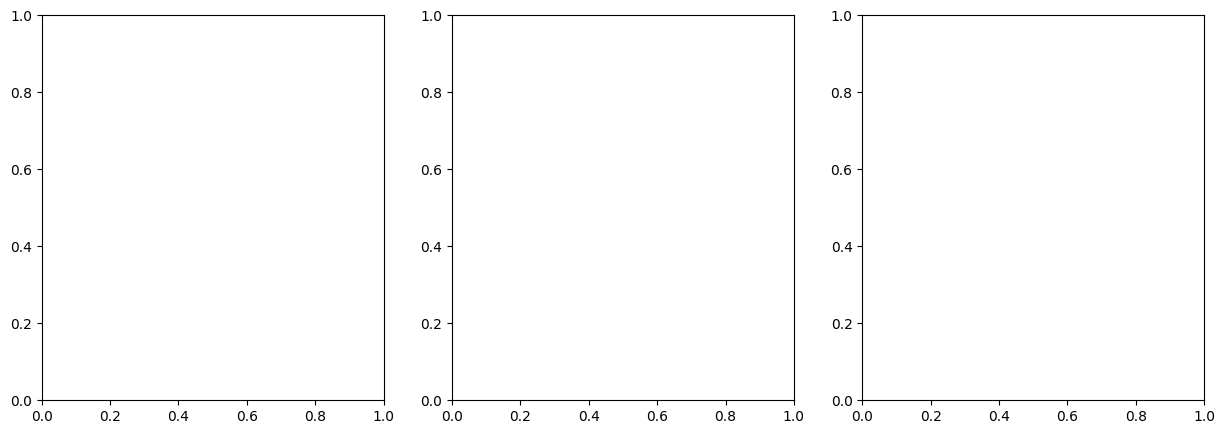

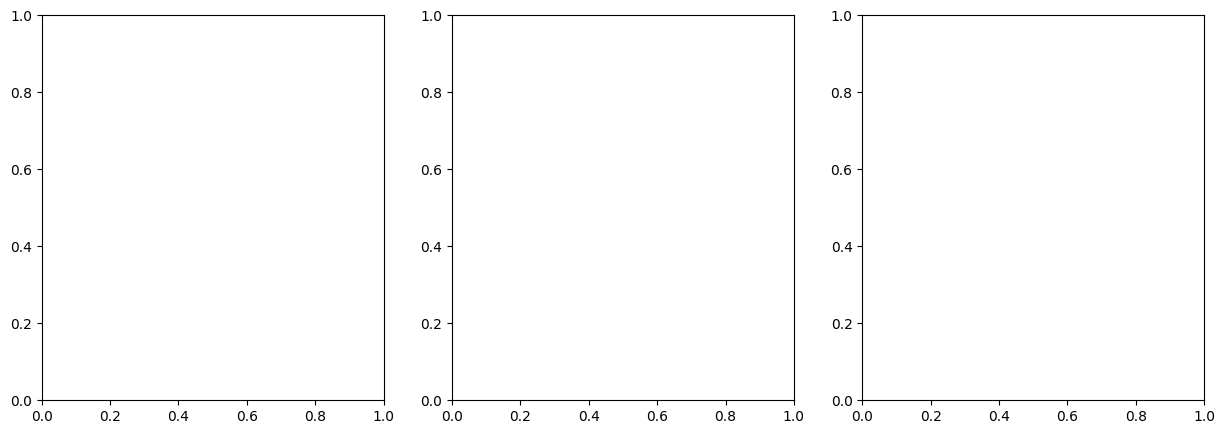

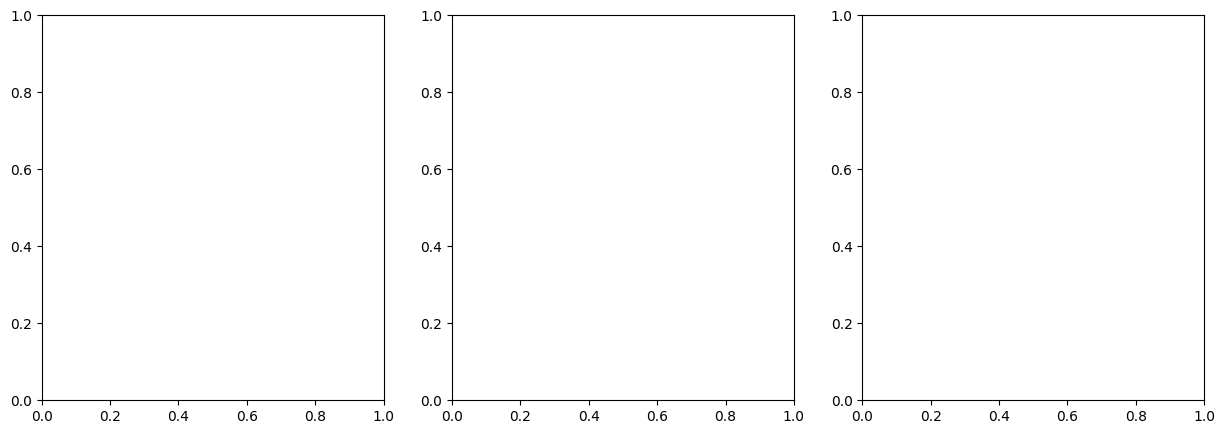

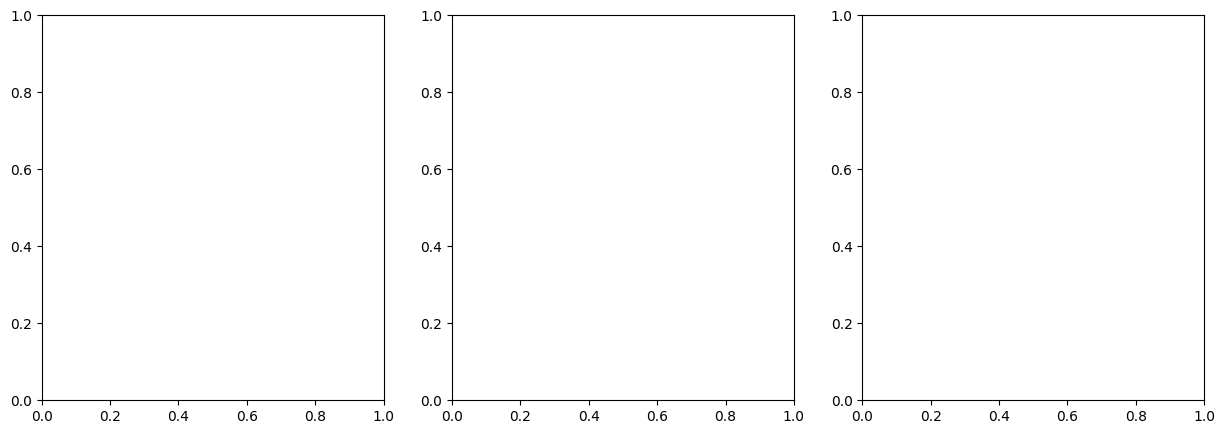

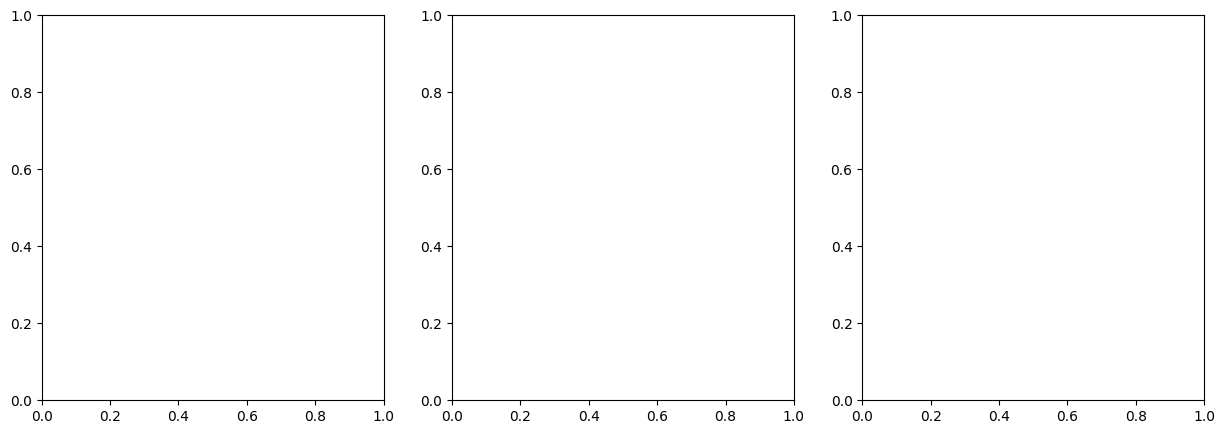

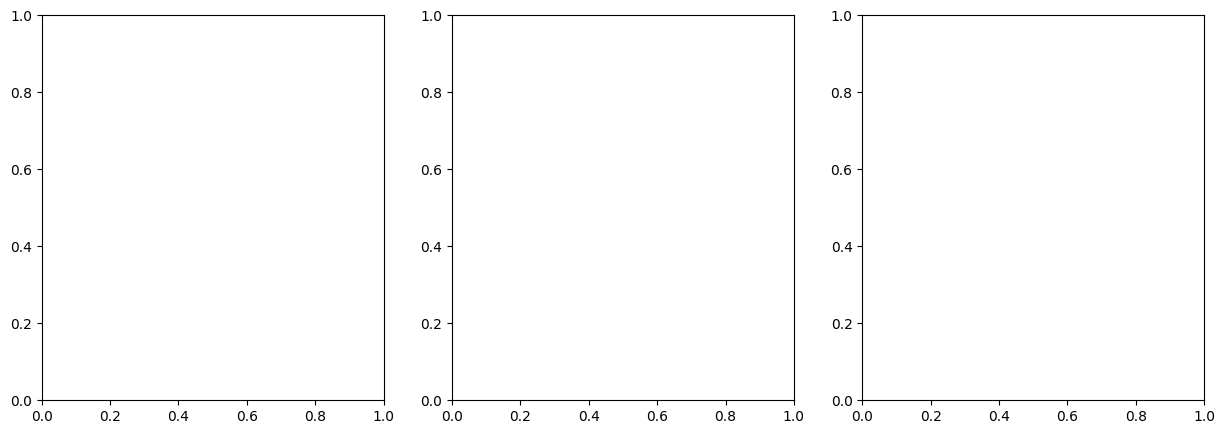

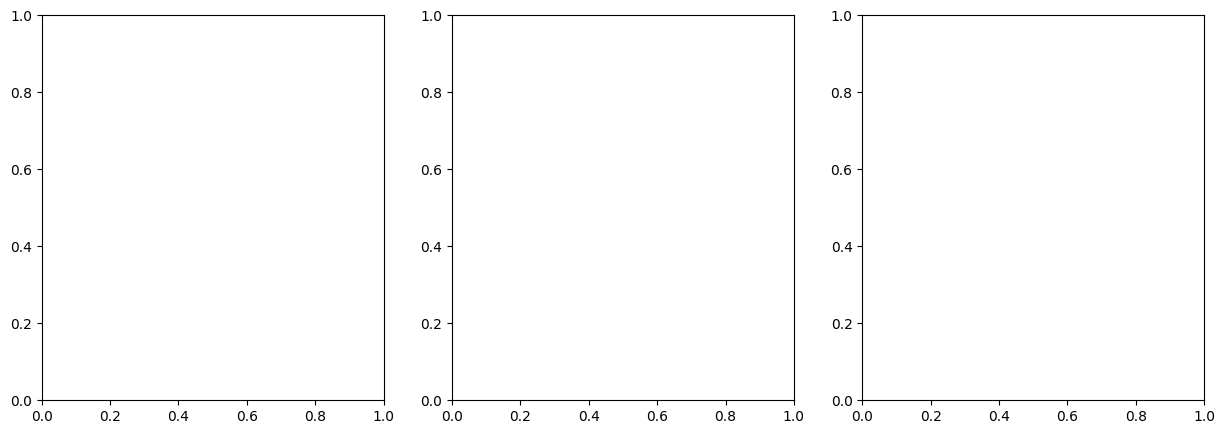

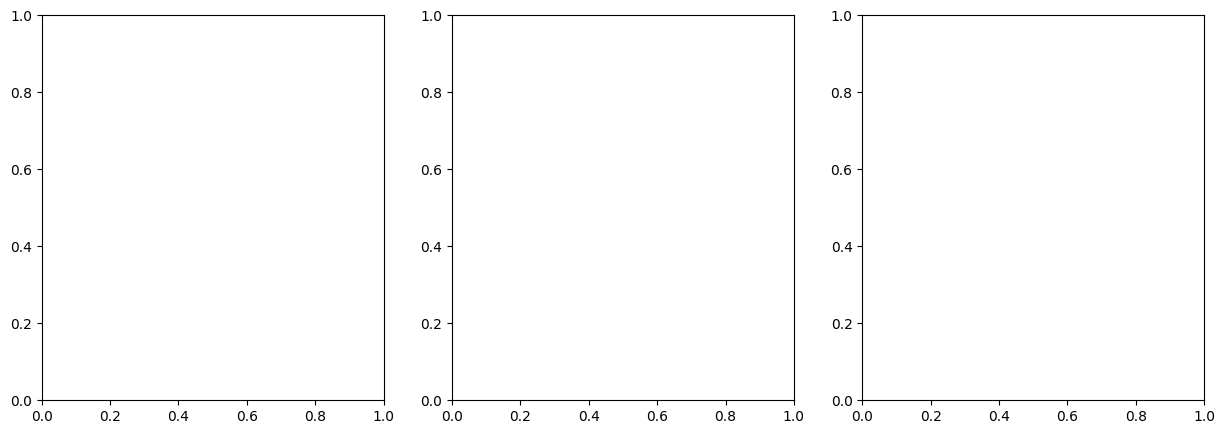

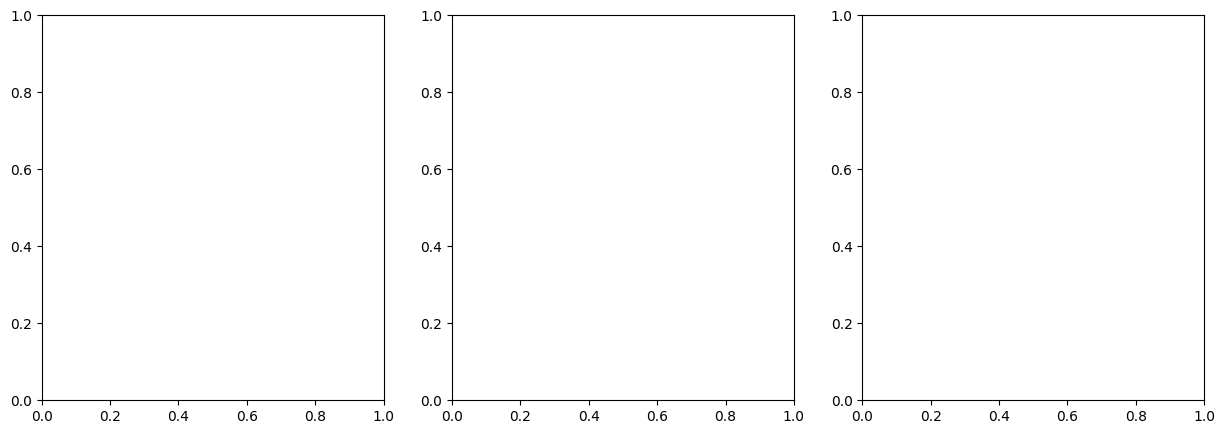

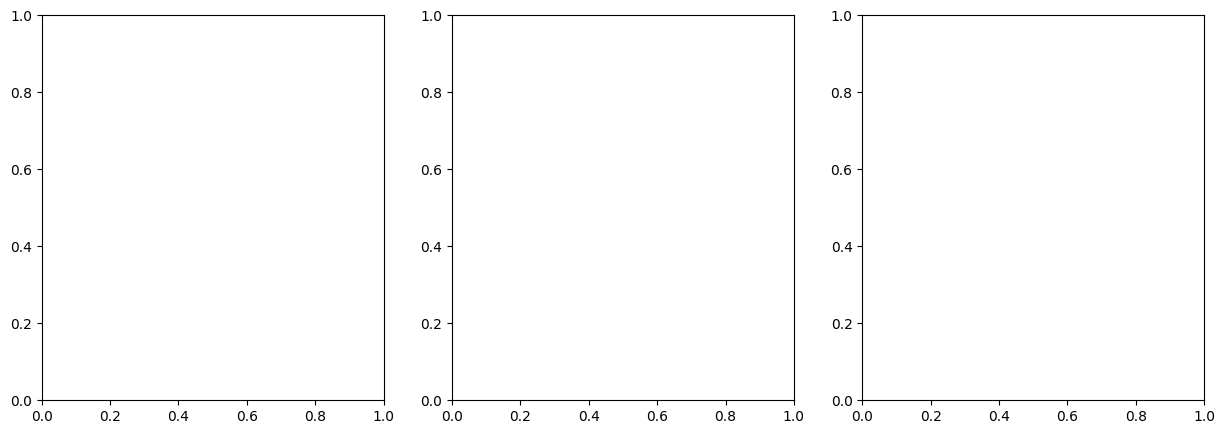

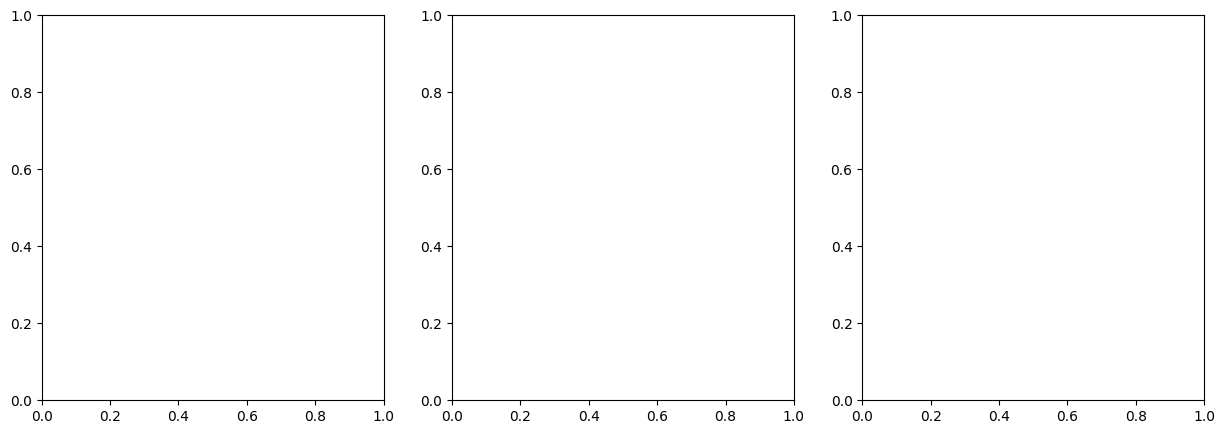

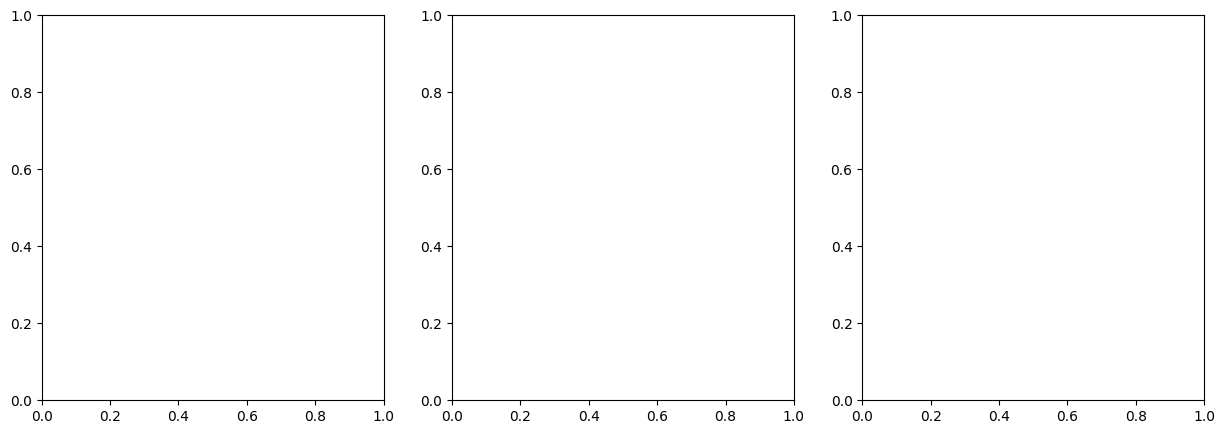

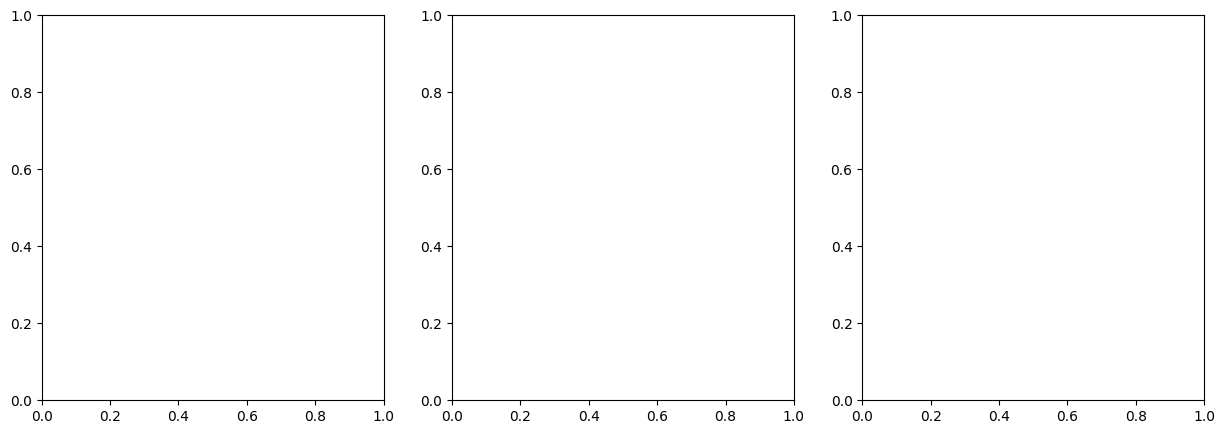

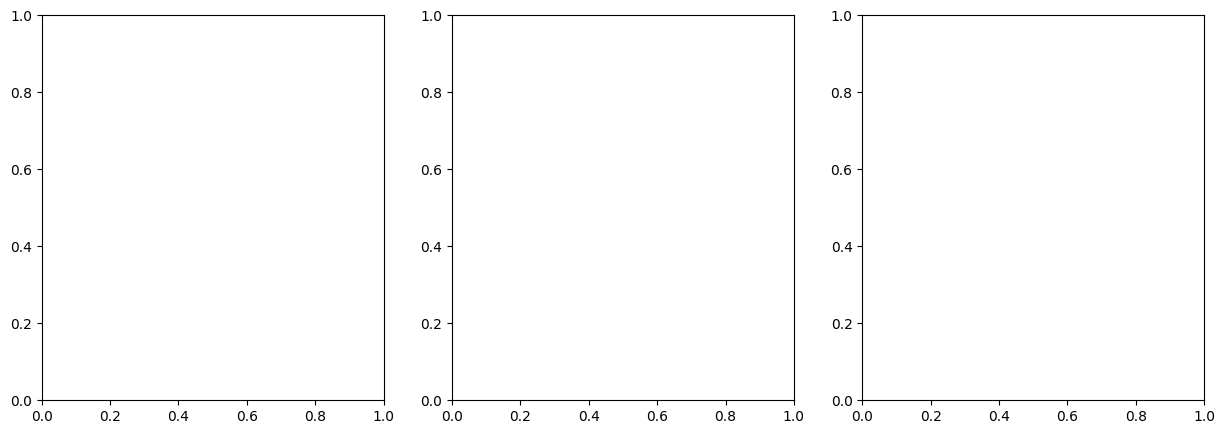

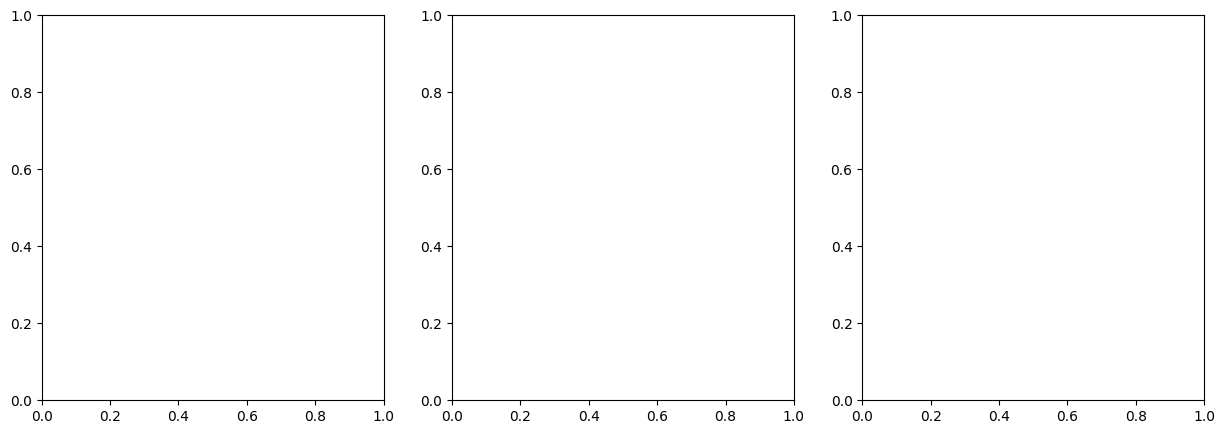

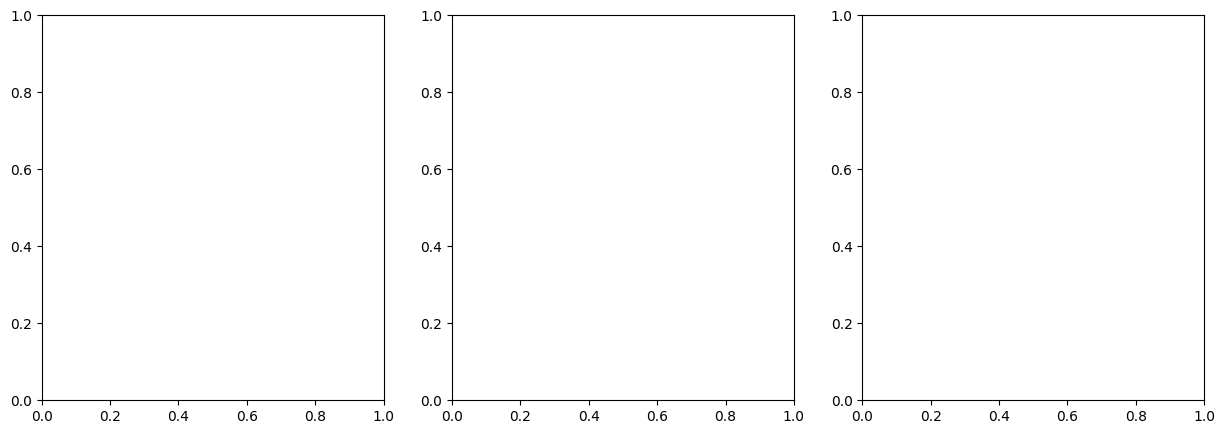

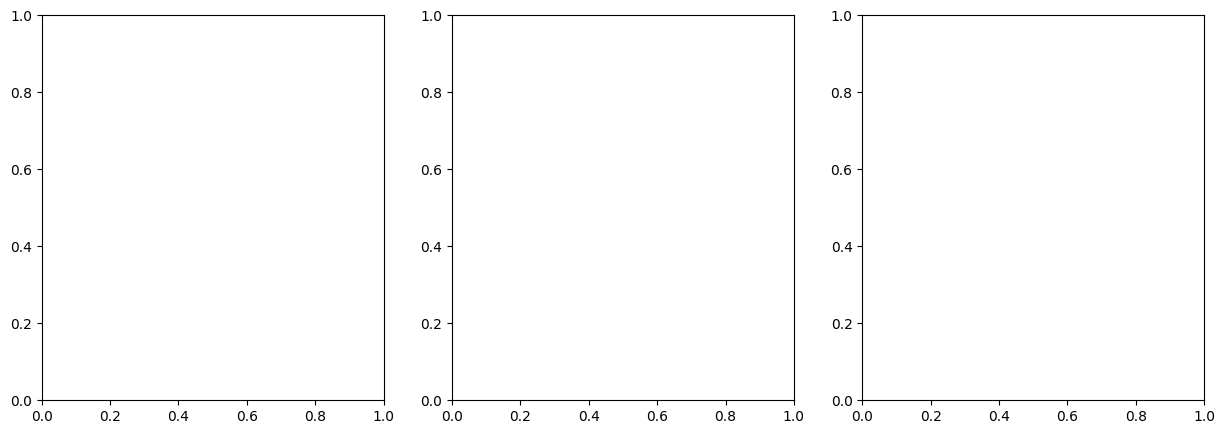

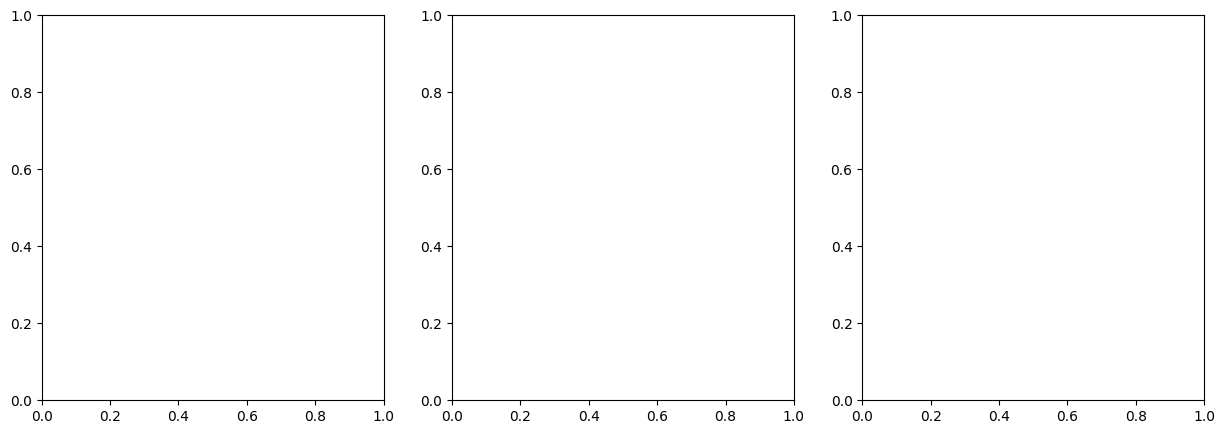

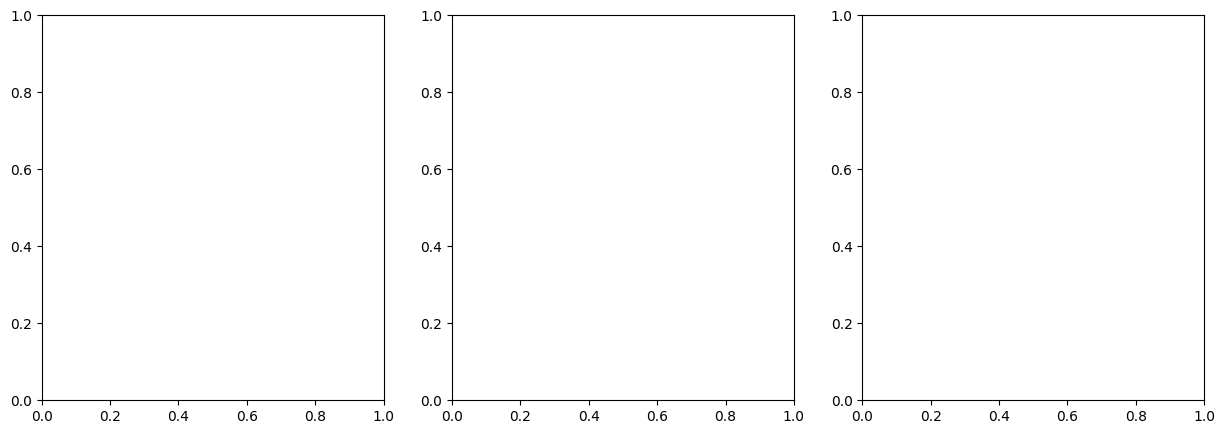

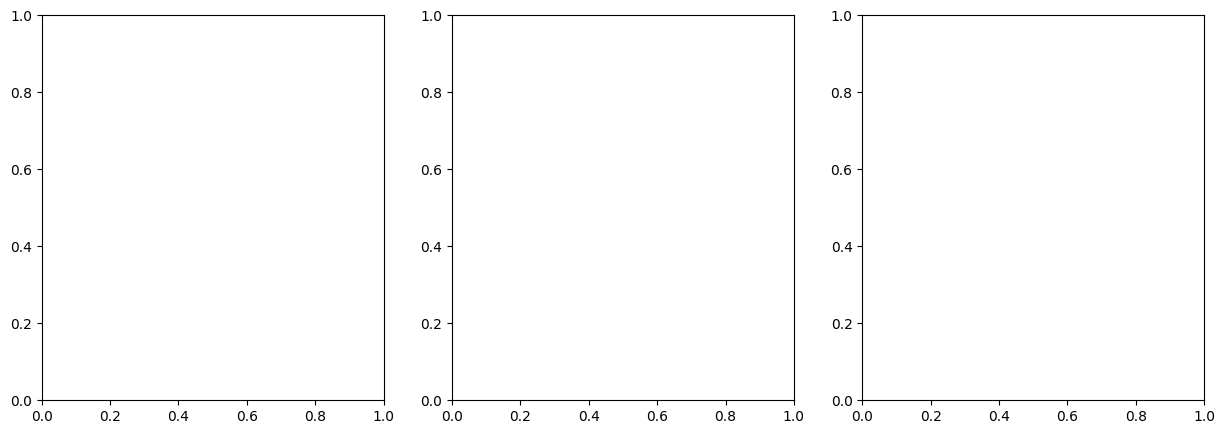

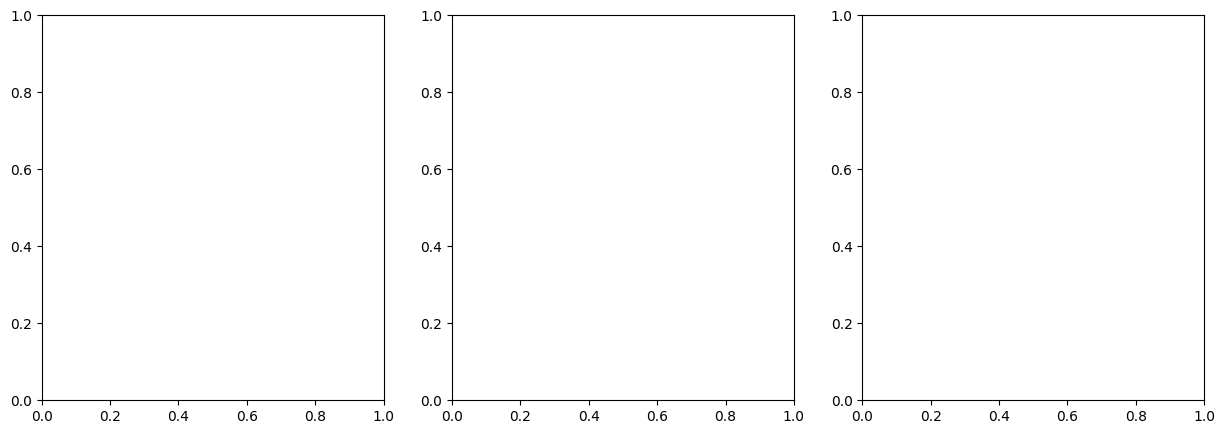

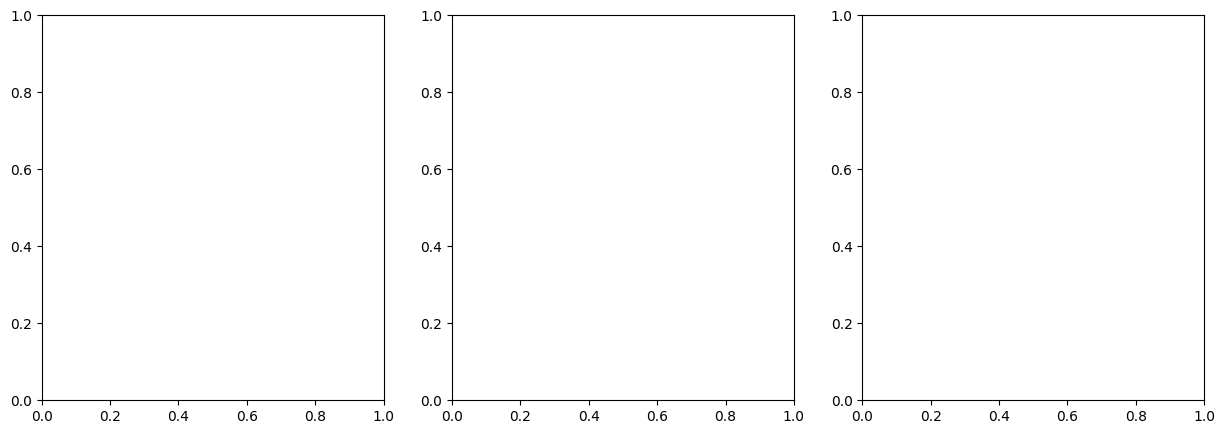

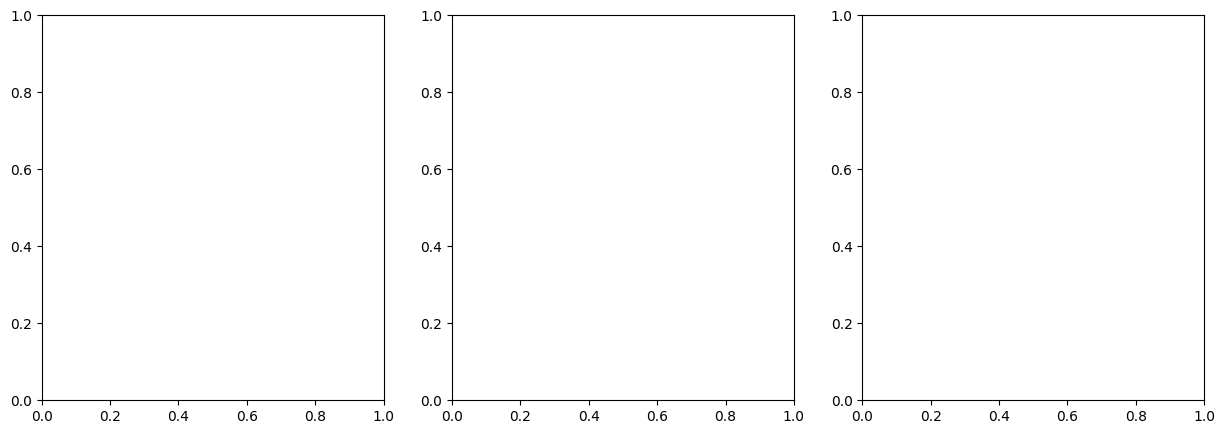

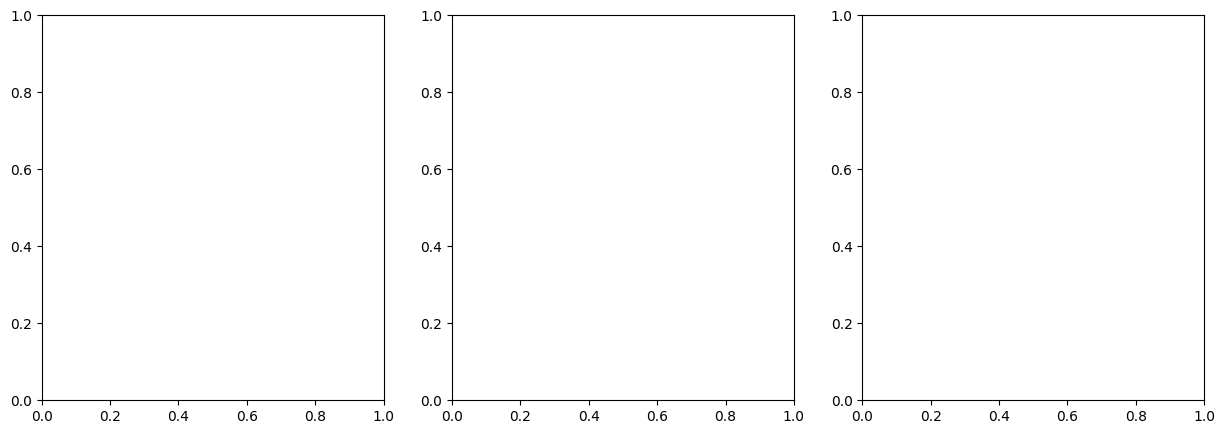

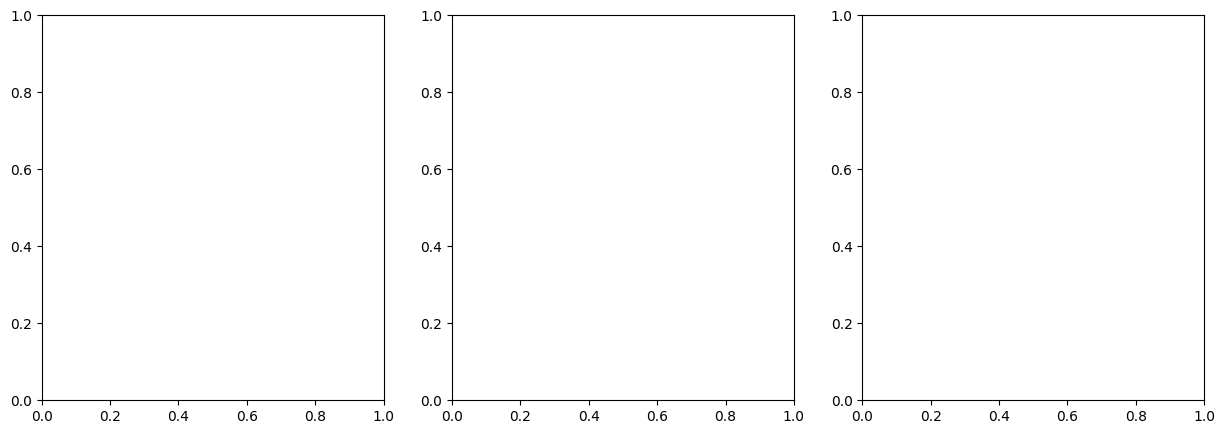

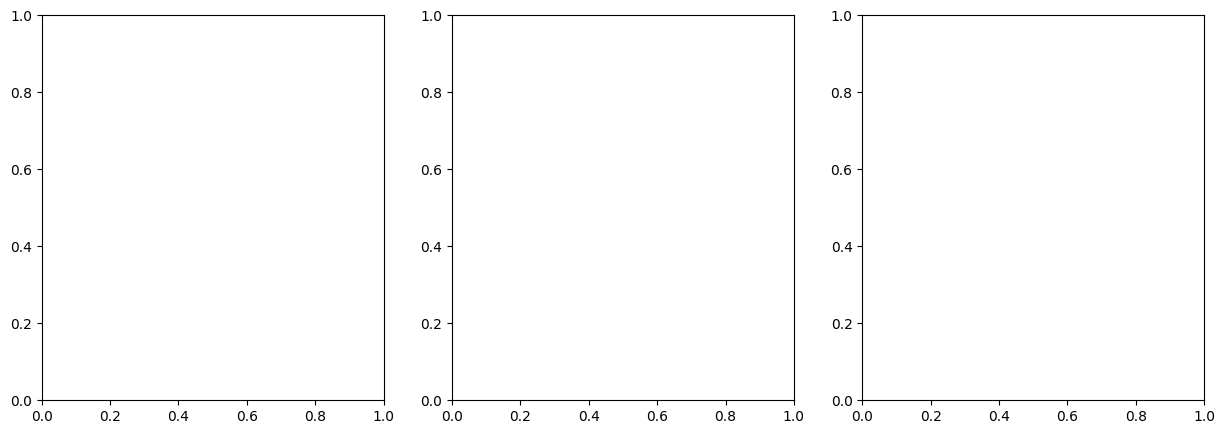

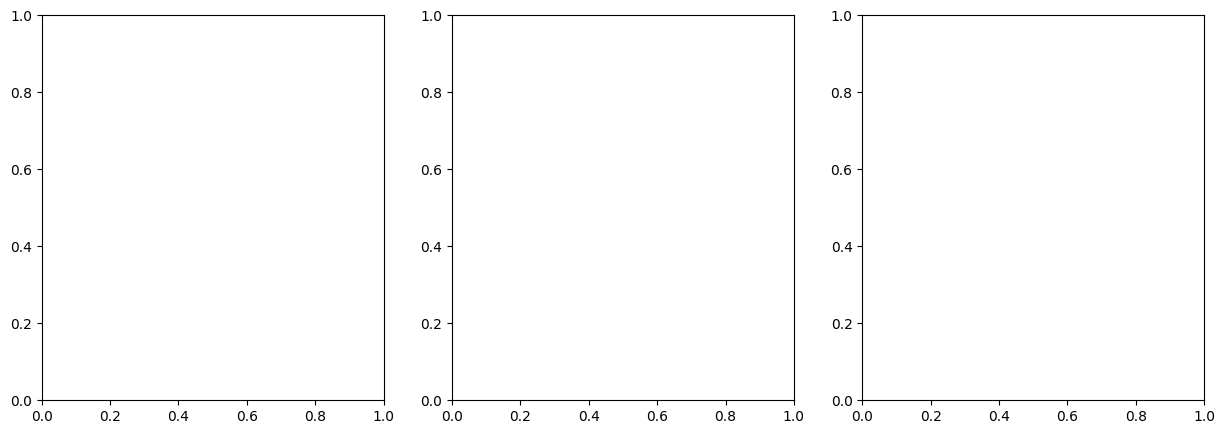

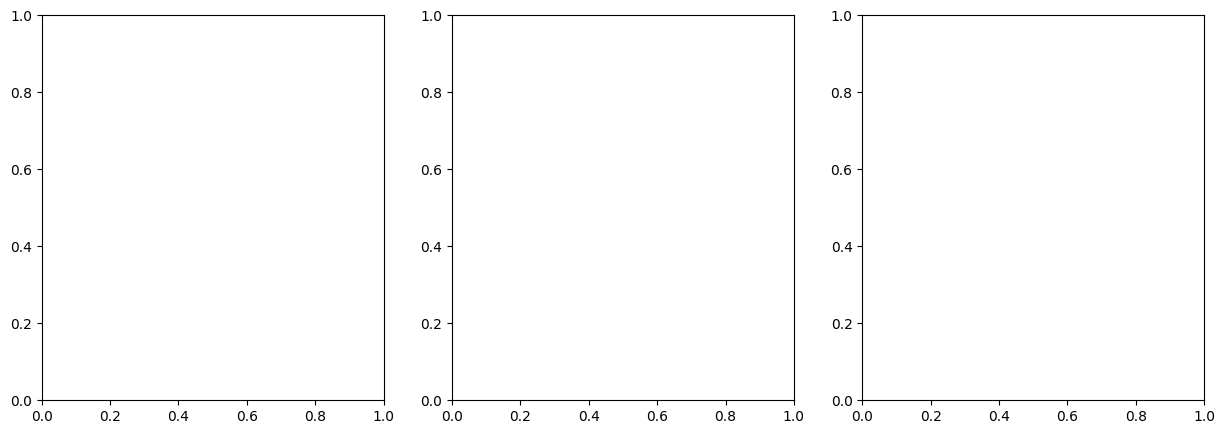

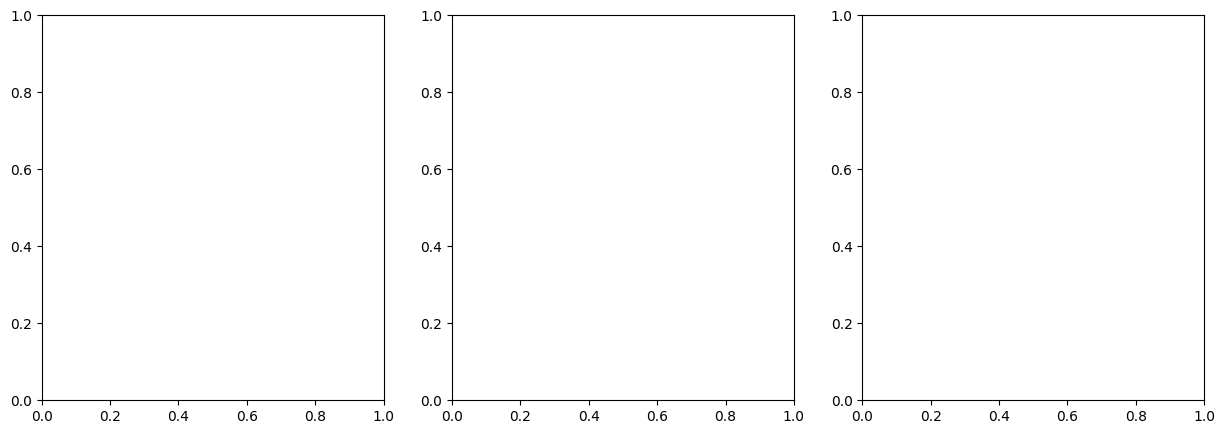

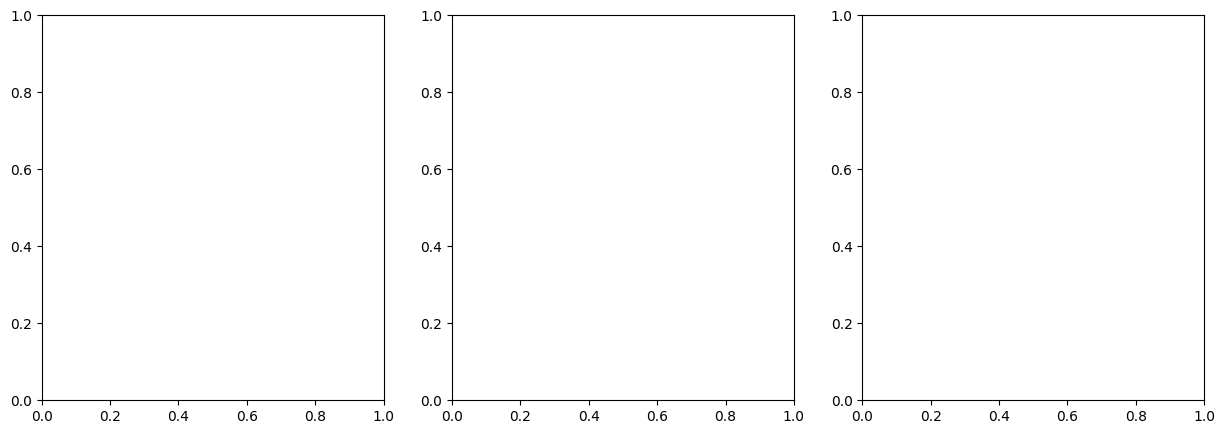

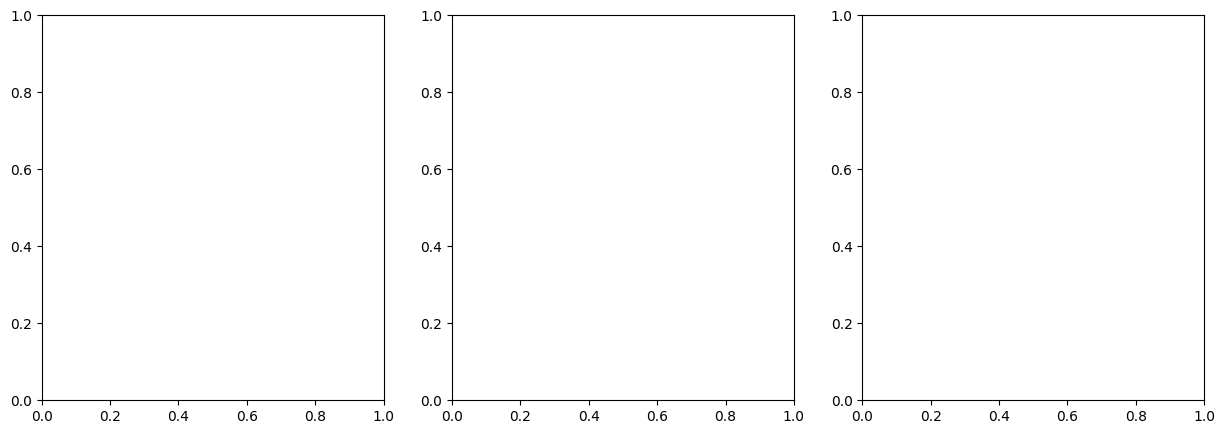

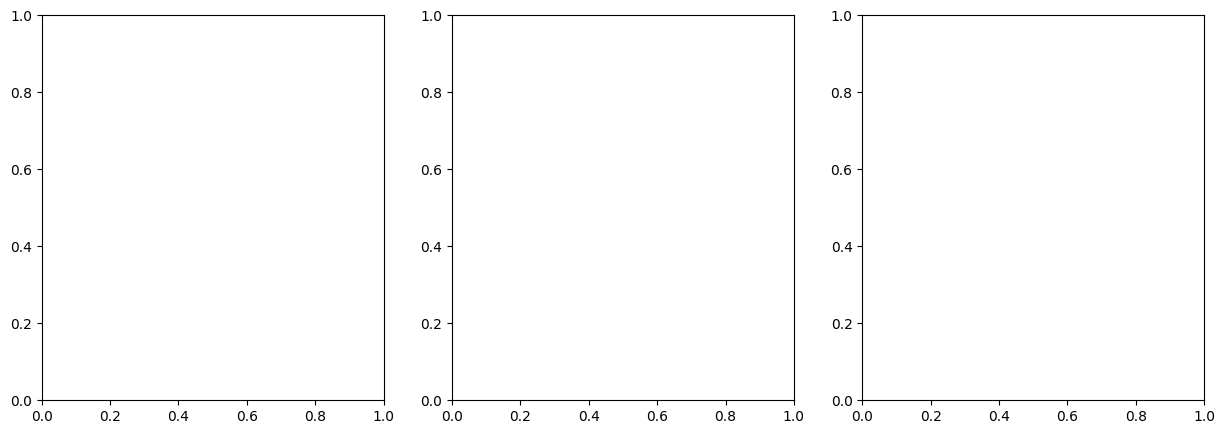

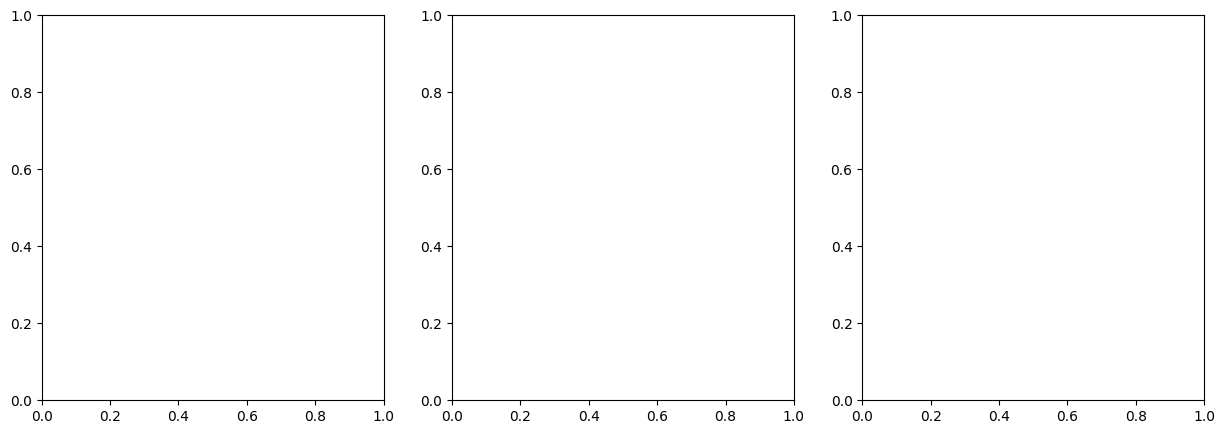

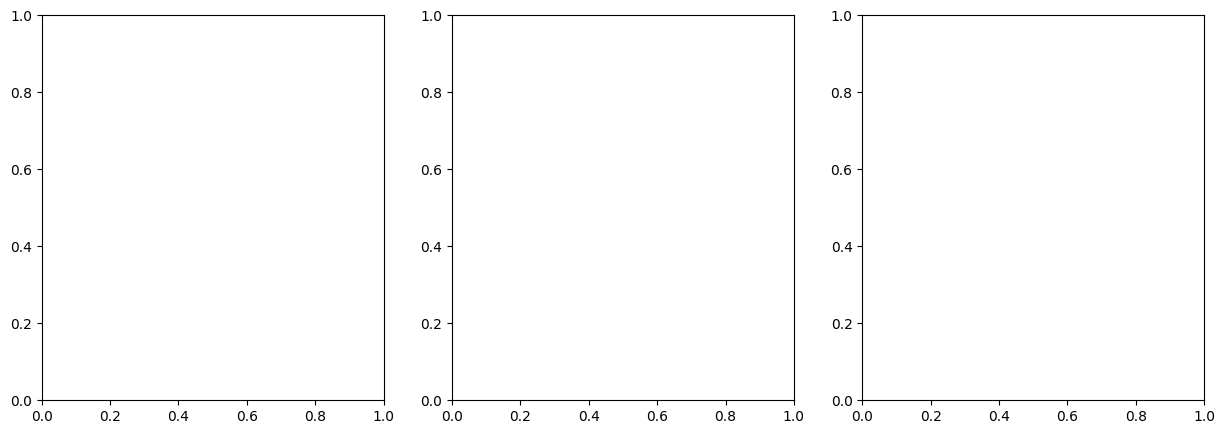

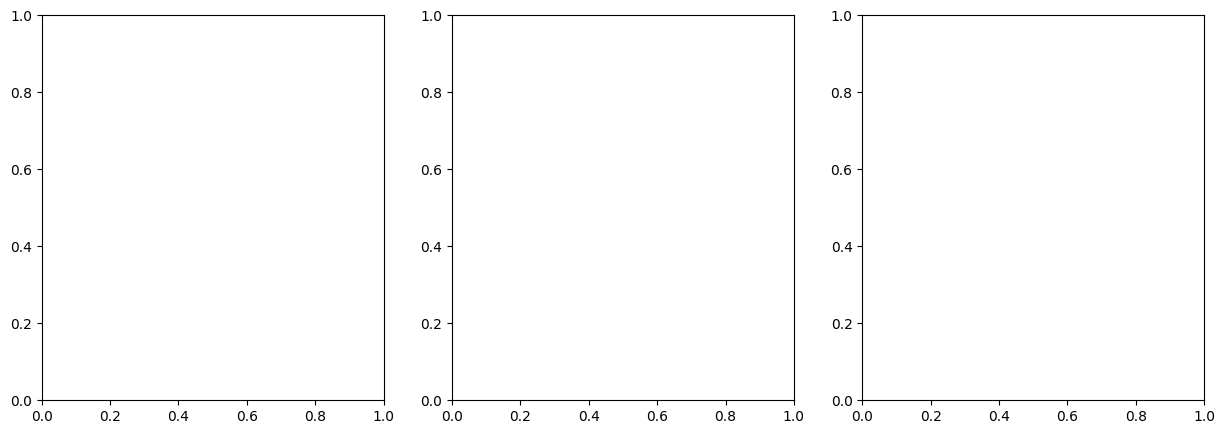

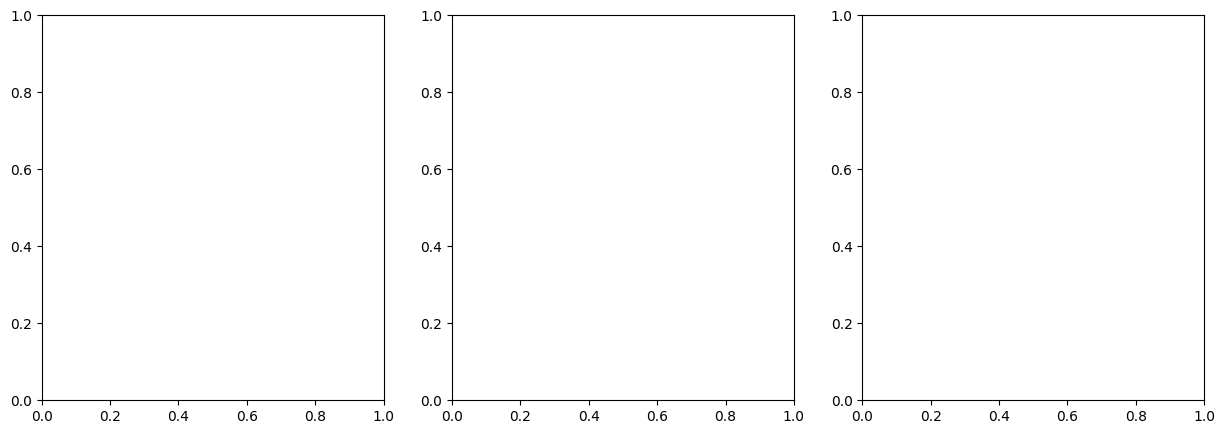

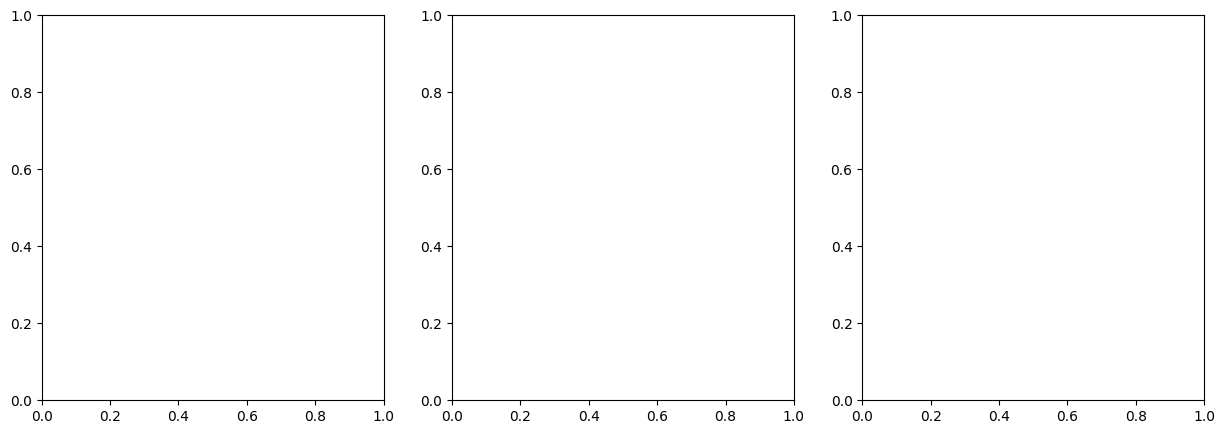

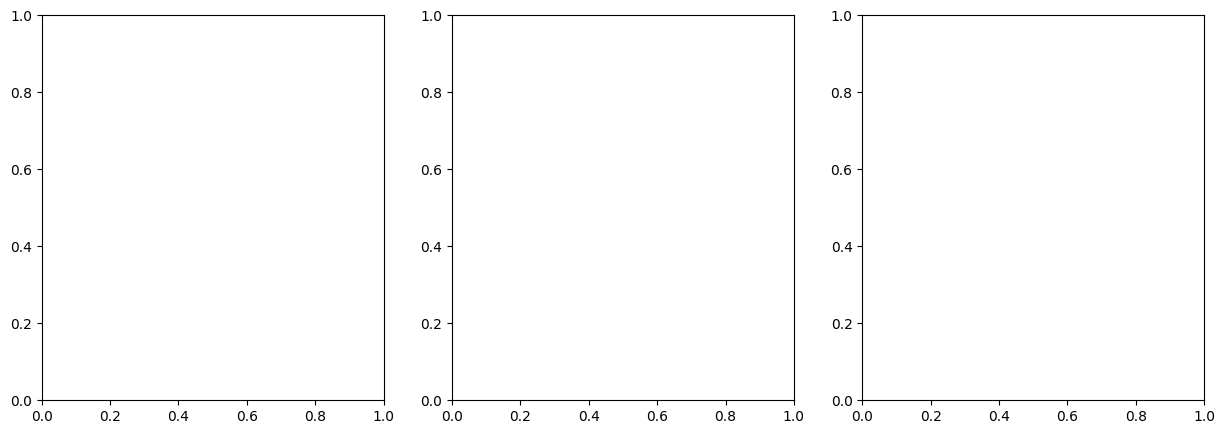

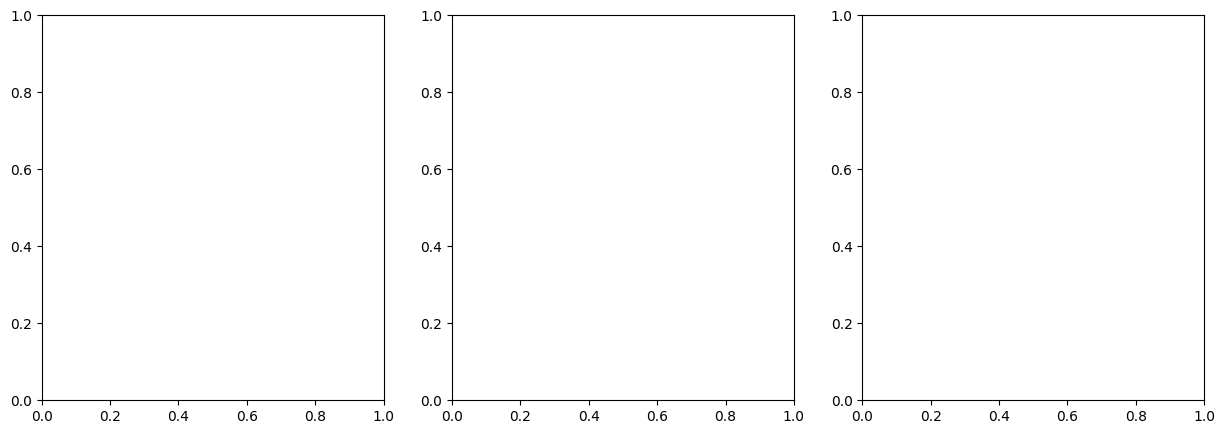

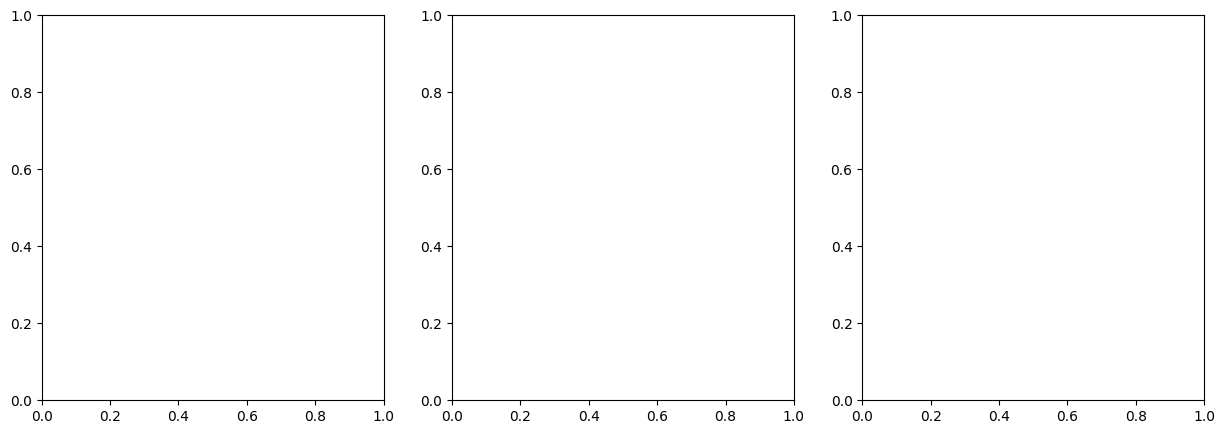

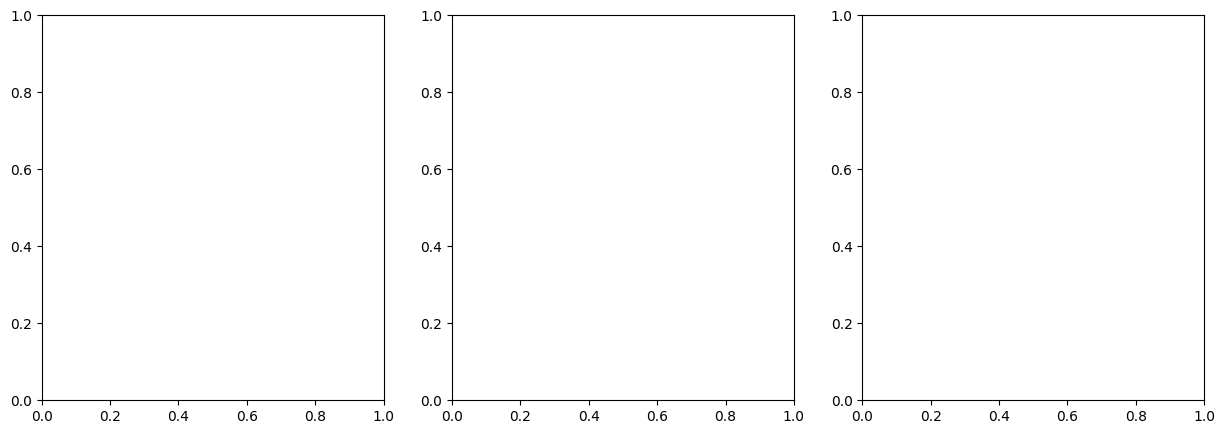

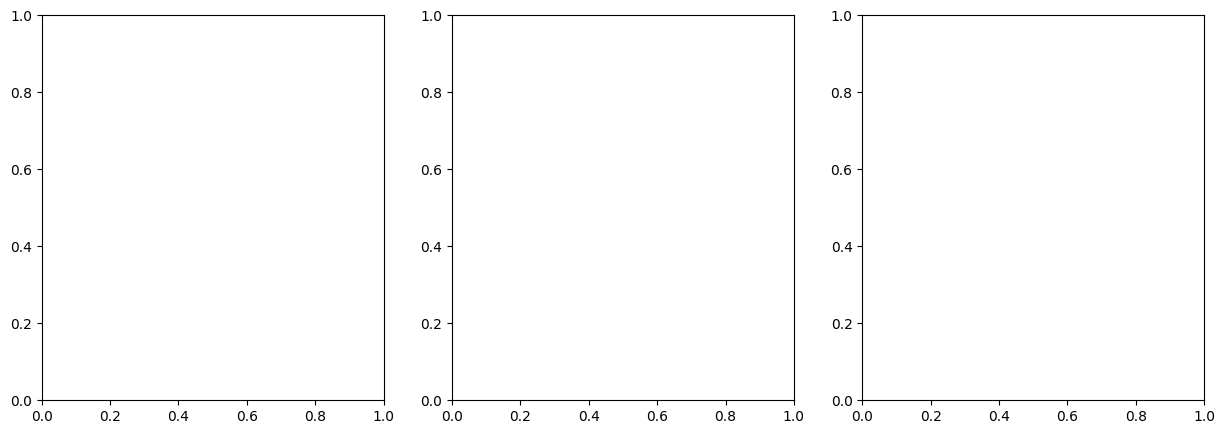

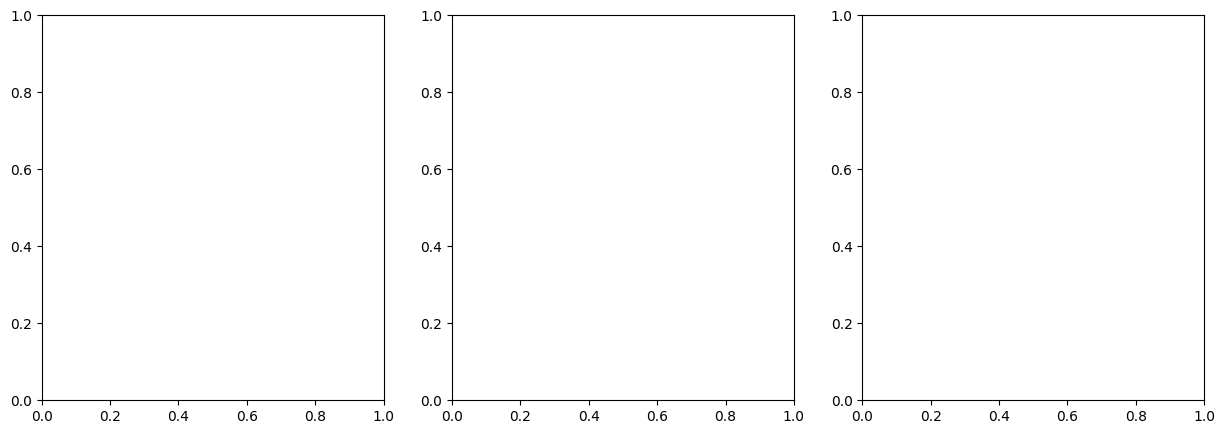

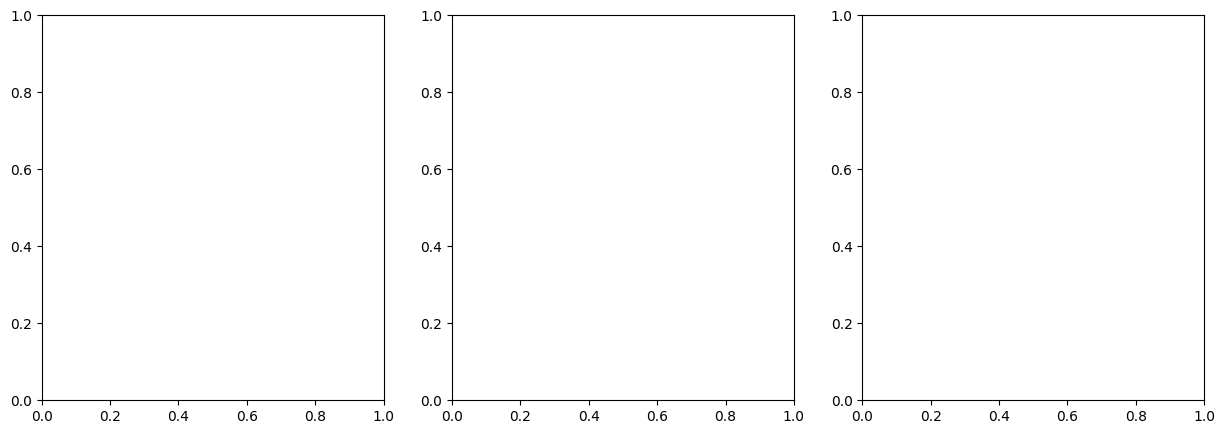

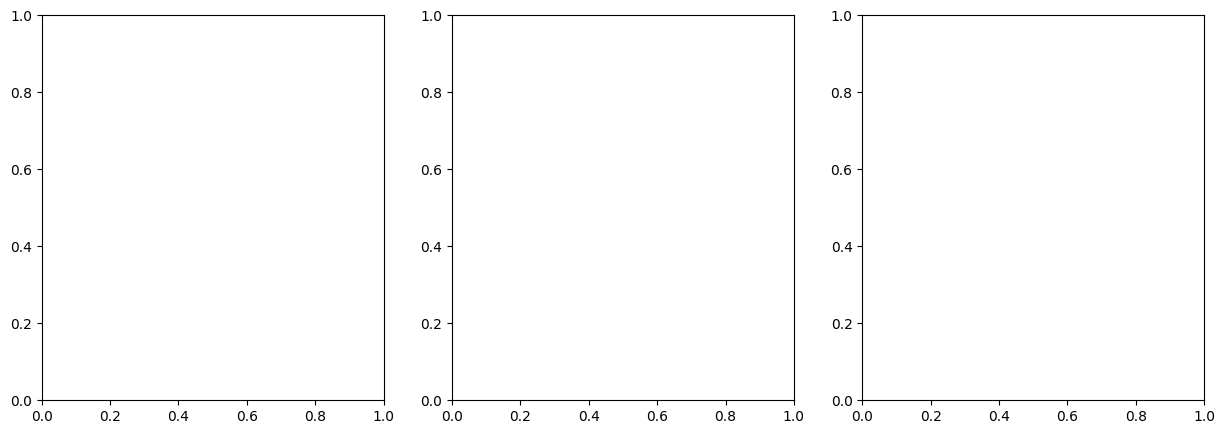

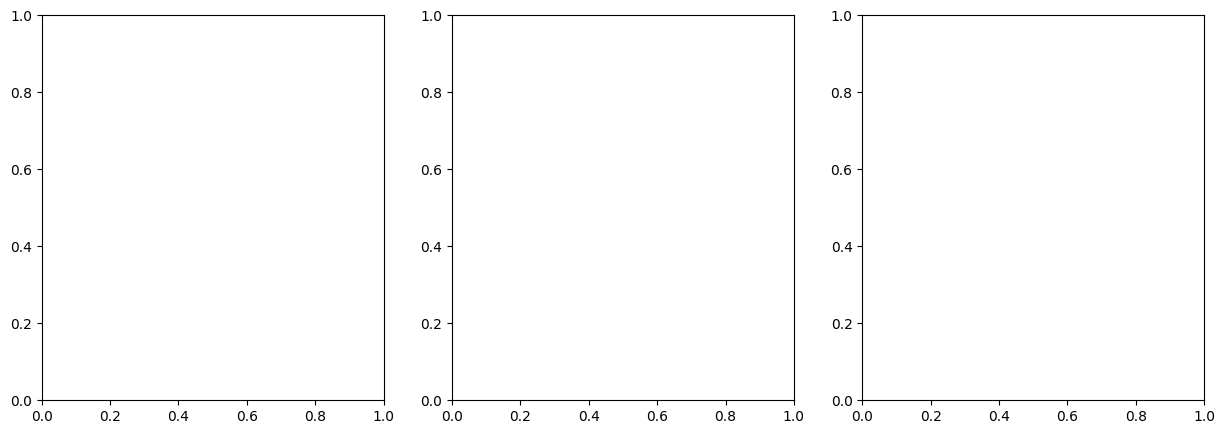

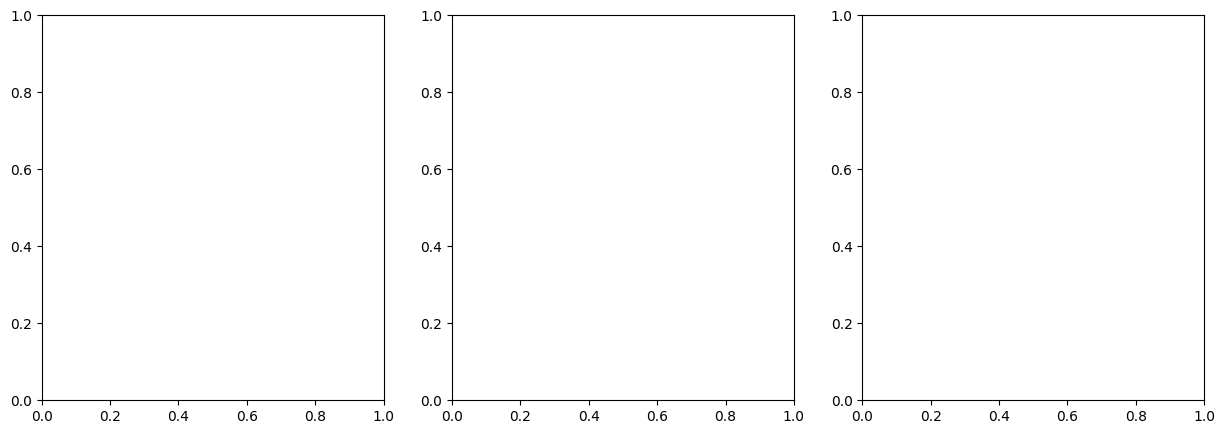

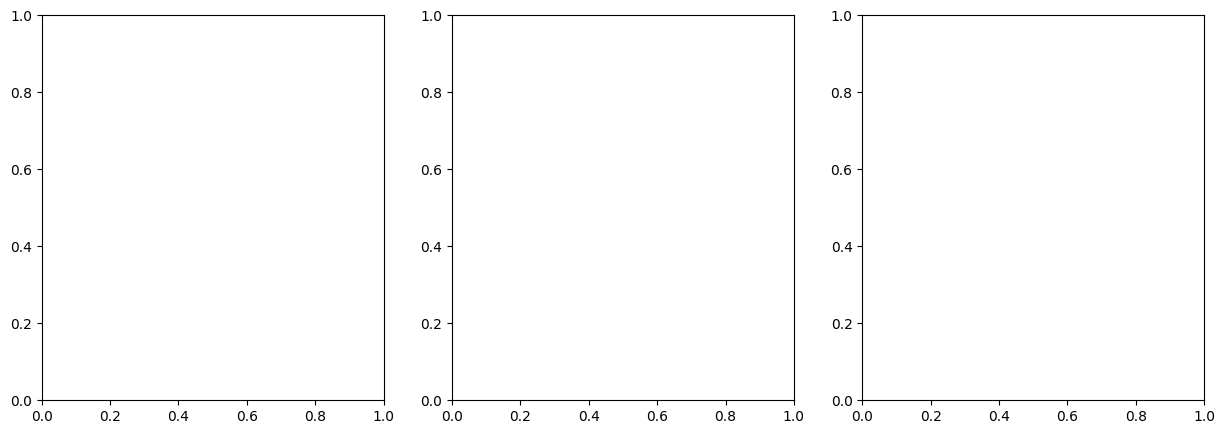

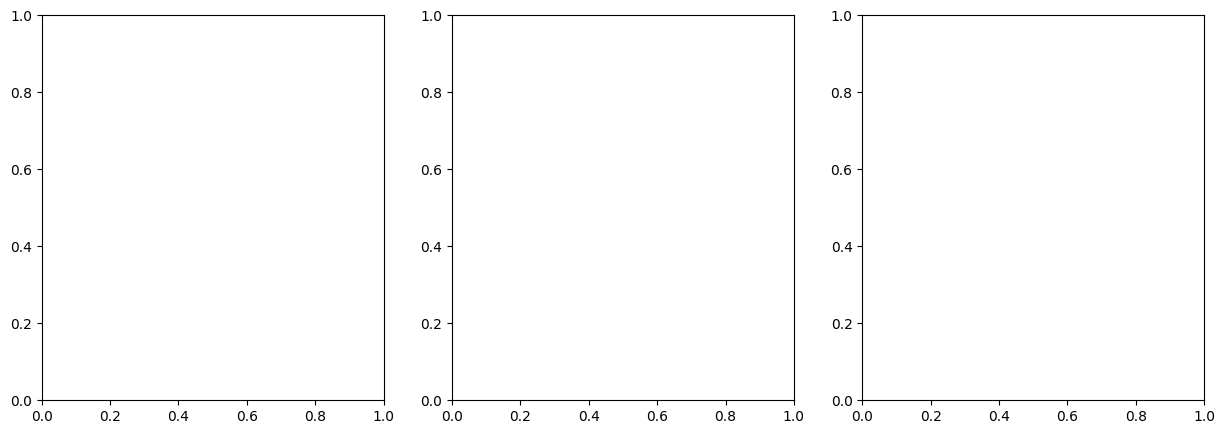

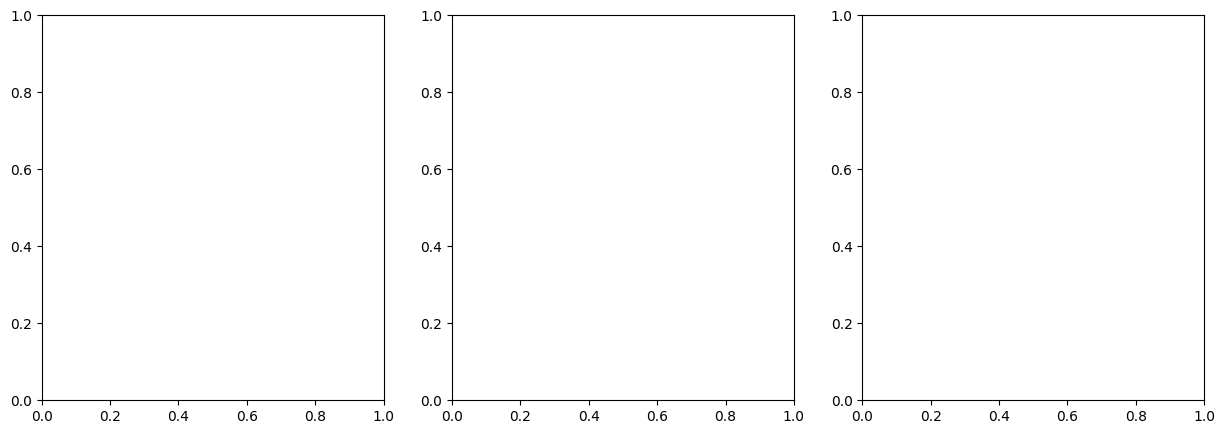

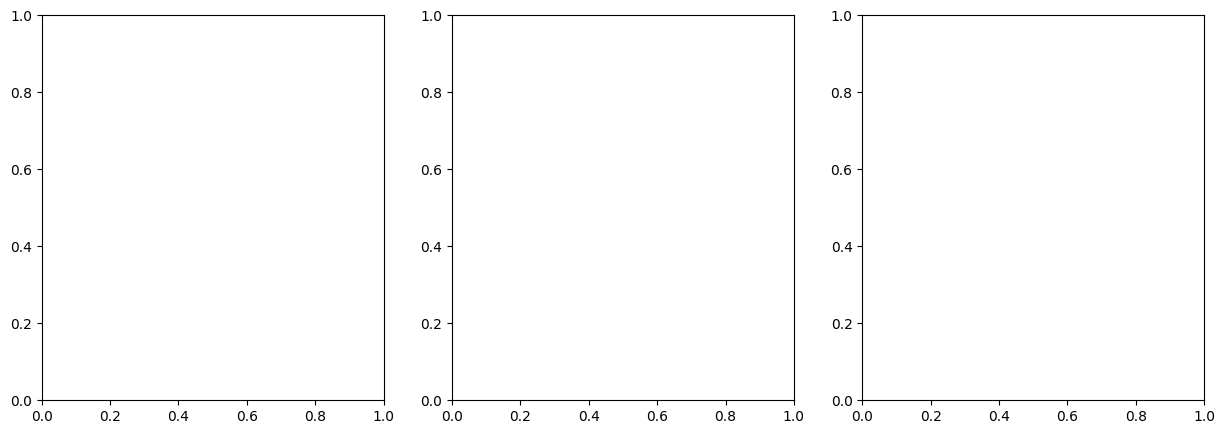

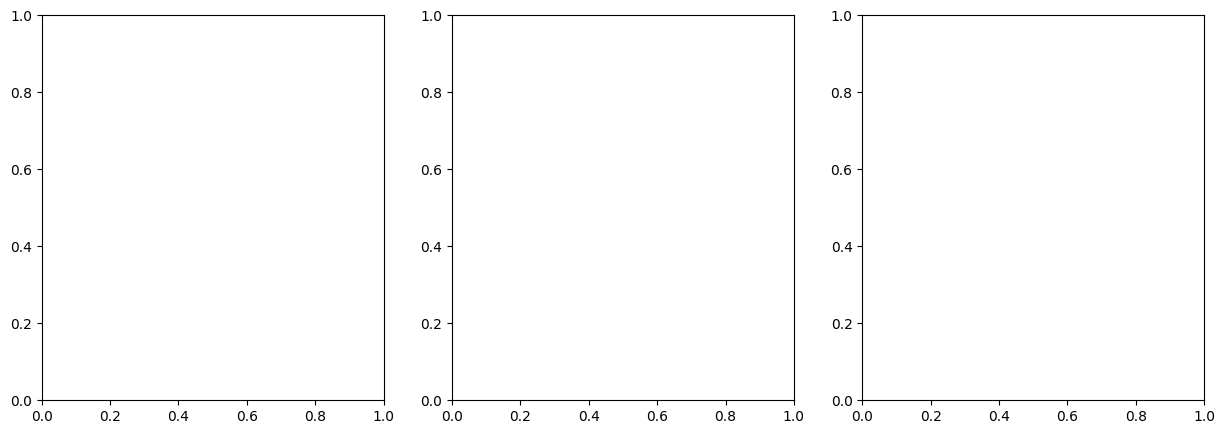

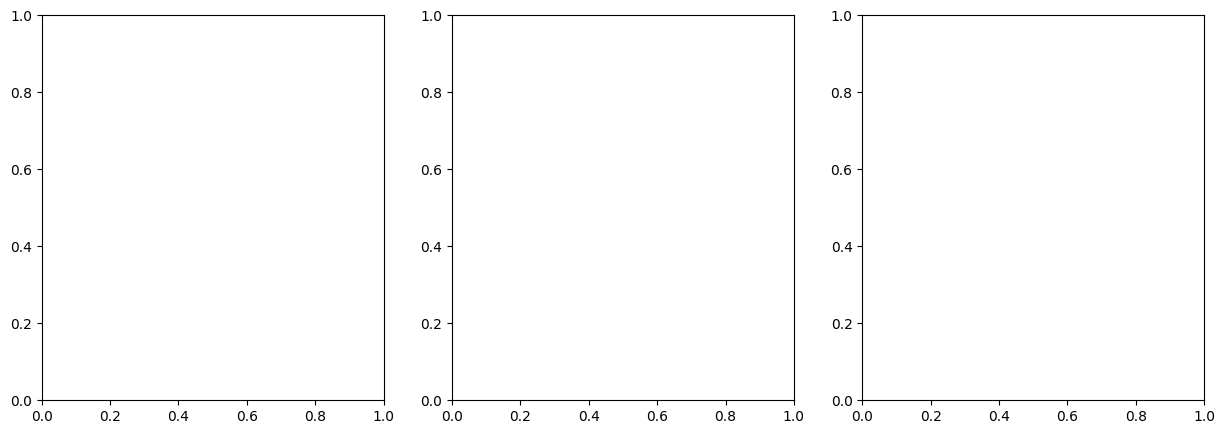

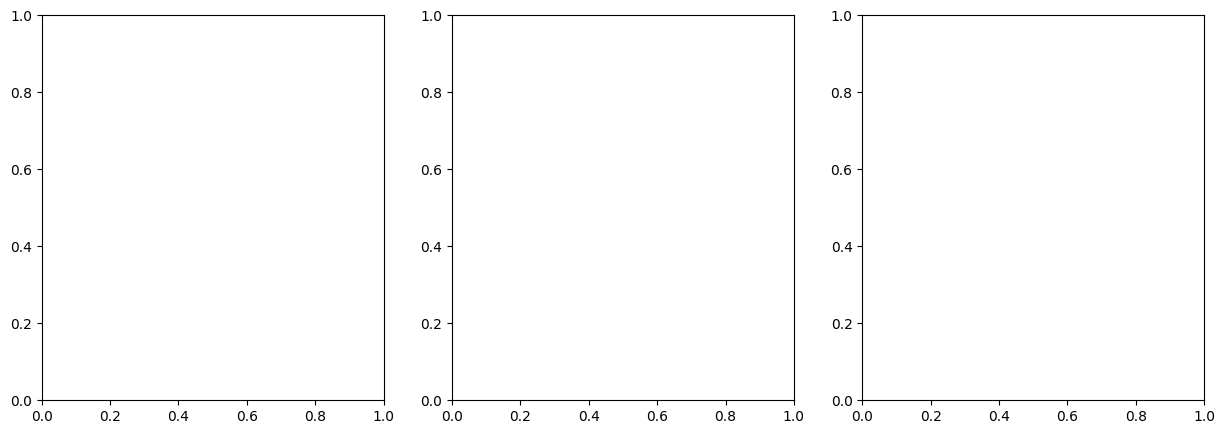

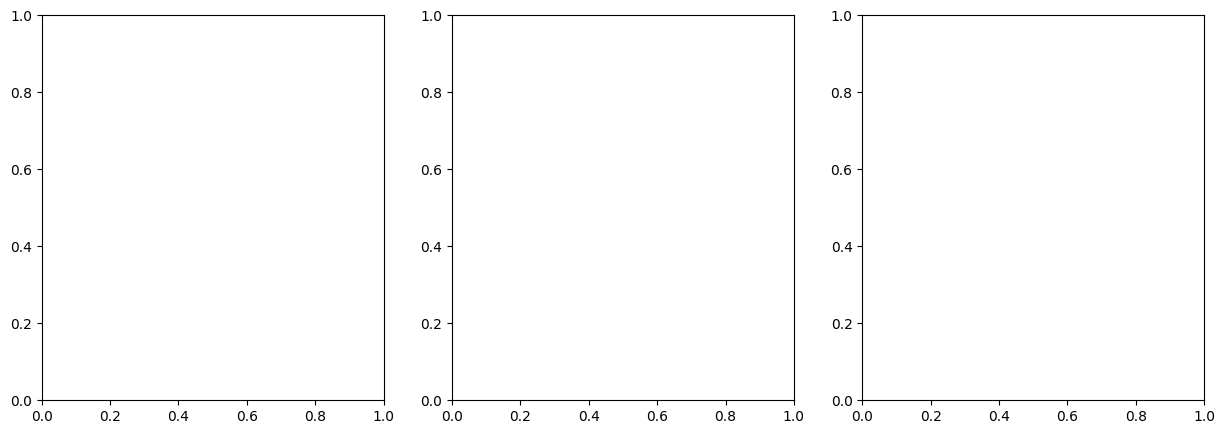

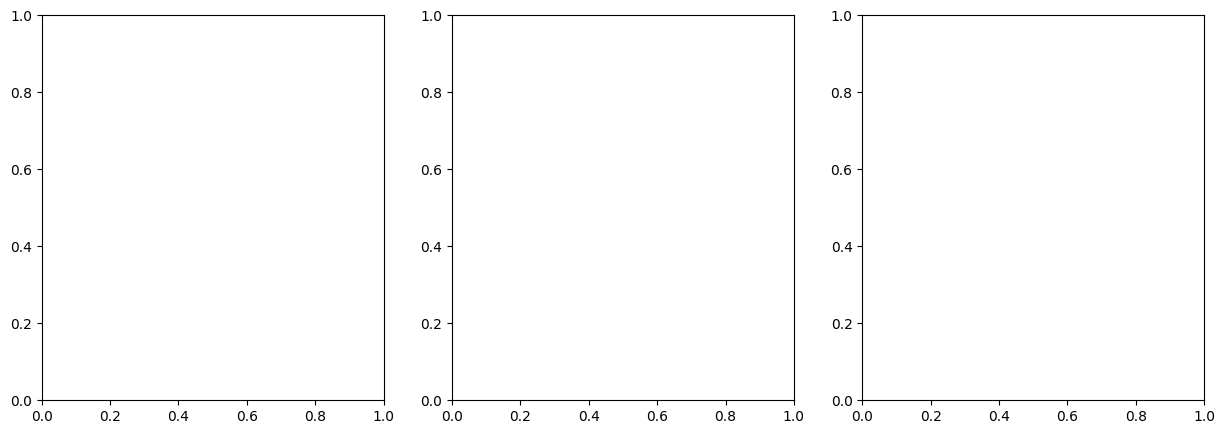

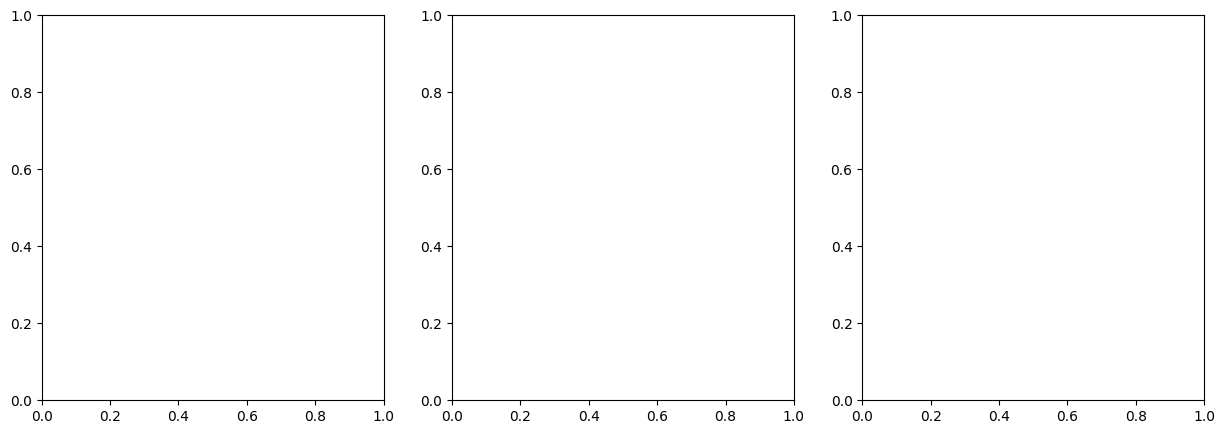

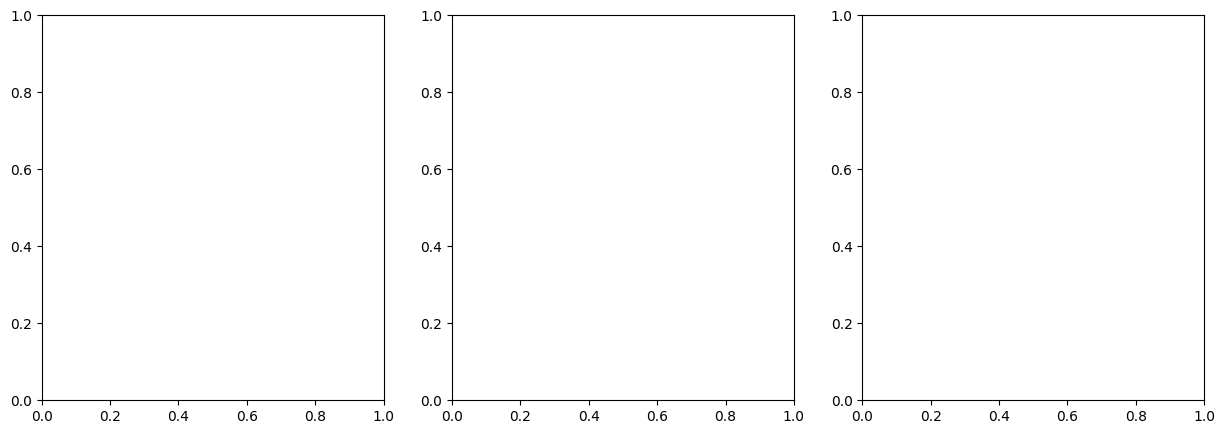

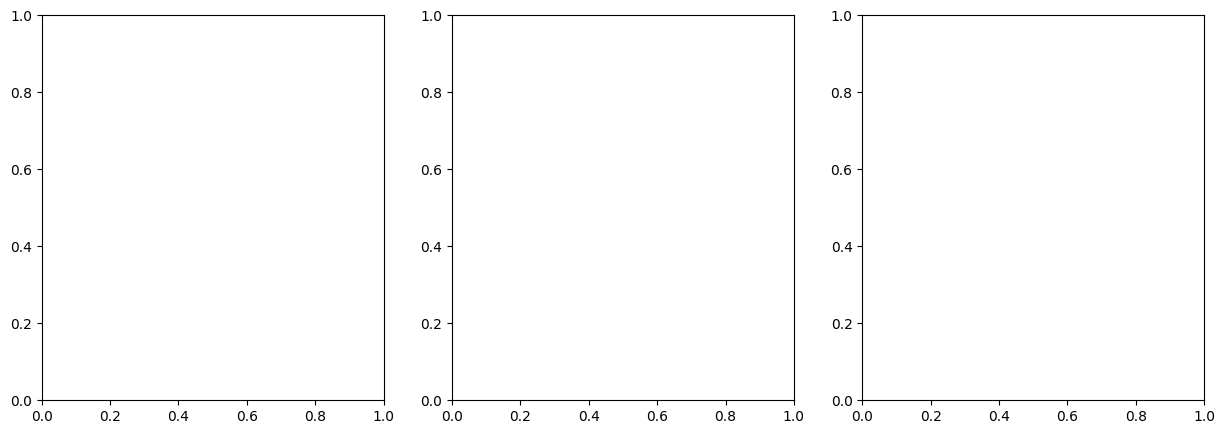

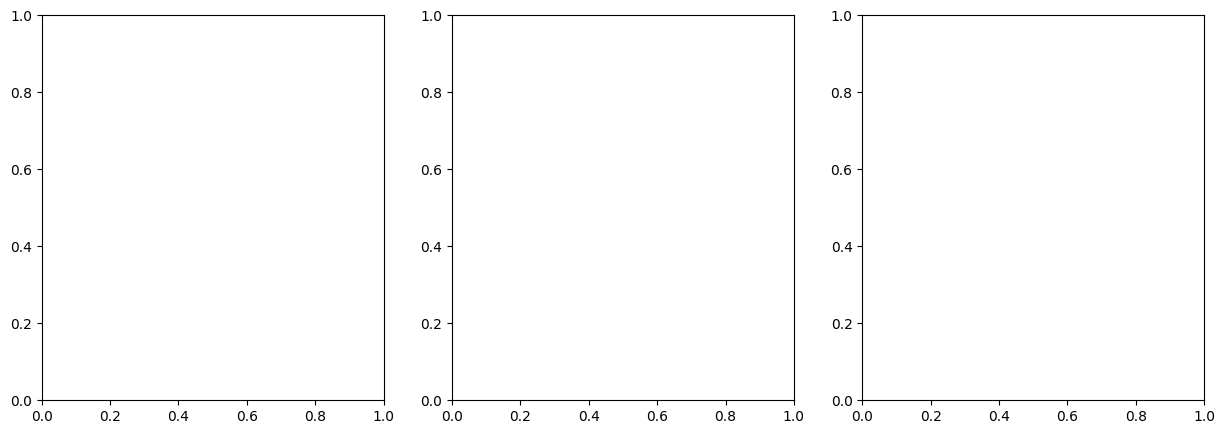

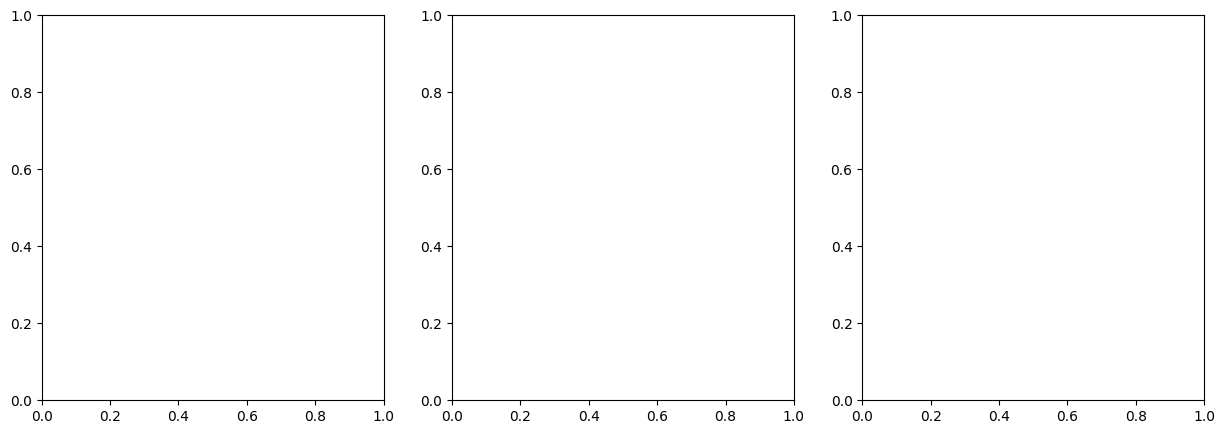

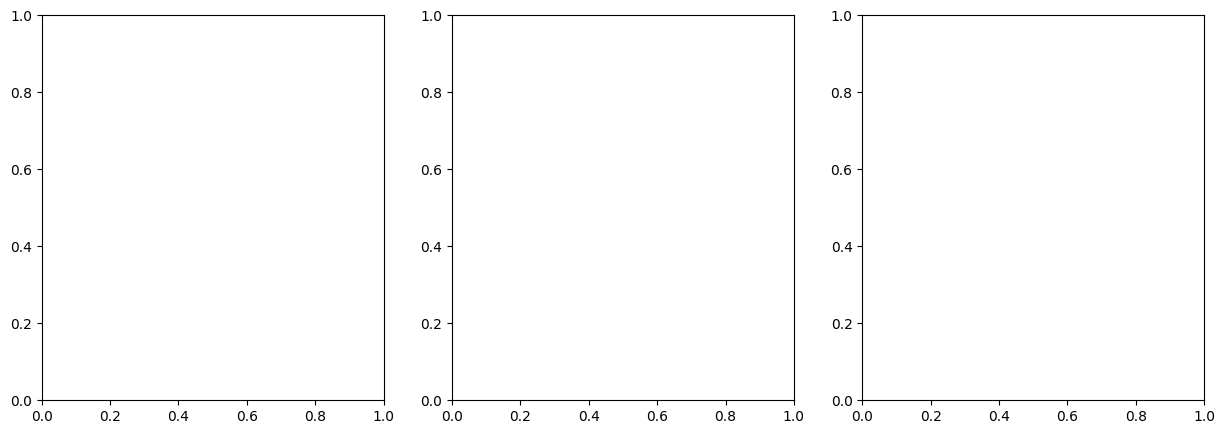

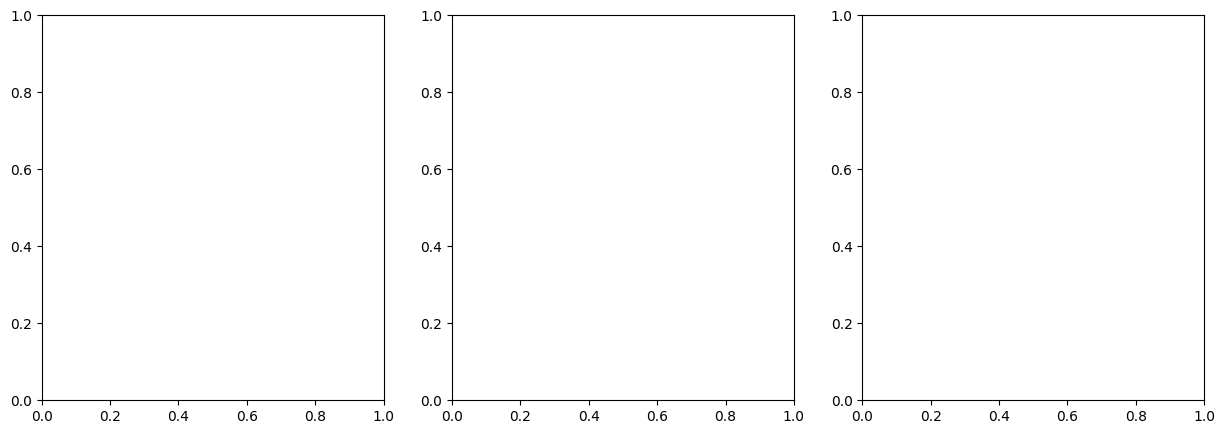

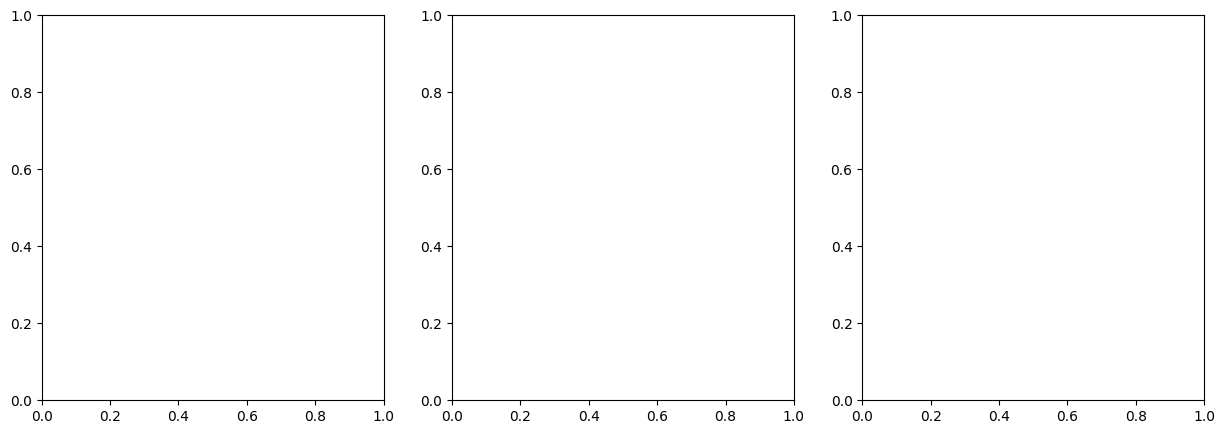

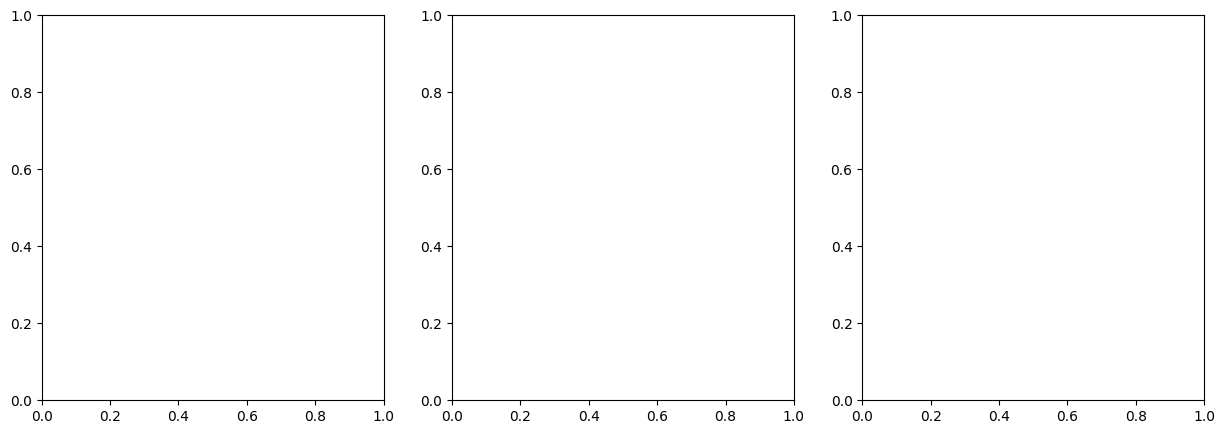

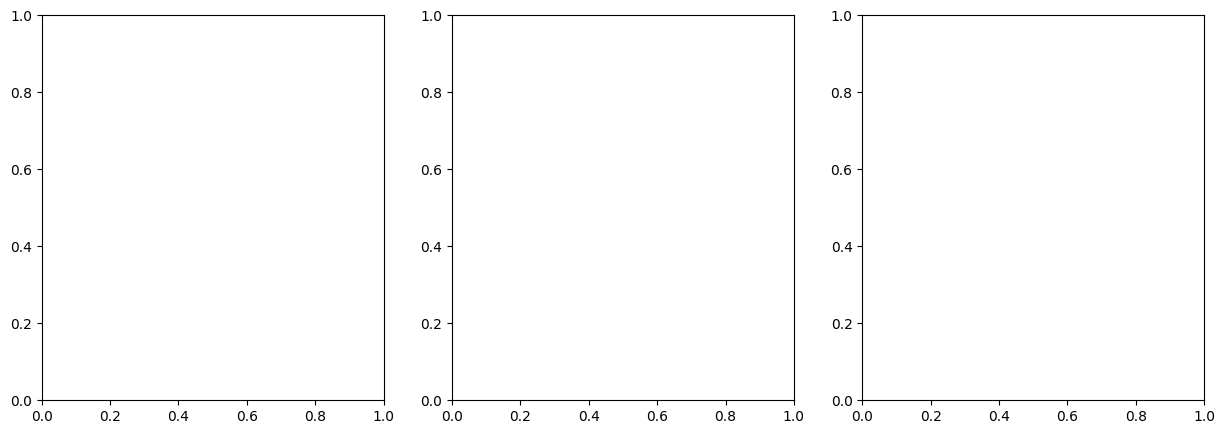

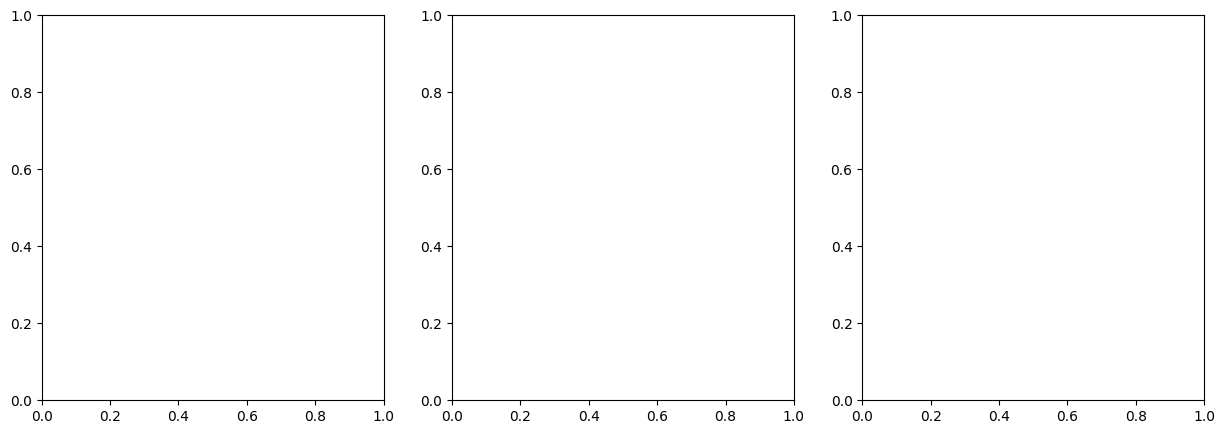

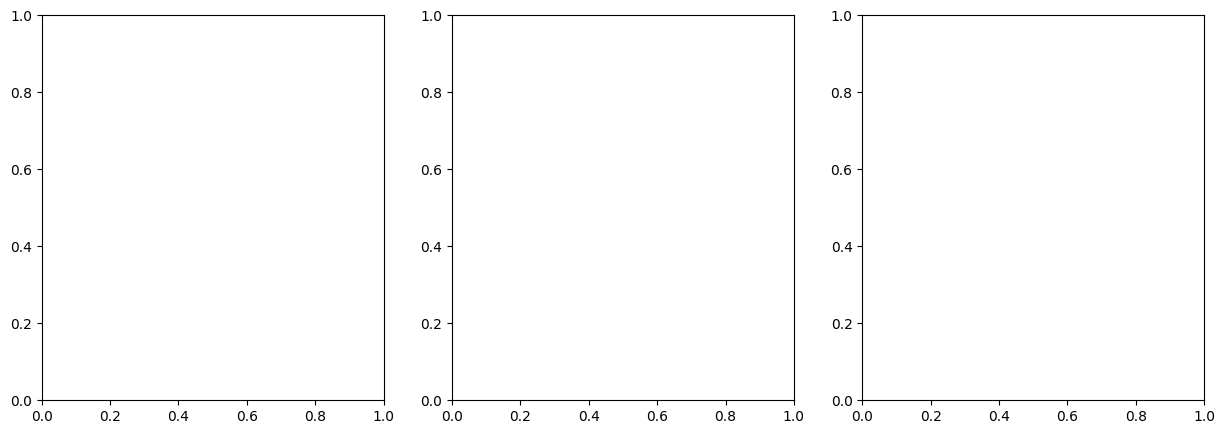

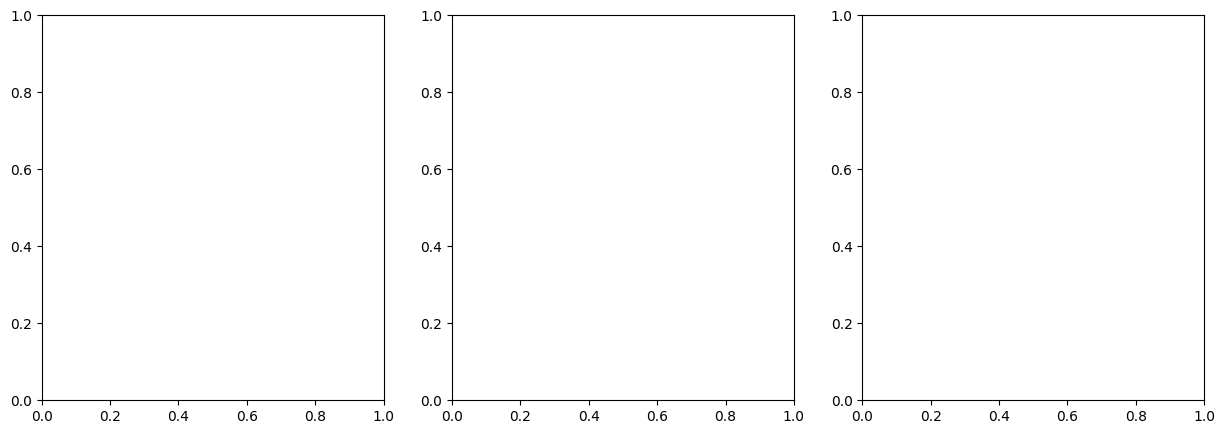

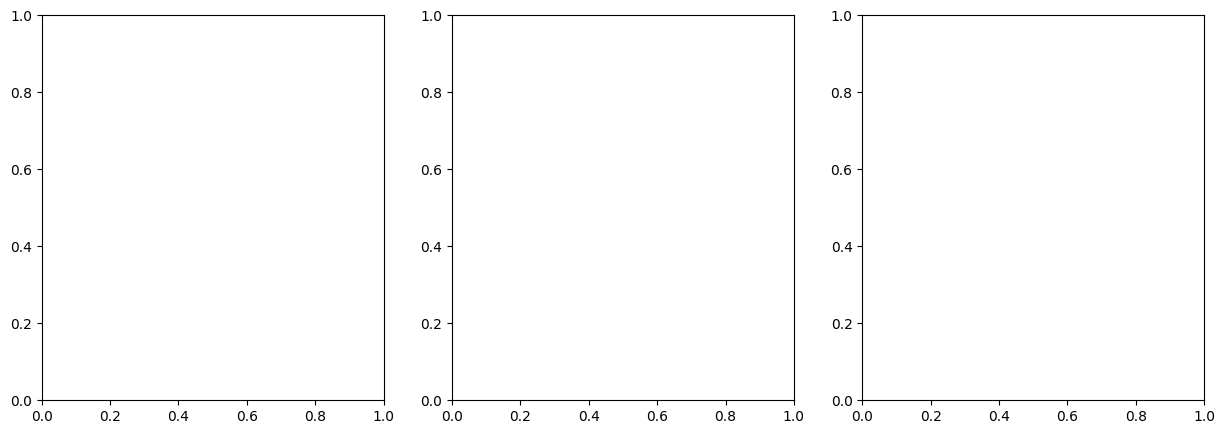

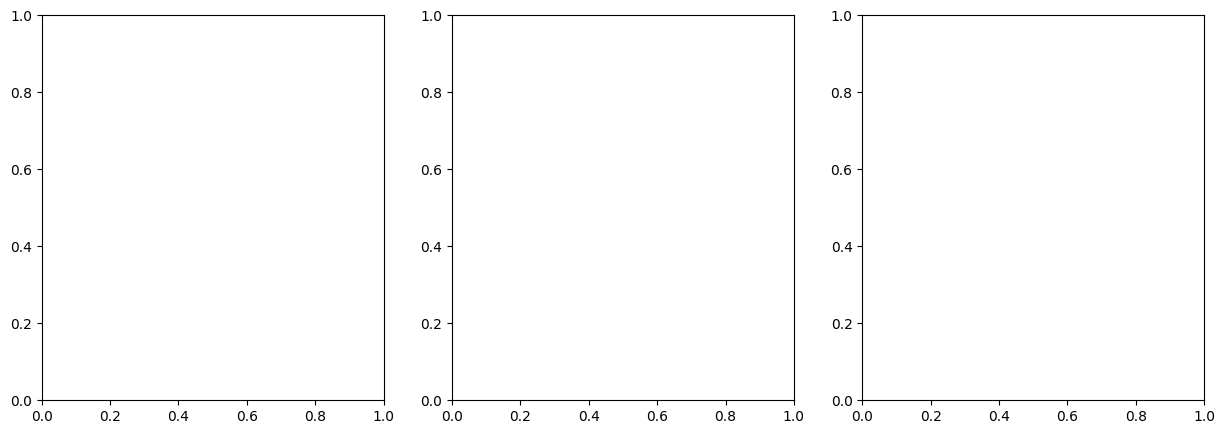

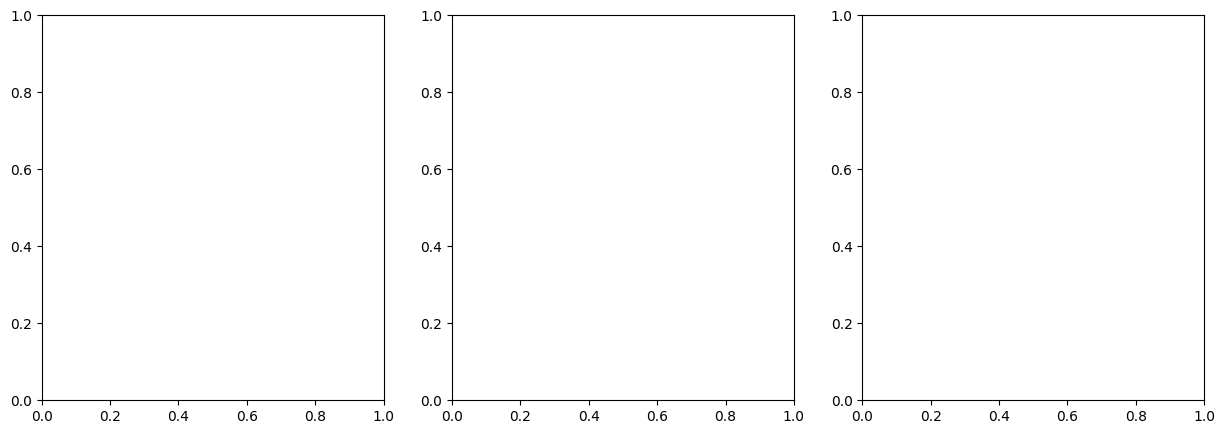

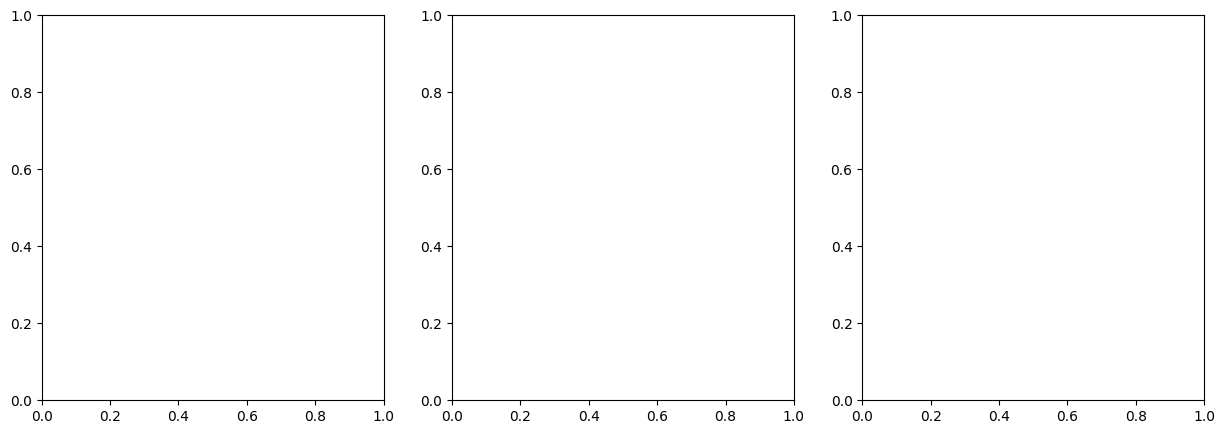

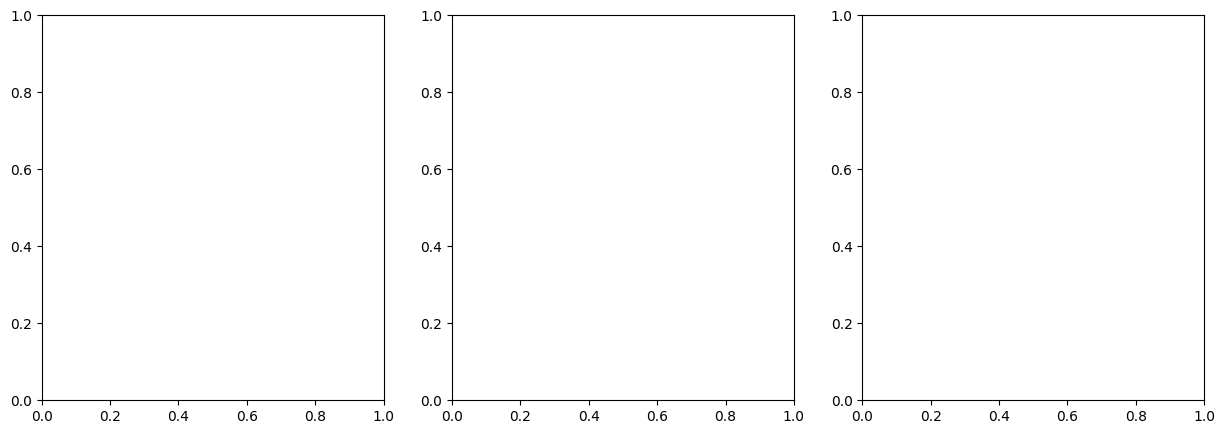

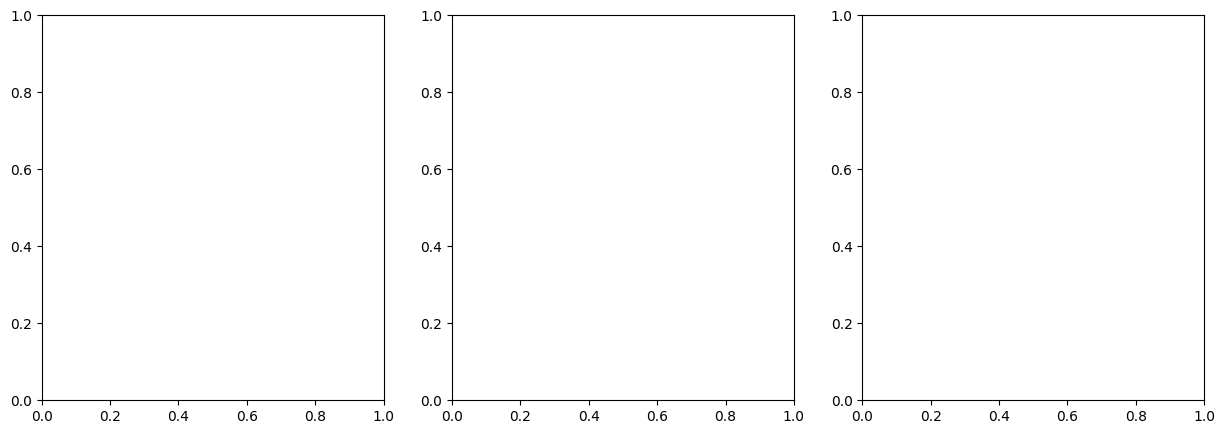

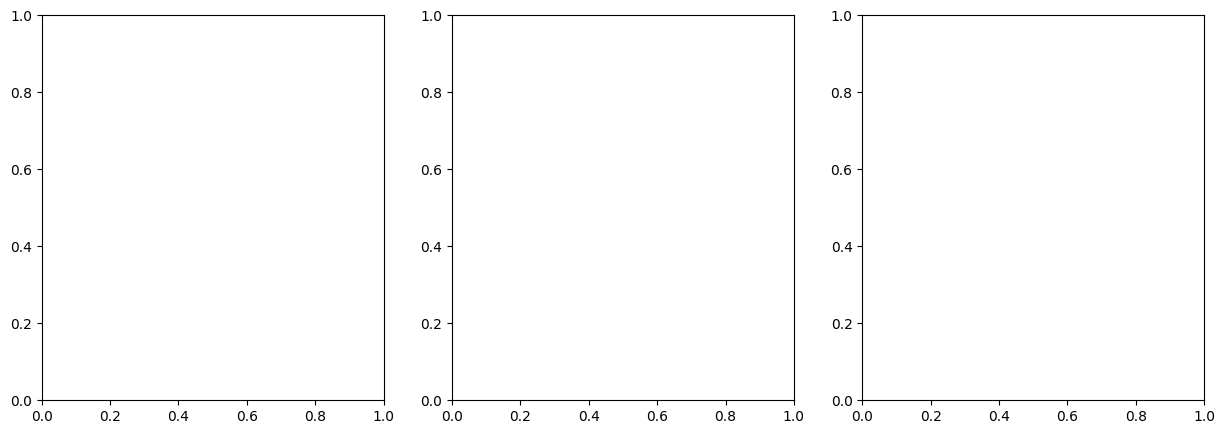

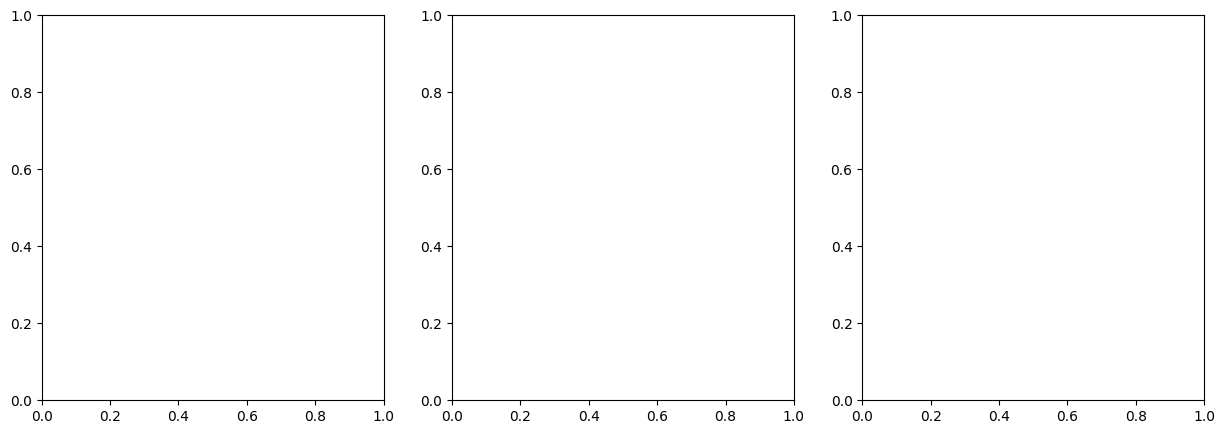

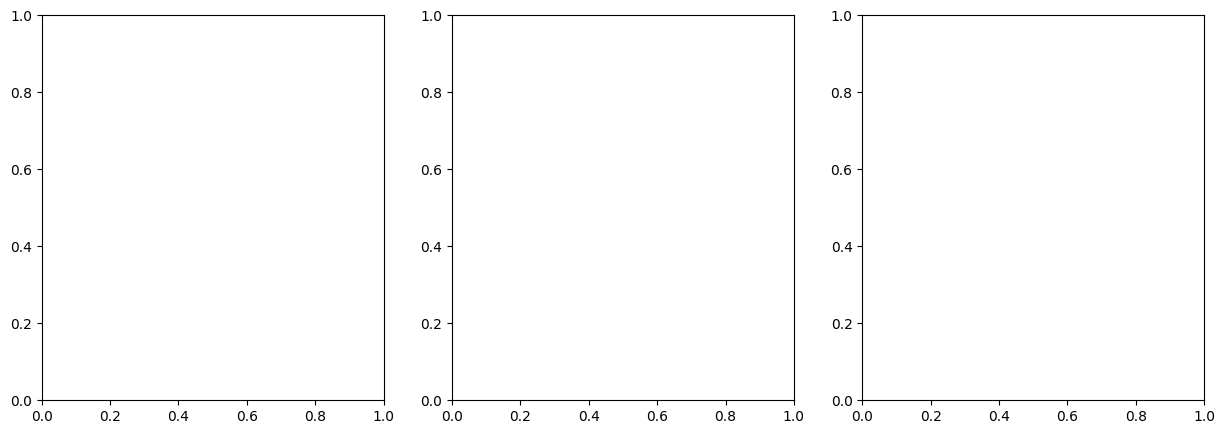

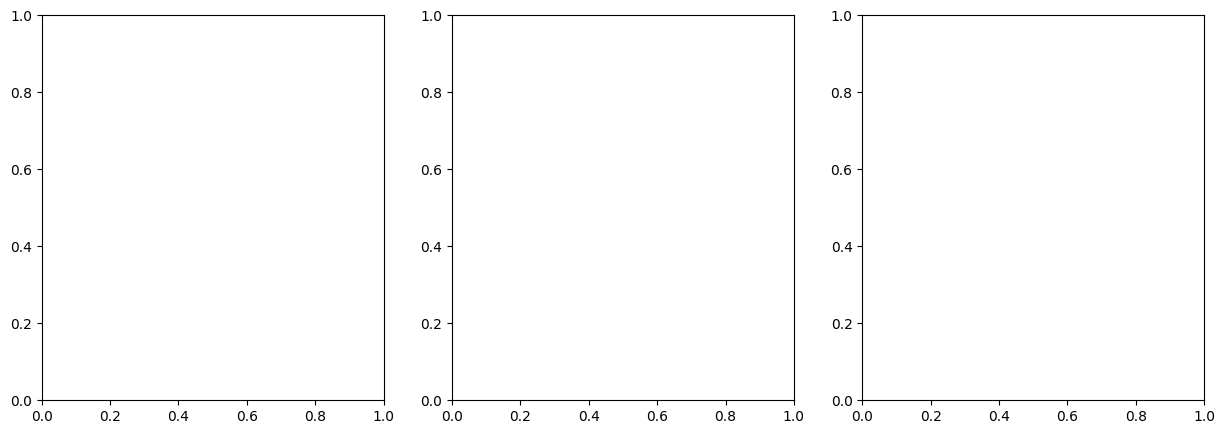

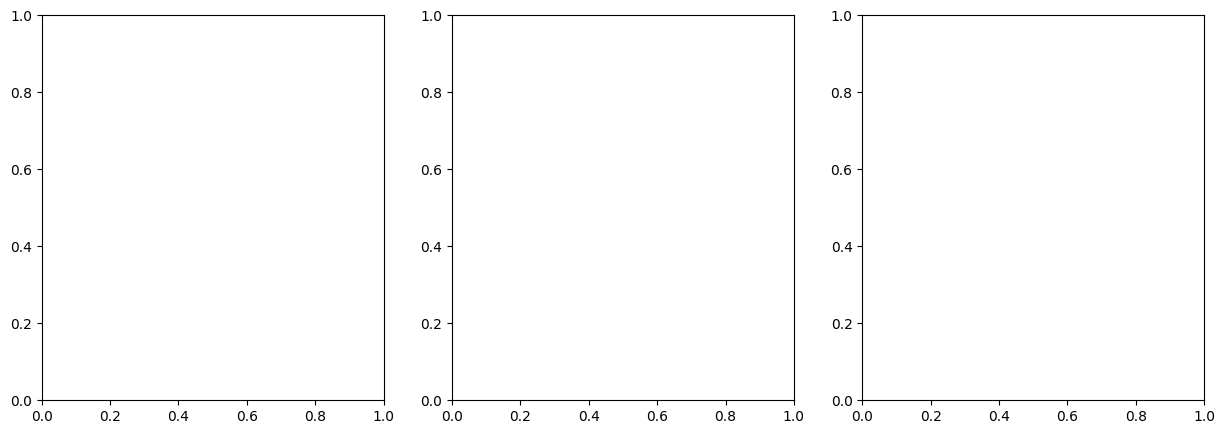

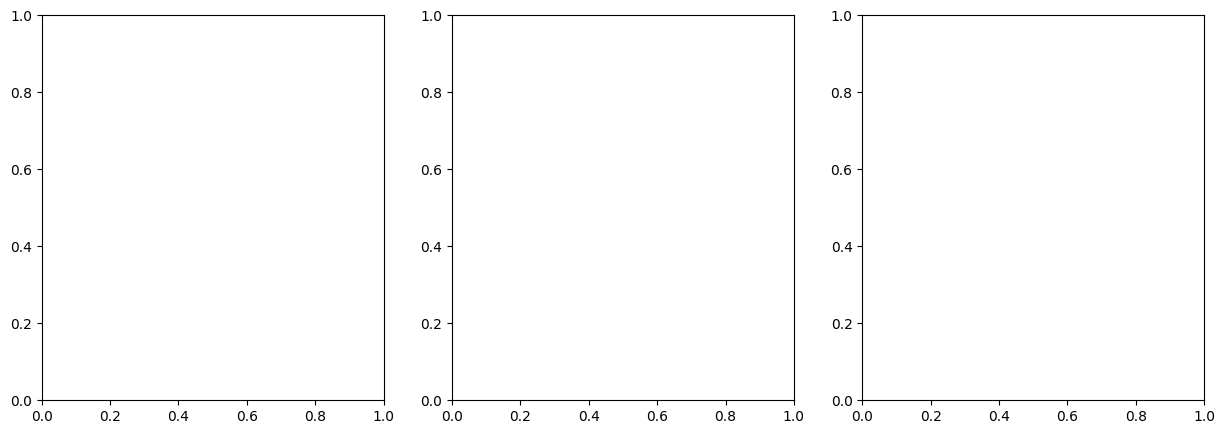

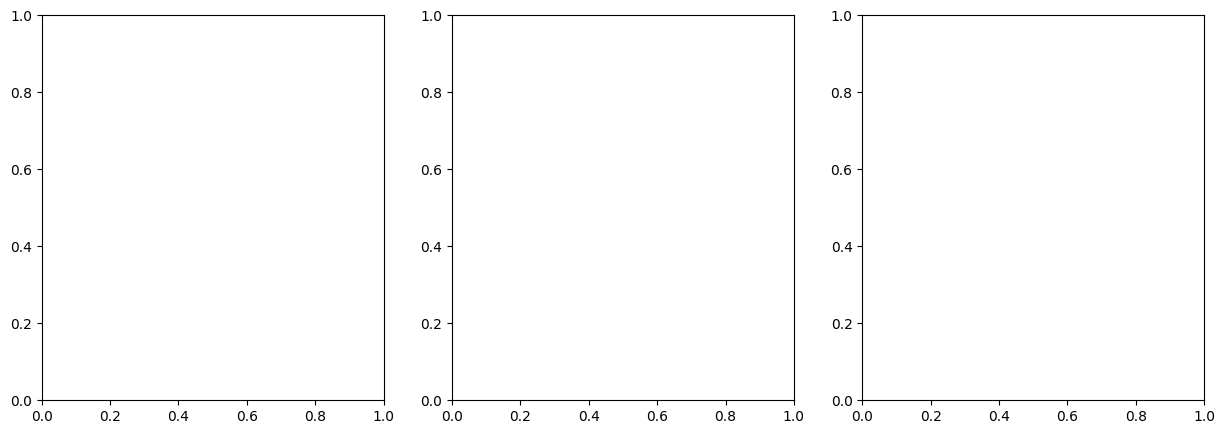

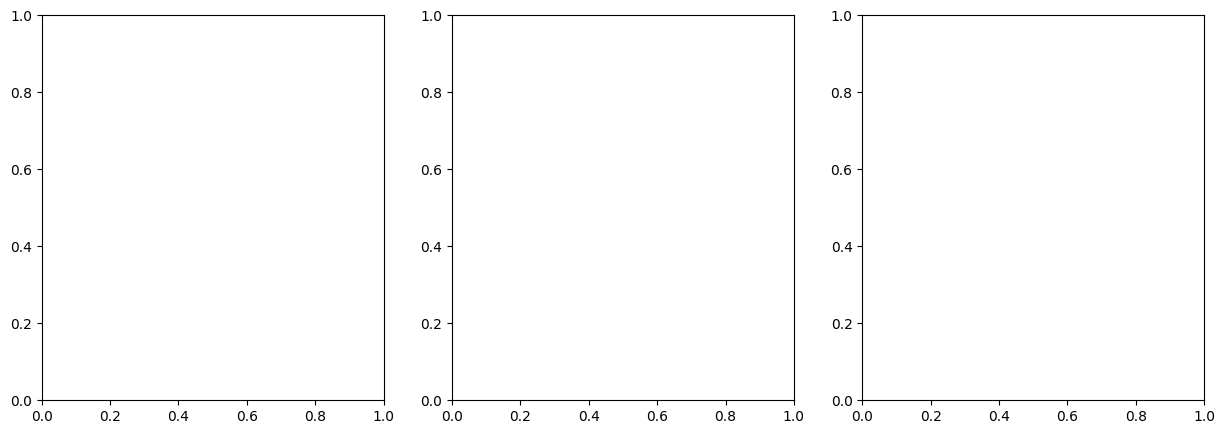

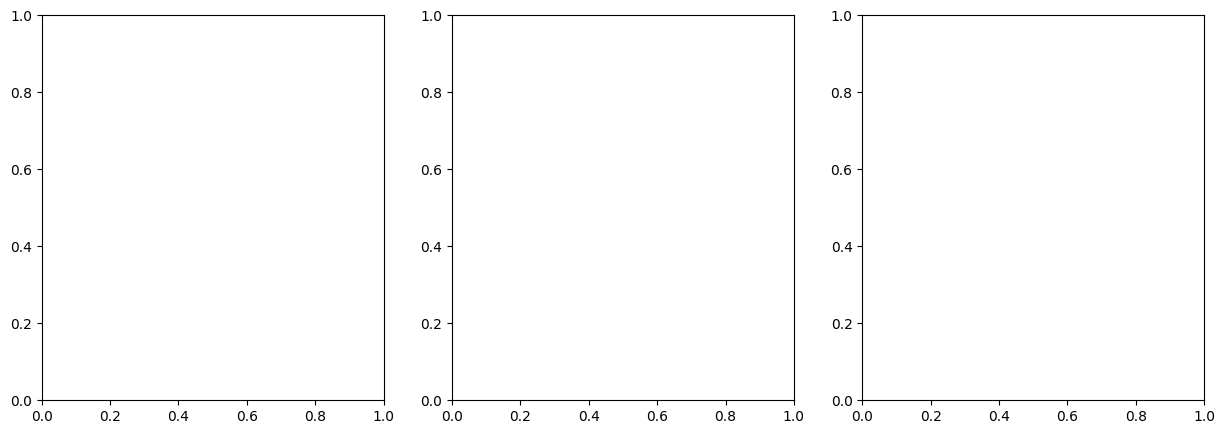

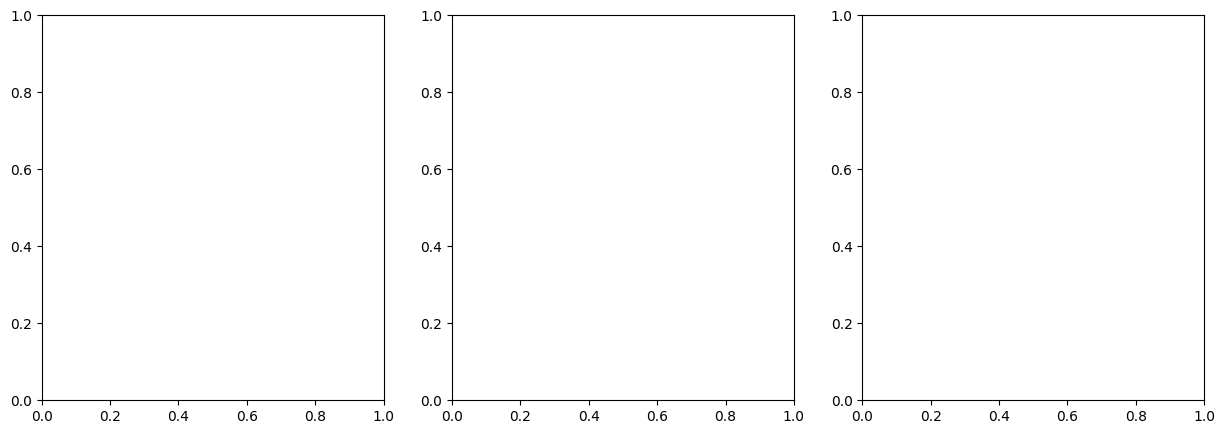

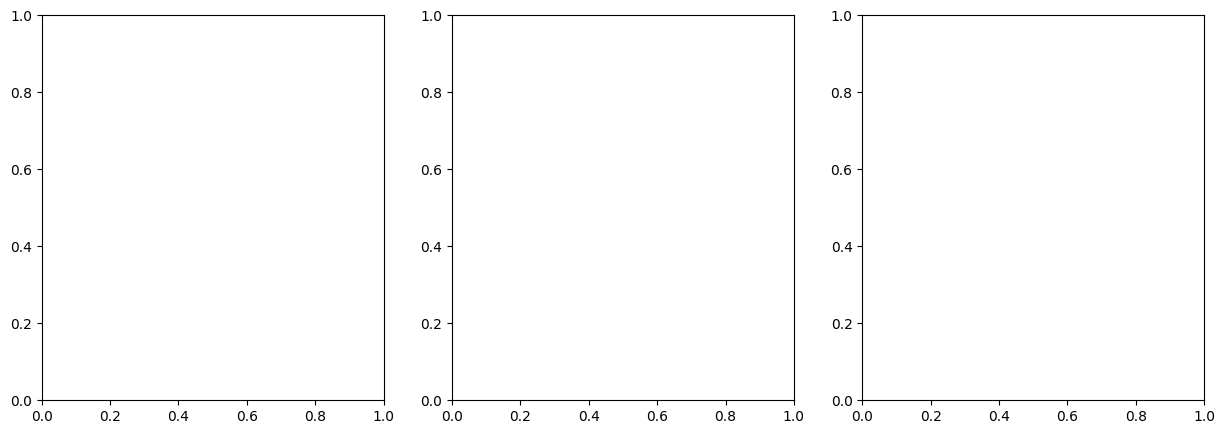

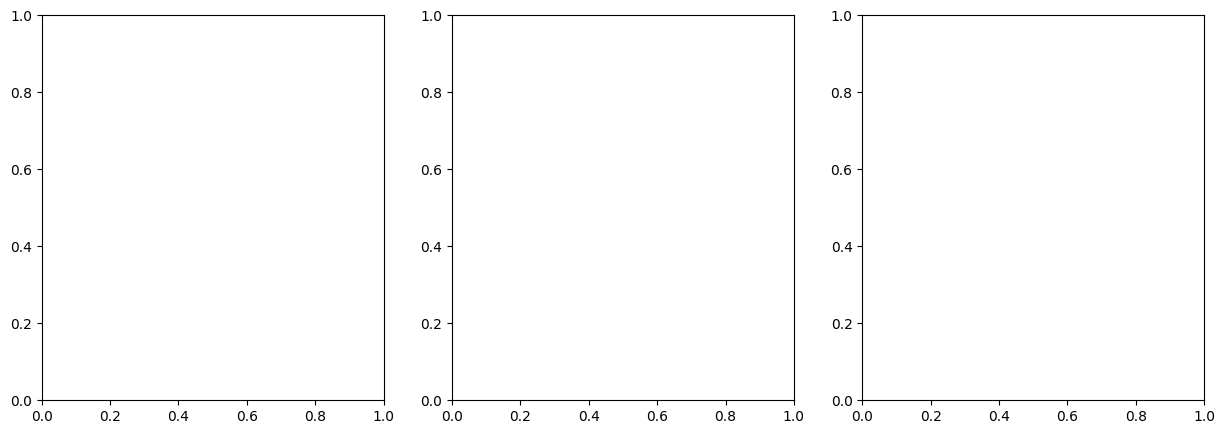

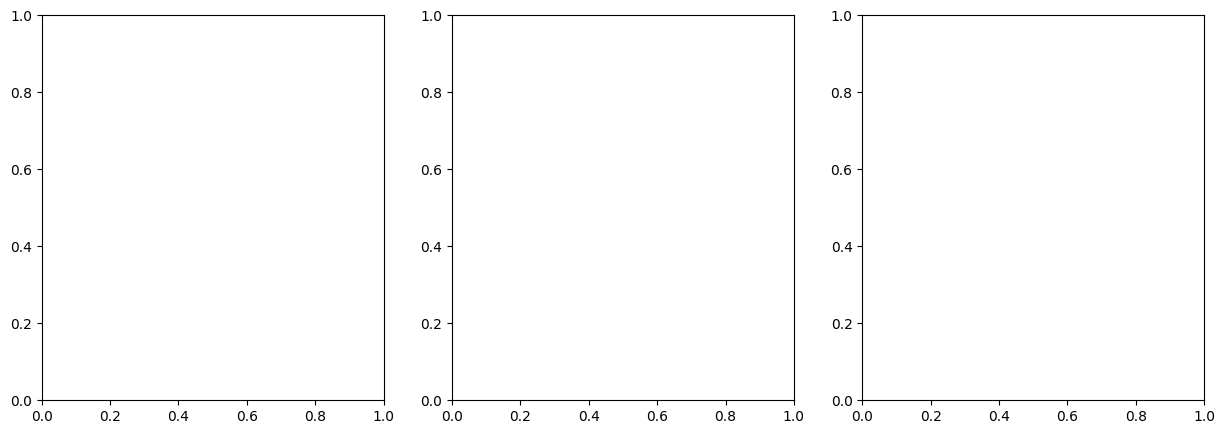

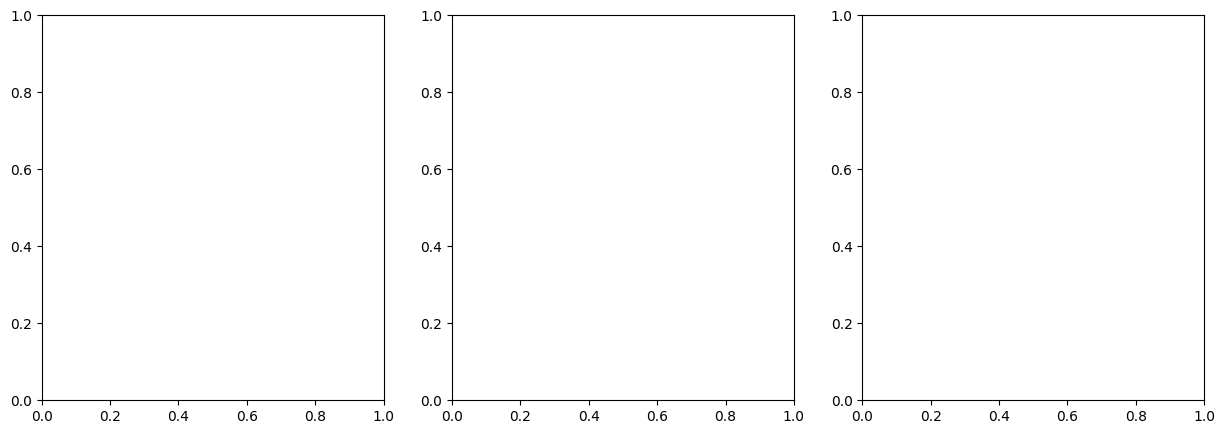

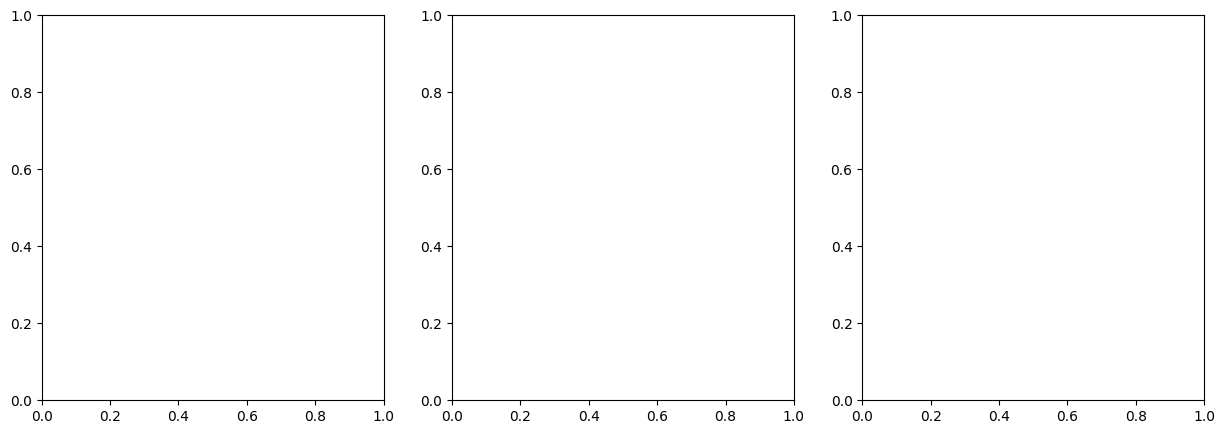

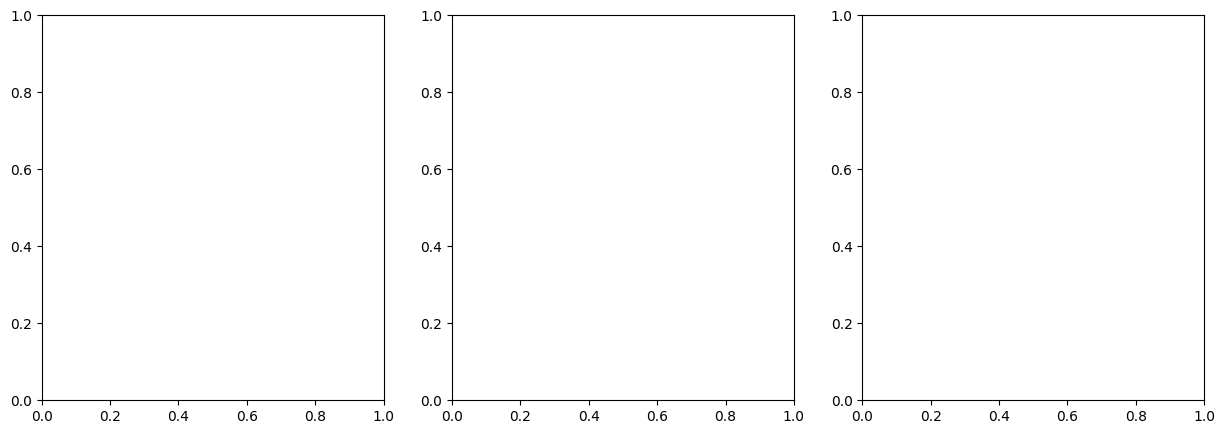

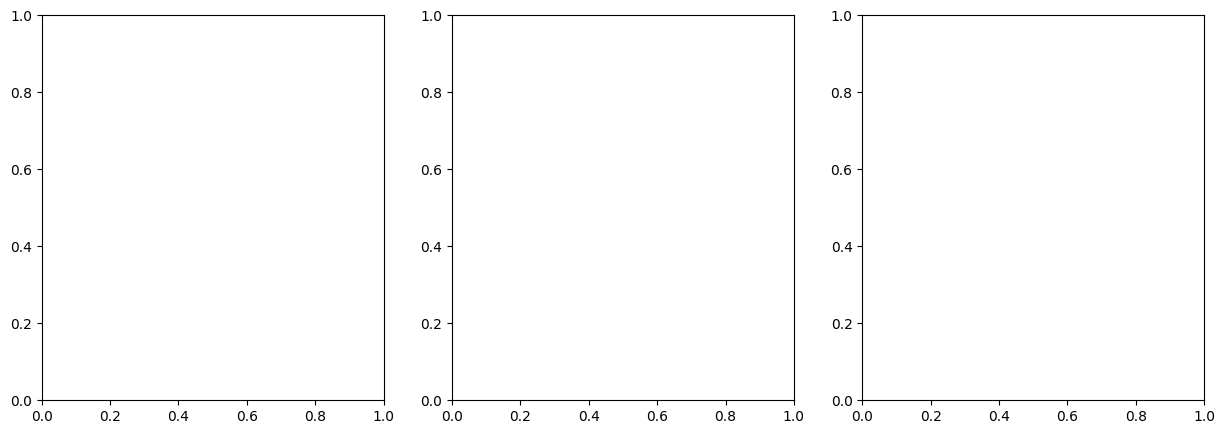

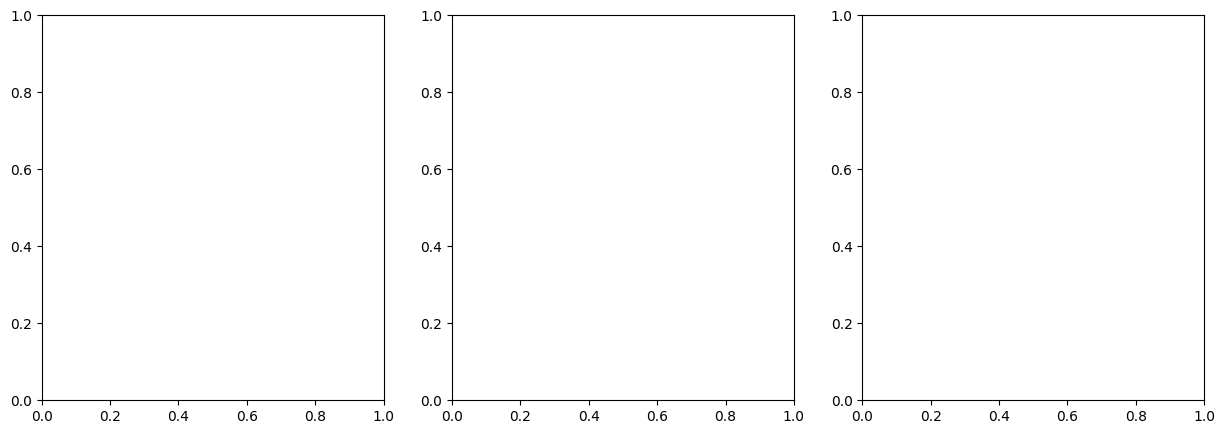

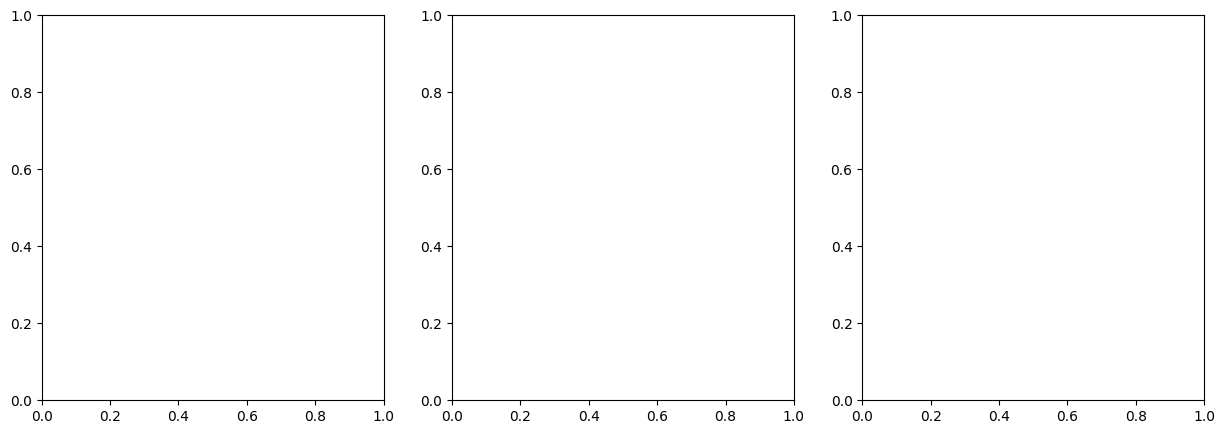

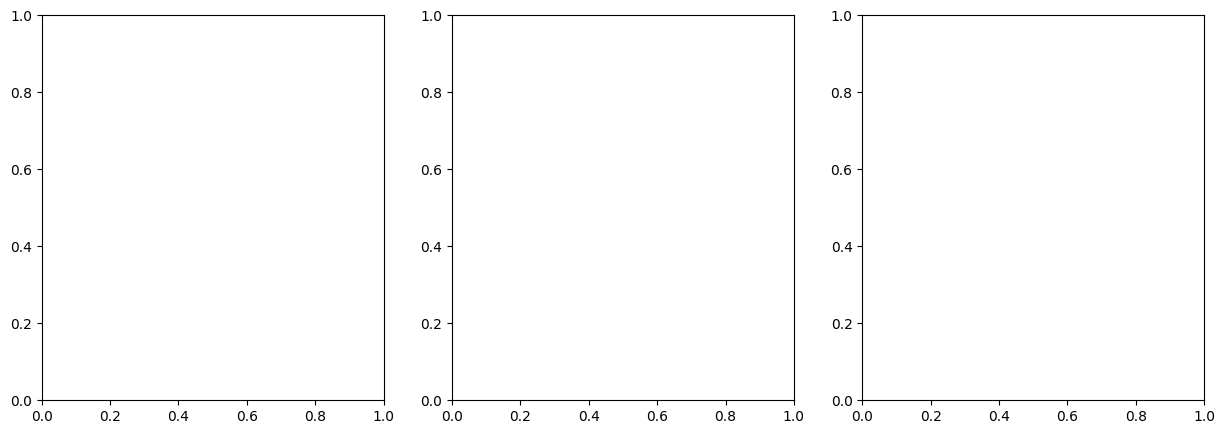

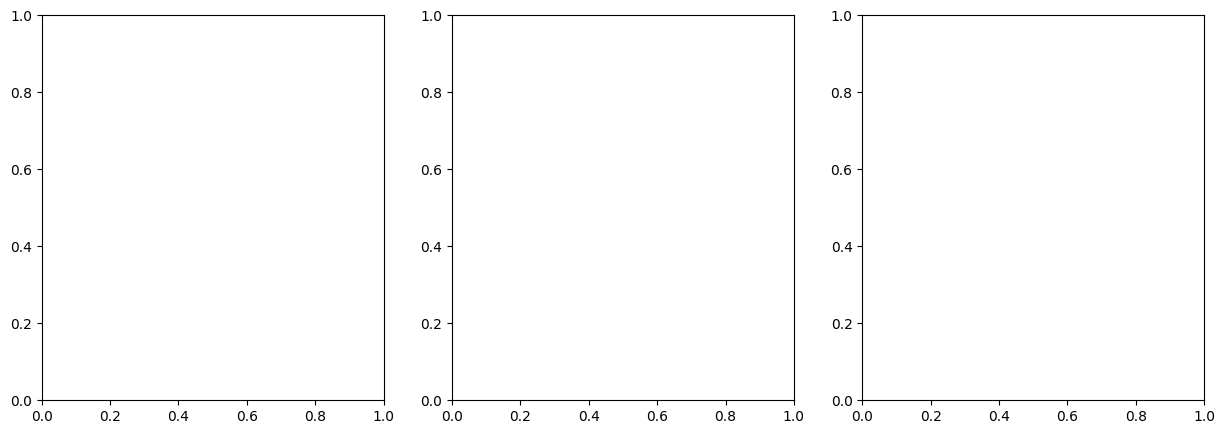

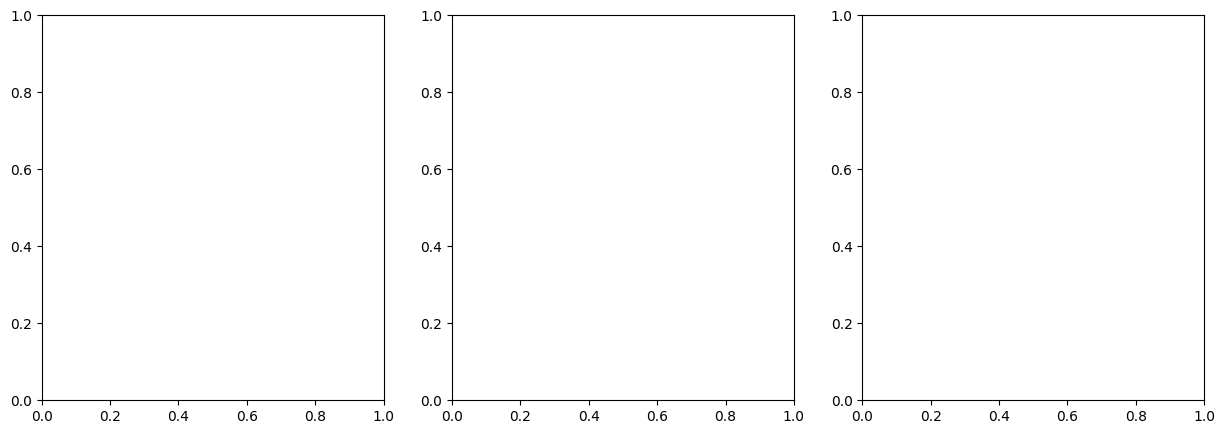

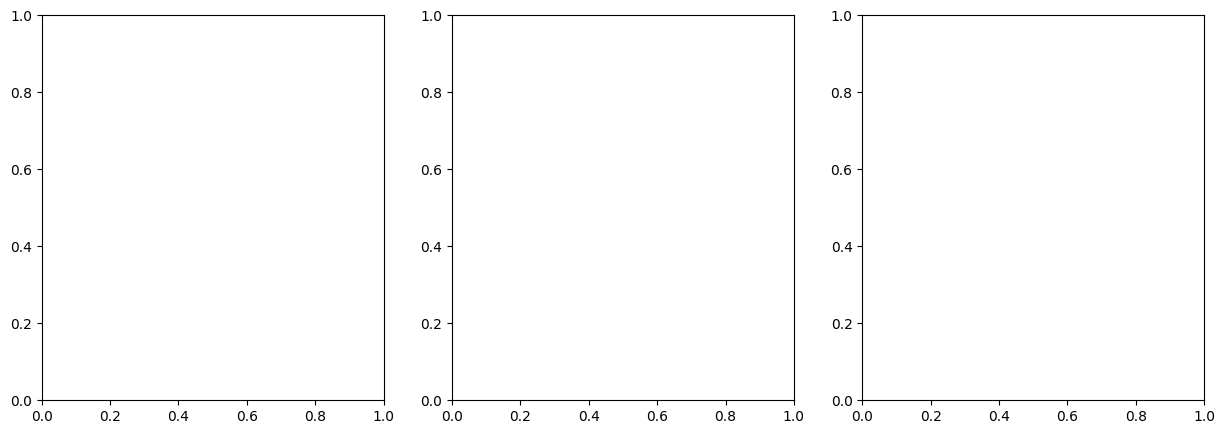

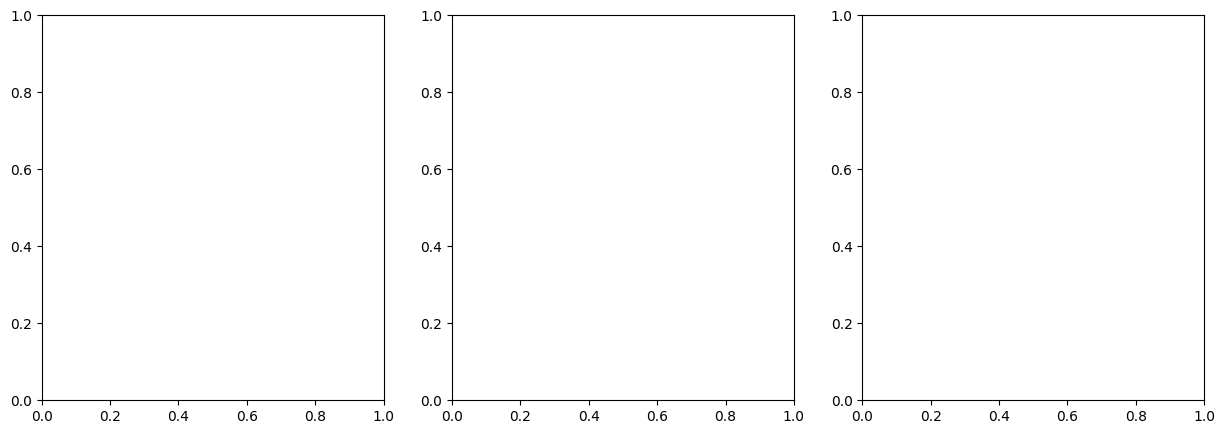

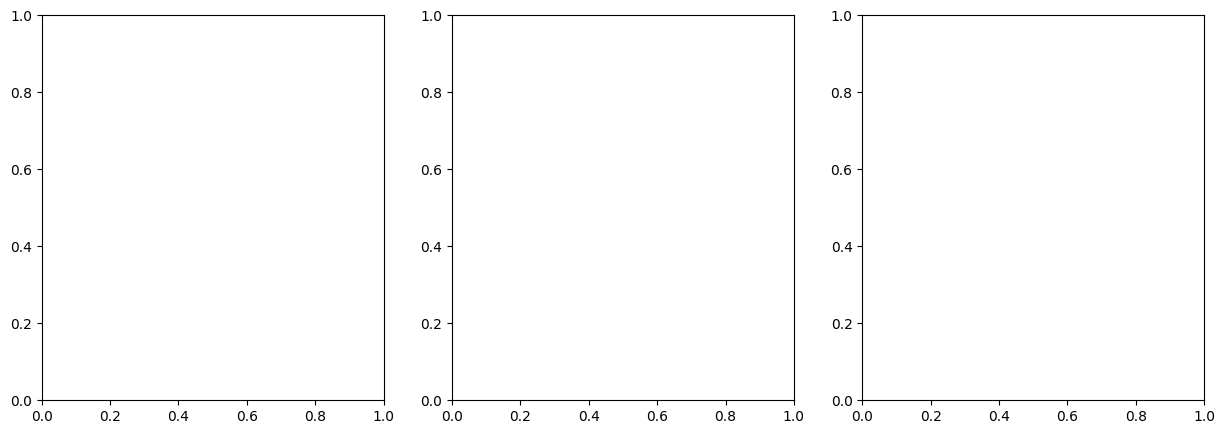

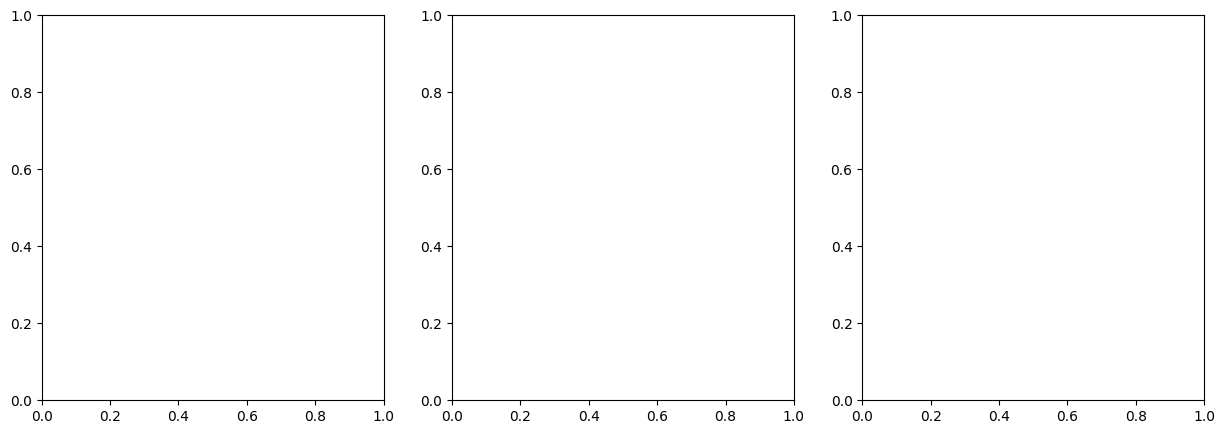

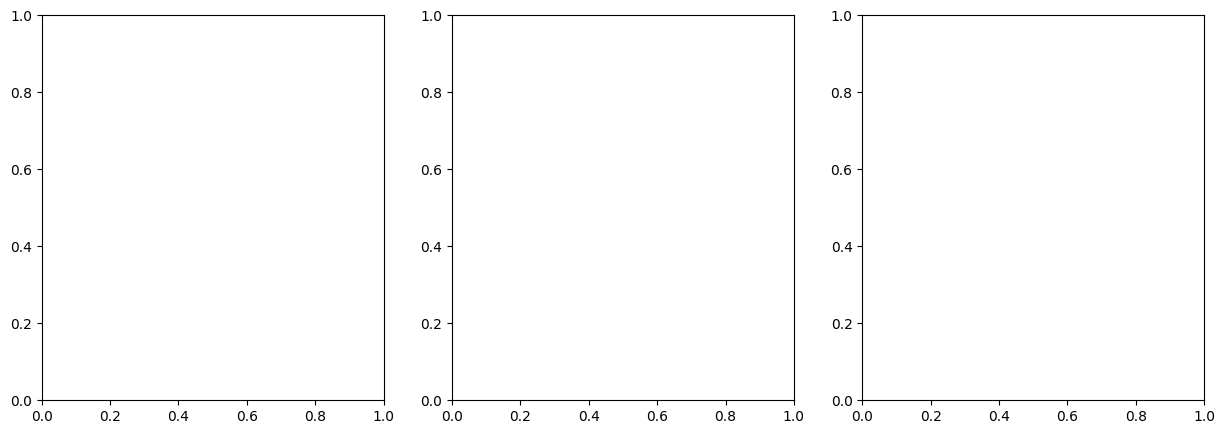

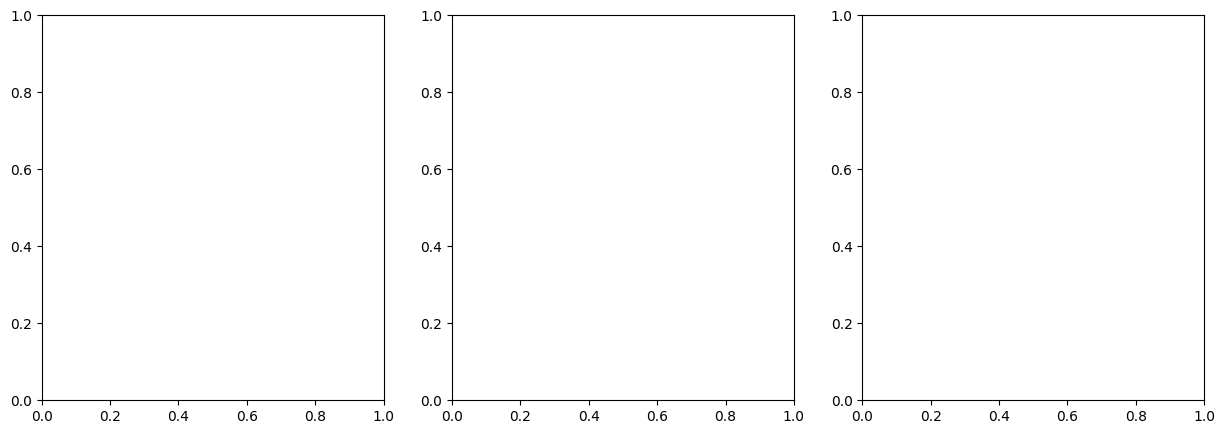

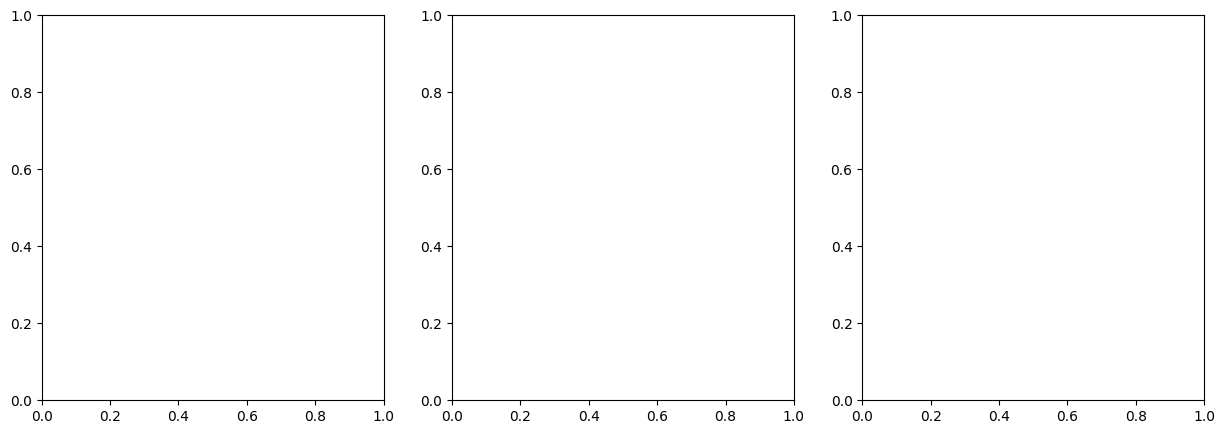

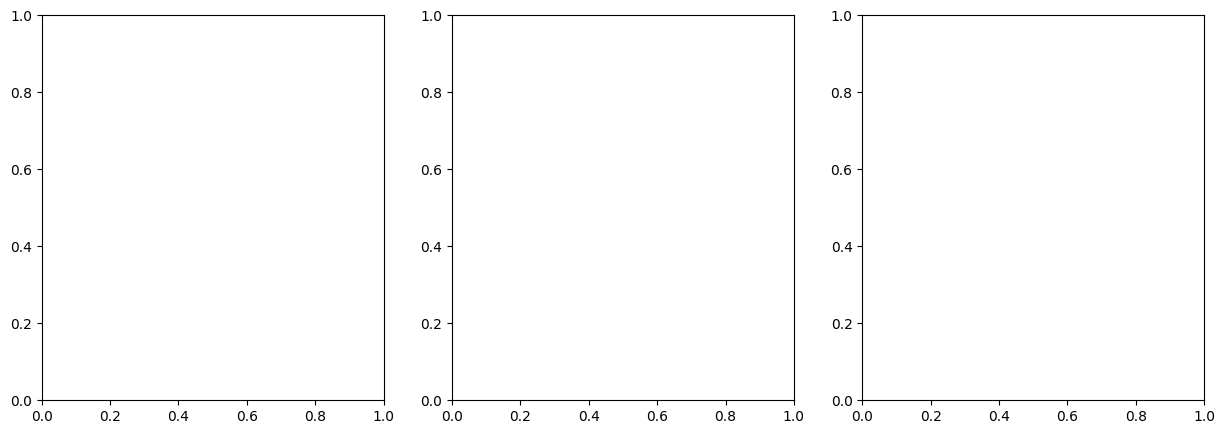

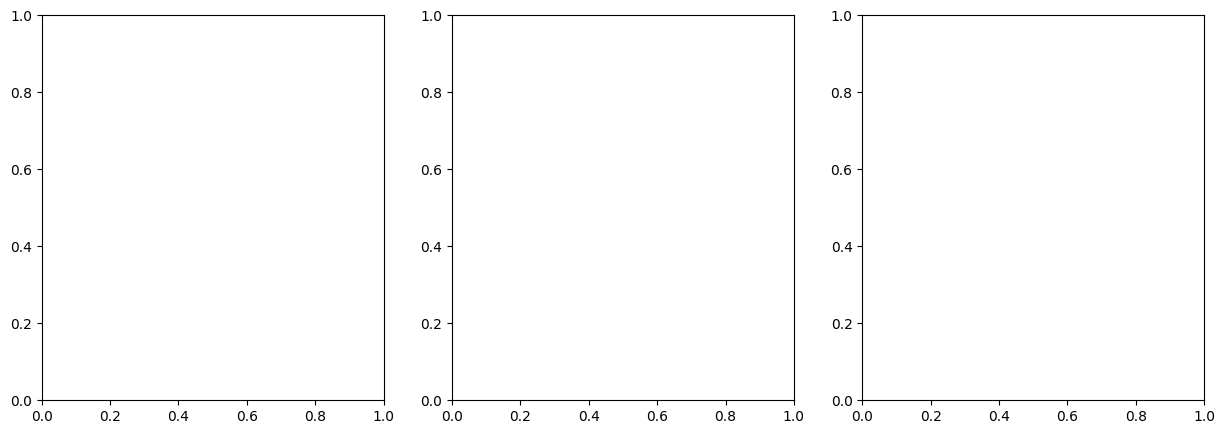

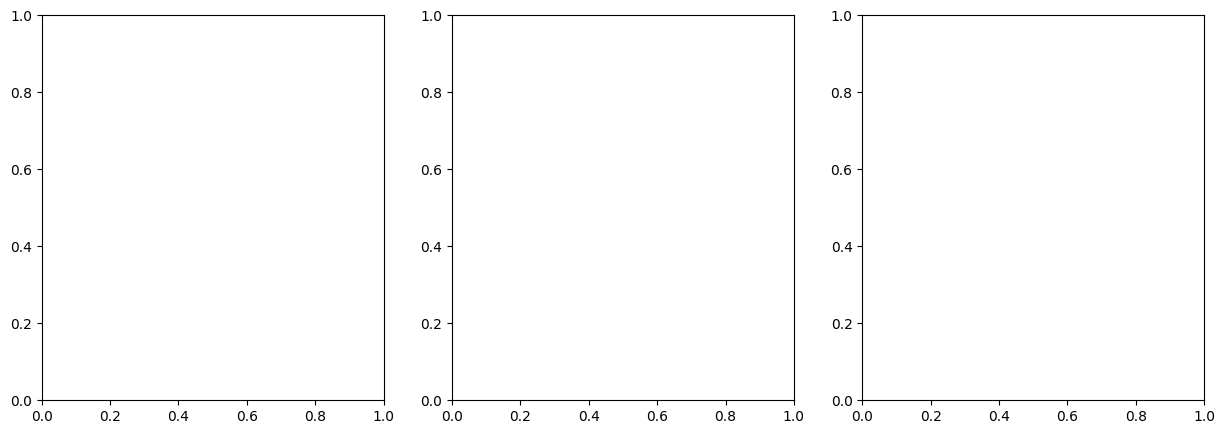

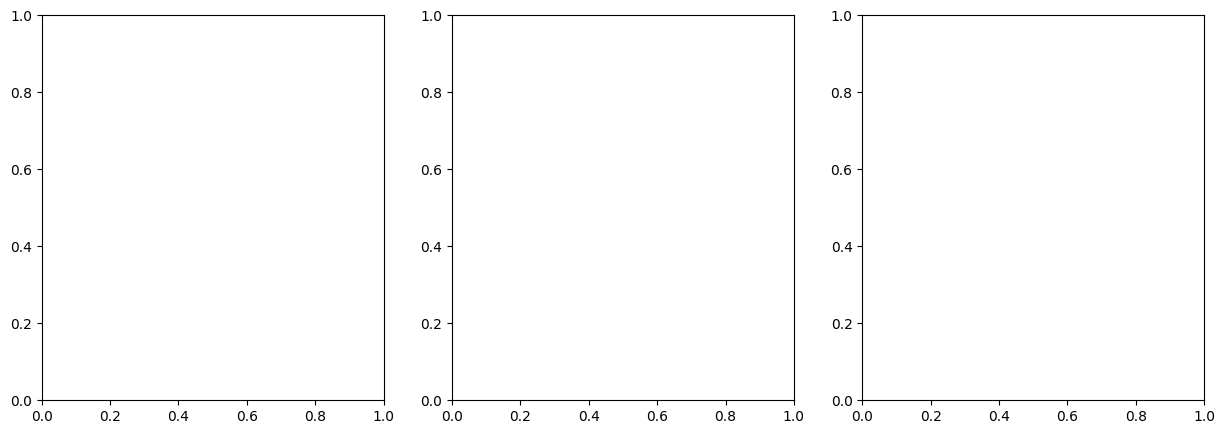

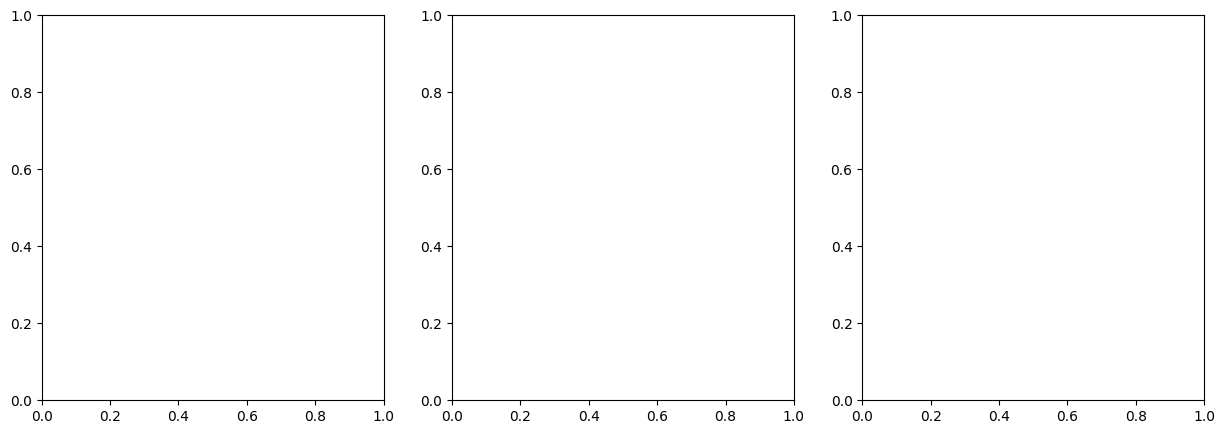

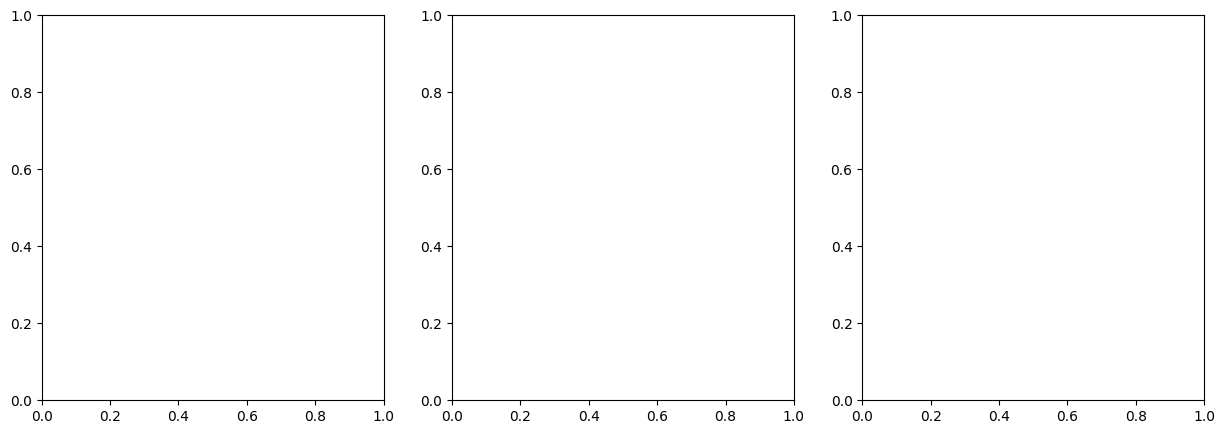

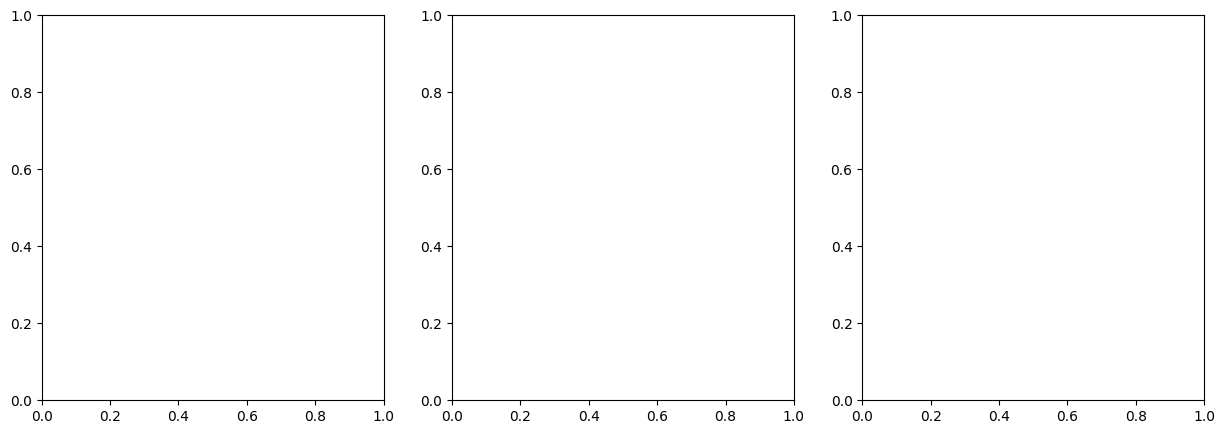

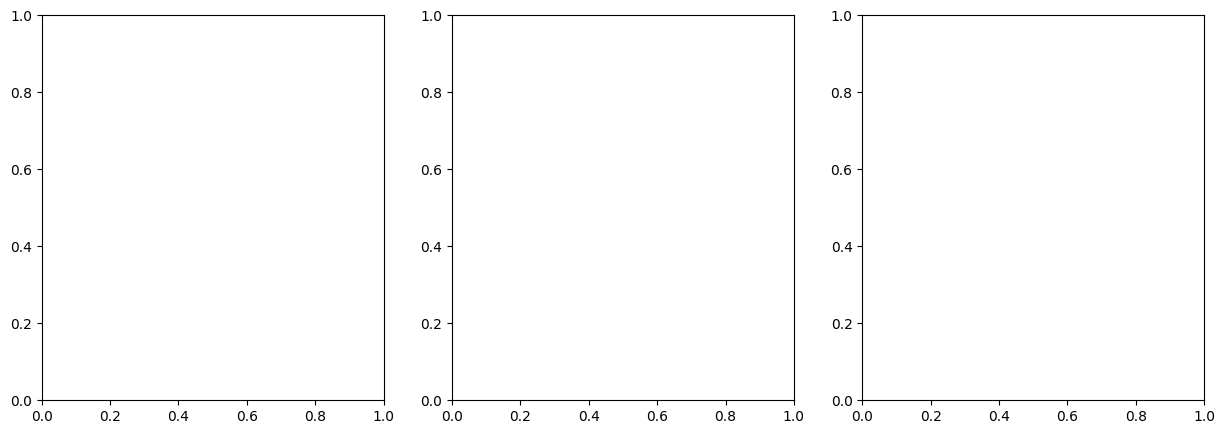

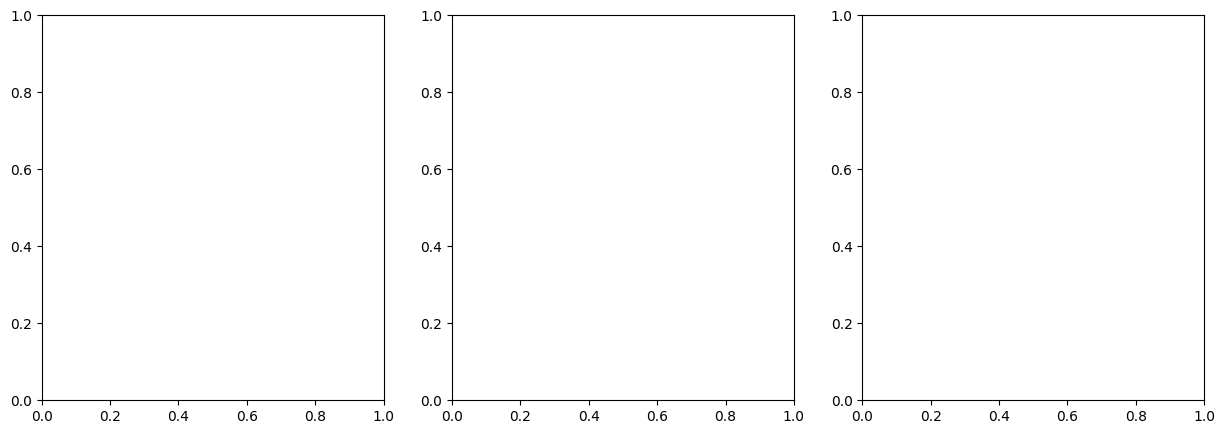

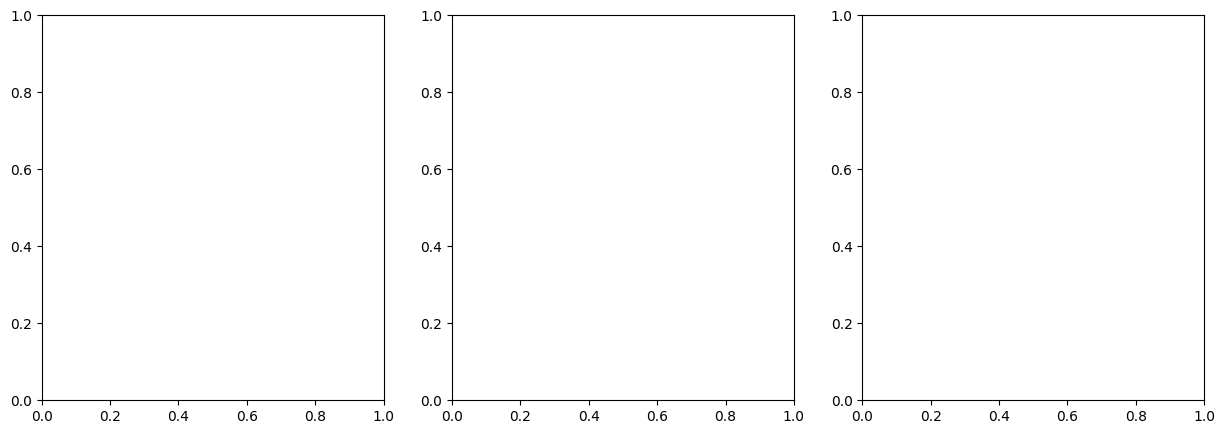

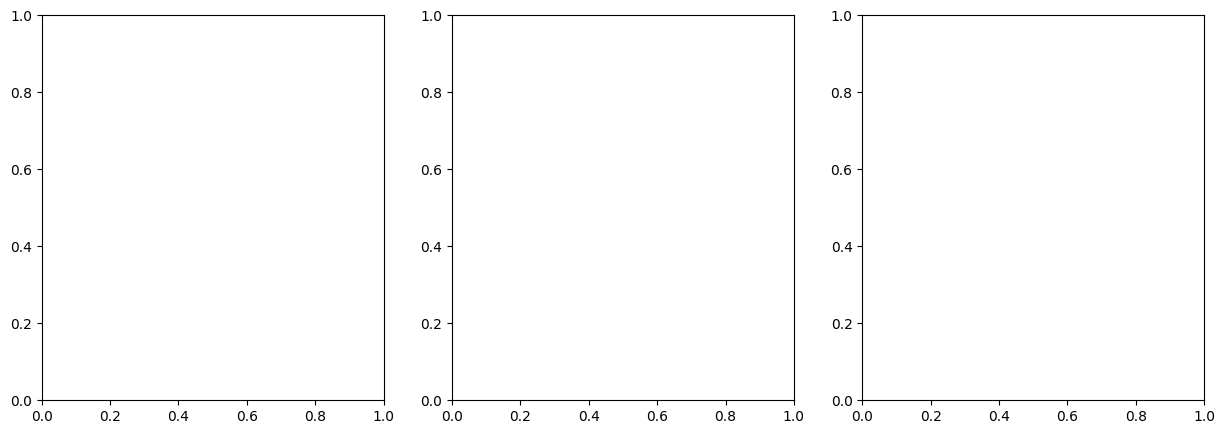

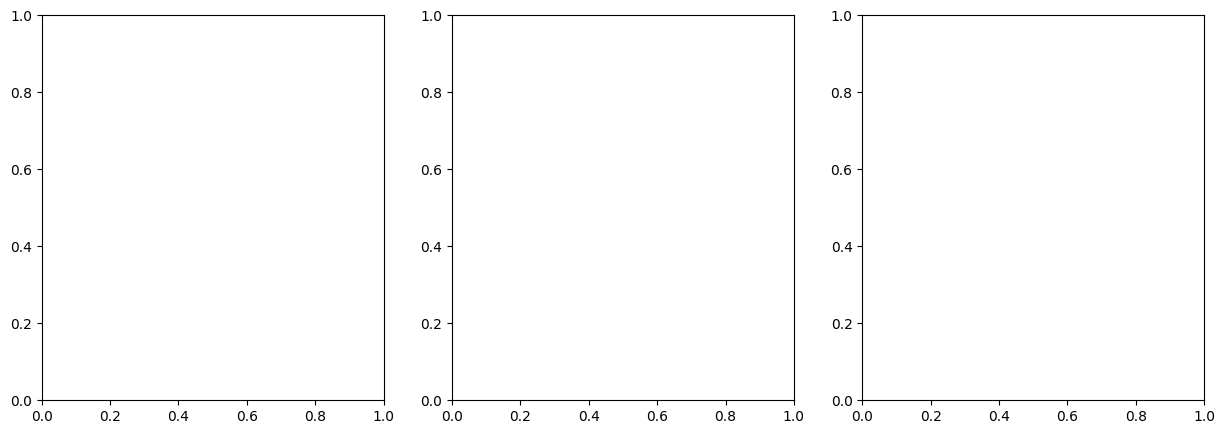

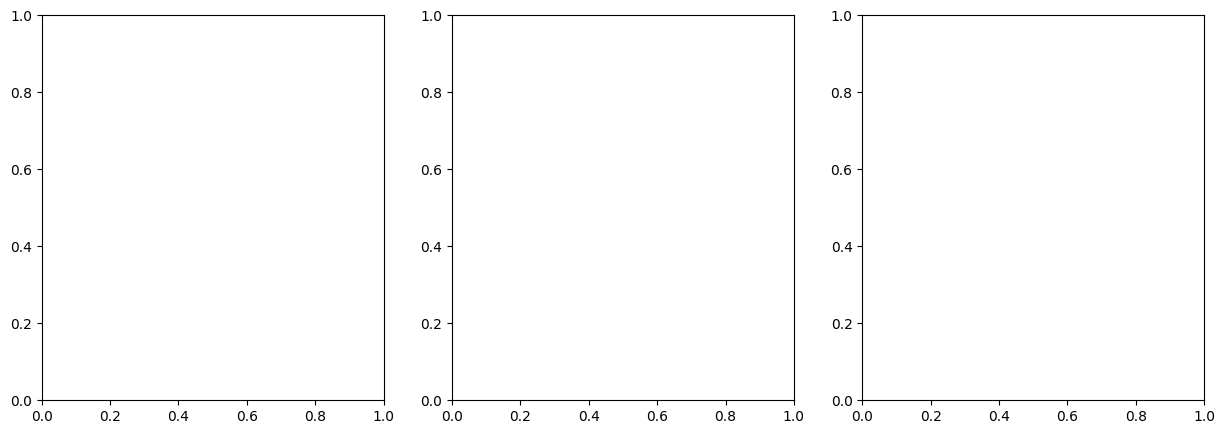

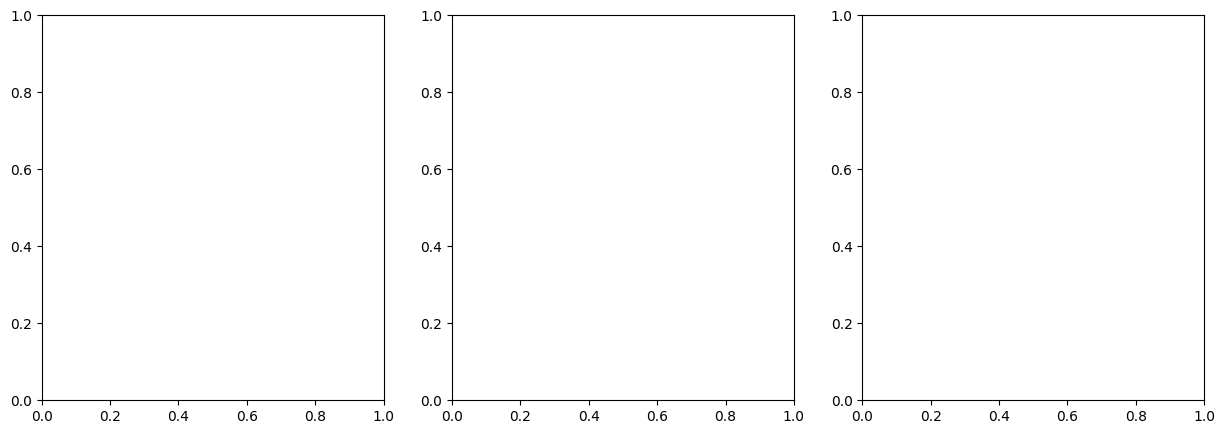

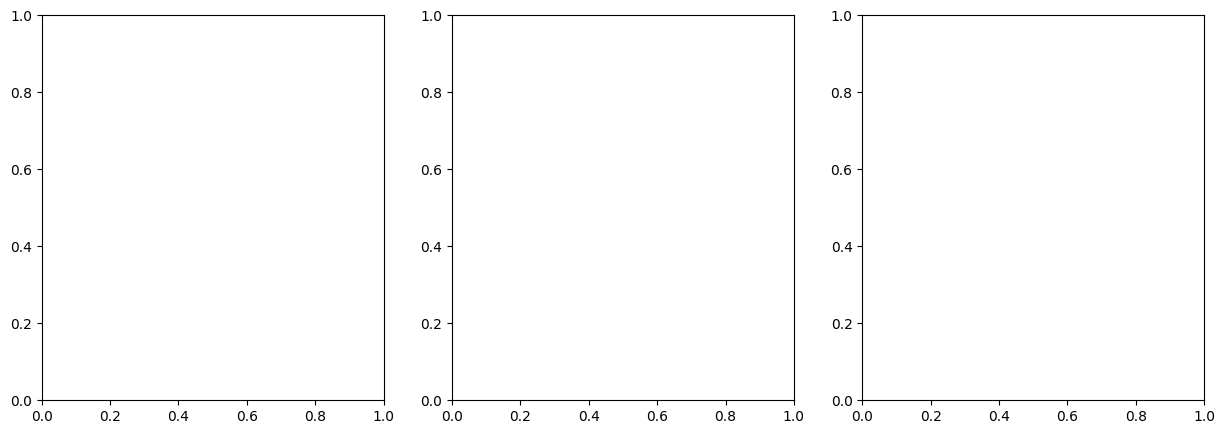

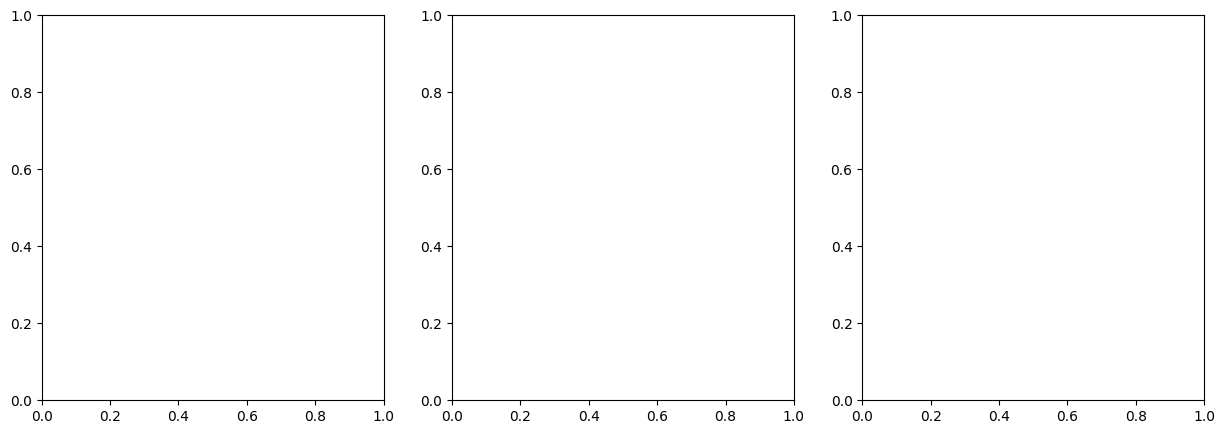

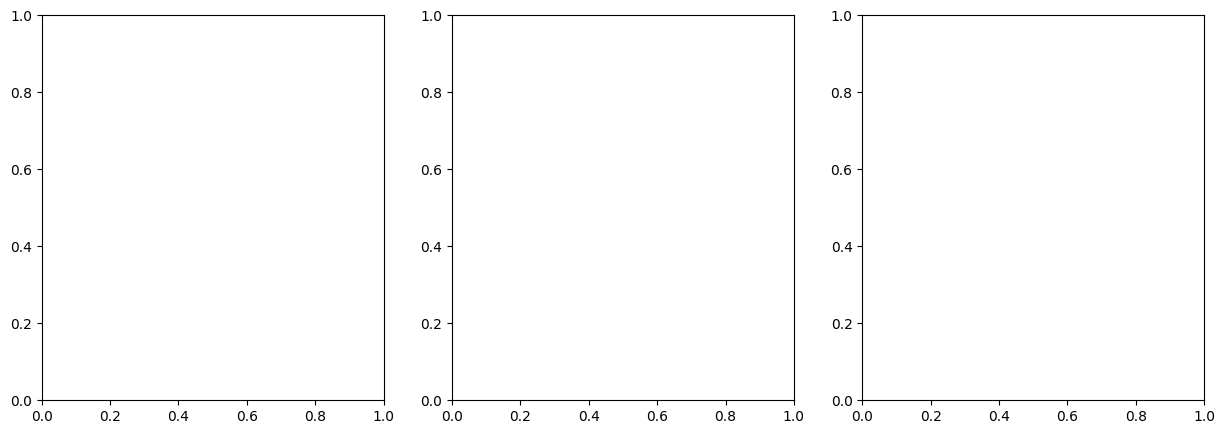

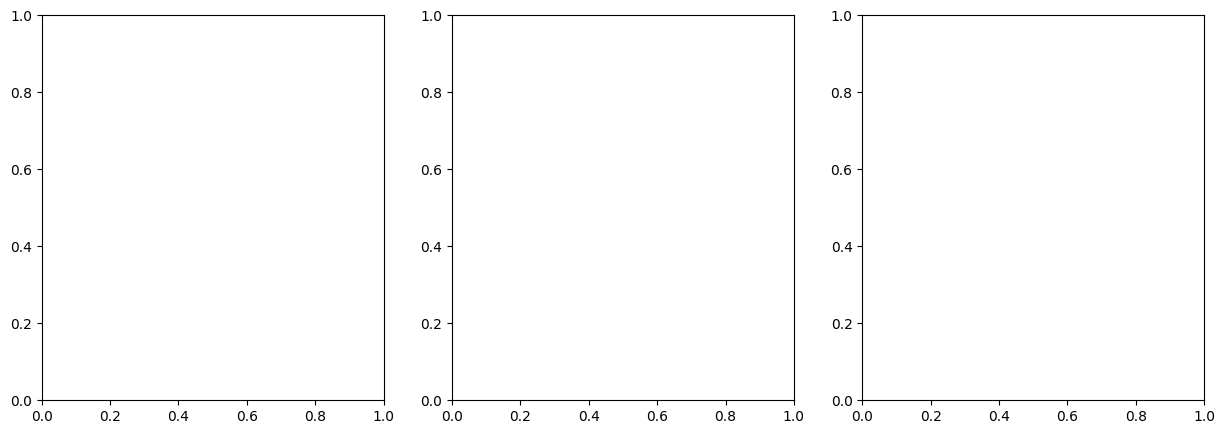

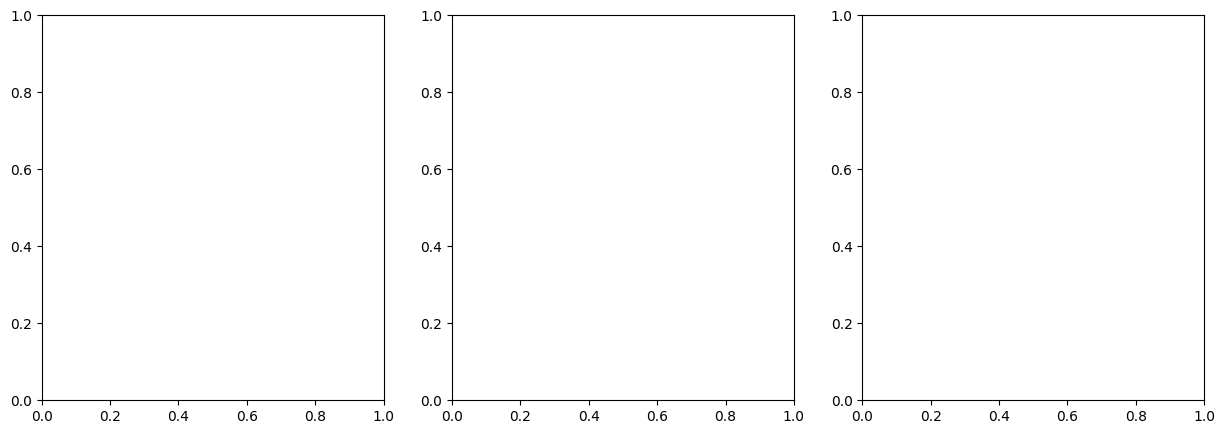

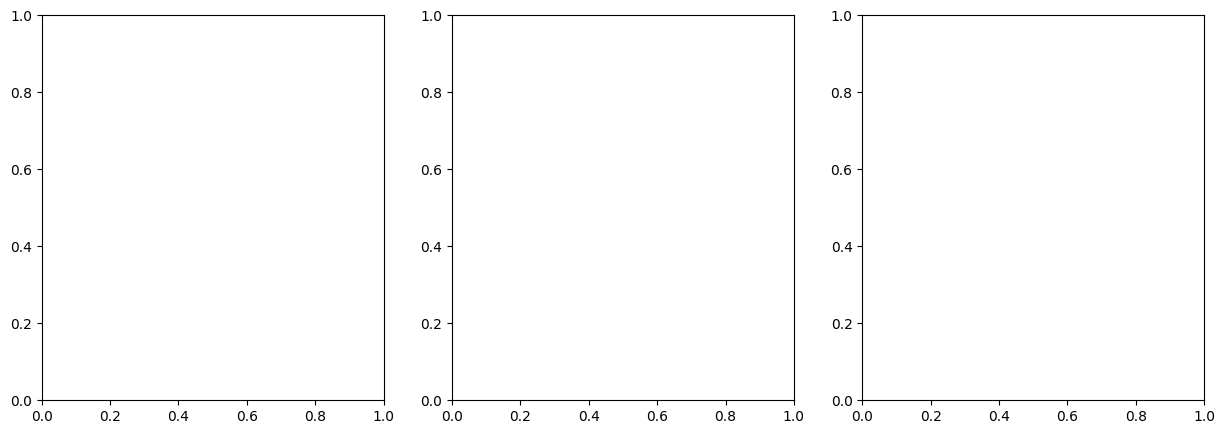

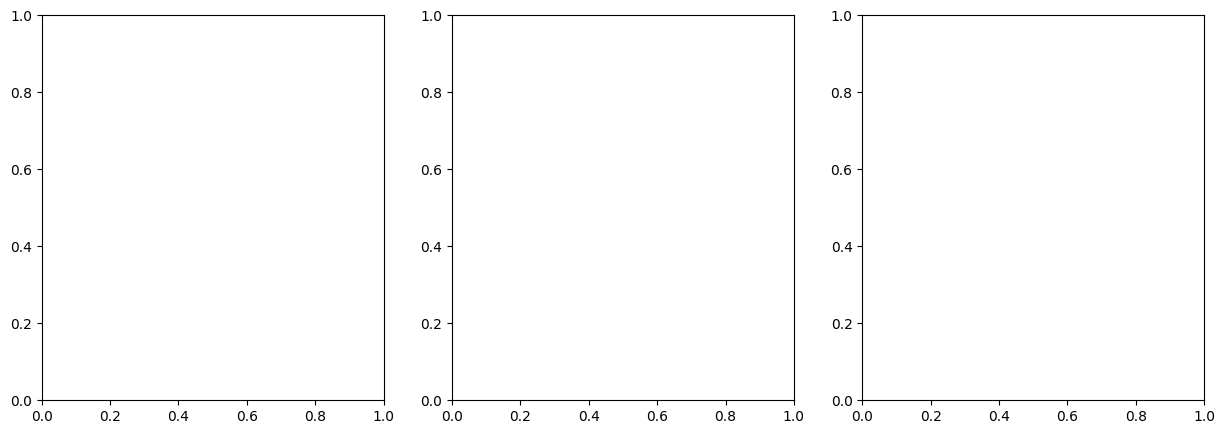

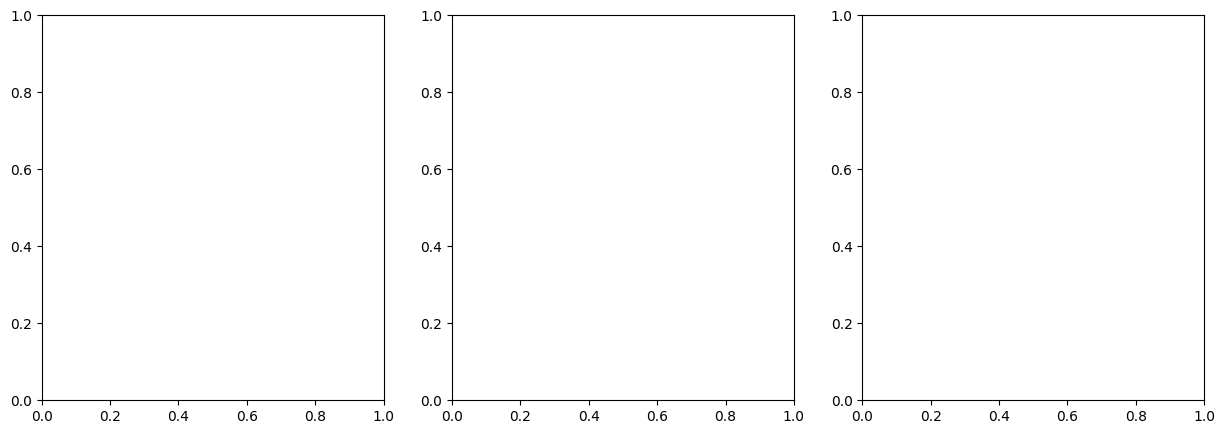

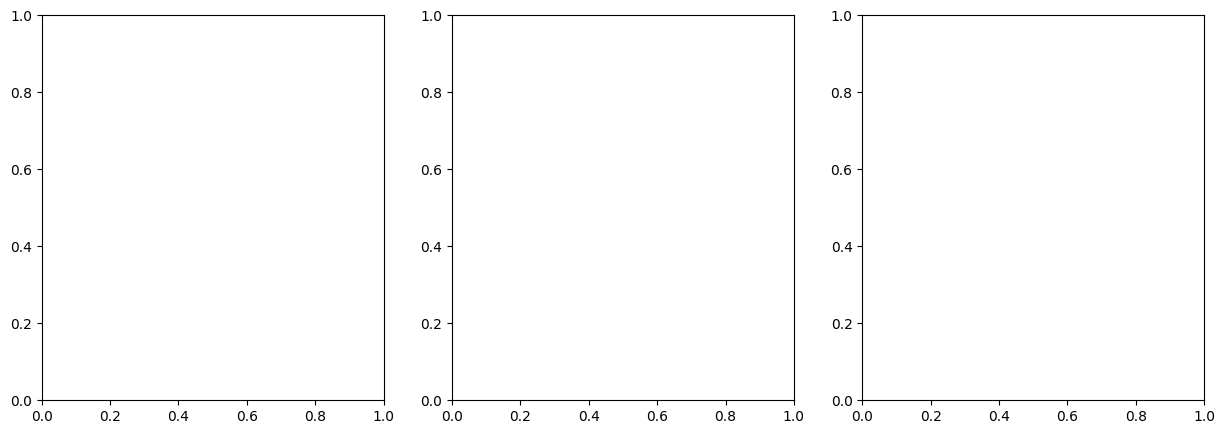

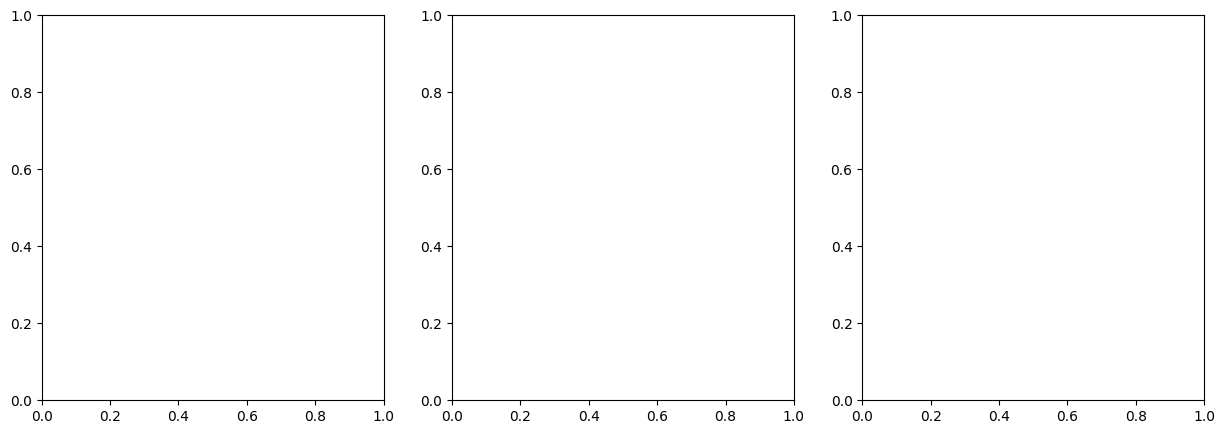

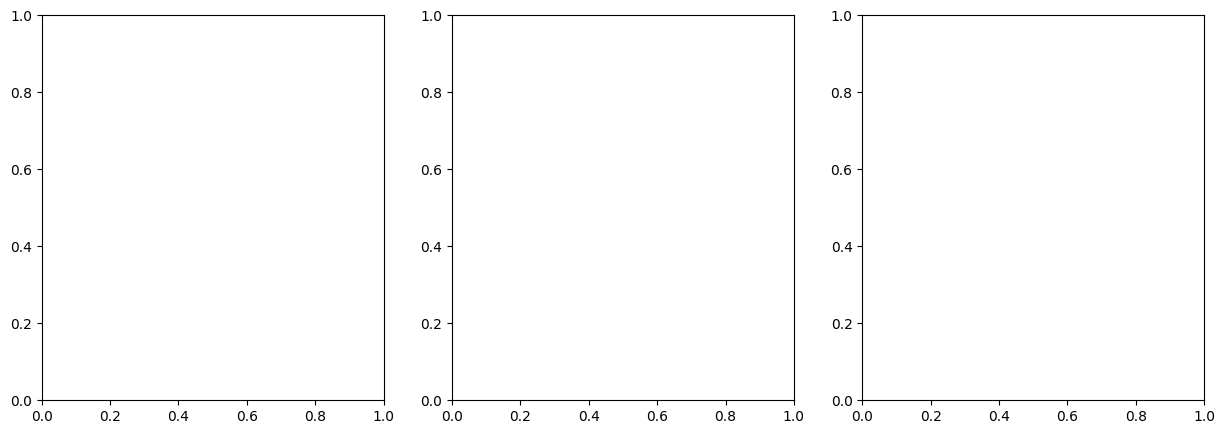

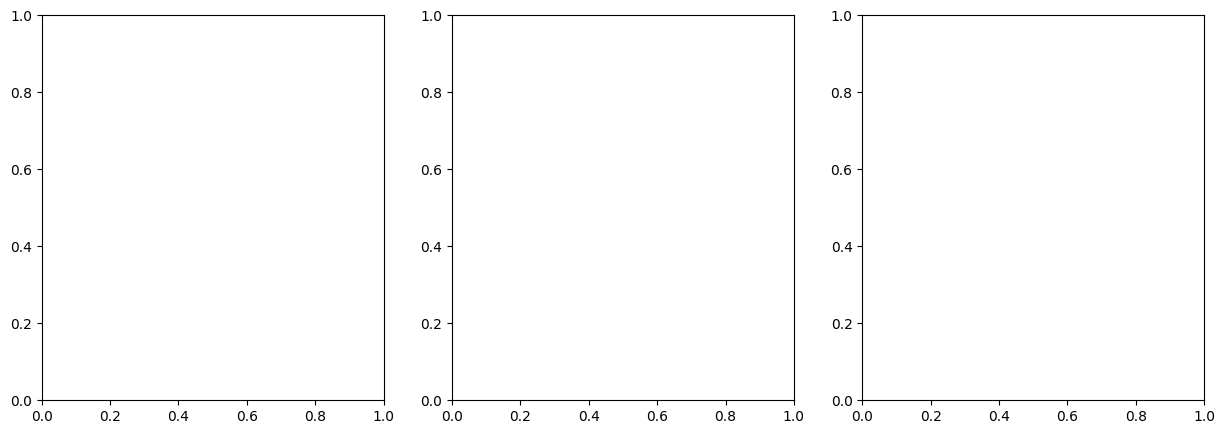

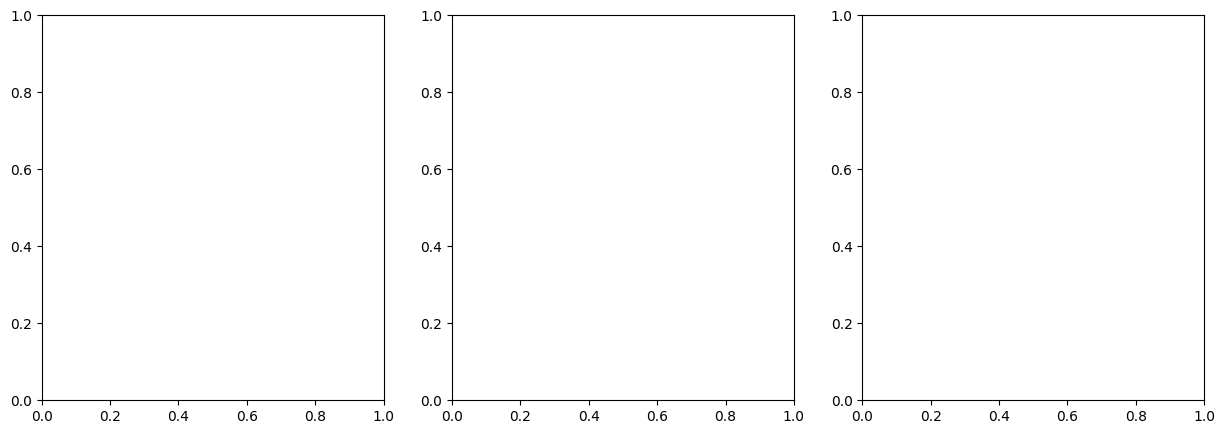

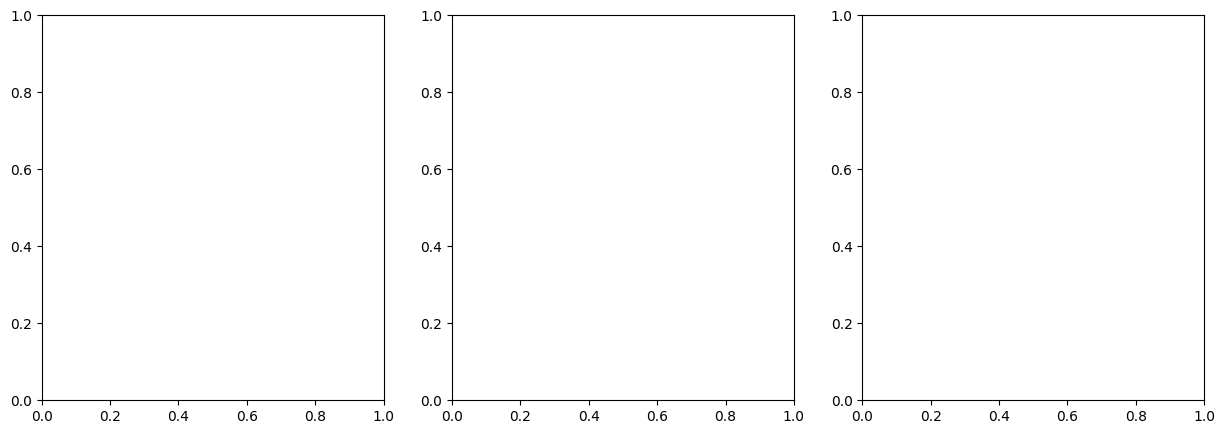

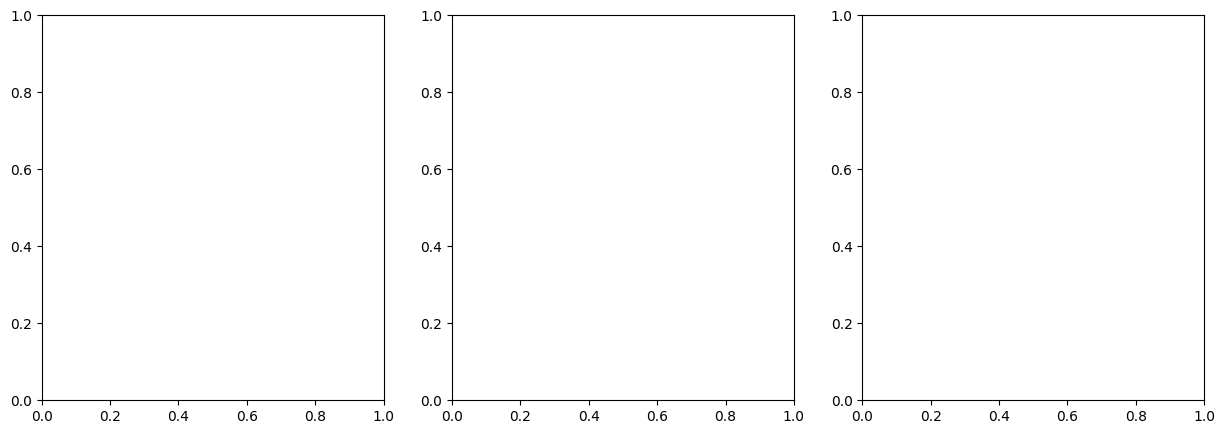

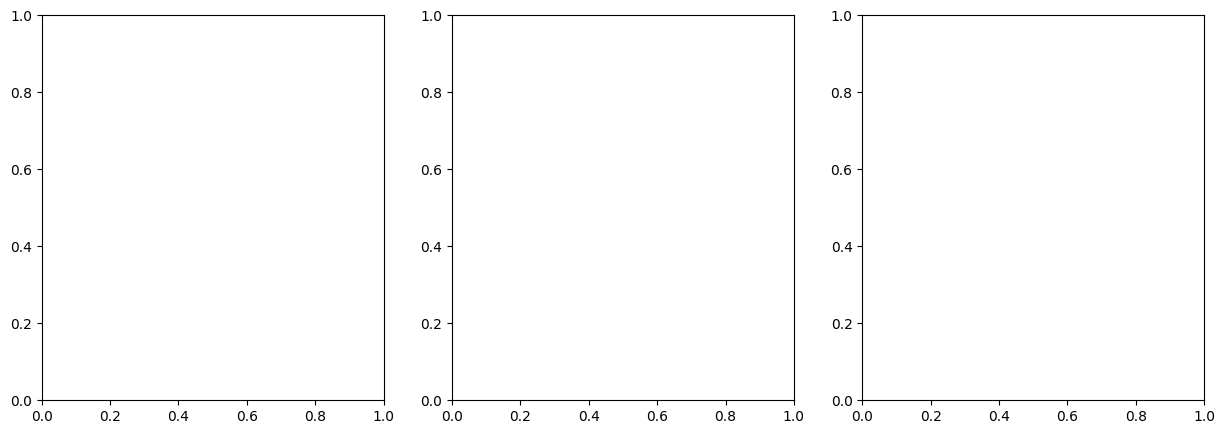

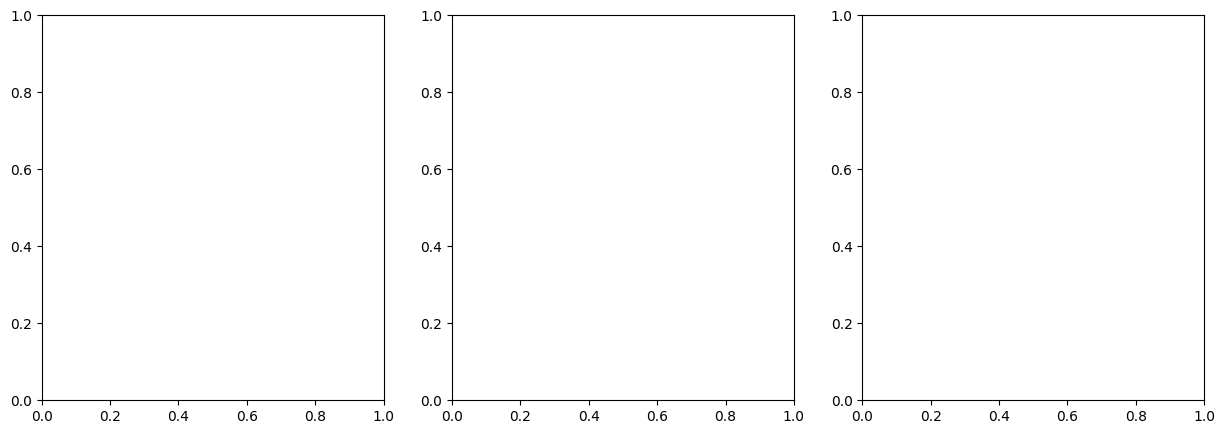

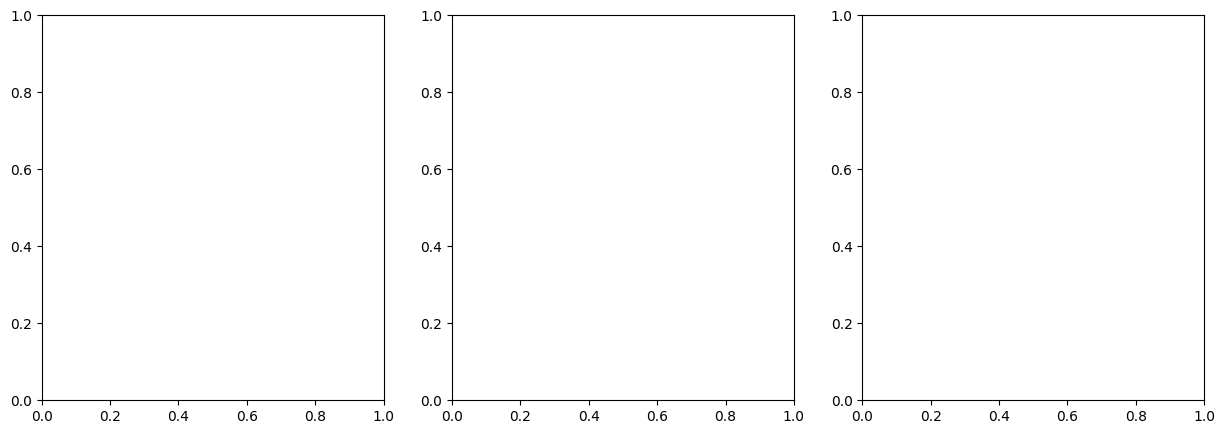

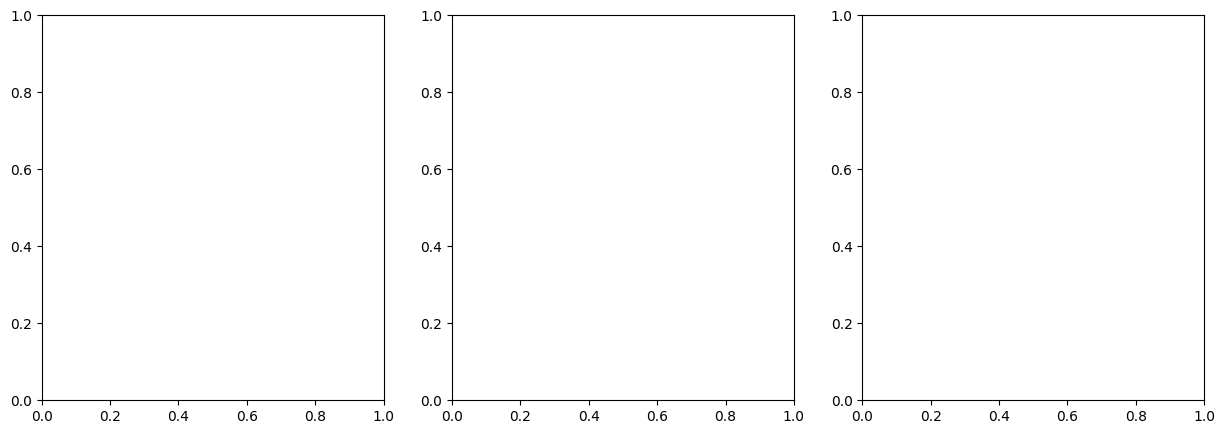

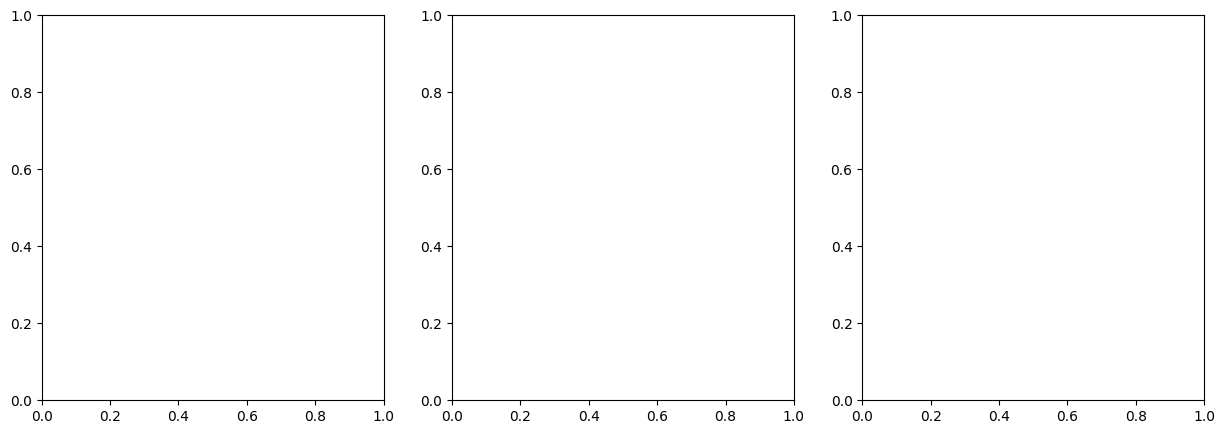

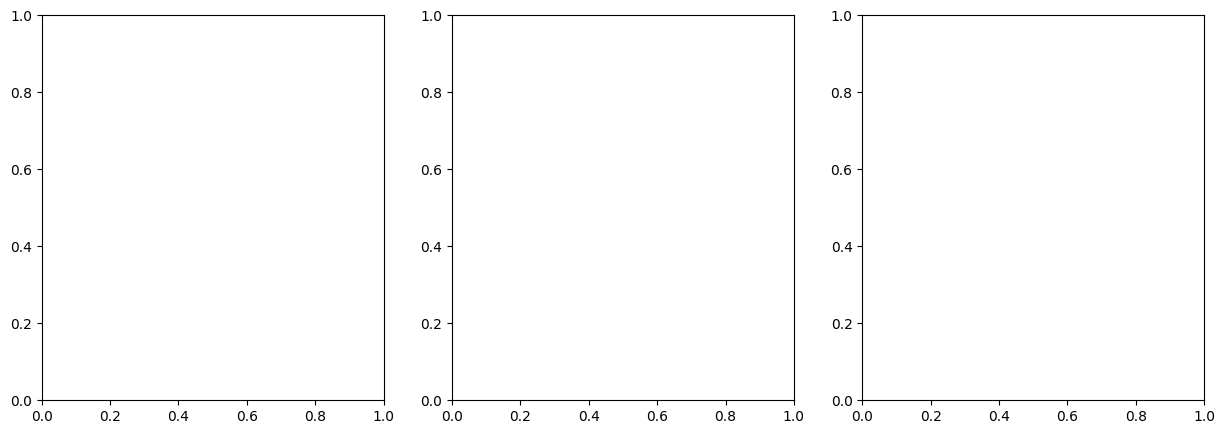

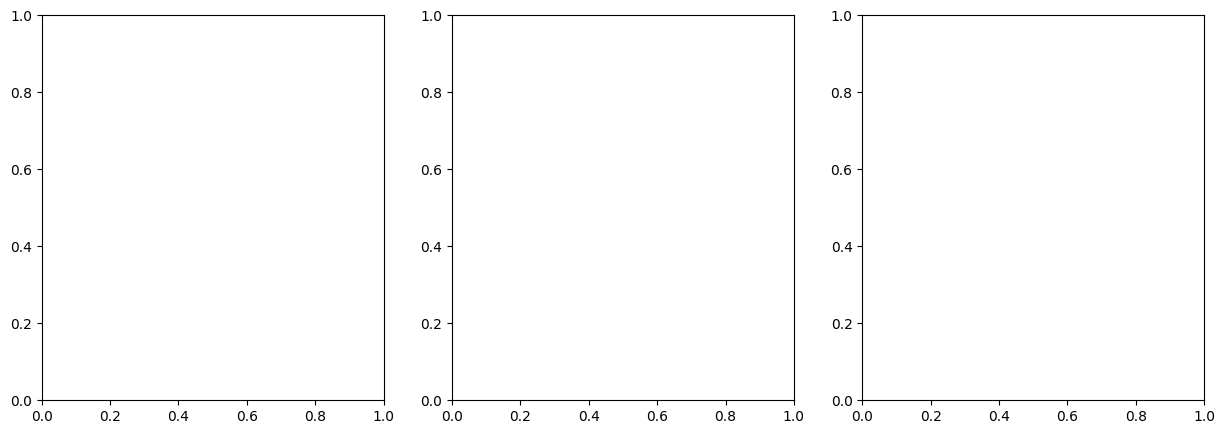

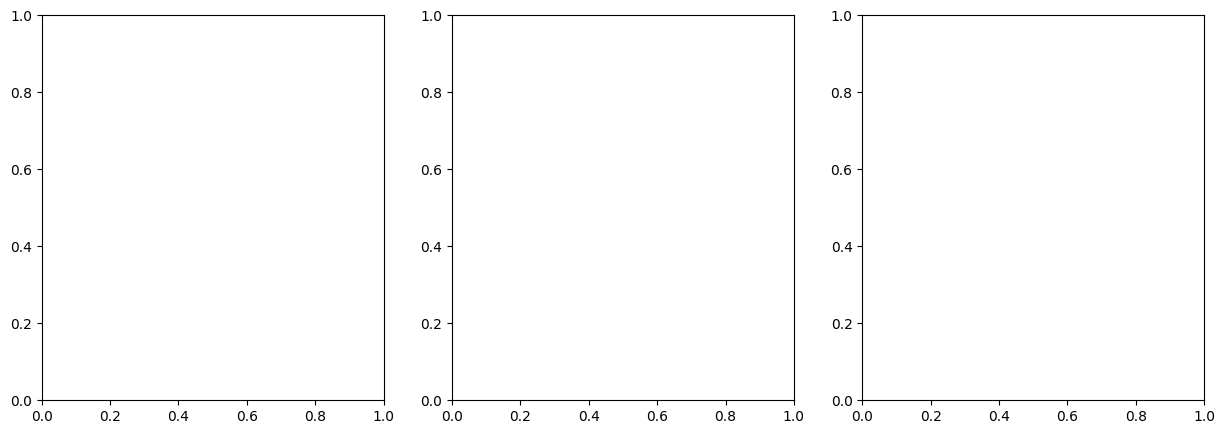

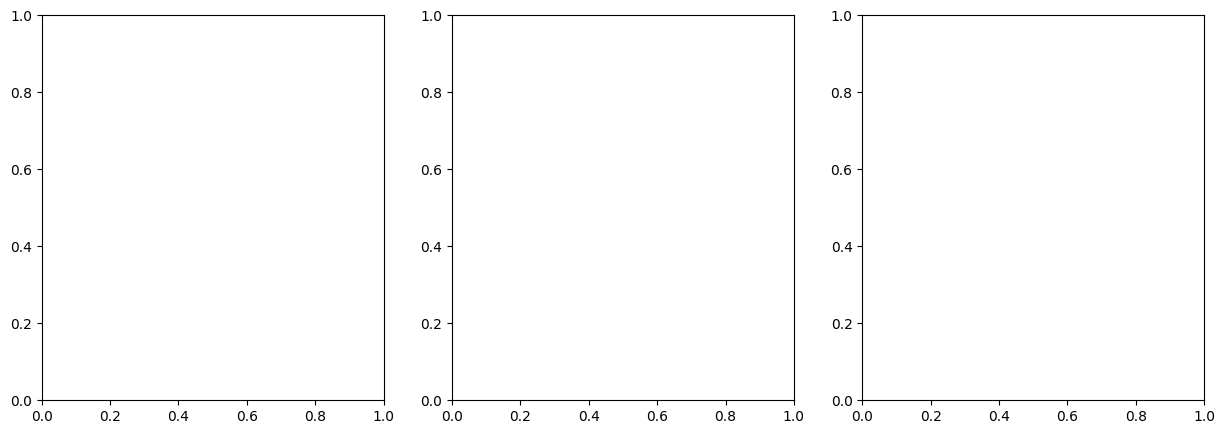

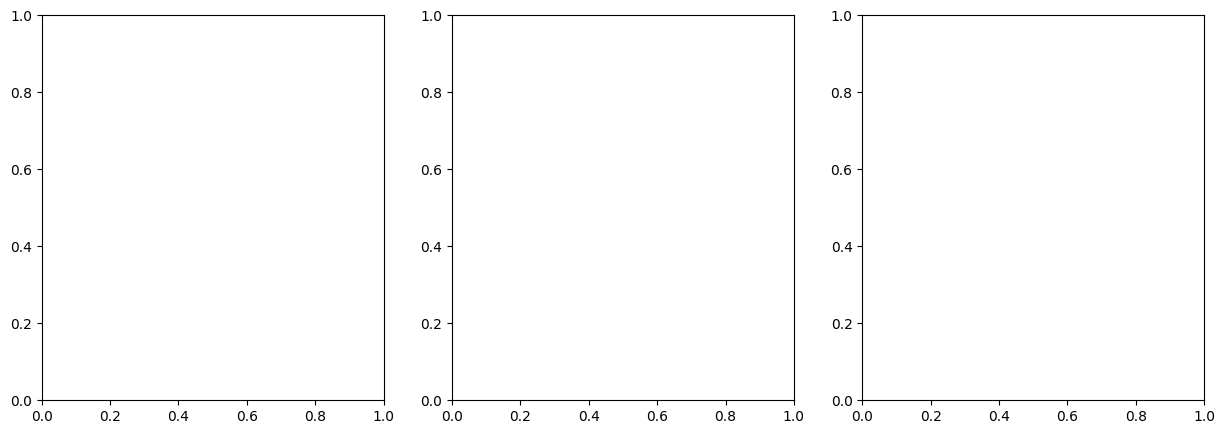

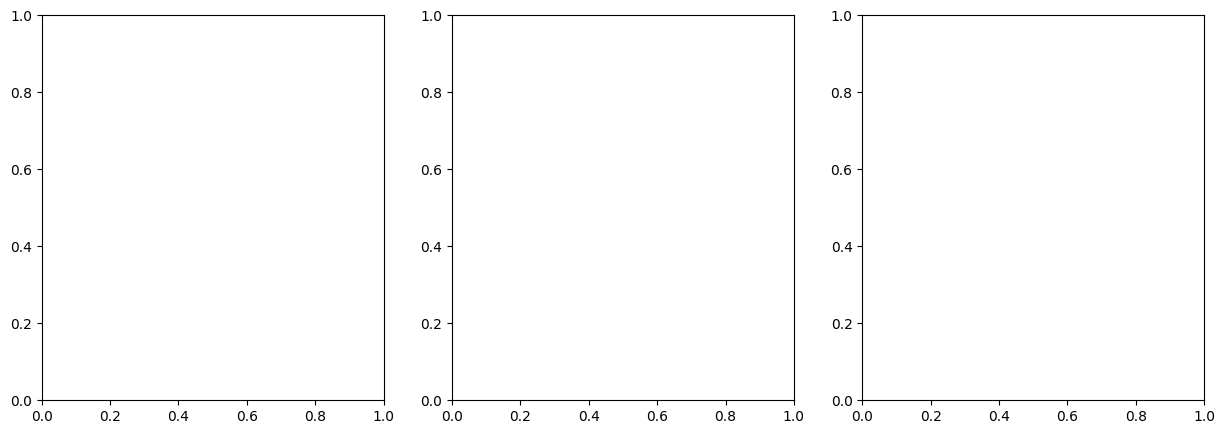

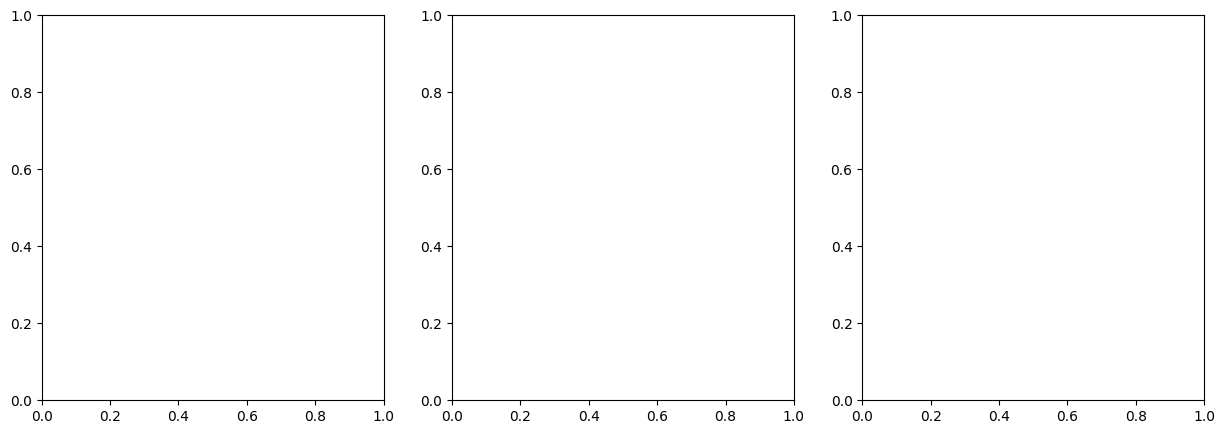

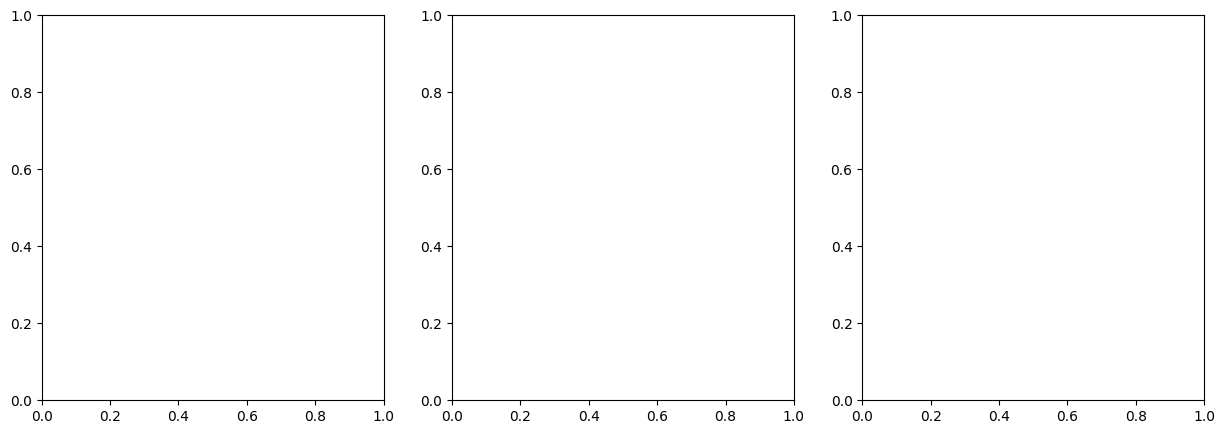

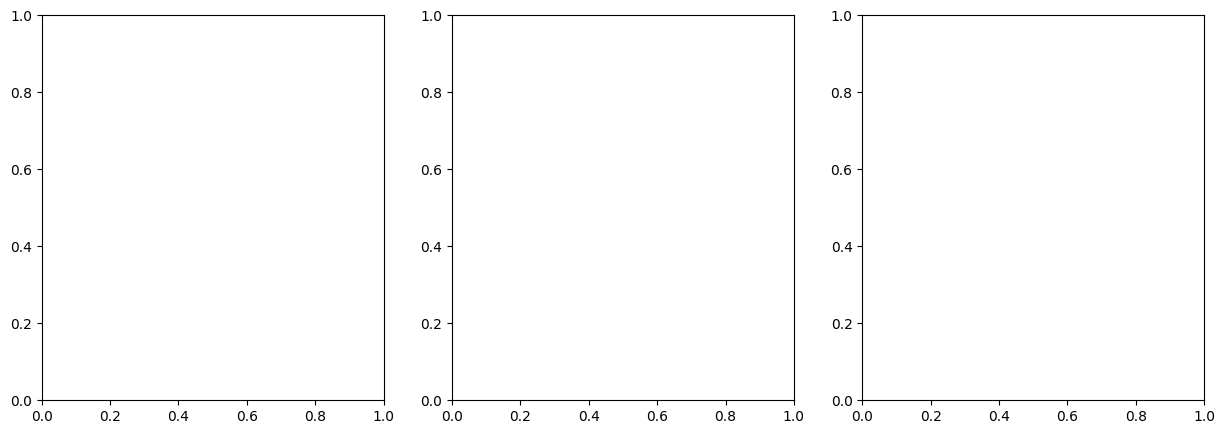

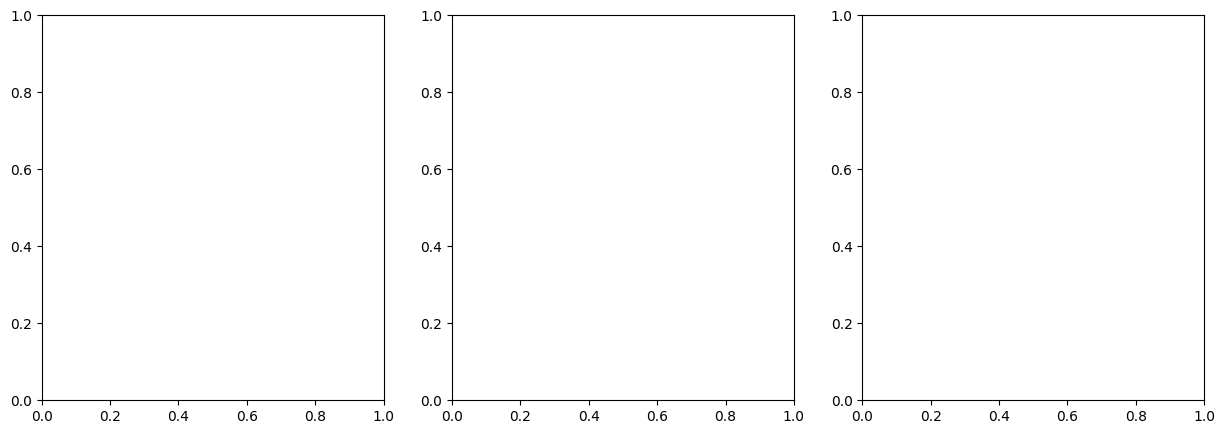

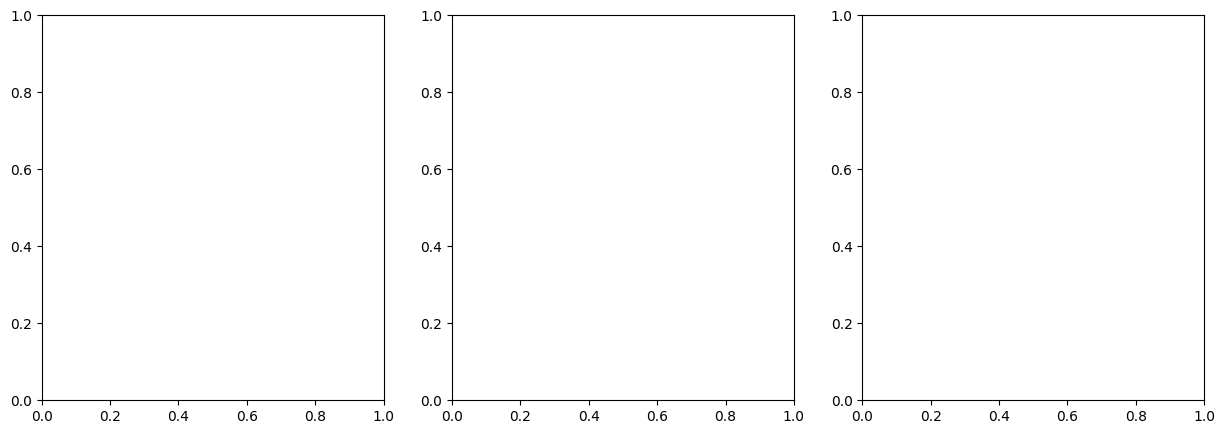

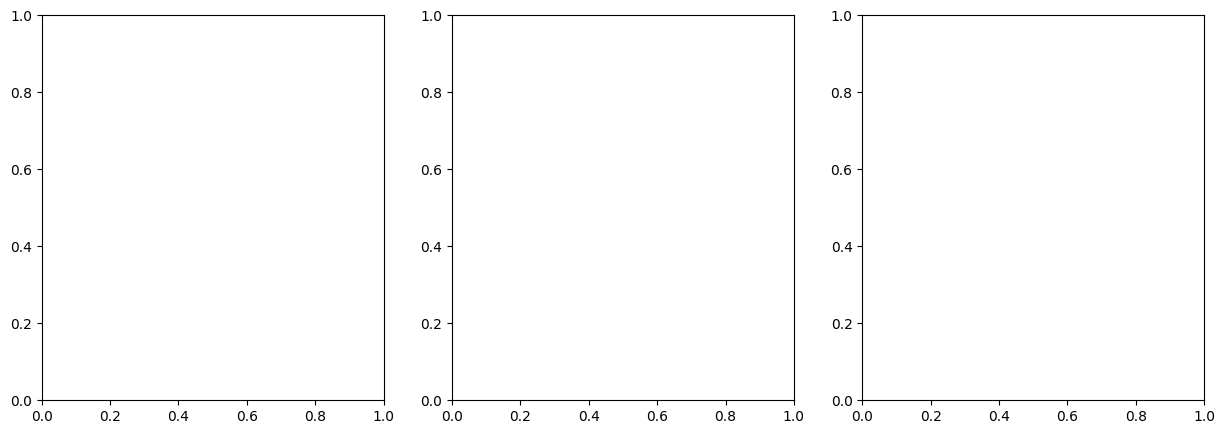

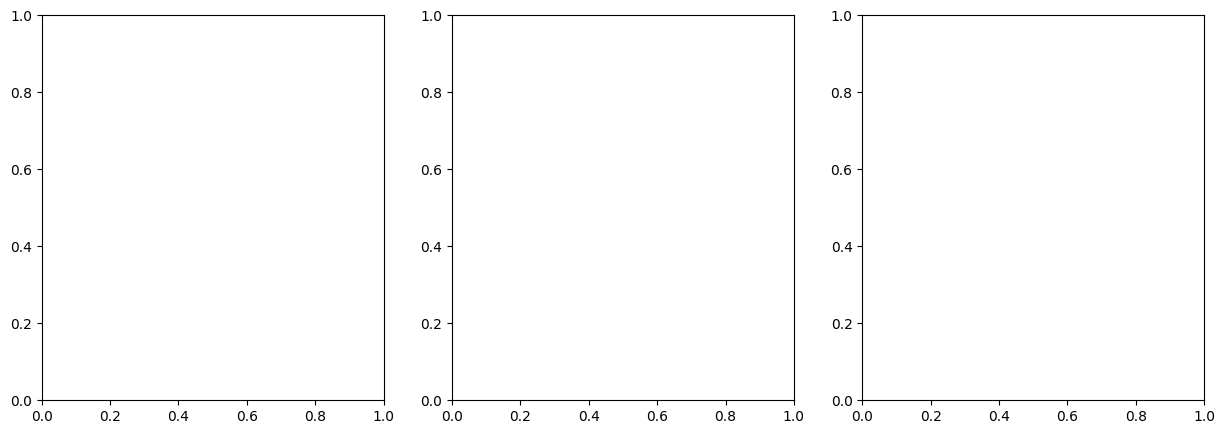

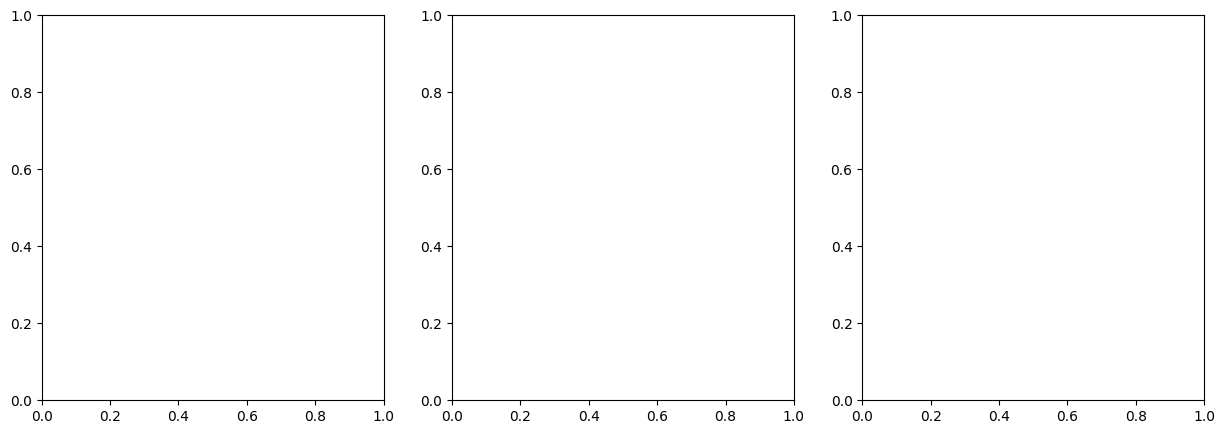

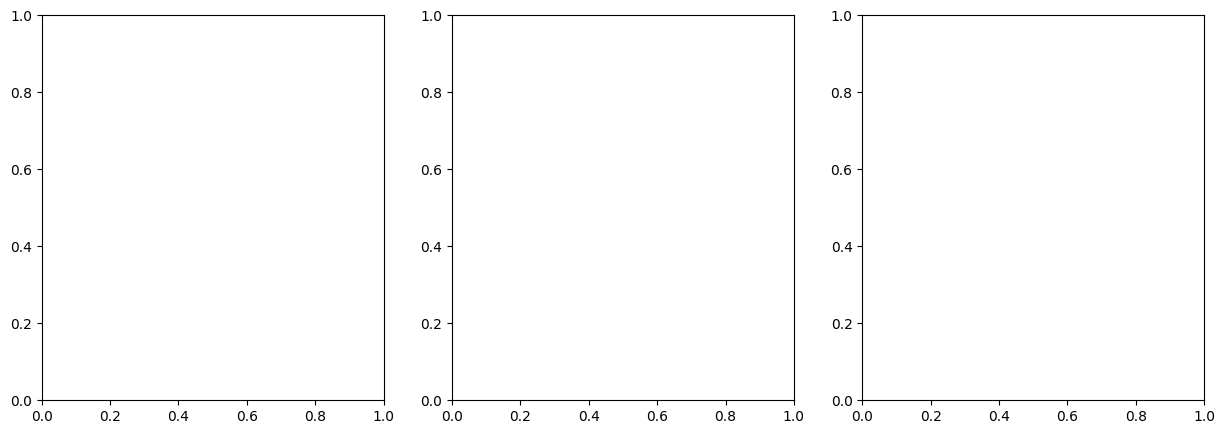

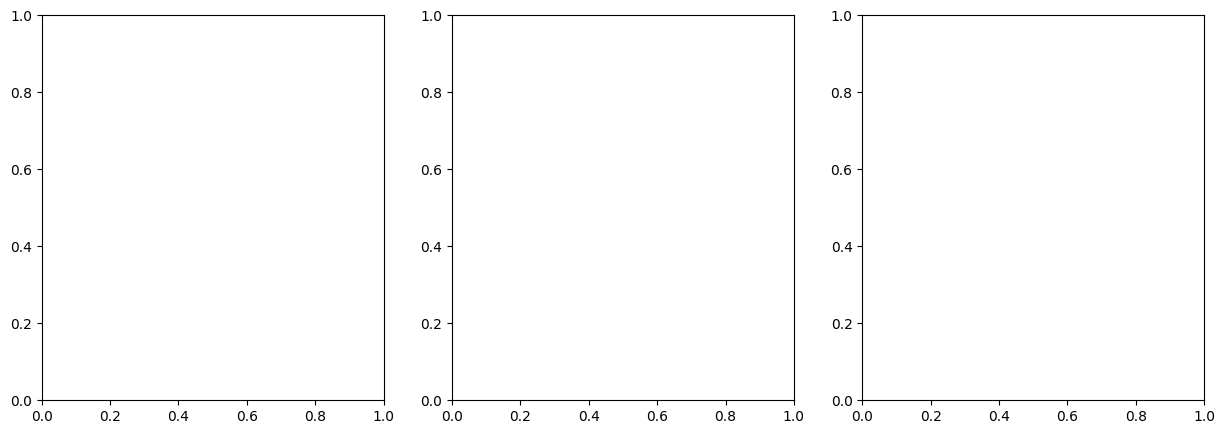

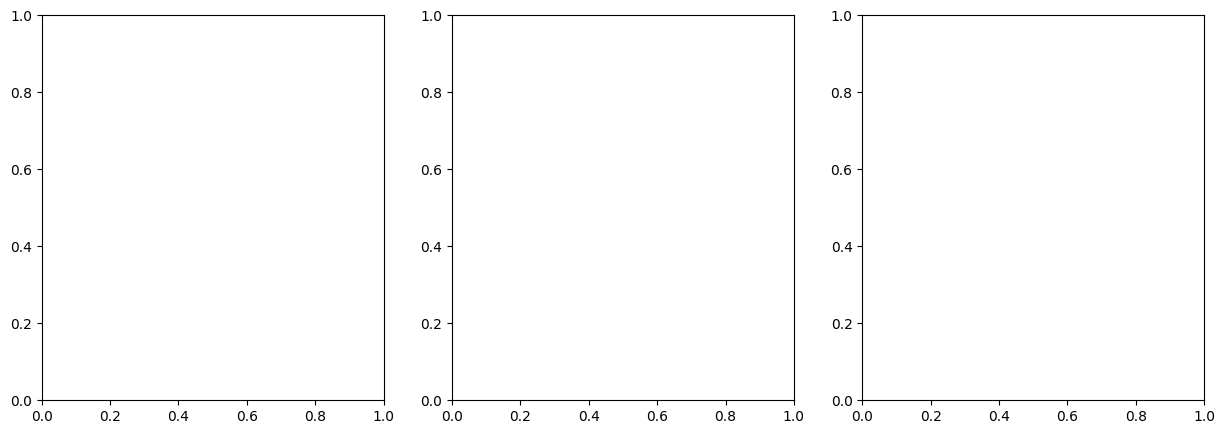

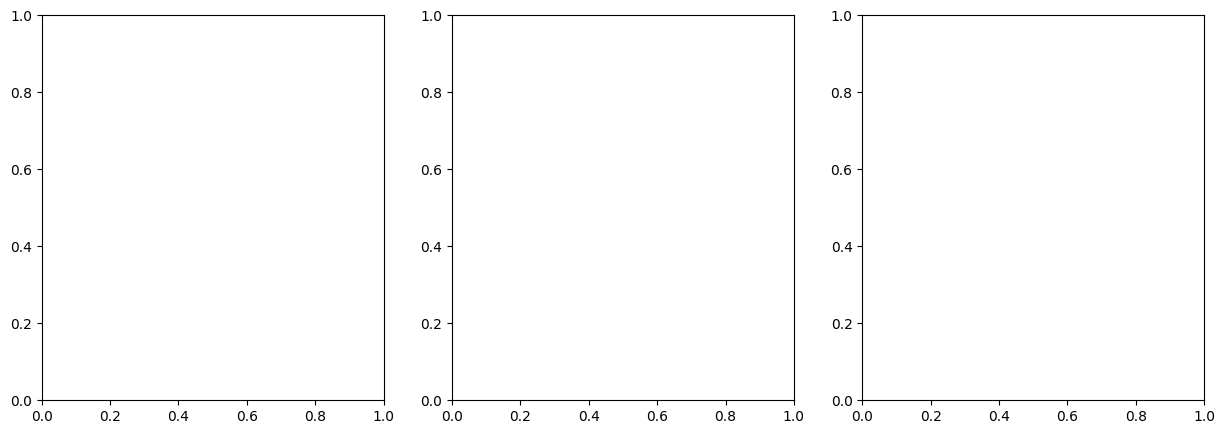

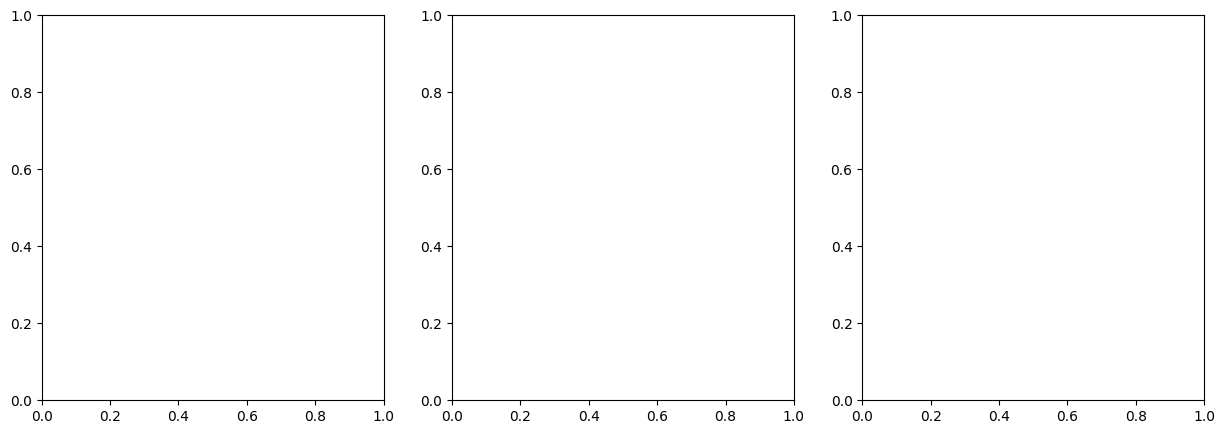

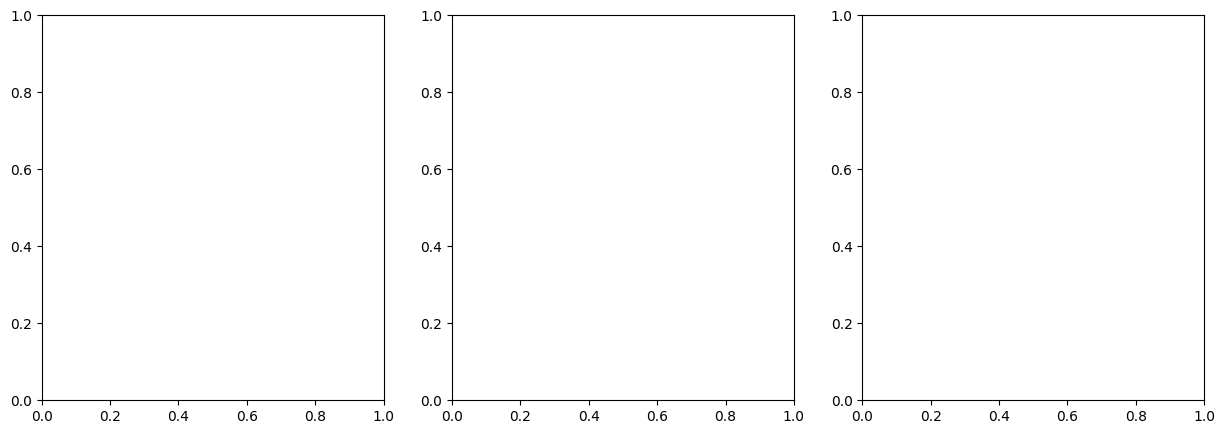

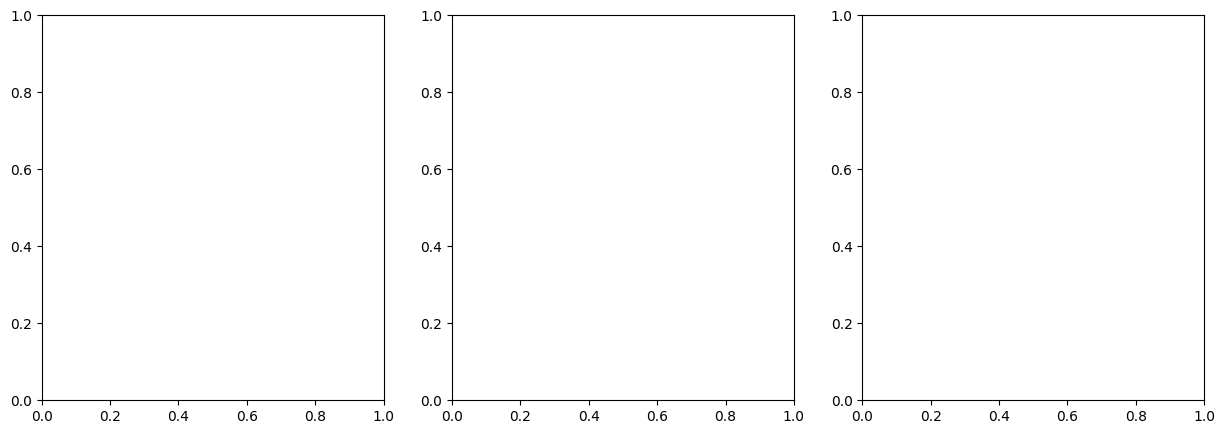

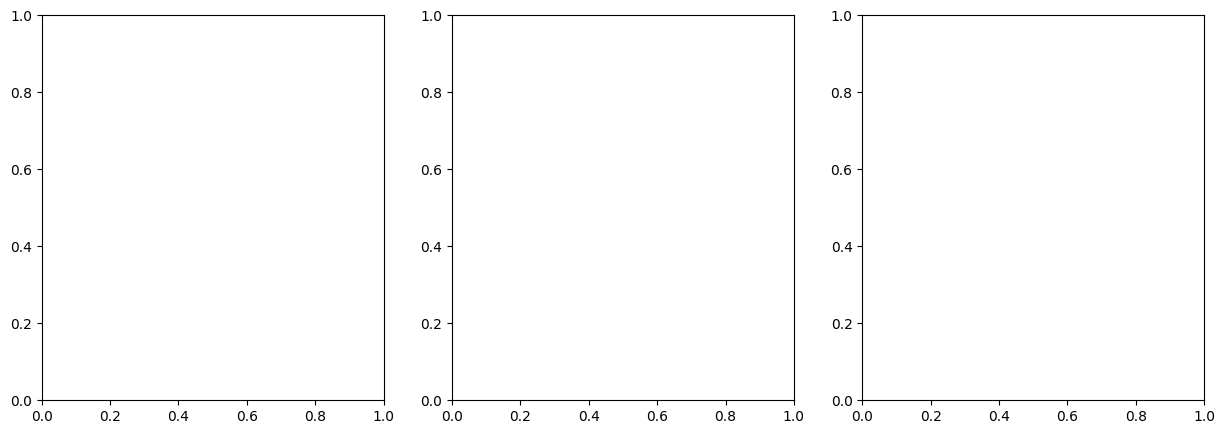

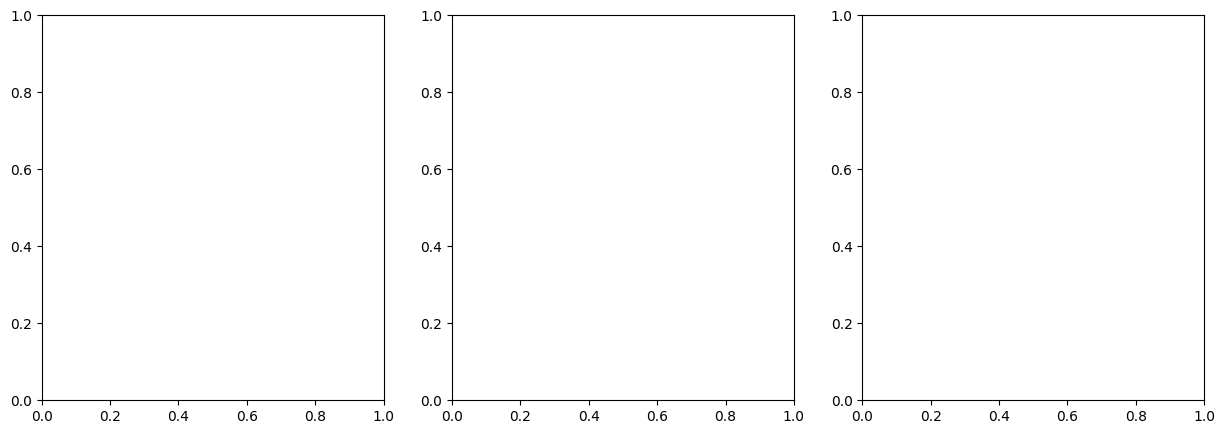

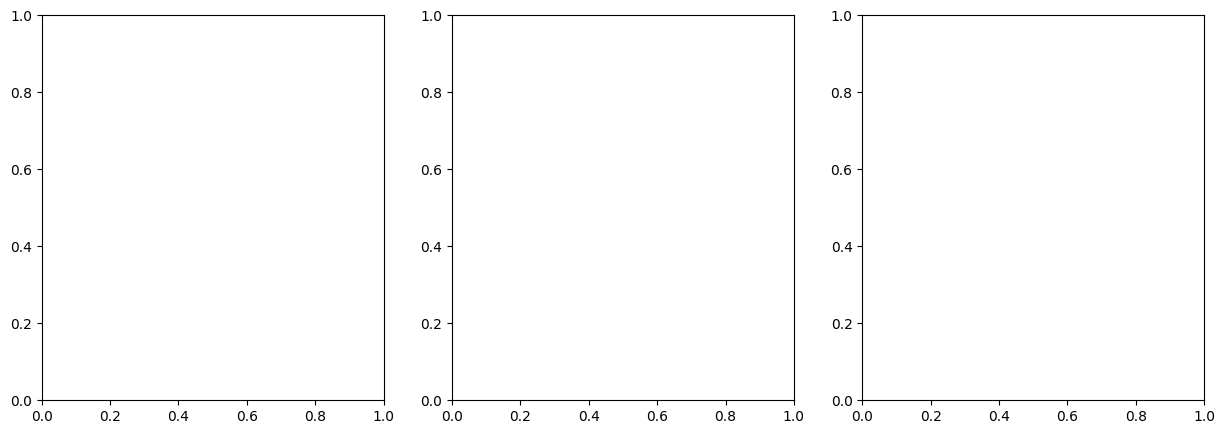

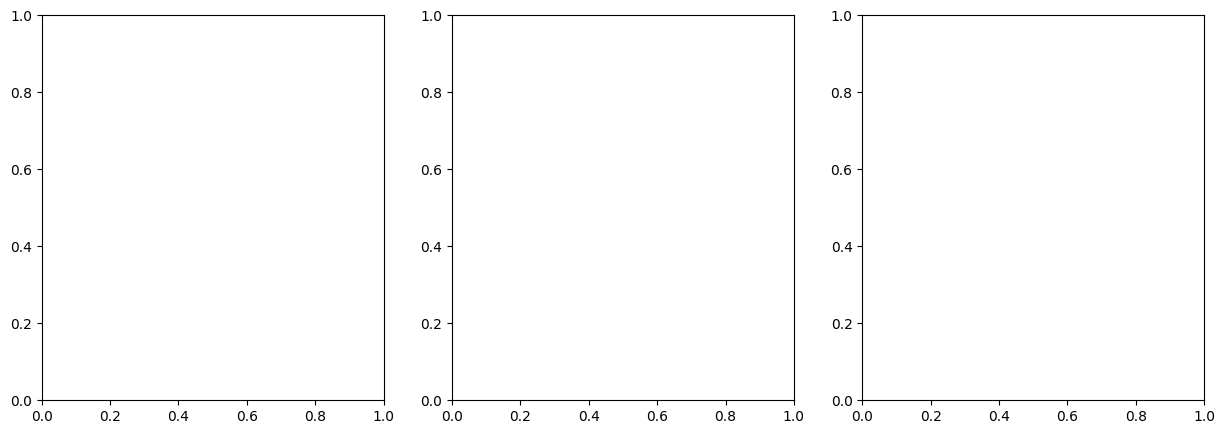

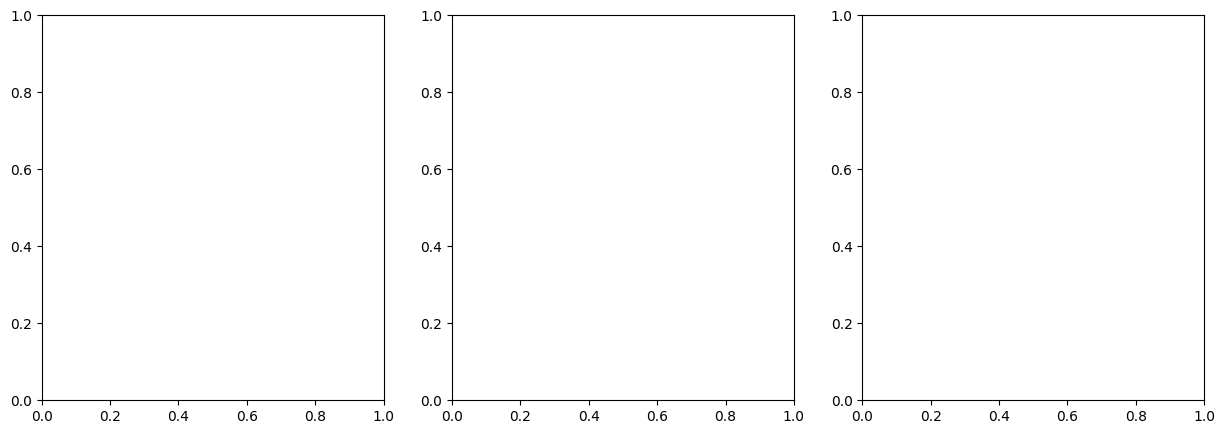

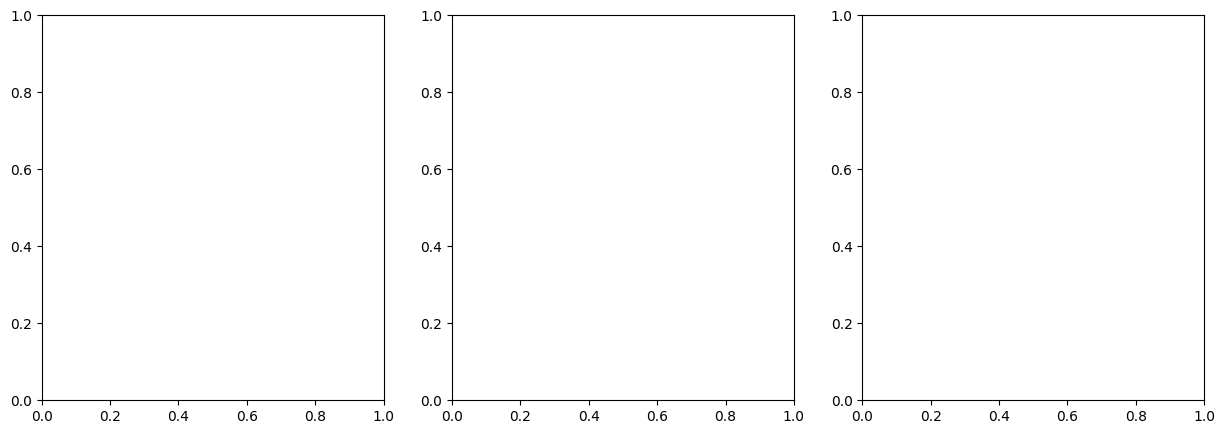

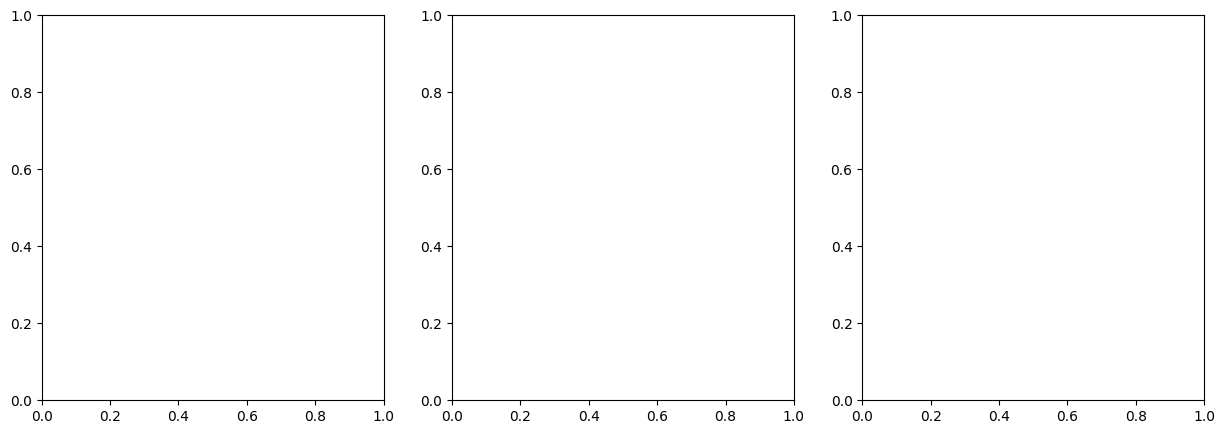

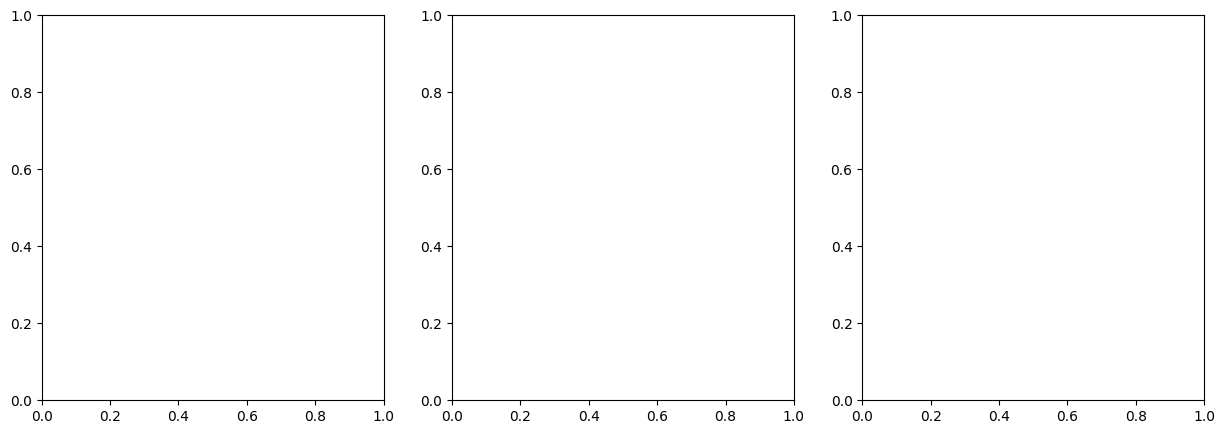

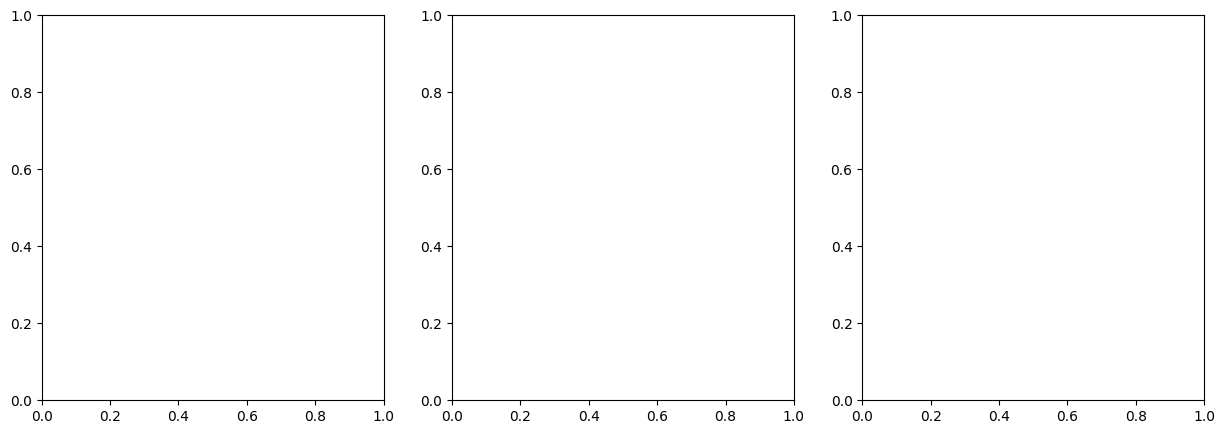

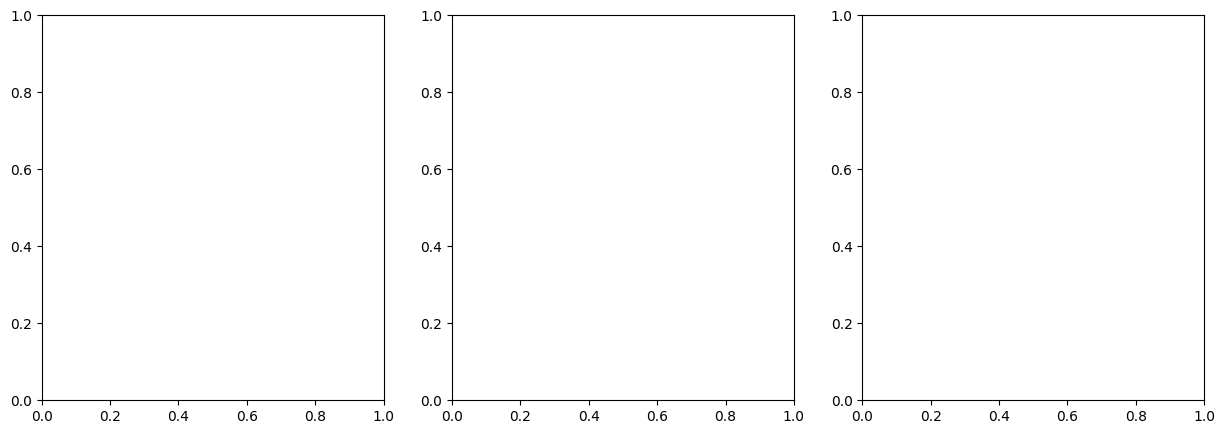

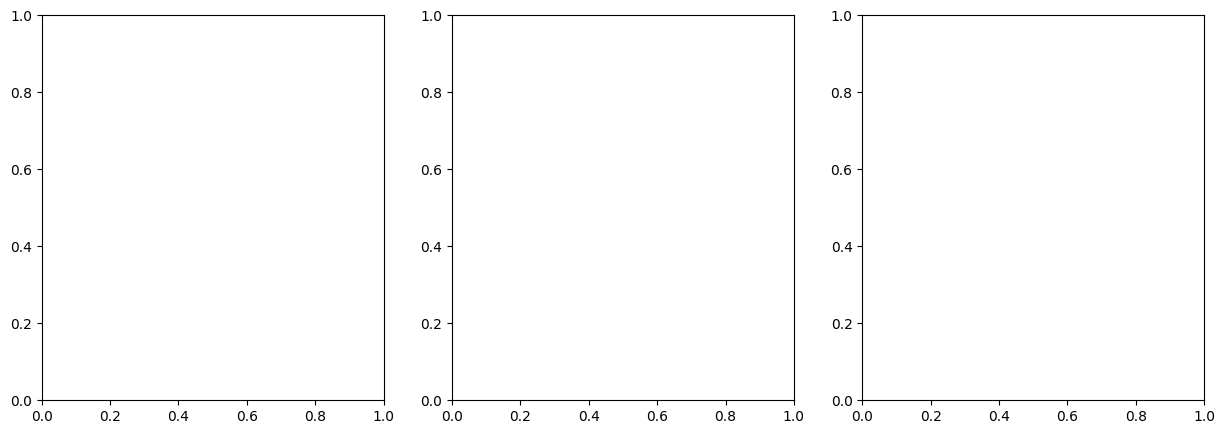

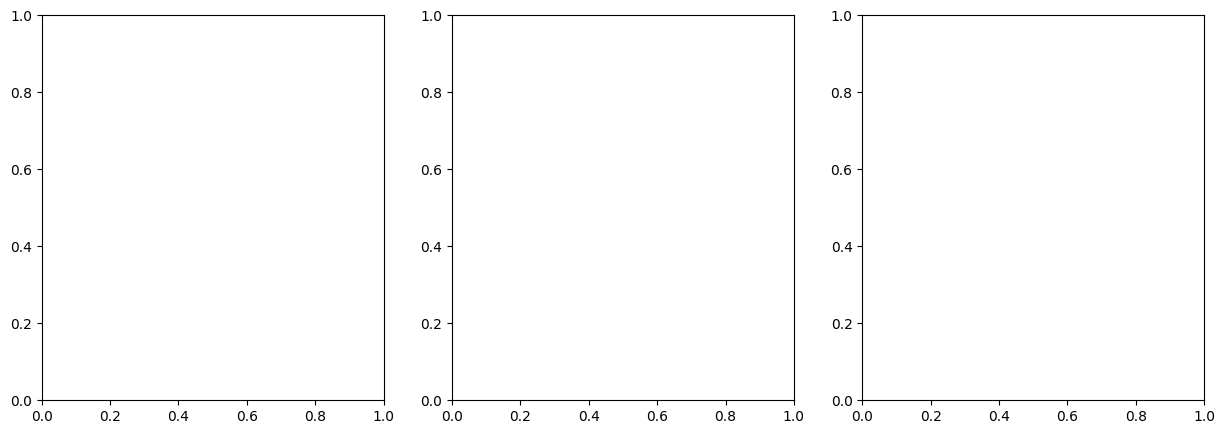

In [12]:

generate_submission()
print("\n--- Workflow Completed (Submission Only Rerun) ---")